# 4 - Técnicas para Mejorar la Robustez y Generalización de Modelos.

En este notebook se exploran diversas técnicas diseñadas para mejorar la robustez, la capacidad de generalización y el rendimiento de modelos de deep learning aplicados a datos de fMRI. Se incluyen estrategias de *data augmentation*, *transfer learning*, *fine-tuning* y técnicas para el manejo de *noisy labels*.

La elección de estas técnicas responde a las limitaciones que habitualmente presentan este tipo de estudios. Como señalan Janssen et al. (2018), una de las principales dificultades radica en el reducido tamaño muestral. En su estudio, observaron que los trabajos sobre neuroimagen aplicada a la depresión presentaban tamaños muestrales en el rango de 10 a 124 sujetos, lo que favorece el sobreajuste y dificulta la generalización del modelo. Para mitigar esta problemática, se aplican técnicas de *data augmentation*, que incrementan artificialmente el tamaño del conjunto de datos mediante transformaciones, y *transfer learning*, que consiste en reutilizar modelos preentrenados, ya que entrenar modelos desde cero con datos limitados suele resultar ineficaz.

Según Davatzikos (2019), otra de las grandes limitaciones de estos estudios es la presencia de etiquetas erróneas, originadas por diagnósticos clínicos incorrectos. Esto implica que el modelo puede aprender patrones a partir de datos mal etiquetados. Para abordar esta cuestión, se implementan diferentes estrategias de manejo de *noisy labels*.

Asimismo, Davatzikos (2019) identifica como limitación adicional la denominada “caja negra” de los modelos de deep learning, es decir, la falta de interpretabilidad sobre qué características han influido en las decisiones del modelo. Por ello, en un notebook posterior titulado *xai_analysis*, se implementará la técnica Grad-CAM (*Gradient-weighted Class Activation Mapping*), perteneciente al ámbito de la *Explainable Artificial Intelligence* (XAI), que permite generar mapas de calor sobre las imágenes utilizadas, con el fin de identificar las regiones que el modelo considera más relevantes.

Finalmente, otra limitación señalada por Janssen et al. (2018) es la falta de transparencia en algunos estudios de deep learning aplicados a neuroimagen, donde los investigadores podrían reportar únicamente los resultados del modelo con mejor rendimiento, omitiendo otros enfoques menos exitosos. Con el objetivo de favorecer la transparencia, en este notebook se documentan y comentan todos los experimentos realizados, independientemente de su rendimiento.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
import seaborn as sns
import cv2
!pip install nilearn
from nilearn.masking import unmask, apply_mask
from nilearn.masking import apply_mask
import nibabel as nib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle
from tensorflow.keras.applications import VGG19, ResNet50, MobileNetV2, VGG16
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
!pip install optuna
import optuna
import sys
sys.path.append('/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/utils')
import pipeline_utils as p
from keras.saving import register_keras_serializable
import time
!pip install codecarbon
from codecarbon import EmissionsTracker

## 4.1 - Modelado con *data augmentation*.

La metodología aplicada en esta sección de *data augmentation*, así como en la de *transfer learning*, se basa en el estudio de Krishnapriya y Karuna (2023), en el que implementan distintos modelos de redes neuronales convolucionales (CNN) preentrenados sobre imágenes de resonancia magnética. En dicho estudio, los autores aplican las siguientes transformaciones para aumentar artificialmente el conjunto de datos: rotación del 15%, desplazamiento horizontal y vertical del 5%, escalado mediante un factor de 1/255 y duplicación en los ejes horizontal y vertical.

Con el objetivo de seguir una metodología lo más similar posible, en el presente proyecto se implementan las mismas transformaciones, con la única excepción del *rescaling*, que ha sido omitido.





### 4.1.1 - Preparación de los datos.

In [ ]:
base_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)"
data_dir = os.path.join(base_dir, "data/raw")
mask_dir = os.path.join(base_dir, "data/preprocessed/masks")
metadata_path = os.path.join(base_dir, "data/participants.tsv")
output_dir = os.path.join(base_dir, "data/splits")
output_X_path = os.path.join(output_dir, "X_augmented.npy")
output_y_path = os.path.join(output_dir, "y_augmented.npy")
output_ids_path = os.path.join(base_dir, "data/splits/subject_ids_augmented.npy")

In [ ]:
def apply_augmentations_2d(volume, rotation=15, shift=0.05, flip=True):
    """
    Aplica transformaciones de data augmentation 2D independientes a cada corte temporal de un volumen fMRI.

    Cada slice bidimensional (X, Y) del volumen (X, Y, T) es transformado mediante rotación aleatoria,
    desplazamiento aleatorio y, opcionalmente, inversión de ejes. Las transformaciones se aplican por separado
    a cada paso temporal (frame) para simular variabilidad espacial en los datos.

    Parameters
    ----------
    volume : np.ndarray
        Volumen fMRI de entrada con forma (X, Y, T), donde T es el número de cortes temporales.
    rotation : float, optional
        Ángulo máximo de rotación en grados (por defecto 15). Se elige un ángulo aleatorio en [-rotation, +rotation].
    shift : float, optional
        Proporción máxima de desplazamiento relativo al tamaño de la imagen (por defecto 0.05).
        El desplazamiento se aplica tanto en eje X como Y.
    flip : bool, optional
        Si es True, se aplica aleatoriamente inversión horizontal y/o vertical a cada corte (por defecto True).

    Returns
    -------
    augmented : np.ndarray
        Volumen transformado con las mismas dimensiones que el volumen original (X, Y, T), en formato float32.
    """
    X, Y, T = volume.shape
    center = (X // 2, Y // 2)
    augmented = np.zeros_like(volume)

    for t in range(T):
        slice_2d = volume[:, :, t]

        angle = np.random.uniform(-rotation, rotation)
        M_rot = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(slice_2d, M_rot, (Y, X), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

        dx = int(X * np.random.uniform(-shift, shift))
        dy = int(Y * np.random.uniform(-shift, shift))
        M_shift = np.float32([[1, 0, dx], [0, 1, dy]])
        shifted = cv2.warpAffine(rotated, M_shift, (Y, X), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

        if flip:
            if np.random.rand() > 0.5:
                shifted = cv2.flip(shifted, 0)
            if np.random.rand() > 0.5:
                shifted = cv2.flip(shifted, 1)

        augmented[:, :, t] = shifted

    return augmented.astype(np.float32)

In [ ]:
def preprocess_with_augmentation(
    data_dir,
    mask_dir,
    metadata_path,
    output_X_path,
    output_y_path,
    discard_volumes=5,
    n_aug_control=5,
    n_aug_depressed=2
):
    """
    Preprocesa y aumenta un conjunto de datos fMRI en reposo, extrayendo cortes 2D con mayor varianza,
    aplicando transformaciones espaciales, normalización y generando secuencias temporales para entrenamiento.

    Esta función itera sobre todos los archivos .nii.gz en un directorio, selecciona un corte 2D representativo
    del volumen fMRI de cada sujeto, aplica técnicas de data augmentation, y guarda el conjunto procesado
    junto con sus etiquetas y los IDs de los sujetos.

    Parameters
    ----------
    data_dir : str
        Ruta al directorio que contiene los archivos de imagen fMRI en formato `.nii.gz`.
    mask_dir : str
        Ruta al directorio que contiene las máscaras cerebrales en formato `.npy`.
    metadata_path : str
        Ruta al archivo de metadatos `.tsv` que contiene la información de grupo ("control" o "depressed").
    output_X_path : str
        Ruta donde se guardará el array `X_augmented` (secuencia fMRI normalizada y aumentada).
    output_y_path : str
        Ruta donde se guardará el array `y_augmented` (etiquetas binarias).
    discard_volumes : int, optional
        Número de volúmenes iniciales a descartar por sujeto (por defecto 5).
    n_aug_control : int, optional
        Número de secuencias aumentadas a generar por sujeto del grupo control (por defecto 5).
    n_aug_depressed : int, optional
        Número de secuencias aumentadas a generar por sujeto del grupo deprimido (por defecto 2).

    Returns
    -------
    X_augmented : np.ndarray
        Array de datos fMRI preprocesados y aumentados con forma (N, T, X, Y), donde N es el número total de secuencias.
    y_augmented : np.ndarray
        Array con las etiquetas binarias correspondientes (0 = control, 1 = deprimido).
    subject_ids_augmented : list of str
        Lista con los IDs de los sujetos correspondientes a cada muestra generada.
    """
    df_meta = pd.read_csv(metadata_path, sep='\t', index_col='participant_id')
    X_augmented = []
    y_augmented = []
    subject_ids_augmented = []

    for file in tqdm(sorted(os.listdir(data_dir))):
        if not file.endswith(".nii.gz"):
            continue

        subject_id = file.split("_")[0]
        full_id = file.replace(".nii.gz", "")
        nii_path = os.path.join(data_dir, file)
        mask_path = os.path.join(mask_dir, f"{subject_id}_mask.npy")

        if subject_id not in df_meta.index or not os.path.exists(mask_path):
            continue

        label_str = df_meta.loc[subject_id, 'group']
        label = 0 if label_str == "control" else 1
        n_aug = n_aug_control if label == 0 else n_aug_depressed

        img = nib.load(nii_path)
        data = img.get_fdata()
        if data.shape[3] <= discard_volumes:
            continue
        data_cut = data[..., discard_volumes:]

        mask = np.load(mask_path)
        masked_data = data_cut[mask].T

        volume_4d = p.reconstruct_volume(masked_data, mask)

        best_z = p.select_high_variance_slice(volume_4d)
        slice_volume = volume_4d[:, :, best_z, :]

        for _ in range(n_aug):
            augmented = apply_augmentations_2d(slice_volume)

            normalized_sequence = []
            for t in range(augmented.shape[2]):
                norm = p.normalize_zscore_2d(augmented[:, :, t]).astype(np.float32)
                normalized_sequence.append(norm)

            normalized_sequence = np.stack(normalized_sequence, axis=0)
            X_augmented.append(normalized_sequence)
            y_augmented.append(label)
            subject_ids_augmented.append(subject_id)

    X_augmented = np.array(X_augmented, dtype=np.float32)
    y_augmented = np.array(y_augmented, dtype=np.float32)

    np.save(output_X_path, X_augmented)
    np.save(output_y_path, y_augmented)
    np.save(output_ids_path, subject_ids_augmented)
    return X_augmented, y_augmented, subject_ids_augmented

In [ ]:
X_aug, y_aug, subjects_aug = preprocess_with_augmentation(
    data_dir=data_dir,
    mask_dir=mask_dir,
    metadata_path=metadata_path,
    output_X_path=output_X_path,
    output_y_path=output_y_path,
    discard_volumes=5,
    n_aug_control=5,
    n_aug_depressed=2
)

100%|██████████| 72/72 [01:24<00:00,  1.17s/it]


In [ ]:
print(f"X shape: {X_aug.shape}, dtype: {X_aug.dtype}")
print(f"y shape: {y_aug.shape}, dtype: {y_aug.dtype}")

X shape: (207, 95, 112, 112), dtype: float32
y shape: (207,), dtype: float32


### 4.1.2 - Creación de conjuntos de entrenamiento y validación.

In [ ]:
X = np.load(os.path.join(base_dir, "data/splits/X_augmented.npy"))
y = np.load(os.path.join(base_dir, "data/splits/y_augmented.npy"))

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

In [ ]:
np.save(os.path.join(output_dir, "X_train_aug.npy"), X_train)
np.save(os.path.join(output_dir, "y_train_aug.npy"), y_train)
np.save(os.path.join(output_dir, "X_val_aug.npy"), X_val)
np.save(os.path.join(output_dir, "y_val_aug.npy"), y_val)
np.save(os.path.join(output_dir, "X_test_aug.npy"), X_test)
np.save(os.path.join(output_dir, "y_test_aug.npy"), y_test)

In [ ]:
input_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/data/splits/"

X_train = np.load(os.path.join(input_dir, "X_train_aug.npy"))
y_train = np.load(os.path.join(input_dir, "y_train_aug.npy"))
X_val = np.load(os.path.join(input_dir, "X_val_aug.npy"))
y_val = np.load(os.path.join(input_dir, "y_val_aug.npy"))
X_test = np.load(os.path.join(input_dir, "X_test_aug.npy"))
y_test = np.load(os.path.join(input_dir, "y_test_aug.npy"))

In [ ]:
print(f"Train: X={X_train.shape}, y={y_train.shape}, Controles={(y_train==0).sum()}, Deprimidos={(y_train==1).sum()}")
print(f"Val: X={X_val.shape}, y={y_val.shape}, Controles={(y_val==0).sum()}, Deprimidos={(y_val==1).sum()}")
print(f"Test: X={X_test.shape}, y={y_test.shape}, Controles={(y_test==0).sum()}, Deprimidos={(y_test==1).sum()}")

Train: X=(144, 95, 112, 112), y=(144,), Controles=73, Deprimidos=71
Val: X=(31, 95, 112, 112), y=(31,), Controles=16, Deprimidos=15
Test: X=(32, 95, 112, 112), y=(32,), Controles=16, Deprimidos=16


In [ ]:
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
train_ds = p.create_dataset(X_train, y_train, batch_size=2, shuffle=True)
val_ds = p.create_dataset(X_val, y_val, batch_size=2)
test_ds = p.create_dataset(X_test, y_test, batch_size=2)

### 4.1.3 - Generación e implementación del modelo con *data augmentation*.



In [ ]:
@register_keras_serializable()
class CNN_GRU_AUGMENTED(tf.keras.Model):
    """
    Modelo híbrido CNN+GRU diseñado para la clasificación binaria de secuencias fMRI 2D.

    La arquitectura aplica capas convolucionales 2D a cada frame temporal mediante bloques
    TimeDistributed, extrayendo información espacial. A continuación, se utiliza una capa GRU
    para modelar la dinámica temporal de la secuencia. Se incorporan técnicas de regularización
    como BatchNormalization, Dropout y penalización L2 para mejorar la generalización del modelo.

    Este modelo está pensado para trabajar con datos preprocesados y aumentados, organizados
    como secuencias temporales de imágenes cerebrales 2D (95 pasos temporales de 112x112 píxeles).

    Parameters
    ----------
    input_shape : tuple
        Forma del tensor de entrada sin incluir el batch, normalmente (T, H, W), donde:
        - T es el número de pasos temporales,
        - H y W son las dimensiones espaciales de cada imagen 2D.

    num_classes : int, optional
        Número de clases. Por defecto 1 (clasificación binaria con activación sigmoide).

    Returns
    -------
    tf.Tensor
        Tensor con la probabilidad de clase para cada muestra del batch.
    """
    def __init__(self, input_shape, num_classes=1):
        super(CNN_GRU_AUGMENTED, self).__init__()
        l2 = tf.keras.regularizers.l2(1e-4)

        self.conv1 = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv2D(32, kernel_size=5, padding='same', kernel_regularizer=l2)
        )
        self.bn1 = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())
        self.act1 = tf.keras.layers.TimeDistributed(tf.keras.layers.ReLU())
        self.pool1 = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2))
        self.drop1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2))

        self.conv2 = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv2D(64, kernel_size=5, padding='same', kernel_regularizer=l2)
        )
        self.bn2 = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())
        self.act2 = tf.keras.layers.TimeDistributed(tf.keras.layers.ReLU())
        self.pool2 = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2))

        self.conv3 = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', kernel_regularizer=l2)
        )
        self.bn3 = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())
        self.act3 = tf.keras.layers.TimeDistributed(tf.keras.layers.ReLU())
        self.global_pool = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling2D())

        self.gru = tf.keras.layers.GRU(64, return_sequences=False)

        self.dense1 = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.out = tf.keras.layers.Dense(num_classes,
                                         activation='sigmoid' if num_classes == 1 else 'softmax',
                                         kernel_regularizer=l2)

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.drop1(x, training=training) if training else x

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.act3(x)
        x = self.global_pool(x)

        x = self.gru(x)

        x = self.dense1(x)
        x = self.dropout(x, training=training) if training else x
        return self.out(x)


In [ ]:
cnn_gru_augmented_model = CNN_GRU_AUGMENTED(input_shape=X_train.shape[1:])

cnn_gru_augmented_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc')
    ]
)


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='recall',
    mode='max',
    patience=5,
    restore_best_weights=True
)

In [ ]:
tracker = EmissionsTracker()
tracker.start()
start = time.time()

cnn_gru_augmented_model_history = cnn_gru_augmented_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)

end = time.time()
emissions = tracker.stop()
print(f"\nTiempo de entrenamiento: {(end - start):.2f} segundos")
print(f"\nEmisiones estimadas: {emissions:.4f} kg de CO2")

[codecarbon WARNING @ 15:32:27] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:32:27] [setup] RAM Tracking...
[codecarbon INFO @ 15:32:27] [setup] CPU Tracking...
[codecarbon WARNING @ 15:32:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:32:28] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:32:28] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:32:28] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:32:28] [setup] GPU Tracking...
[codecarbon INFO @ 15:32:28] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:32:28] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/30


[codecarbon INFO @ 15:32:43] Energy consumed for RAM : 0.000158 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:32:43] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:32:43] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 15:32:43] Energy consumed for all GPUs : 0.000233 kWh. Total GPU Power : 56.01849900092101 W
[codecarbon INFO @ 15:32:43] 0.000569 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:32:58] Energy consumed for RAM : 0.000317 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:32:58] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:32:58] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 15:32:58] Energy consumed for all GPUs : 0.000468 kWh. Total GPU Power : 56.38664067363359 W
[codecarbon INFO @ 15:32:58] 0.001139 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:33:13] Energy consumed for RAM : 0.000475 kWh. RAM Power : 3

29/72 ━━━━━━━━━━━━━━━━━━━━ 20s 467ms/step - accuracy: 0.4707 - auc: 0.3609 - loss: 0.7245 - precision: 0.2244 - recall: 0.1778

[codecarbon INFO @ 15:34:43] Energy consumed for RAM : 0.001424 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:34:43] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:34:43] Energy consumed for All CPU : 0.001593 kWh
[codecarbon INFO @ 15:34:43] Energy consumed for all GPUs : 0.002493 kWh. Total GPU Power : 148.84650235259875 W
[codecarbon INFO @ 15:34:43] 0.005511 kWh of electricity used since the beginning.


61/72 ━━━━━━━━━━━━━━━━━━━━ 5s 468ms/step - accuracy: 0.4833 - auc: 0.4305 - loss: 0.7294 - precision: 0.3422 - recall: 0.2042

[codecarbon INFO @ 15:34:58] Energy consumed for RAM : 0.001582 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:34:58] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:34:58] Energy consumed for All CPU : 0.001770 kWh
[codecarbon INFO @ 15:34:58] Energy consumed for all GPUs : 0.003168 kWh. Total GPU Power : 161.98746790949542 W
[codecarbon INFO @ 15:34:58] 0.006521 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.4846 - auc: 0.4423 - loss: 0.7295 - precision: 0.3625 - recall: 0.2190

[codecarbon INFO @ 15:35:13] Energy consumed for RAM : 0.001741 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:35:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:35:13] Energy consumed for All CPU : 0.001947 kWh
[codecarbon INFO @ 15:35:13] Energy consumed for all GPUs : 0.003569 kWh. Total GPU Power : 96.27329612040418 W
[codecarbon INFO @ 15:35:13] 0.007257 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 171s 690ms/step - accuracy: 0.4846 - auc: 0.4431 - loss: 0.7295 - precision: 0.3640 - recall: 0.2203 - val_accuracy: 0.4839 - val_auc: 0.5688 - val_loss: 0.7126 - val_precision: 0.4839 - val_recall: 1.0000
Epoch 2/30
19/72 ━━━━━━━━━━━━━━━━━━━━ 24s 469ms/step - accuracy: 0.5147 - auc: 0.4866 - loss: 0.7295 - precision: 0.5364 - recall: 0.5164

[codecarbon INFO @ 15:35:28] Energy consumed for RAM : 0.001899 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:35:28] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:35:28] Energy consumed for All CPU : 0.002124 kWh
[codecarbon INFO @ 15:35:28] Energy consumed for all GPUs : 0.004084 kWh. Total GPU Power : 123.52663964415366 W
[codecarbon INFO @ 15:35:28] 0.008107 kWh of electricity used since the beginning.


51/72 ━━━━━━━━━━━━━━━━━━━━ 9s 468ms/step - accuracy: 0.5190 - auc: 0.5070 - loss: 0.7202 - precision: 0.5361 - recall: 0.5986 

[codecarbon INFO @ 15:35:43] Energy consumed for RAM : 0.002057 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:35:43] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:35:43] Energy consumed for All CPU : 0.002301 kWh
[codecarbon INFO @ 15:35:43] Energy consumed for all GPUs : 0.004760 kWh. Total GPU Power : 162.25228872949359 W
[codecarbon INFO @ 15:35:43] 0.009118 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 478ms/step - accuracy: 0.5173 - auc: 0.5042 - loss: 0.7200 - precision: 0.5313 - recall: 0.6076 - val_accuracy: 0.4839 - val_auc: 0.6500 - val_loss: 0.7145 - val_precision: 0.4839 - val_recall: 1.0000
Epoch 3/30
10/72 ━━━━━━━━━━━━━━━━━━━━ 29s 468ms/step - accuracy: 0.6289 - auc: 0.5016 - loss: 0.7129 - precision: 0.7814 - recall: 0.4082

[codecarbon INFO @ 15:35:58] Energy consumed for RAM : 0.002216 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:35:58] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:35:58] Energy consumed for All CPU : 0.002478 kWh
[codecarbon INFO @ 15:35:58] Energy consumed for all GPUs : 0.005432 kWh. Total GPU Power : 161.3161369792533 W
[codecarbon INFO @ 15:35:58] 0.010126 kWh of electricity used since the beginning.


42/72 ━━━━━━━━━━━━━━━━━━━━ 14s 468ms/step - accuracy: 0.5840 - auc: 0.5267 - loss: 0.7111 - precision: 0.6057 - recall: 0.4610

[codecarbon INFO @ 15:36:13] Energy consumed for RAM : 0.002374 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:36:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:36:13] Energy consumed for All CPU : 0.002655 kWh
[codecarbon INFO @ 15:36:13] Energy consumed for all GPUs : 0.006115 kWh. Total GPU Power : 164.04414873197405 W
[codecarbon INFO @ 15:36:13] 0.011144 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 478ms/step - accuracy: 0.5569 - auc: 0.5108 - loss: 0.7162 - precision: 0.5653 - recall: 0.4727 - val_accuracy: 0.4839 - val_auc: 0.4313 - val_loss: 0.7208 - val_precision: 0.4839 - val_recall: 1.0000
Epoch 4/30


[codecarbon INFO @ 15:36:28] Energy consumed for RAM : 0.002532 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:36:28] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:36:28] Energy consumed for All CPU : 0.002832 kWh
[codecarbon INFO @ 15:36:28] Energy consumed for all GPUs : 0.006789 kWh. Total GPU Power : 161.83367207294683 W
[codecarbon INFO @ 15:36:28] 0.012154 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:36:28] 0.029810 g.CO2eq/s mean an estimation of 940.0950414734959 kg.CO2eq/year


33/72 ━━━━━━━━━━━━━━━━━━━━ 18s 466ms/step - accuracy: 0.4921 - auc: 0.4376 - loss: 0.7158 - precision: 0.5133 - recall: 0.6080

[codecarbon INFO @ 15:36:43] Energy consumed for RAM : 0.002690 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:36:43] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:36:43] Energy consumed for All CPU : 0.003009 kWh
[codecarbon INFO @ 15:36:43] Energy consumed for all GPUs : 0.007472 kWh. Total GPU Power : 163.7920708384524 W
[codecarbon INFO @ 15:36:43] 0.013172 kWh of electricity used since the beginning.


65/72 ━━━━━━━━━━━━━━━━━━━━ 3s 466ms/step - accuracy: 0.4688 - auc: 0.4349 - loss: 0.7249 - precision: 0.4849 - recall: 0.5720

[codecarbon INFO @ 15:36:58] Energy consumed for RAM : 0.002849 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:36:58] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:36:58] Energy consumed for All CPU : 0.003186 kWh
[codecarbon INFO @ 15:36:58] Energy consumed for all GPUs : 0.008157 kWh. Total GPU Power : 164.5393293239704 W
[codecarbon INFO @ 15:36:58] 0.014192 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 477ms/step - accuracy: 0.4680 - auc: 0.4358 - loss: 0.7255 - precision: 0.4828 - recall: 0.5675 - val_accuracy: 0.4839 - val_auc: 0.5125 - val_loss: 0.7192 - val_precision: 0.4839 - val_recall: 1.0000
Epoch 5/30
23/72 ━━━━━━━━━━━━━━━━━━━━ 22s 467ms/step - accuracy: 0.6577 - auc: 0.4817 - loss: 0.6886 - precision: 0.4655 - recall: 0.3829

[codecarbon INFO @ 15:37:13] Energy consumed for RAM : 0.003007 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:37:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:37:13] Energy consumed for All CPU : 0.003363 kWh
[codecarbon INFO @ 15:37:13] Energy consumed for all GPUs : 0.008832 kWh. Total GPU Power : 161.9622597875625 W
[codecarbon INFO @ 15:37:13] 0.015202 kWh of electricity used since the beginning.


55/72 ━━━━━━━━━━━━━━━━━━━━ 7s 467ms/step - accuracy: 0.6482 - auc: 0.5473 - loss: 0.6877 - precision: 0.5435 - recall: 0.3941

[codecarbon INFO @ 15:37:28] Energy consumed for RAM : 0.003165 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:37:28] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:37:28] Energy consumed for All CPU : 0.003540 kWh
[codecarbon INFO @ 15:37:28] Energy consumed for all GPUs : 0.009513 kWh. Total GPU Power : 163.46678751245494 W
[codecarbon INFO @ 15:37:28] 0.016219 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 477ms/step - accuracy: 0.6325 - auc: 0.5502 - loss: 0.6914 - precision: 0.5581 - recall: 0.3766 - val_accuracy: 0.4839 - val_auc: 0.4625 - val_loss: 0.7170 - val_precision: 0.4839 - val_recall: 1.0000
Epoch 6/30
14/72 ━━━━━━━━━━━━━━━━━━━━ 27s 467ms/step - accuracy: 0.3602 - auc: 0.4180 - loss: 0.7447 - precision: 0.2296 - recall: 0.2721

[codecarbon INFO @ 15:37:43] Energy consumed for RAM : 0.003324 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:37:43] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:37:43] Energy consumed for All CPU : 0.003718 kWh
[codecarbon INFO @ 15:37:43] Energy consumed for all GPUs : 0.010188 kWh. Total GPU Power : 162.02941396896023 W
[codecarbon INFO @ 15:37:43] 0.017229 kWh of electricity used since the beginning.


46/72 ━━━━━━━━━━━━━━━━━━━━ 12s 467ms/step - accuracy: 0.4334 - auc: 0.4879 - loss: 0.7276 - precision: 0.3944 - recall: 0.4955

[codecarbon INFO @ 15:37:58] Energy consumed for RAM : 0.003482 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:37:58] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:37:58] Energy consumed for All CPU : 0.003895 kWh
[codecarbon INFO @ 15:37:58] Energy consumed for all GPUs : 0.010876 kWh. Total GPU Power : 165.17361736678177 W
[codecarbon INFO @ 15:37:58] 0.018252 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 477ms/step - accuracy: 0.4549 - auc: 0.5118 - loss: 0.7213 - precision: 0.4284 - recall: 0.5495 - val_accuracy: 0.4839 - val_auc: 0.4896 - val_loss: 0.7164 - val_precision: 0.4839 - val_recall: 1.0000
Epoch 7/30
 5/72 ━━━━━━━━━━━━━━━━━━━━ 31s 468ms/step - accuracy: 0.4217 - auc: 0.7742 - loss: 0.7234 - precision: 0.8000 - recall: 0.1900

[codecarbon INFO @ 15:38:13] Energy consumed for RAM : 0.003640 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:38:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:38:13] Energy consumed for All CPU : 0.004072 kWh
[codecarbon INFO @ 15:38:13] Energy consumed for all GPUs : 0.011553 kWh. Total GPU Power : 162.56251177766353 W
[codecarbon INFO @ 15:38:13] 0.019265 kWh of electricity used since the beginning.


37/72 ━━━━━━━━━━━━━━━━━━━━ 16s 468ms/step - accuracy: 0.4401 - auc: 0.5941 - loss: 0.7114 - precision: 0.6164 - recall: 0.3725

[codecarbon INFO @ 15:38:28] Energy consumed for RAM : 0.003798 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:38:28] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:38:28] Energy consumed for All CPU : 0.004249 kWh
[codecarbon INFO @ 15:38:28] Energy consumed for all GPUs : 0.012235 kWh. Total GPU Power : 163.6658594527895 W
[codecarbon INFO @ 15:38:28] 0.020282 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:38:28] 0.031888 g.CO2eq/s mean an estimation of 1,005.6083818176961 kg.CO2eq/year


69/72 ━━━━━━━━━━━━━━━━━━━━ 1s 468ms/step - accuracy: 0.4680 - auc: 0.5669 - loss: 0.7105 - precision: 0.5519 - recall: 0.4131

[codecarbon INFO @ 15:38:43] Energy consumed for RAM : 0.003957 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:38:43] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:38:43] Energy consumed for All CPU : 0.004426 kWh
[codecarbon INFO @ 15:38:43] Energy consumed for all GPUs : 0.012919 kWh. Total GPU Power : 164.2138278350176 W
[codecarbon INFO @ 15:38:43] 0.021302 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 478ms/step - accuracy: 0.4691 - auc: 0.5623 - loss: 0.7111 - precision: 0.5476 - recall: 0.4124 - val_accuracy: 0.4839 - val_auc: 0.5792 - val_loss: 0.7206 - val_precision: 0.4839 - val_recall: 1.0000


[codecarbon INFO @ 15:38:45] Energy consumed for RAM : 0.003978 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:38:45] Delta energy consumed for CPU with constant : 0.000024 kWh, power : 42.5 W
[codecarbon INFO @ 15:38:45] Energy consumed for All CPU : 0.004449 kWh
[codecarbon INFO @ 15:38:45] Energy consumed for all GPUs : 0.013005 kWh. Total GPU Power : 154.18662216577823 W
[codecarbon INFO @ 15:38:45] 0.021432 kWh of electricity used since the beginning.



Tiempo de entrenamiento: 377.01 segundos

Emisiones estimadas: 0.0101 kg de CO2


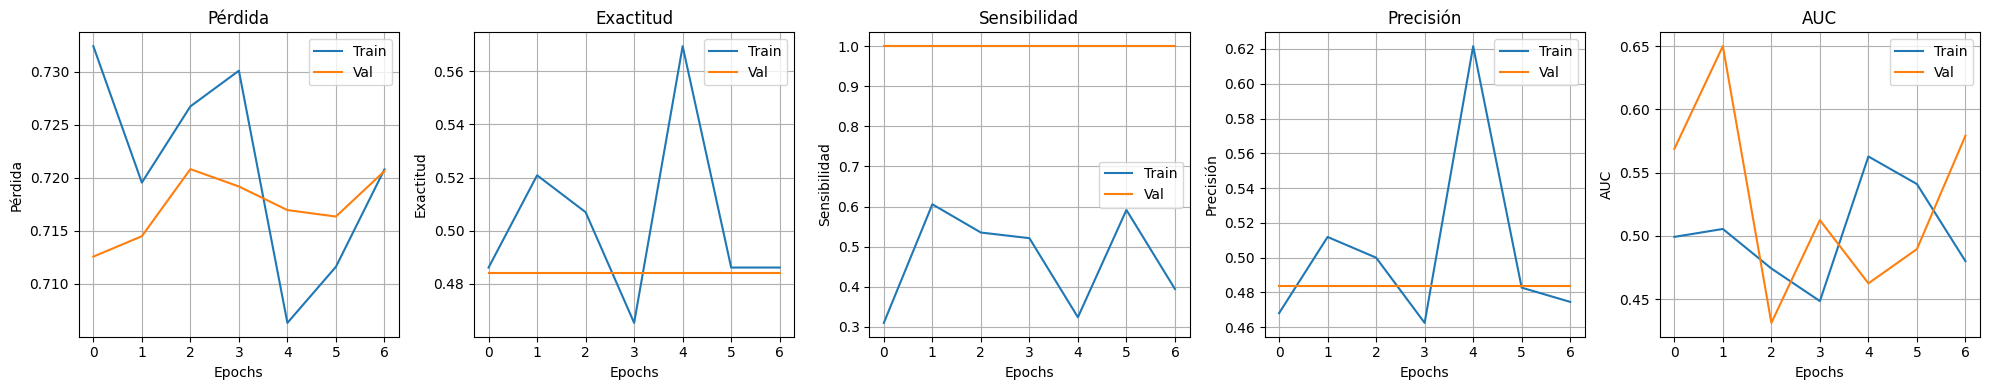

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step

Métricas de evaluación:
Exactitud: 0.5000
Precisión: 0.5000
Sensibilidad: 1.0000
Especificidad: 0.0000
Puntuación F1: 0.6667
Área bajo la curva: 0.4062



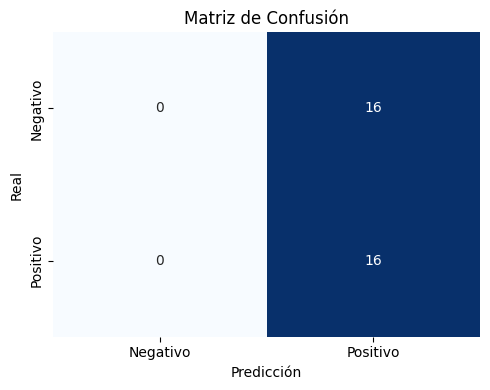

In [ ]:
p.plot_training(cnn_gru_augmented_model_history)
p.model_metrics(cnn_gru_augmented_model, X_test, y_test)

In [ ]:
models_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models"

cnn_gru_augmented_model.save_weights('/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models/CNN_GRU_AUGMENTED.weights.h5')

with open(os.path.join(models_dir, "CNN_GRU_AUGMENTED_history.pkl"), "wb") as f:
    pickle.dump(cnn_gru_augmented_model_history.history, f)

## 4.2 - Modelado con *transfer learning*.

Como se ha comentado anteriormente, la metodología de este apartado se basa en el estudio de Krishnapriya y Karuna (2023), en el que se implementan distintos modelos de redes neuronales convolucionales (CNN) preentrenados sobre imágenes de resonancia magnética. Los modelos utilizados en su estudio son VGG-19, VGG-16, ResNet50 e Inception V3.

En el presente proyecto se han implementado los mismos modelos preentrenados, a excepción de Inception V3, que ha sido sustituido por MobileNetV2. Esta decisión se debe a que MobileNetV2 es un modelo más ligero, lo que resulta especialmente útil en un contexto con recursos computacionales limitados y un conjunto de datos reducido.

Existen diferentes estrategias de *transfer learning* en términos de cómo se transfieren las capas (directamente, ajustadas o reinicializadas) (Ardalan y Subbian, 2022). En el presente estudio se sigue la metodología de Krishnapriya y Karuna (2023) la cual consiste en congelar todas las capas convolucionales y entrenar con los nuevos datos la capa completamente conectada.


### 4.2.1 - Preparación de los datos.

In [ ]:
base_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)"
data_dir = os.path.join(base_dir, "data/raw")
mask_dir = os.path.join(base_dir, "data/preprocessed/masks")
metadata_path = os.path.join(base_dir, "data/participants.tsv")
output_dir = os.path.join(base_dir, "data/splits")
output_X_path = os.path.join(output_dir, "X_tl.npy")
output_y_path = os.path.join(output_dir, "y_tl.npy")
output_ids_path = os.path.join(base_dir, "data/splits/subject_ids_tl.npy")

In [ ]:
def resize_slice(slice_2d, target_size=(224, 224)):
    """
    Redimensiona una imagen 2D a un tamaño objetivo especificado.

    Esta función se utiliza para ajustar el tamaño de los cortes fMRI 2D a un formato compatible
    con los modelos preentrenados, que requieren una entrada de dimensiones fijas.

    Parameters
    ----------
    slice_2d : np.ndarray
        Imagen 2D que representa un corte de resonancia magnética.
    target_size : tuple of int, optional
        Tamaño objetivo (alto, ancho) al que se redimensionará la imagen. Por defecto (224, 224).

    Returns
    -------
    resized_slice : np.ndarray
        Imagen 2D redimensionada con las nuevas dimensiones especificadas.
    """
    resized_slice = cv2.resize(slice_2d, target_size, interpolation=cv2.INTER_LINEAR)
    return resized_slice

In [ ]:
def to_rgb_channels(slice_2d):
    """
    Convierte una imagen 2D en escala de grises a una imagen RGB replicando los canales.

    Esta función se utiliza para adaptar imágenes 2D a modelos preentrenados en datasets RGB,
    como ImageNet, que esperan una entrada con tres canales.

    Parameters
    ----------
    slice_2d : np.ndarray
        Imagen 2D en escala de grises con forma (H, W).

    Returns
    -------
    slice_rgb : np.ndarray
        Imagen RGB con forma (H, W, 3), donde cada canal contiene la misma información que la imagen original.
    """
    slice_rgb = np.repeat(slice_2d[..., np.newaxis], 3, axis=-1)
    return slice_rgb

In [ ]:
def prepare_transfer_learning_data(
    data_dir,
    mask_dir,
    metadata_path,
    output_X_path,
    output_y_path,
    output_ids_path,
    discard_volumes=5,
    target_size=(224, 224),
    control_aug=5,
    depressed_aug=2
):
    """
    Preprocesa y transforma datos fMRI en secuencias RGB 2D adaptadas a modelos preentrenados.

    A partir de cada volumen fMRI, se selecciona el corte 2D con mayor varianza, se aplican transformaciones
    de data augmentation y normalización, y se adaptan las imágenes al formato RGB con el tamaño requerido
    por modelos preentrenados (como VGG o MobileNet). Se generan múltiples secuencias por sujeto, dependiendo
    de la clase (control o deprimido), y se guardan los arrays procesados.

    Parameters
    ----------
    data_dir : str
        Ruta al directorio que contiene los archivos fMRI en formato `.nii.gz`.
    mask_dir : str
        Ruta al directorio con las máscaras cerebrales en `.npy`.
    metadata_path : str
        Ruta al archivo `.tsv` que contiene los metadatos y etiquetas por sujeto.
    output_X_path : str
        Ruta para guardar el array `X_tl` con las secuencias preprocesadas.
    output_y_path : str
        Ruta para guardar el array `y_tl` con las etiquetas binarias.
    output_ids_path : str
        Ruta para guardar la lista `subject_ids_tl` con los IDs de los sujetos.
    discard_volumes : int, optional
        Número de primeros volúmenes a eliminar por ruido (por defecto 5).
    target_size : tuple, optional
        Tamaño objetivo de cada imagen 2D para redimensionado (por defecto (224, 224)).
    control_aug : int, optional
        Número de secuencias aumentadas por sujeto control (por defecto 5).
    depressed_aug : int, optional
        Número de secuencias aumentadas por sujeto deprimido (por defecto 2).

    Returns
    -------
    X_tl : np.ndarray
        Array con las secuencias RGB preprocesadas, con forma (N, T, H, W, 3).
    y_tl : np.ndarray
        Array con las etiquetas correspondientes (0 = control, 1 = deprimido).
    subject_ids_tl : list of str
        Lista con los IDs de sujeto asociados a cada muestra generada.
    """
    df_meta = pd.read_csv(metadata_path, sep='\t', index_col='participant_id')
    X_tl = []
    y_tl = []
    subject_ids_tl = []

    for file in tqdm(sorted(os.listdir(data_dir))):
        if not file.endswith(".nii.gz"):
            continue

        subject_id = file.split("_")[0]
        nii_path = os.path.join(data_dir, file)
        mask_path = os.path.join(mask_dir, f"{subject_id}_mask.npy")

        if subject_id not in df_meta.index or not os.path.exists(mask_path):
            continue

        label_str = df_meta.loc[subject_id, 'group']
        label = 0 if label_str == 'control' else 1
        n_aug = control_aug if label == 0 else depressed_aug

        img = nib.load(nii_path)
        data = img.get_fdata()
        if data.shape[3] <= discard_volumes:
            continue
        data_cut = data[..., discard_volumes:]

        mask = np.load(mask_path)
        masked_data = data_cut[mask].T
        volume_4d = p.reconstruct_volume(masked_data, mask)

        best_z = p.select_high_variance_slice(volume_4d)
        slice_volume = volume_4d[:, :, best_z, :]

        for _ in range(n_aug):
            augmented = apply_augmentations_2d(slice_volume)

            sequence_slices = []
            for t in range(augmented.shape[2]):
                slice_2d = augmented[:, :, t]
                norm_slice = p.normalize_zscore_2d(slice_2d)
                resized = resize_slice(norm_slice, target_size)
                rgb = to_rgb_channels(resized)
                sequence_slices.append(rgb)

            sequence_array = np.stack(sequence_slices, axis=0)

            X_tl.append(sequence_array)
            y_tl.append(label)
            subject_ids_tl.append(subject_id)

    X_tl = np.array(X_tl, dtype=np.float32)
    y_tl = np.array(y_tl, dtype=np.float32)

    np.save(output_X_path, X_tl)
    np.save(output_y_path, y_tl)
    np.save(output_ids_path, subject_ids_tl)
    return X_tl, y_tl, subject_ids_tl

In [ ]:
X_tl, y_tl, ids_tl = prepare_transfer_learning_data(
    data_dir=data_dir,
    mask_dir=mask_dir,
    metadata_path=metadata_path,
    output_X_path=output_X_path,
    output_y_path=output_y_path,
    output_ids_path=output_ids_path,
    discard_volumes=5,
    target_size=(224, 224),
    control_aug=5,
    depressed_aug=2
)

100%|██████████| 72/72 [01:13<00:00,  1.01s/it]


### 4.2.2 - Creación de conjuntos de entrenamiento y validación.

In [ ]:
X = np.load(os.path.join(base_dir, "data/splits/X_tl.npy"))
y = np.load(os.path.join(base_dir, "data/splits/y_tl.npy"))

In [ ]:
print(f"X shape: {X.shape}, dtype: {X.dtype}")
print(f"y shape: {y.shape}, dtype: {y.dtype}")

X shape: (207, 95, 224, 224, 3), dtype: float32
y shape: (207,), dtype: float32


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

In [ ]:
np.save(os.path.join(output_dir, "X_train_tl.npy"), X_train)
np.save(os.path.join(output_dir, "y_train_tl.npy"), y_train)
np.save(os.path.join(output_dir, "X_val_tl.npy"), X_val)
np.save(os.path.join(output_dir, "y_val_tl.npy"), y_val)
np.save(os.path.join(output_dir, "X_test_tl.npy"), X_test)
np.save(os.path.join(output_dir, "y_test_tl.npy"), y_test)

In [ ]:
input_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/data/splits/"

X_train = np.load(os.path.join(input_dir, "X_train_tl.npy"))
y_train = np.load(os.path.join(input_dir, "y_train_tl.npy"))
X_val = np.load(os.path.join(input_dir, "X_val_tl.npy"))
y_val = np.load(os.path.join(input_dir, "y_val_tl.npy"))
X_test = np.load(os.path.join(input_dir, "X_test_tl.npy"))
y_test = np.load(os.path.join(input_dir, "y_test_tl.npy"))

In [ ]:
print(f"Train: X={X_train.shape}, y={y_train.shape}, Controles={(y_train==0).sum()}, Deprimidos={(y_train==1).sum()}")
print(f"Val: X={X_val.shape}, y={y_val.shape}, Controles={(y_val==0).sum()}, Deprimidos={(y_val==1).sum()}")
print(f"Test: X={X_test.shape}, y={y_test.shape}, Controles={(y_test==0).sum()}, Deprimidos={(y_test==1).sum()}")

Train: X=(144, 95, 224, 224, 3), y=(144,), Controles=73, Deprimidos=71
Val: X=(31, 95, 224, 224, 3), y=(31,), Controles=16, Deprimidos=15
Test: X=(32, 95, 224, 224, 3), y=(32,), Controles=16, Deprimidos=16


In [ ]:
train_ds = p.create_dataset(X_train, y_train, batch_size=2, shuffle=True)
val_ds = p.create_dataset(X_val, y_val, batch_size=2)
test_ds = p.create_dataset(X_test, y_test, batch_size=2)

### 4.2.3 - Generación e implementación de modelos con *transfer learning*.

#### 4.2.3.1 - Modelo preentrenado con VGG-19.

In [ ]:
@register_keras_serializable()
class VGG19_GRU(tf.keras.Model):
    """
    Modelo híbrido basado en VGG19 y GRU para la clasificación binaria de secuencias fMRI 2D.

    La arquitectura utiliza VGG19 preentrenado sobre ImageNet como extractor de características espaciales,
    aplicando este bloque convolucional a cada frame temporal mediante `TimeDistributed`. A continuación, se
    utiliza una capa GRU para modelar la secuencia temporal. Se añaden capas densas y dropout para mejorar la
    capacidad de generalización del modelo.

    Parameters
    ----------
    input_shape : tuple, optional
        Forma de entrada esperada, sin incluir el batch. Por defecto (95, 224, 224, 3), donde:
            - 95 es el número de pasos temporales,
            - 224x224 el tamaño de las imágenes (tras redimensionado),
            - 3 canales para compatibilidad con modelos preentrenados en RGB.
    num_classes : int, optional
        Número de clases de salida. Por defecto 1 (clasificación binaria).
    gru_units : int, optional
        Número de unidades en la capa GRU. Por defecto 64.
    dropout_rate : float, optional
        Tasa de dropout aplicada tras la capa densa. Por defecto 0.5.

    Returns
    -------
    tf.Tensor
        Salida del modelo. Tensor con probabilidades por clase. En clasificación binaria, tiene forma (batch_size, 1).
    """
    def __init__(self, input_shape=(95, 224, 224, 3), num_classes=1, gru_units=64, dropout_rate=0.5):
        super(VGG19_GRU, self).__init__()
        l2 = regularizers.l2(1e-4)

        base_cnn = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_cnn.trainable = False

        self.feature_extractor = tf.keras.Sequential([
            base_cnn,
            layers.GlobalAveragePooling2D()
        ])

        self.td_extractor = layers.TimeDistributed(self.feature_extractor)

        self.gru = layers.GRU(gru_units, return_sequences=False)

        self.dense = layers.Dense(64, activation='relu', kernel_regularizer=l2)
        self.dropout = layers.Dropout(dropout_rate)
        self.out = layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')

    def call(self, inputs, training=False):
        x = self.td_extractor(inputs)
        x = self.gru(x)
        x = self.dense(x)
        if training:
            x = self.dropout(x, training=training)
        return self.out(x)

In [ ]:
vgg19_gru_model = VGG19_GRU(input_shape=X_train.shape[1:])

vgg19_gru_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
tracker = EmissionsTracker()
tracker.start()
start = time.time()

vgg19_gru_model_history = vgg19_gru_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)

end = time.time()
emissions = tracker.stop()
print(f"\nTiempo de entrenamiento: {(end - start):.2f} segundos")
print(f"\nEmisiones estimadas: {emissions:.4f} kg de CO2")

[codecarbon WARNING @ 17:04:52] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:04:52] [setup] RAM Tracking...
[codecarbon INFO @ 17:04:52] [setup] CPU Tracking...
[codecarbon WARNING @ 17:04:53] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 17:04:53] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 17:04:53] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 17:04:53] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:04:53] [setup] GPU Tracking...
[codecarbon INFO @ 17:04:53] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:04:53] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/30


[codecarbon INFO @ 17:05:03] Energy consumed for RAM : 0.001266 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:05:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:05:03] Energy consumed for All CPU : 0.001416 kWh
[codecarbon INFO @ 17:05:03] Energy consumed for all GPUs : 0.001720 kWh. Total GPU Power : 51.63728602976813 W
[codecarbon INFO @ 17:05:03] 0.004403 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:05:03] 0.016602 g.CO2eq/s mean an estimation of 523.5580344193693 kg.CO2eq/year
[codecarbon INFO @ 17:05:08] Energy consumed for RAM : 0.000158 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:05:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:05:08] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 17:05:08] Energy consumed for all GPUs : 0.000215 kWh. Total GPU Power : 51.57624877291426 W
[codecarbon INFO @ 17:05:08] 0.000551 kWh of electricity used s

 5/72 ━━━━━━━━━━━━━━━━━━━━ 17s 254ms/step - accuracy: 0.5300 - auc: 0.3443 - loss: 0.8156 - precision: 0.3657 - recall: 0.8000

[codecarbon INFO @ 17:06:08] Energy consumed for RAM : 0.000790 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:06:08] Delta energy consumed for CPU with constant : 0.000175 kWh, power : 42.5 W
[codecarbon INFO @ 17:06:08] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 17:06:08] Energy consumed for all GPUs : 0.001146 kWh. Total GPU Power : 69.4910949993197 W
[codecarbon INFO @ 17:06:08] 0.002821 kWh of electricity used since the beginning.


46/72 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.4568 - auc: 0.4692 - loss: 0.7679 - precision: 0.4060 - recall: 0.7657

[codecarbon INFO @ 17:06:18] Energy consumed for RAM : 0.002057 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:06:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:06:18] Energy consumed for All CPU : 0.002301 kWh
[codecarbon INFO @ 17:06:18] Energy consumed for all GPUs : 0.003441 kWh. Total GPU Power : 207.34551330271753 W
[codecarbon INFO @ 17:06:18] 0.007799 kWh of electricity used since the beginning.


67/72 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.4452 - auc: 0.4514 - loss: 0.7658 - precision: 0.4144 - recall: 0.7067

[codecarbon INFO @ 17:06:23] Energy consumed for RAM : 0.000948 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:06:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:06:23] Energy consumed for All CPU : 0.001062 kWh
[codecarbon INFO @ 17:06:23] Energy consumed for all GPUs : 0.002227 kWh. Total GPU Power : 259.60074820920175 W
[codecarbon INFO @ 17:06:23] 0.004237 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.4433 - auc: 0.4490 - loss: 0.7652 - precision: 0.4158 - recall: 0.6976

[codecarbon INFO @ 17:06:33] Energy consumed for RAM : 0.002215 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:06:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:06:33] Energy consumed for All CPU : 0.002478 kWh
[codecarbon INFO @ 17:06:33] Energy consumed for all GPUs : 0.004030 kWh. Total GPU Power : 141.22563087182698 W
[codecarbon INFO @ 17:06:33] 0.008723 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:06:38] Energy consumed for RAM : 0.001106 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:06:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:06:38] Energy consumed for All CPU : 0.001239 kWh
[codecarbon INFO @ 17:06:38] Energy consumed for all GPUs : 0.002527 kWh. Total GPU Power : 71.99342743344575 W
[codecarbon INFO @ 17:06:38] 0.004873 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 560ms/step - accuracy: 0.4430 - auc: 0.4485 - loss: 0.7651 - precision: 0.4160 - recall: 0.6960 - val_accuracy: 0.4839 - val_auc: 0.5979 - val_loss: 0.6999 - val_precision: 0.4839 - val_recall: 1.0000
Epoch 2/30
 5/72 ━━━━━━━━━━━━━━━━━━━━ 16s 240ms/step - accuracy: 0.6283 - auc: 0.3095 - loss: 0.7187 - precision: 0.5295 - recall: 0.7029

[codecarbon INFO @ 17:06:48] Energy consumed for RAM : 0.002373 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:06:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:06:48] Energy consumed for All CPU : 0.002655 kWh
[codecarbon INFO @ 17:06:48] Energy consumed for all GPUs : 0.004534 kWh. Total GPU Power : 121.31394395373773 W
[codecarbon INFO @ 17:06:48] 0.009563 kWh of electricity used since the beginning.


26/72 ━━━━━━━━━━━━━━━━━━━━ 11s 241ms/step - accuracy: 0.4695 - auc: 0.2829 - loss: 0.7618 - precision: 0.5041 - recall: 0.6685

[codecarbon INFO @ 17:06:53] Energy consumed for RAM : 0.001265 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:06:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:06:53] Energy consumed for All CPU : 0.001416 kWh
[codecarbon INFO @ 17:06:53] Energy consumed for all GPUs : 0.003323 kWh. Total GPU Power : 191.05292147309441 W
[codecarbon INFO @ 17:06:53] 0.006004 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:06:53] 0.022642 g.CO2eq/s mean an estimation of 714.0453989090223 kg.CO2eq/year


67/72 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.4699 - auc: 0.3677 - loss: 0.7468 - precision: 0.4963 - recall: 0.6979

[codecarbon INFO @ 17:07:03] Energy consumed for RAM : 0.002532 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:07:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:07:03] Energy consumed for All CPU : 0.002832 kWh
[codecarbon INFO @ 17:07:03] Energy consumed for all GPUs : 0.005632 kWh. Total GPU Power : 263.5724719697055 W
[codecarbon INFO @ 17:07:03] 0.010996 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:07:03] 0.024872 g.CO2eq/s mean an estimation of 784.3621487526539 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 293ms/step - accuracy: 0.4689 - auc: 0.3745 - loss: 0.7454 - precision: 0.4939 - recall: 0.6941 - val_accuracy: 0.5806 - val_auc: 0.6250 - val_loss: 0.6966 - val_precision: 0.5385 - val_recall: 0.9333
Epoch 3/30
 1/72 ━━━━━━━━━━━━━━━━━━━━ 17s 242ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.8194 - precision: 0.0000e+00 - recall: 0.0000e+00

[codecarbon INFO @ 17:07:08] Energy consumed for RAM : 0.001423 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:07:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:07:08] Energy consumed for All CPU : 0.001593 kWh
[codecarbon INFO @ 17:07:08] Energy consumed for all GPUs : 0.004429 kWh. Total GPU Power : 265.55287927851174 W
[codecarbon INFO @ 17:07:08] 0.007445 kWh of electricity used since the beginning.


42/72 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - accuracy: 0.5124 - auc: 0.5015 - loss: 0.7014 - precision: 0.4920 - recall: 0.4830

[codecarbon INFO @ 17:07:18] Energy consumed for RAM : 0.002690 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:07:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:07:18] Energy consumed for All CPU : 0.003009 kWh
[codecarbon INFO @ 17:07:18] Energy consumed for all GPUs : 0.006764 kWh. Total GPU Power : 271.63675254648354 W
[codecarbon INFO @ 17:07:18] 0.012463 kWh of electricity used since the beginning.


63/72 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.5133 - auc: 0.5139 - loss: 0.6999 - precision: 0.4942 - recall: 0.4708

[codecarbon INFO @ 17:07:23] Energy consumed for RAM : 0.001581 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:07:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:07:23] Energy consumed for All CPU : 0.001770 kWh
[codecarbon INFO @ 17:07:23] Energy consumed for all GPUs : 0.005568 kWh. Total GPU Power : 273.28508397376345 W
[codecarbon INFO @ 17:07:23] 0.008919 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 292ms/step - accuracy: 0.5096 - auc: 0.5133 - loss: 0.7006 - precision: 0.4931 - recall: 0.4633 - val_accuracy: 0.5161 - val_auc: 0.5229 - val_loss: 0.6996 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/30
17/72 ━━━━━━━━━━━━━━━━━━━━ 13s 241ms/step - accuracy: 0.3057 - auc: 0.2648 - loss: 0.7744 - precision: 0.3478 - recall: 0.3703

[codecarbon INFO @ 17:07:33] Energy consumed for RAM : 0.002848 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:07:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:07:33] Energy consumed for All CPU : 0.003186 kWh
[codecarbon INFO @ 17:07:33] Energy consumed for all GPUs : 0.007899 kWh. Total GPU Power : 272.4378841319141 W
[codecarbon INFO @ 17:07:33] 0.013933 kWh of electricity used since the beginning.


38/72 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.3951 - auc: 0.3750 - loss: 0.7439 - precision: 0.4317 - recall: 0.4740

[codecarbon INFO @ 17:07:38] Energy consumed for RAM : 0.001739 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:07:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:07:38] Energy consumed for All CPU : 0.001947 kWh
[codecarbon INFO @ 17:07:38] Energy consumed for all GPUs : 0.006704 kWh. Total GPU Power : 272.7338357976812 W
[codecarbon INFO @ 17:07:38] 0.010391 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.4217 - auc: 0.4034 - loss: 0.7365 - precision: 0.4454 - recall: 0.5082

[codecarbon INFO @ 17:07:48] Energy consumed for RAM : 0.003007 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:07:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:07:48] Energy consumed for All CPU : 0.003363 kWh
[codecarbon INFO @ 17:07:48] Energy consumed for all GPUs : 0.009039 kWh. Total GPU Power : 273.68983157126604 W
[codecarbon INFO @ 17:07:48] 0.015409 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 293ms/step - accuracy: 0.4225 - auc: 0.4044 - loss: 0.7362 - precision: 0.4459 - recall: 0.5083 - val_accuracy: 0.5161 - val_auc: 0.5146 - val_loss: 0.6979 - val_precision: 0.5000 - val_recall: 0.9333
Epoch 5/30
13/72 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.3716 - auc: 0.1755 - loss: 0.7680 - precision: 0.0930 - recall: 0.0974

[codecarbon INFO @ 17:07:53] Energy consumed for RAM : 0.001898 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:07:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:07:53] Energy consumed for All CPU : 0.002124 kWh
[codecarbon INFO @ 17:07:53] Energy consumed for all GPUs : 0.007847 kWh. Total GPU Power : 274.48478685941546 W
[codecarbon INFO @ 17:07:53] 0.011869 kWh of electricity used since the beginning.


54/72 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.4255 - auc: 0.3249 - loss: 0.7393 - precision: 0.2344 - recall: 0.1980

[codecarbon INFO @ 17:08:03] Energy consumed for RAM : 0.003165 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:08:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:08:03] Energy consumed for All CPU : 0.003540 kWh
[codecarbon INFO @ 17:08:03] Energy consumed for all GPUs : 0.010187 kWh. Total GPU Power : 275.5972822356492 W
[codecarbon INFO @ 17:08:03] 0.016892 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.4313 - auc: 0.3518 - loss: 0.7361 - precision: 0.2677 - recall: 0.2153

[codecarbon INFO @ 17:08:08] Energy consumed for RAM : 0.002056 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:08:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:08:08] Energy consumed for All CPU : 0.002301 kWh
[codecarbon INFO @ 17:08:08] Energy consumed for all GPUs : 0.008992 kWh. Total GPU Power : 274.8240450865371 W
[codecarbon INFO @ 17:08:08] 0.013350 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 294ms/step - accuracy: 0.4316 - auc: 0.3533 - loss: 0.7359 - precision: 0.2700 - recall: 0.2168 - val_accuracy: 0.4839 - val_auc: 0.5208 - val_loss: 0.6988 - val_precision: 0.4839 - val_recall: 1.0000
Epoch 6/30
29/72 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.5337 - auc: 0.5984 - loss: 0.7004 - precision: 0.4855 - recall: 0.7812

[codecarbon INFO @ 17:08:18] Energy consumed for RAM : 0.003323 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:08:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:08:18] Energy consumed for All CPU : 0.003717 kWh
[codecarbon INFO @ 17:08:18] Energy consumed for all GPUs : 0.011333 kWh. Total GPU Power : 275.0055448315421 W
[codecarbon INFO @ 17:08:18] 0.018373 kWh of electricity used since the beginning.


50/72 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.5408 - auc: 0.6065 - loss: 0.6931 - precision: 0.5087 - recall: 0.7716

[codecarbon INFO @ 17:08:23] Energy consumed for RAM : 0.002214 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:08:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:08:23] Energy consumed for All CPU : 0.002478 kWh
[codecarbon INFO @ 17:08:23] Energy consumed for all GPUs : 0.010142 kWh. Total GPU Power : 275.9377013999731 W
[codecarbon INFO @ 17:08:23] 0.014834 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 294ms/step - accuracy: 0.5408 - auc: 0.5982 - loss: 0.6933 - precision: 0.5137 - recall: 0.7472 - val_accuracy: 0.5806 - val_auc: 0.6521 - val_loss: 0.6954 - val_precision: 0.6667 - val_recall: 0.2667
Epoch 7/30
 3/72 ━━━━━━━━━━━━━━━━━━━━ 16s 243ms/step - accuracy: 0.3611 - auc: 0.2444 - loss: 0.7611 - precision: 0.3333 - recall: 0.0667        

[codecarbon INFO @ 17:08:33] Energy consumed for RAM : 0.003481 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:08:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:08:33] Energy consumed for All CPU : 0.003894 kWh
[codecarbon INFO @ 17:08:33] Energy consumed for all GPUs : 0.012477 kWh. Total GPU Power : 274.60959978579535 W
[codecarbon INFO @ 17:08:33] 0.019852 kWh of electricity used since the beginning.


24/72 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - accuracy: 0.4451 - auc: 0.4227 - loss: 0.7149 - precision: 0.6321 - recall: 0.4304

[codecarbon INFO @ 17:08:38] Energy consumed for RAM : 0.002373 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:08:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:08:38] Energy consumed for All CPU : 0.002655 kWh
[codecarbon INFO @ 17:08:38] Energy consumed for all GPUs : 0.011285 kWh. Total GPU Power : 274.28644263776846 W
[codecarbon INFO @ 17:08:38] 0.016312 kWh of electricity used since the beginning.


65/72 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.5030 - auc: 0.5182 - loss: 0.6953 - precision: 0.5650 - recall: 0.5312

[codecarbon INFO @ 17:08:48] Energy consumed for RAM : 0.003640 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:08:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:08:48] Energy consumed for All CPU : 0.004071 kWh
[codecarbon INFO @ 17:08:48] Energy consumed for all GPUs : 0.013627 kWh. Total GPU Power : 276.05407954051265 W
[codecarbon INFO @ 17:08:48] 0.021338 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.5075 - auc: 0.5243 - loss: 0.6940 - precision: 0.5621 - recall: 0.5280

[codecarbon INFO @ 17:08:53] Energy consumed for RAM : 0.002531 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:08:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:08:53] Energy consumed for All CPU : 0.002832 kWh
[codecarbon INFO @ 17:08:53] Energy consumed for all GPUs : 0.012439 kWh. Total GPU Power : 277.1737582445343 W
[codecarbon INFO @ 17:08:53] 0.017803 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:08:53] 0.044502 g.CO2eq/s mean an estimation of 1,403.4030826542103 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 295ms/step - accuracy: 0.5079 - auc: 0.5250 - loss: 0.6938 - precision: 0.5618 - recall: 0.5274 - val_accuracy: 0.5161 - val_auc: 0.7250 - val_loss: 0.6924 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 8/30
40/72 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - accuracy: 0.5430 - auc: 0.5778 - loss: 0.6946 - precision: 0.4986 - recall: 0.4076

[codecarbon INFO @ 17:09:03] Energy consumed for RAM : 0.003798 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:09:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:09:03] Energy consumed for All CPU : 0.004248 kWh
[codecarbon INFO @ 17:09:03] Energy consumed for all GPUs : 0.014769 kWh. Total GPU Power : 274.24020092713226 W
[codecarbon INFO @ 17:09:03] 0.022816 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:09:03] 0.044580 g.CO2eq/s mean an estimation of 1,405.875512502967 kg.CO2eq/year


60/72 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.5468 - auc: 0.5808 - loss: 0.6934 - precision: 0.5237 - recall: 0.4758

[codecarbon INFO @ 17:09:08] Energy consumed for RAM : 0.002689 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:09:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:09:08] Energy consumed for All CPU : 0.003009 kWh
[codecarbon INFO @ 17:09:08] Energy consumed for all GPUs : 0.013577 kWh. Total GPU Power : 273.0336945974185 W
[codecarbon INFO @ 17:09:08] 0.019275 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 295ms/step - accuracy: 0.5450 - auc: 0.5774 - loss: 0.6940 - precision: 0.5230 - recall: 0.4975 - val_accuracy: 0.5161 - val_auc: 0.7000 - val_loss: 0.6928 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 9/30
14/72 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step - accuracy: 0.6325 - auc: 0.6321 - loss: 0.7149 - precision: 0.9129 - recall: 0.4130

[codecarbon INFO @ 17:09:18] Energy consumed for RAM : 0.003956 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:09:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:09:18] Energy consumed for All CPU : 0.004425 kWh
[codecarbon INFO @ 17:09:18] Energy consumed for all GPUs : 0.015915 kWh. Total GPU Power : 274.92768939896814 W
[codecarbon INFO @ 17:09:18] 0.024296 kWh of electricity used since the beginning.


35/72 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - accuracy: 0.6075 - auc: 0.5907 - loss: 0.6974 - precision: 0.6724 - recall: 0.3498

[codecarbon INFO @ 17:09:23] Energy consumed for RAM : 0.002847 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:09:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:09:23] Energy consumed for All CPU : 0.003186 kWh
[codecarbon INFO @ 17:09:23] Energy consumed for all GPUs : 0.014722 kWh. Total GPU Power : 274.9056851010819 W
[codecarbon INFO @ 17:09:23] 0.020756 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.5844 - auc: 0.5630 - loss: 0.6957 - precision: 0.6025 - recall: 0.3174

[codecarbon INFO @ 17:09:33] Energy consumed for RAM : 0.004114 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:09:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:09:33] Energy consumed for All CPU : 0.004602 kWh
[codecarbon INFO @ 17:09:33] Energy consumed for all GPUs : 0.017075 kWh. Total GPU Power : 278.4581178803312 W
[codecarbon INFO @ 17:09:33] 0.025791 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 294ms/step - accuracy: 0.5838 - auc: 0.5625 - loss: 0.6958 - precision: 0.6018 - recall: 0.3173 - val_accuracy: 0.4839 - val_auc: 0.6708 - val_loss: 0.6935 - val_precision: 0.4828 - val_recall: 0.9333
Epoch 10/30
10/72 ━━━━━━━━━━━━━━━━━━━━ 15s 242ms/step - accuracy: 0.7691 - auc: 0.7165 - loss: 0.6240 - precision: 0.6584 - recall: 0.7964

[codecarbon INFO @ 17:09:38] Energy consumed for RAM : 0.003006 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:09:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:09:38] Energy consumed for All CPU : 0.003363 kWh
[codecarbon INFO @ 17:09:38] Energy consumed for all GPUs : 0.015883 kWh. Total GPU Power : 278.62835123057187 W
[codecarbon INFO @ 17:09:38] 0.022252 kWh of electricity used since the beginning.


51/72 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.5704 - auc: 0.5788 - loss: 0.6803 - precision: 0.5500 - recall: 0.7324

[codecarbon INFO @ 17:09:48] Energy consumed for RAM : 0.004273 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:09:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:09:48] Energy consumed for All CPU : 0.004779 kWh
[codecarbon INFO @ 17:09:48] Energy consumed for all GPUs : 0.018223 kWh. Total GPU Power : 275.66086074098604 W
[codecarbon INFO @ 17:09:48] 0.027275 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.5495 - auc: 0.5582 - loss: 0.6870 - precision: 0.5369 - recall: 0.7051

[codecarbon INFO @ 17:09:53] Energy consumed for RAM : 0.003164 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:09:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:09:53] Energy consumed for All CPU : 0.003540 kWh
[codecarbon INFO @ 17:09:53] Energy consumed for all GPUs : 0.017032 kWh. Total GPU Power : 275.9668813848599 W
[codecarbon INFO @ 17:09:53] 0.023737 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 293ms/step - accuracy: 0.5489 - auc: 0.5576 - loss: 0.6872 - precision: 0.5363 - recall: 0.7040 - val_accuracy: 0.5806 - val_auc: 0.7042 - val_loss: 0.6915 - val_precision: 1.0000 - val_recall: 0.1333
Epoch 11/30
26/72 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - accuracy: 0.6058 - auc: 0.6561 - loss: 0.6749 - precision: 0.7030 - recall: 0.5143

[codecarbon INFO @ 17:10:03] Energy consumed for RAM : 0.004431 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:10:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:10:03] Energy consumed for All CPU : 0.004956 kWh
[codecarbon INFO @ 17:10:03] Energy consumed for all GPUs : 0.019380 kWh. Total GPU Power : 277.7293812490311 W
[codecarbon INFO @ 17:10:03] 0.028767 kWh of electricity used since the beginning.


47/72 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.5944 - auc: 0.6183 - loss: 0.6797 - precision: 0.6168 - recall: 0.4965

[codecarbon INFO @ 17:10:08] Energy consumed for RAM : 0.003322 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:10:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:10:08] Energy consumed for All CPU : 0.003717 kWh
[codecarbon INFO @ 17:10:08] Energy consumed for all GPUs : 0.018193 kWh. Total GPU Power : 278.51986742687353 W
[codecarbon INFO @ 17:10:08] 0.025232 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 294ms/step - accuracy: 0.5724 - auc: 0.5788 - loss: 0.6912 - precision: 0.5787 - recall: 0.4644 - val_accuracy: 0.5806 - val_auc: 0.7271 - val_loss: 0.6910 - val_precision: 1.0000 - val_recall: 0.1333


[codecarbon INFO @ 17:10:18] Energy consumed for RAM : 0.003425 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:10:18] Delta energy consumed for CPU with constant : 0.000115 kWh, power : 42.5 W
[codecarbon INFO @ 17:10:18] Energy consumed for All CPU : 0.003832 kWh
[codecarbon INFO @ 17:10:18] Energy consumed for all GPUs : 0.018945 kWh. Total GPU Power : 278.28926695911605 W
[codecarbon INFO @ 17:10:18] 0.026203 kWh of electricity used since the beginning.



Tiempo de entrenamiento: 324.75 segundos

Emisiones estimadas: 0.0119 kg de CO2


In [ ]:
def model_metrics_dataset(modelo, dataset, umbral=0.5):
    """
    Evalúa un modelo binario sobre un `tf.data.Dataset` e imprime las métricas principales junto con la matriz de confusión.

    La función calcula métricas como exactitud, precisión, sensibilidad (recall), especificidad, F1-score y AUC.
    También muestra una matriz de confusión en forma de mapa de calor para visualizar el rendimiento del modelo
    en clasificación binaria.

    Parameters
    ----------
    modelo : tf.keras.Model
        Modelo ya entrenado que se desea evaluar.
    dataset : tf.data.Dataset
        Conjunto de datos sobre el que se realiza la evaluación, en forma de (X, y).
    umbral : float, optional
        Umbral de decisión para convertir probabilidades en predicciones binarias (por defecto 0.5).

    Returns
    -------
    None
        La función imprime las métricas en consola y muestra la matriz de confusión mediante matplotlib.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

    y_prob = modelo.predict(dataset).flatten()
    y_pred = (y_prob >= umbral).astype(int)

    y_true = np.concatenate([y for _, y in dataset], axis=0)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    exactitud = (tp + tn) / (tp + tn + fp + fn)
    precision = precision_score(y_true, y_pred)
    sensibilidad = recall_score(y_true, y_pred)
    especificidad = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    print("\nMétricas de evaluación:")
    print(f"Exactitud:     {exactitud:.4f}")
    print(f"Precisión:     {precision:.4f}")
    print(f"Sensibilidad:  {sensibilidad:.4f}")
    print(f"Especificidad: {especificidad:.4f}")
    print(f"F1-score:      {f1:.4f}")
    print(f"AUC:           {auc:.4f}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=["Negativo", "Positivo"],
                yticklabels=["Negativo", "Positivo"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.tight_layout()
    plt.show()

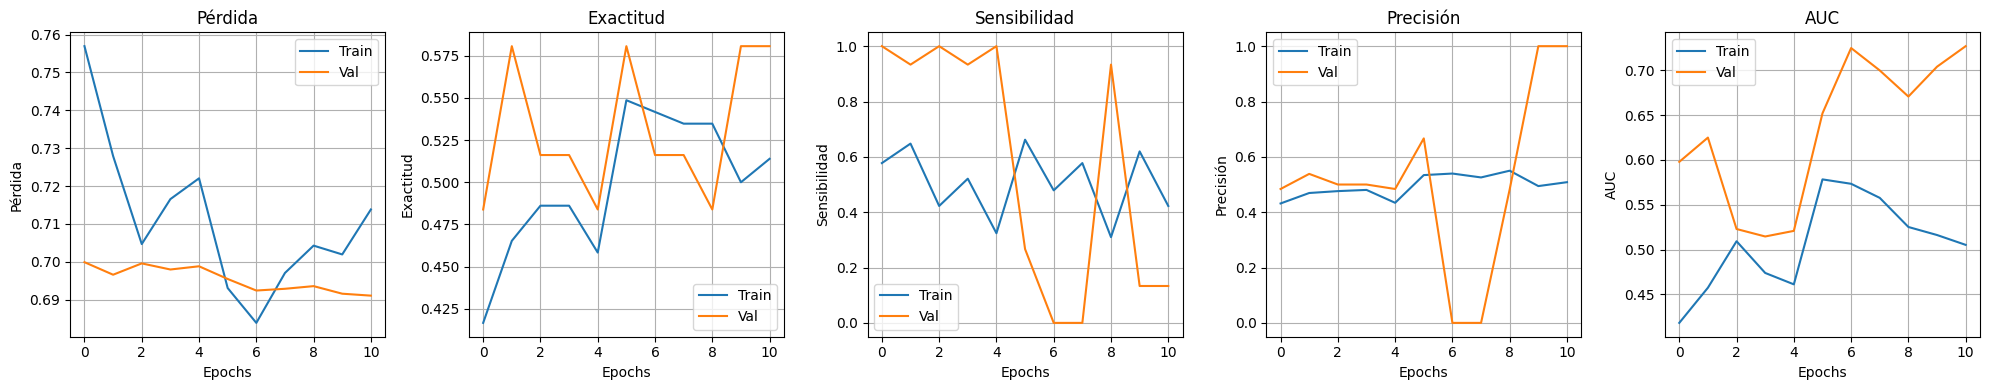

[codecarbon INFO @ 17:23:03] Energy consumed for RAM : 0.012662 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:23:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:23:03] Energy consumed for All CPU : 0.014163 kWh
[codecarbon INFO @ 17:23:04] Energy consumed for all GPUs : 0.032052 kWh. Total GPU Power : 53.52906017718373 W
[codecarbon INFO @ 17:23:04] 0.058877 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:23:04] 0.016821 g.CO2eq/s mean an estimation of 530.4531654421423 kg.CO2eq/year


16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step

Métricas de evaluación:
Exactitud:     0.5625
Precisión:     0.6667
Sensibilidad:  0.2500
Especificidad: 0.8750
F1-score:      0.3636
AUC:           0.6719


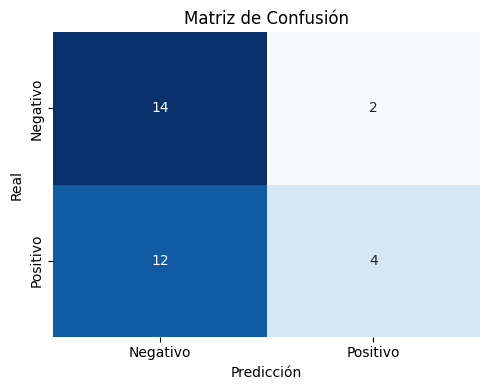

In [ ]:
p.plot_training(vgg19_gru_model_history)
model_metrics_dataset(vgg19_gru_model, test_ds)

In [ ]:
models_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models"

vgg19_gru_model.save_weights('/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models/VGG19_GRU.weights.h5')

with open(os.path.join(models_dir, "VGG19_GRU_history.pkl"), "wb") as f:
    pickle.dump(vgg19_gru_model_history.history, f)

#### 4.2.3.2 - Modelo preentrenado con VGG-16.

In [ ]:
@register_keras_serializable()
class VGG16_GRU(tf.keras.Model):
    """
    Modelo híbrido basado en VGG16 y GRU para la clasificación binaria de secuencias de imágenes fMRI 2D.

    La arquitectura utiliza VGG16 preentrenado sobre ImageNet como extractor de características espaciales,
    aplicando dicho extractor a cada frame temporal mediante `TimeDistributed`. Después, una capa GRU modela
    la secuencia temporal. Finalmente, se incluyen capas densas y dropout para realizar la clasificación.

    Parameters
    ----------
    input_shape : tuple, optional
        Forma esperada del tensor de entrada sin incluir el batch. Por defecto (95, 224, 224, 3), donde:
            - 95 representa los pasos temporales,
            - 224x224 es el tamaño de las imágenes tras redimensionado,
            - 3 canales (RGB) necesarios para compatibilidad con modelos preentrenados.
    num_classes : int, optional
        Número de clases de salida. Por defecto 1 (clasificación binaria).
    gru_units : int, optional
        Número de unidades en la capa GRU. Por defecto 64.
    dropout_rate : float, optional
        Tasa de dropout aplicada después de la capa densa. Por defecto 0.5.

    Returns
    -------
    tf.Tensor
        Salida del modelo. Tensor con probabilidades por clase. En clasificación binaria, tiene forma (batch_size, 1).
    """
    def __init__(self, input_shape=(95, 224, 224, 3), num_classes=1, gru_units=64, dropout_rate=0.5):
        super(VGG16_GRU, self).__init__()
        l2 = regularizers.l2(1e-4)

        base_cnn = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_cnn.trainable = False

        self.feature_extractor = tf.keras.Sequential([
            base_cnn,
            layers.GlobalAveragePooling2D()
        ])

        self.td_extractor = layers.TimeDistributed(self.feature_extractor)

        self.gru = layers.GRU(gru_units, return_sequences=False)

        self.dense = layers.Dense(64, activation='relu', kernel_regularizer=l2)
        self.dropout = layers.Dropout(dropout_rate)
        self.out = layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')

    def call(self, inputs, training=False):
        x = self.td_extractor(inputs)
        x = self.gru(x)
        x = self.dense(x)
        if training:
            x = self.dropout(x, training=training)
        return self.out(x)

In [ ]:
vgg16_gru_model = VGG16_GRU(input_shape=X_train.shape[1:])

vgg16_gru_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
tracker = EmissionsTracker()
tracker.start()
start = time.time()

vgg16_gru_model_history = vgg16_gru_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)

end = time.time()
emissions = tracker.stop()
print(f"\nTiempo de entrenamiento: {(end - start):.2f} segundos")
print(f"\nEmisiones estimadas: {emissions:.4f} kg de CO2")

[codecarbon WARNING @ 17:32:19] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:32:19] [setup] RAM Tracking...
[codecarbon INFO @ 17:32:19] [setup] CPU Tracking...
[codecarbon WARNING @ 17:32:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 17:32:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 17:32:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 17:32:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:32:20] [setup] GPU Tracking...
[codecarbon INFO @ 17:32:20] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:32:20] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/30


[codecarbon INFO @ 17:32:34] Energy consumed for RAM : 0.018677 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:32:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:34] Energy consumed for All CPU : 0.020890 kWh
[codecarbon INFO @ 17:32:34] Energy consumed for all GPUs : 0.040734 kWh. Total GPU Power : 53.58679043494237 W
[codecarbon INFO @ 17:32:34] 0.080301 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:32:35] Energy consumed for RAM : 0.000158 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:32:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:35] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 17:32:35] Energy consumed for all GPUs : 0.000223 kWh. Total GPU Power : 53.546971827868866 W
[codecarbon INFO @ 17:32:35] 0.000559 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:32:49] Energy consumed for RAM : 0.018835 kWh. RAM Power : 

17/72 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.4905 - auc: 0.4819 - loss: 0.7368 - precision: 0.5032 - recall: 0.7485

[codecarbon INFO @ 17:33:19] Energy consumed for RAM : 0.019151 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:33:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:19] Energy consumed for All CPU : 0.021421 kWh
[codecarbon INFO @ 17:33:19] Energy consumed for all GPUs : 0.041586 kWh. Total GPU Power : 98.05136533280583 W
[codecarbon INFO @ 17:33:19] 0.082158 kWh of electricity used since the beginning.


26/72 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.4662 - auc: 0.4625 - loss: 0.7544 - precision: 0.4803 - recall: 0.7519

[codecarbon INFO @ 17:33:20] Energy consumed for RAM : 0.000632 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:33:20] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:20] Energy consumed for All CPU : 0.000707 kWh
[codecarbon INFO @ 17:33:20] Energy consumed for all GPUs : 0.001178 kWh. Total GPU Power : 122.89365313538285 W
[codecarbon INFO @ 17:33:20] 0.002517 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.4290 - auc: 0.4536 - loss: 0.7610 - precision: 0.4313 - recall: 0.6420

[codecarbon INFO @ 17:33:34] Energy consumed for RAM : 0.019309 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:33:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:34] Energy consumed for All CPU : 0.021598 kWh
[codecarbon INFO @ 17:33:34] Energy consumed for all GPUs : 0.042450 kWh. Total GPU Power : 207.26913976520297 W
[codecarbon INFO @ 17:33:34] 0.083358 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:33:35] Energy consumed for RAM : 0.000790 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:33:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:35] Energy consumed for All CPU : 0.000884 kWh
[codecarbon INFO @ 17:33:35] Energy consumed for all GPUs : 0.001942 kWh. Total GPU Power : 183.27753114989738 W
[codecarbon INFO @ 17:33:35] 0.003616 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 87s 453ms/step - accuracy: 0.4289 - auc: 0.4533 - loss: 0.7609 - precision: 0.4312 - recall: 0.6403 - val_accuracy: 0.6452 - val_auc: 0.6833 - val_loss: 0.6904 - val_precision: 0.6429 - val_recall: 0.6000
Epoch 2/30
 5/72 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.4417 - auc: 0.3822 - loss: 0.7364 - precision: 0.4867 - recall: 0.5467

[codecarbon INFO @ 17:33:49] Energy consumed for RAM : 0.019467 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:33:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:49] Energy consumed for All CPU : 0.021775 kWh
[codecarbon INFO @ 17:33:49] Energy consumed for all GPUs : 0.042906 kWh. Total GPU Power : 109.50181188602245 W
[codecarbon INFO @ 17:33:49] 0.084148 kWh of electricity used since the beginning.


14/72 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.5468 - auc: 0.5091 - loss: 0.7062 - precision: 0.5959 - recall: 0.6233

[codecarbon INFO @ 17:33:50] Energy consumed for RAM : 0.000948 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:33:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:50] Energy consumed for All CPU : 0.001061 kWh
[codecarbon INFO @ 17:33:50] Energy consumed for all GPUs : 0.002502 kWh. Total GPU Power : 134.61863301361734 W
[codecarbon INFO @ 17:33:50] 0.004511 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5345 - auc: 0.5203 - loss: 0.7057 - precision: 0.5293 - recall: 0.6045

[codecarbon INFO @ 17:34:04] Energy consumed for RAM : 0.019626 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:34:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:04] Energy consumed for All CPU : 0.021952 kWh
[codecarbon INFO @ 17:34:04] Energy consumed for all GPUs : 0.043985 kWh. Total GPU Power : 258.9220228675223 W
[codecarbon INFO @ 17:34:04] 0.085562 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 248ms/step - accuracy: 0.5345 - auc: 0.5207 - loss: 0.7056 - precision: 0.5293 - recall: 0.6040 - val_accuracy: 0.6452 - val_auc: 0.6458 - val_loss: 0.6902 - val_precision: 0.8333 - val_recall: 0.3333
Epoch 3/30


[codecarbon INFO @ 17:34:05] Energy consumed for RAM : 0.001106 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:34:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:05] Energy consumed for All CPU : 0.001238 kWh
[codecarbon INFO @ 17:34:05] Energy consumed for all GPUs : 0.003577 kWh. Total GPU Power : 258.1248846577501 W
[codecarbon INFO @ 17:34:05] 0.005921 kWh of electricity used since the beginning.


65/72 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.5243 - auc: 0.4486 - loss: 0.7149 - precision: 0.4872 - recall: 0.5336

[codecarbon INFO @ 17:34:19] Energy consumed for RAM : 0.019784 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:34:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:19] Energy consumed for All CPU : 0.022129 kWh
[codecarbon INFO @ 17:34:19] Energy consumed for all GPUs : 0.045066 kWh. Total GPU Power : 259.6126851755128 W
[codecarbon INFO @ 17:34:19] 0.086979 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5216 - auc: 0.4527 - loss: 0.7144 - precision: 0.4881 - recall: 0.5386

[codecarbon INFO @ 17:34:20] Energy consumed for RAM : 0.001265 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:34:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:20] Energy consumed for All CPU : 0.001415 kWh
[codecarbon INFO @ 17:34:20] Energy consumed for all GPUs : 0.004660 kWh. Total GPU Power : 260.0395292083796 W
[codecarbon INFO @ 17:34:20] 0.007340 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:34:20] 0.027680 g.CO2eq/s mean an estimation of 872.9208778715658 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 248ms/step - accuracy: 0.5213 - auc: 0.4534 - loss: 0.7143 - precision: 0.4882 - recall: 0.5393 - val_accuracy: 0.6774 - val_auc: 0.7312 - val_loss: 0.6895 - val_precision: 0.7273 - val_recall: 0.5333
Epoch 4/30
51/72 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.5005 - auc: 0.4191 - loss: 0.7071 - precision: 0.5550 - recall: 0.5262

[codecarbon INFO @ 17:34:34] Energy consumed for RAM : 0.019942 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:34:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:34] Energy consumed for All CPU : 0.022306 kWh
[codecarbon INFO @ 17:34:34] Energy consumed for all GPUs : 0.046162 kWh. Total GPU Power : 263.115858907655 W
[codecarbon INFO @ 17:34:34] 0.088410 kWh of electricity used since the beginning.


60/72 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.5025 - auc: 0.4332 - loss: 0.7071 - precision: 0.5518 - recall: 0.5261

[codecarbon INFO @ 17:34:35] Energy consumed for RAM : 0.001423 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:34:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:35] Energy consumed for All CPU : 0.001592 kWh
[codecarbon INFO @ 17:34:35] Energy consumed for all GPUs : 0.005766 kWh. Total GPU Power : 265.31239020714634 W
[codecarbon INFO @ 17:34:35] 0.008781 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step - accuracy: 0.5040 - auc: 0.4456 - loss: 0.7075 - precision: 0.5461 - recall: 0.5247 - val_accuracy: 0.6452 - val_auc: 0.7229 - val_loss: 0.6872 - val_precision: 0.8333 - val_recall: 0.3333
Epoch 5/30
37/72 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.5001 - auc: 0.5163 - loss: 0.7041 - precision: 0.4527 - recall: 0.3245

[codecarbon INFO @ 17:34:49] Energy consumed for RAM : 0.020100 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:34:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:49] Energy consumed for All CPU : 0.022483 kWh
[codecarbon INFO @ 17:34:49] Energy consumed for all GPUs : 0.047271 kWh. Total GPU Power : 266.0620328516213 W
[codecarbon INFO @ 17:34:49] 0.089854 kWh of electricity used since the beginning.


46/72 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.4968 - auc: 0.5154 - loss: 0.7046 - precision: 0.4632 - recall: 0.3285

[codecarbon INFO @ 17:34:50] Energy consumed for RAM : 0.001581 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:34:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:50] Energy consumed for All CPU : 0.001769 kWh
[codecarbon INFO @ 17:34:50] Energy consumed for all GPUs : 0.006875 kWh. Total GPU Power : 266.3820372870084 W
[codecarbon INFO @ 17:34:50] 0.010226 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step - accuracy: 0.4944 - auc: 0.5162 - loss: 0.7043 - precision: 0.4786 - recall: 0.3508 - val_accuracy: 0.5806 - val_auc: 0.5896 - val_loss: 0.6922 - val_precision: 0.5625 - val_recall: 0.6000
Epoch 6/30
24/72 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.5391 - auc: 0.5289 - loss: 0.7036 - precision: 0.5704 - recall: 0.5324

[codecarbon INFO @ 17:35:04] Energy consumed for RAM : 0.020259 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:35:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:35:04] Energy consumed for All CPU : 0.022660 kWh
[codecarbon INFO @ 17:35:04] Energy consumed for all GPUs : 0.048388 kWh. Total GPU Power : 268.32627231960436 W
[codecarbon INFO @ 17:35:04] 0.091307 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:35:04] 0.037315 g.CO2eq/s mean an estimation of 1,176.7552336874096 kg.CO2eq/year


33/72 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.5384 - auc: 0.5447 - loss: 0.7004 - precision: 0.5657 - recall: 0.5369

[codecarbon INFO @ 17:35:05] Energy consumed for RAM : 0.001740 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:35:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:35:05] Energy consumed for All CPU : 0.001946 kWh
[codecarbon INFO @ 17:35:05] Energy consumed for all GPUs : 0.007984 kWh. Total GPU Power : 266.0726503474255 W
[codecarbon INFO @ 17:35:05] 0.011669 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 246ms/step - accuracy: 0.5170 - auc: 0.5438 - loss: 0.6998 - precision: 0.5312 - recall: 0.5583 - val_accuracy: 0.5161 - val_auc: 0.5688 - val_loss: 0.6940 - val_precision: 0.5000 - val_recall: 0.6667
Epoch 7/30
10/72 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.6294 - auc: 0.4816 - loss: 0.7082 - precision: 0.4933 - recall: 0.5711

[codecarbon INFO @ 17:35:19] Energy consumed for RAM : 0.020417 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:35:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:35:19] Energy consumed for All CPU : 0.022837 kWh
[codecarbon INFO @ 17:35:19] Energy consumed for all GPUs : 0.049501 kWh. Total GPU Power : 267.0928101728922 W
[codecarbon INFO @ 17:35:19] 0.092755 kWh of electricity used since the beginning.


19/72 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.5612 - auc: 0.4636 - loss: 0.7123 - precision: 0.4621 - recall: 0.5084

[codecarbon INFO @ 17:35:20] Energy consumed for RAM : 0.001898 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:35:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:35:20] Energy consumed for All CPU : 0.002123 kWh
[codecarbon INFO @ 17:35:20] Energy consumed for all GPUs : 0.009106 kWh. Total GPU Power : 269.3504283458156 W
[codecarbon INFO @ 17:35:20] 0.013127 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.4903 - auc: 0.4638 - loss: 0.7087 - precision: 0.4652 - recall: 0.4646

[codecarbon INFO @ 17:35:34] Energy consumed for RAM : 0.020575 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:35:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:35:34] Energy consumed for All CPU : 0.023014 kWh
[codecarbon INFO @ 17:35:34] Energy consumed for all GPUs : 0.050612 kWh. Total GPU Power : 266.6780045973359 W
[codecarbon INFO @ 17:35:34] 0.094201 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 248ms/step - accuracy: 0.4905 - auc: 0.4645 - loss: 0.7086 - precision: 0.4656 - recall: 0.4650 - val_accuracy: 0.6452 - val_auc: 0.6083 - val_loss: 0.6900 - val_precision: 1.0000 - val_recall: 0.2667
Epoch 8/30
 5/72 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.5233 - auc: 0.5061 - loss: 0.7110 - precision: 0.8000 - recall: 0.4010

[codecarbon INFO @ 17:35:35] Energy consumed for RAM : 0.002056 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:35:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:35:35] Energy consumed for All CPU : 0.002300 kWh
[codecarbon INFO @ 17:35:35] Energy consumed for all GPUs : 0.010215 kWh. Total GPU Power : 266.3067566485554 W
[codecarbon INFO @ 17:35:35] 0.014572 kWh of electricity used since the beginning.


70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5174 - auc: 0.5599 - loss: 0.6960 - precision: 0.5941 - recall: 0.5410

[codecarbon INFO @ 17:35:49] Energy consumed for RAM : 0.020733 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:35:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:35:49] Energy consumed for All CPU : 0.023191 kWh
[codecarbon INFO @ 17:35:49] Energy consumed for all GPUs : 0.051730 kWh. Total GPU Power : 268.34989362192 W
[codecarbon INFO @ 17:35:49] 0.095655 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5169 - auc: 0.5595 - loss: 0.6960 - precision: 0.5911 - recall: 0.5380

[codecarbon INFO @ 17:35:50] Energy consumed for RAM : 0.002214 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:35:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:35:50] Energy consumed for All CPU : 0.002477 kWh
[codecarbon INFO @ 17:35:50] Energy consumed for all GPUs : 0.011329 kWh. Total GPU Power : 267.26103915280527 W
[codecarbon INFO @ 17:35:50] 0.016020 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 248ms/step - accuracy: 0.5167 - auc: 0.5593 - loss: 0.6960 - precision: 0.5898 - recall: 0.5367 - val_accuracy: 0.5161 - val_auc: 0.6625 - val_loss: 0.6899 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


[codecarbon INFO @ 17:35:52] Energy consumed for RAM : 0.002231 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:35:52] Delta energy consumed for CPU with constant : 0.000019 kWh, power : 42.5 W
[codecarbon INFO @ 17:35:52] Energy consumed for All CPU : 0.002496 kWh
[codecarbon INFO @ 17:35:52] Energy consumed for all GPUs : 0.011453 kWh. Total GPU Power : 276.6974854130113 W
[codecarbon INFO @ 17:35:52] 0.016181 kWh of electricity used since the beginning.



Tiempo de entrenamiento: 211.64 segundos

Emisiones estimadas: 0.0073 kg de CO2


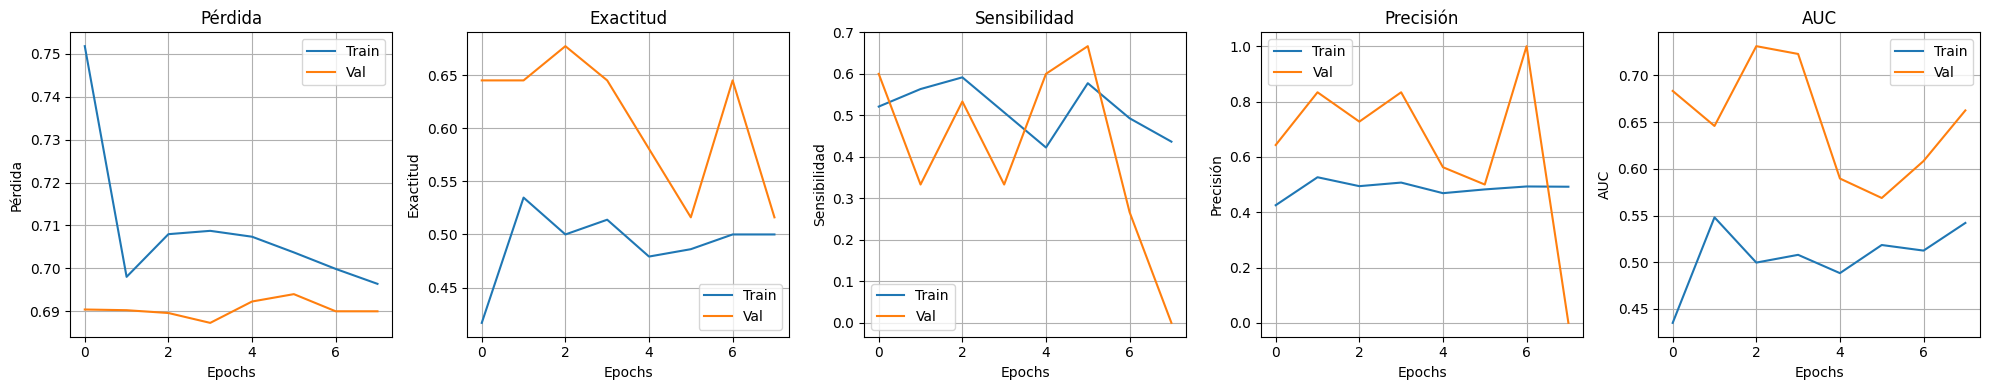

[codecarbon INFO @ 17:36:34] Energy consumed for RAM : 0.021208 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:36:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:36:34] Energy consumed for All CPU : 0.023723 kWh
[codecarbon INFO @ 17:36:34] Energy consumed for all GPUs : 0.052646 kWh. Total GPU Power : 54.976056514534704 W
[codecarbon INFO @ 17:36:34] 0.097576 kWh of electricity used since the beginning.


16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 195ms/step

Métricas de evaluación:
Exactitud:     0.6250
Precisión:     0.6111
Sensibilidad:  0.6875
Especificidad: 0.5625
F1-score:      0.6471
AUC:           0.7266


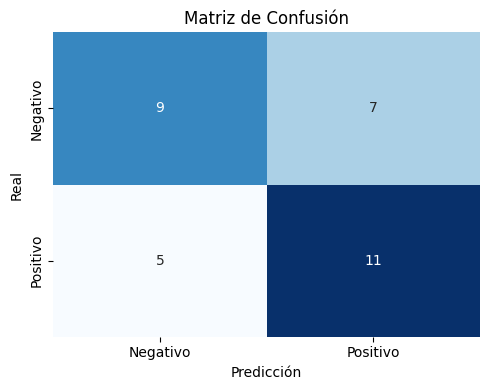

In [ ]:
p.plot_training(vgg16_gru_model_history)
model_metrics_dataset(vgg16_gru_model, test_ds)

In [ ]:
models_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models"

vgg16_gru_model.save_weights('/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models/VGG16_GRU.weights.h5')

with open(os.path.join(models_dir, "VGG16_GRU_history.pkl"), "wb") as f:
    pickle.dump(vgg16_gru_model_history.history, f)

#### 4.2.3.3 - Modelo preentrenado con RestNet50.

In [ ]:
class RESNET50_GRU(tf.keras.Model):
    """
    Modelo híbrido basado en ResNet50 y GRU para la clasificación binaria de secuencias fMRI 2D.

    Este modelo combina ResNet50 preentrenado sobre ImageNet como extractor de características espaciales
    con una capa GRU para capturar la dinámica temporal de las secuencias. La red convolucional se aplica
    de forma independiente a cada paso temporal mediante `TimeDistributed`. El modelo finaliza con una capa
    densa y dropout para la predicción binaria.

    Parameters
    ----------
    input_shape : tuple, optional
        Forma del tensor de entrada sin incluir el batch. Por defecto (95, 224, 224, 3), donde:
            - 95 es el número de pasos temporales,
            - 224x224 el tamaño de las imágenes fMRI redimensionadas,
            - 3 canales RGB para compatibilidad con ResNet50 preentrenado.
    num_classes : int, optional
        Número de clases. Por defecto 1 (clasificación binaria con activación sigmoide).
    gru_units : int, optional
        Número de unidades en la capa GRU. Por defecto 64.
    dropout_rate : float, optional
        Tasa de dropout aplicada tras la capa densa. Por defecto 0.5.

    Returns
    -------
    tf.Tensor
        Tensor de salida con las probabilidades por clase. En clasificación binaria, tiene forma (batch_size, 1).
    """
    def __init__(self, input_shape=(95, 224, 224, 3), num_classes=1, gru_units=64, dropout_rate=0.5):
        super(RESNET50_GRU, self).__init__()
        l2 = regularizers.l2(1e-4)

        base_cnn = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_cnn.trainable = False

        self.feature_extractor = tf.keras.Sequential([
            base_cnn,
            layers.GlobalAveragePooling2D()
        ])

        self.td_extractor = layers.TimeDistributed(self.feature_extractor)
        self.gru = layers.GRU(gru_units, return_sequences=False)

        self.dense = layers.Dense(64, activation='relu', kernel_regularizer=l2)
        self.dropout = layers.Dropout(dropout_rate)
        self.out = layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')

    def call(self, inputs, training=False):
        x = self.td_extractor(inputs)
        x = self.gru(x)
        x = self.dense(x)
        if training:
            x = self.dropout(x, training=training)
        return self.out(x)

In [ ]:
resnet50_gru_model = RESNET50_GRU(input_shape=X_train.shape[1:])

resnet50_gru_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

[codecarbon INFO @ 17:39:04] Energy consumed for RAM : 0.022791 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:39:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:39:04] Energy consumed for All CPU : 0.025493 kWh
[codecarbon INFO @ 17:39:04] Energy consumed for all GPUs : 0.055076 kWh. Total GPU Power : 53.879963622586 W
[codecarbon INFO @ 17:39:04] 0.103359 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:39:04] 0.016886 g.CO2eq/s mean an estimation of 532.5200375391016 kg.CO2eq/year


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
tracker = EmissionsTracker()
tracker.start()
start = time.time()

resnet50_gru_model_history = resnet50_gru_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)

end = time.time()
emissions = tracker.stop()
print(f"\nTiempo de entrenamiento: {(end - start):.2f} segundos")
print(f"\nEmisiones estimadas: {emissions:.4f} kg de CO2")

[codecarbon WARNING @ 17:39:28] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:39:28] [setup] RAM Tracking...
[codecarbon INFO @ 17:39:28] [setup] CPU Tracking...
[codecarbon WARNING @ 17:39:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 17:39:29] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 17:39:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 17:39:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:39:29] [setup] GPU Tracking...
[codecarbon INFO @ 17:39:29] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:39:29] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/30


[codecarbon INFO @ 17:39:34] Energy consumed for RAM : 0.023107 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:39:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:39:34] Energy consumed for All CPU : 0.025847 kWh
[codecarbon INFO @ 17:39:34] Energy consumed for all GPUs : 0.055521 kWh. Total GPU Power : 53.41306885458403 W
[codecarbon INFO @ 17:39:34] 0.104476 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:39:44] Energy consumed for RAM : 0.000158 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:39:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:39:44] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 17:39:44] Energy consumed for all GPUs : 0.000222 kWh. Total GPU Power : 53.23073860577035 W
[codecarbon INFO @ 17:39:44] 0.000558 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:39:49] Energy consumed for RAM : 0.023266 kWh. RAM Power : 3

17/72 ━━━━━━━━━━━━━━━━━━━━ 29s 536ms/step - accuracy: 0.6444 - auc: 0.6821 - loss: 0.6841 - precision: 0.5554 - recall: 0.6495

[codecarbon INFO @ 17:50:47] Energy consumed for RAM : 0.007147 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:50:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:50:47] Energy consumed for All CPU : 0.007996 kWh
[codecarbon INFO @ 17:50:47] Energy consumed for all GPUs : 0.010236 kWh. Total GPU Power : 98.39023656554829 W
[codecarbon INFO @ 17:50:47] 0.025378 kWh of electricity used since the beginning.


20/72 ━━━━━━━━━━━━━━━━━━━━ 27s 536ms/step - accuracy: 0.6305 - auc: 0.6718 - loss: 0.6893 - precision: 0.5653 - recall: 0.6230

[codecarbon INFO @ 17:50:49] Energy consumed for RAM : 0.030224 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:50:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:50:49] Energy consumed for All CPU : 0.033809 kWh
[codecarbon INFO @ 17:50:49] Energy consumed for all GPUs : 0.065747 kWh. Total GPU Power : 106.21056783702173 W
[codecarbon INFO @ 17:50:49] 0.129779 kWh of electricity used since the beginning.


45/72 ━━━━━━━━━━━━━━━━━━━━ 14s 539ms/step - accuracy: 0.5684 - auc: 0.6059 - loss: 0.7262 - precision: 0.5795 - recall: 0.5650

[codecarbon INFO @ 17:51:02] Energy consumed for RAM : 0.007305 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:51:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:51:02] Energy consumed for All CPU : 0.008173 kWh
[codecarbon INFO @ 17:51:02] Energy consumed for all GPUs : 0.010768 kWh. Total GPU Power : 127.7539010581548 W
[codecarbon INFO @ 17:51:02] 0.026246 kWh of electricity used since the beginning.


47/72 ━━━━━━━━━━━━━━━━━━━━ 13s 540ms/step - accuracy: 0.5668 - auc: 0.6041 - loss: 0.7266 - precision: 0.5787 - recall: 0.5646

[codecarbon INFO @ 17:51:04] Energy consumed for RAM : 0.030382 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:51:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:51:04] Energy consumed for All CPU : 0.033986 kWh
[codecarbon INFO @ 17:51:04] Energy consumed for all GPUs : 0.066280 kWh. Total GPU Power : 128.12391368143713 W
[codecarbon INFO @ 17:51:04] 0.130648 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:51:04] 0.018827 g.CO2eq/s mean an estimation of 593.7281432022531 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.5581 - auc: 0.5878 - loss: 0.7307 - precision: 0.5703 - recall: 0.5677

[codecarbon INFO @ 17:51:17] Energy consumed for RAM : 0.007465 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:51:17] Delta energy consumed for CPU with constant : 0.000179 kWh, power : 42.5 W
[codecarbon INFO @ 17:51:17] Energy consumed for All CPU : 0.008352 kWh
[codecarbon INFO @ 17:51:17] Energy consumed for all GPUs : 0.011303 kWh. Total GPU Power : 126.53348109096963 W
[codecarbon INFO @ 17:51:17] 0.027120 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:51:19] Energy consumed for RAM : 0.030540 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:51:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:51:19] Energy consumed for All CPU : 0.034163 kWh
[codecarbon INFO @ 17:51:19] Energy consumed for all GPUs : 0.066785 kWh. Total GPU Power : 120.98550802571386 W
[codecarbon INFO @ 17:51:19] 0.131488 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:51:32] Energy consumed for RAM : 0.007623 kWh. RAM Power :

72/72 ━━━━━━━━━━━━━━━━━━━━ 955s 4s/step - accuracy: 0.5579 - auc: 0.5872 - loss: 0.7309 - precision: 0.5698 - recall: 0.5675 - val_accuracy: 0.5161 - val_auc: 0.6479 - val_loss: 0.7075 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
14/72 ━━━━━━━━━━━━━━━━━━━━ 31s 549ms/step - accuracy: 0.5855 - auc: 0.4952 - loss: 0.7395 - precision: 0.5238 - recall: 0.4049

[codecarbon INFO @ 17:55:32] Energy consumed for RAM : 0.010104 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:55:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:55:32] Energy consumed for All CPU : 0.011305 kWh
[codecarbon INFO @ 17:55:32] Energy consumed for all GPUs : 0.015433 kWh. Total GPU Power : 125.7965073838721 W
[codecarbon INFO @ 17:55:32] 0.036842 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:55:32] 0.018081 g.CO2eq/s mean an estimation of 570.1956388829259 kg.CO2eq/year


23/72 ━━━━━━━━━━━━━━━━━━━━ 26s 548ms/step - accuracy: 0.6032 - auc: 0.4697 - loss: 0.7408 - precision: 0.5259 - recall: 0.3622

[codecarbon INFO @ 17:55:37] Energy consumed for RAM : 0.033266 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:55:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:55:37] Energy consumed for All CPU : 0.037213 kWh
[codecarbon INFO @ 17:55:37] Energy consumed for all GPUs : 0.071061 kWh. Total GPU Power : 125.52883569948186 W
[codecarbon INFO @ 17:55:37] 0.141540 kWh of electricity used since the beginning.


41/72 ━━━━━━━━━━━━━━━━━━━━ 16s 547ms/step - accuracy: 0.6083 - auc: 0.4840 - loss: 0.7349 - precision: 0.5475 - recall: 0.3214

[codecarbon INFO @ 17:55:47] Energy consumed for RAM : 0.010262 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:55:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:55:47] Energy consumed for All CPU : 0.011482 kWh
[codecarbon INFO @ 17:55:47] Energy consumed for all GPUs : 0.015961 kWh. Total GPU Power : 126.69520409989146 W
[codecarbon INFO @ 17:55:47] 0.037705 kWh of electricity used since the beginning.


50/72 ━━━━━━━━━━━━━━━━━━━━ 12s 547ms/step - accuracy: 0.6068 - auc: 0.4937 - loss: 0.7333 - precision: 0.5620 - recall: 0.3162

[codecarbon INFO @ 17:55:52] Energy consumed for RAM : 0.033424 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:55:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:55:52] Energy consumed for All CPU : 0.037390 kWh
[codecarbon INFO @ 17:55:52] Energy consumed for all GPUs : 0.071591 kWh. Total GPU Power : 127.14909702920602 W
[codecarbon INFO @ 17:55:52] 0.142405 kWh of electricity used since the beginning.


69/72 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step - accuracy: 0.5977 - auc: 0.5082 - loss: 0.7356 - precision: 0.5750 - recall: 0.3323

[codecarbon INFO @ 17:56:02] Energy consumed for RAM : 0.010420 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:56:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:56:02] Energy consumed for All CPU : 0.011659 kWh
[codecarbon INFO @ 17:56:02] Energy consumed for all GPUs : 0.016495 kWh. Total GPU Power : 128.09168412538926 W
[codecarbon INFO @ 17:56:02] 0.038574 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.5959 - auc: 0.5092 - loss: 0.7360 - precision: 0.5744 - recall: 0.3360

[codecarbon INFO @ 17:56:07] Energy consumed for RAM : 0.033583 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:56:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:56:07] Energy consumed for All CPU : 0.037567 kWh
[codecarbon INFO @ 17:56:07] Energy consumed for all GPUs : 0.072126 kWh. Total GPU Power : 128.3047494707266 W
[codecarbon INFO @ 17:56:07] 0.143275 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 670ms/step - accuracy: 0.5953 - auc: 0.5096 - loss: 0.7361 - precision: 0.5743 - recall: 0.3372 - val_accuracy: 0.4839 - val_auc: 0.6250 - val_loss: 0.7127 - val_precision: 0.4839 - val_recall: 1.0000
Epoch 3/30
 8/72 ━━━━━━━━━━━━━━━━━━━━ 35s 557ms/step - accuracy: 0.2179 - auc: 0.1536 - loss: 0.9674 - precision: 0.0647 - recall: 0.2917

[codecarbon INFO @ 17:56:17] Energy consumed for RAM : 0.010578 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:56:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:56:17] Energy consumed for All CPU : 0.011836 kWh
[codecarbon INFO @ 17:56:17] Energy consumed for all GPUs : 0.017026 kWh. Total GPU Power : 127.53365016408863 W
[codecarbon INFO @ 17:56:17] 0.039440 kWh of electricity used since the beginning.


17/72 ━━━━━━━━━━━━━━━━━━━━ 30s 550ms/step - accuracy: 0.3011 - auc: 0.2492 - loss: 0.8957 - precision: 0.1763 - recall: 0.3674

[codecarbon INFO @ 17:56:22] Energy consumed for RAM : 0.033741 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:56:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:56:22] Energy consumed for All CPU : 0.037744 kWh
[codecarbon INFO @ 17:56:22] Energy consumed for all GPUs : 0.072655 kWh. Total GPU Power : 127.14358550446764 W
[codecarbon INFO @ 17:56:22] 0.144140 kWh of electricity used since the beginning.


35/72 ━━━━━━━━━━━━━━━━━━━━ 20s 548ms/step - accuracy: 0.3931 - auc: 0.3548 - loss: 0.8224 - precision: 0.3201 - recall: 0.4197

[codecarbon INFO @ 17:56:32] Energy consumed for RAM : 0.010737 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:56:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:56:32] Energy consumed for All CPU : 0.012013 kWh
[codecarbon INFO @ 17:56:32] Energy consumed for all GPUs : 0.017562 kWh. Total GPU Power : 128.61456564472735 W
[codecarbon INFO @ 17:56:32] 0.040311 kWh of electricity used since the beginning.


44/72 ━━━━━━━━━━━━━━━━━━━━ 15s 548ms/step - accuracy: 0.4157 - auc: 0.3803 - loss: 0.8046 - precision: 0.3642 - recall: 0.4475

[codecarbon INFO @ 17:56:37] Energy consumed for RAM : 0.033899 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:56:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:56:37] Energy consumed for All CPU : 0.037921 kWh
[codecarbon INFO @ 17:56:37] Energy consumed for all GPUs : 0.073188 kWh. Total GPU Power : 127.83942660165448 W
[codecarbon INFO @ 17:56:37] 0.145008 kWh of electricity used since the beginning.


63/72 ━━━━━━━━━━━━━━━━━━━━ 4s 549ms/step - accuracy: 0.4446 - auc: 0.4190 - loss: 0.7820 - precision: 0.4092 - recall: 0.5028

[codecarbon INFO @ 17:56:47] Energy consumed for RAM : 0.010895 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:56:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:56:47] Energy consumed for All CPU : 0.012190 kWh
[codecarbon INFO @ 17:56:47] Energy consumed for all GPUs : 0.018095 kWh. Total GPU Power : 127.90155679889662 W
[codecarbon INFO @ 17:56:47] 0.041179 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.4551 - auc: 0.4331 - loss: 0.7742 - precision: 0.4222 - recall: 0.5182

[codecarbon INFO @ 17:56:52] Energy consumed for RAM : 0.034057 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:56:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:56:52] Energy consumed for All CPU : 0.038098 kWh
[codecarbon INFO @ 17:56:52] Energy consumed for all GPUs : 0.073726 kWh. Total GPU Power : 129.24845311284525 W
[codecarbon INFO @ 17:56:52] 0.145881 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 672ms/step - accuracy: 0.4561 - auc: 0.4345 - loss: 0.7734 - precision: 0.4235 - recall: 0.5194 - val_accuracy: 0.5161 - val_auc: 0.6625 - val_loss: 0.6923 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
 2/72 ━━━━━━━━━━━━━━━━━━━━ 38s 544ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.6077 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 17:57:02] Energy consumed for RAM : 0.011053 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:57:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:57:02] Energy consumed for All CPU : 0.012367 kWh
[codecarbon INFO @ 17:57:02] Energy consumed for all GPUs : 0.018628 kWh. Total GPU Power : 127.93699178734013 W
[codecarbon INFO @ 17:57:02] 0.042047 kWh of electricity used since the beginning.


11/72 ━━━━━━━━━━━━━━━━━━━━ 33s 543ms/step - accuracy: 0.7510 - auc: 0.7629 - loss: 0.6397 - precision: 0.7860 - recall: 0.7951

[codecarbon INFO @ 17:57:07] Energy consumed for RAM : 0.034216 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:57:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:57:07] Energy consumed for All CPU : 0.038275 kWh
[codecarbon INFO @ 17:57:07] Energy consumed for all GPUs : 0.074256 kWh. Total GPU Power : 127.1503408403001 W
[codecarbon INFO @ 17:57:07] 0.146746 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:57:07] 0.025477 g.CO2eq/s mean an estimation of 803.4277805238485 kg.CO2eq/year


30/72 ━━━━━━━━━━━━━━━━━━━━ 22s 545ms/step - accuracy: 0.6128 - auc: 0.6184 - loss: 0.6777 - precision: 0.6870 - recall: 0.6451

[codecarbon INFO @ 17:57:17] Energy consumed for RAM : 0.011211 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:57:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:57:17] Energy consumed for All CPU : 0.012544 kWh
[codecarbon INFO @ 17:57:17] Energy consumed for all GPUs : 0.019165 kWh. Total GPU Power : 129.09594500397003 W
[codecarbon INFO @ 17:57:17] 0.042921 kWh of electricity used since the beginning.


38/72 ━━━━━━━━━━━━━━━━━━━━ 18s 548ms/step - accuracy: 0.5915 - auc: 0.5993 - loss: 0.6838 - precision: 0.6612 - recall: 0.6330

[codecarbon INFO @ 17:57:22] Energy consumed for RAM : 0.034374 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:57:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:57:22] Energy consumed for All CPU : 0.038452 kWh
[codecarbon INFO @ 17:57:22] Energy consumed for all GPUs : 0.074791 kWh. Total GPU Power : 128.43366657365348 W
[codecarbon INFO @ 17:57:22] 0.147617 kWh of electricity used since the beginning.


57/72 ━━━━━━━━━━━━━━━━━━━━ 8s 548ms/step - accuracy: 0.5712 - auc: 0.5855 - loss: 0.6884 - precision: 0.6233 - recall: 0.6138

[codecarbon INFO @ 17:57:32] Energy consumed for RAM : 0.011370 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:57:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:57:32] Energy consumed for All CPU : 0.012721 kWh
[codecarbon INFO @ 17:57:32] Energy consumed for all GPUs : 0.019697 kWh. Total GPU Power : 127.55025801748701 W
[codecarbon INFO @ 17:57:32] 0.043787 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:57:32] 0.026197 g.CO2eq/s mean an estimation of 826.1414231021041 kg.CO2eq/year


66/72 ━━━━━━━━━━━━━━━━━━━━ 3s 548ms/step - accuracy: 0.5633 - auc: 0.5780 - loss: 0.6909 - precision: 0.6082 - recall: 0.6021

[codecarbon INFO @ 17:57:37] Energy consumed for RAM : 0.034532 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:57:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:57:37] Energy consumed for All CPU : 0.038629 kWh
[codecarbon INFO @ 17:57:37] Energy consumed for all GPUs : 0.075329 kWh. Total GPU Power : 129.08578084165975 W
[codecarbon INFO @ 17:57:37] 0.148490 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.5598 - auc: 0.5747 - loss: 0.6922 - precision: 0.6002 - recall: 0.5956

[codecarbon INFO @ 17:57:47] Energy consumed for RAM : 0.011528 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:57:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:57:47] Energy consumed for All CPU : 0.012898 kWh
[codecarbon INFO @ 17:57:47] Energy consumed for all GPUs : 0.020237 kWh. Total GPU Power : 129.72683322136754 W
[codecarbon INFO @ 17:57:47] 0.044663 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 670ms/step - accuracy: 0.5593 - auc: 0.5742 - loss: 0.6924 - precision: 0.5990 - recall: 0.5946 - val_accuracy: 0.5161 - val_auc: 0.6875 - val_loss: 0.6951 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
 5/72 ━━━━━━━━━━━━━━━━━━━━ 36s 547ms/step - accuracy: 0.2667 - auc: 0.2046 - loss: 0.8920 - precision: 0.4433 - recall: 0.2800

[codecarbon INFO @ 17:57:52] Energy consumed for RAM : 0.034691 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:57:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:57:52] Energy consumed for All CPU : 0.038806 kWh
[codecarbon INFO @ 17:57:52] Energy consumed for all GPUs : 0.075863 kWh. Total GPU Power : 128.17712490856576 W
[codecarbon INFO @ 17:57:52] 0.149359 kWh of electricity used since the beginning.


24/72 ━━━━━━━━━━━━━━━━━━━━ 26s 546ms/step - accuracy: 0.4676 - auc: 0.4322 - loss: 0.7685 - precision: 0.6440 - recall: 0.4811

[codecarbon INFO @ 17:58:02] Energy consumed for RAM : 0.011686 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:58:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:58:02] Energy consumed for All CPU : 0.013075 kWh
[codecarbon INFO @ 17:58:02] Energy consumed for all GPUs : 0.020769 kWh. Total GPU Power : 127.66486785771858 W
[codecarbon INFO @ 17:58:02] 0.045530 kWh of electricity used since the beginning.


33/72 ━━━━━━━━━━━━━━━━━━━━ 21s 544ms/step - accuracy: 0.5013 - auc: 0.4756 - loss: 0.7475 - precision: 0.6519 - recall: 0.5190

[codecarbon INFO @ 17:58:07] Energy consumed for RAM : 0.034849 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:58:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:58:07] Energy consumed for All CPU : 0.038983 kWh
[codecarbon INFO @ 17:58:07] Energy consumed for all GPUs : 0.076399 kWh. Total GPU Power : 128.76239538691345 W
[codecarbon INFO @ 17:58:07] 0.150231 kWh of electricity used since the beginning.


52/72 ━━━━━━━━━━━━━━━━━━━━ 10s 539ms/step - accuracy: 0.5239 - auc: 0.5085 - loss: 0.7280 - precision: 0.6319 - recall: 0.5623

[codecarbon INFO @ 17:58:17] Energy consumed for RAM : 0.011844 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:58:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:58:17] Energy consumed for All CPU : 0.013252 kWh
[codecarbon INFO @ 17:58:17] Energy consumed for all GPUs : 0.021309 kWh. Total GPU Power : 129.7580028001591 W
[codecarbon INFO @ 17:58:17] 0.046406 kWh of electricity used since the beginning.


61/72 ━━━━━━━━━━━━━━━━━━━━ 5s 538ms/step - accuracy: 0.5298 - auc: 0.5214 - loss: 0.7216 - precision: 0.6199 - recall: 0.5694

[codecarbon INFO @ 17:58:22] Energy consumed for RAM : 0.035007 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:58:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:58:22] Energy consumed for All CPU : 0.039160 kWh
[codecarbon INFO @ 17:58:22] Energy consumed for all GPUs : 0.076945 kWh. Total GPU Power : 131.00766018356208 W
[codecarbon INFO @ 17:58:22] 0.151112 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.5343 - auc: 0.5304 - loss: 0.7168 - precision: 0.6083 - recall: 0.5687

[codecarbon INFO @ 17:58:32] Energy consumed for RAM : 0.012003 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:58:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:58:32] Energy consumed for All CPU : 0.013429 kWh
[codecarbon INFO @ 17:58:32] Energy consumed for all GPUs : 0.021859 kWh. Total GPU Power : 131.94574216060383 W
[codecarbon INFO @ 17:58:32] 0.047291 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 655ms/step - accuracy: 0.5346 - auc: 0.5309 - loss: 0.7165 - precision: 0.6075 - recall: 0.5683 - val_accuracy: 0.5161 - val_auc: 0.6583 - val_loss: 0.6965 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/30
 2/72 ━━━━━━━━━━━━━━━━━━━━ 36s 526ms/step - accuracy: 0.2500 - auc: 0.3750 - loss: 0.7901 - precision: 0.2500 - recall: 0.2500                

[codecarbon INFO @ 17:58:37] Energy consumed for RAM : 0.035165 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:58:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:58:37] Energy consumed for All CPU : 0.039337 kWh
[codecarbon INFO @ 17:58:37] Energy consumed for all GPUs : 0.077487 kWh. Total GPU Power : 130.28121273367316 W
[codecarbon INFO @ 17:58:37] 0.151990 kWh of electricity used since the beginning.


21/72 ━━━━━━━━━━━━━━━━━━━━ 27s 531ms/step - accuracy: 0.5457 - auc: 0.4656 - loss: 0.7283 - precision: 0.3010 - recall: 0.2931

[codecarbon INFO @ 17:58:47] Energy consumed for RAM : 0.012161 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:58:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:58:47] Energy consumed for All CPU : 0.013606 kWh
[codecarbon INFO @ 17:58:47] Energy consumed for all GPUs : 0.022398 kWh. Total GPU Power : 129.35472645426663 W
[codecarbon INFO @ 17:58:47] 0.048165 kWh of electricity used since the beginning.


30/72 ━━━━━━━━━━━━━━━━━━━━ 22s 531ms/step - accuracy: 0.5465 - auc: 0.4672 - loss: 0.7313 - precision: 0.3588 - recall: 0.3064

[codecarbon INFO @ 17:58:52] Energy consumed for RAM : 0.035324 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:58:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:58:52] Energy consumed for All CPU : 0.039514 kWh
[codecarbon INFO @ 17:58:52] Energy consumed for all GPUs : 0.078030 kWh. Total GPU Power : 130.32220836162784 W
[codecarbon INFO @ 17:58:52] 0.152868 kWh of electricity used since the beginning.


49/72 ━━━━━━━━━━━━━━━━━━━━ 12s 531ms/step - accuracy: 0.5434 - auc: 0.4832 - loss: 0.7290 - precision: 0.4239 - recall: 0.3179

[codecarbon INFO @ 17:59:02] Energy consumed for RAM : 0.012319 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:59:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:59:02] Energy consumed for All CPU : 0.013783 kWh
[codecarbon INFO @ 17:59:02] Energy consumed for all GPUs : 0.022938 kWh. Total GPU Power : 129.69343571524306 W
[codecarbon INFO @ 17:59:02] 0.049041 kWh of electricity used since the beginning.


58/72 ━━━━━━━━━━━━━━━━━━━━ 7s 531ms/step - accuracy: 0.5412 - auc: 0.4896 - loss: 0.7280 - precision: 0.4449 - recall: 0.3312

[codecarbon INFO @ 17:59:07] Energy consumed for RAM : 0.035482 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:59:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:59:07] Energy consumed for All CPU : 0.039691 kWh
[codecarbon INFO @ 17:59:07] Energy consumed for all GPUs : 0.078573 kWh. Total GPU Power : 130.31654478128755 W
[codecarbon INFO @ 17:59:07] 0.153746 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:59:07] 0.026402 g.CO2eq/s mean an estimation of 832.6077852254117 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.5425 - auc: 0.4998 - loss: 0.7249 - precision: 0.4661 - recall: 0.3543

[codecarbon INFO @ 17:59:17] Energy consumed for RAM : 0.012478 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:59:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:59:17] Energy consumed for All CPU : 0.013960 kWh
[codecarbon INFO @ 17:59:17] Energy consumed for all GPUs : 0.023487 kWh. Total GPU Power : 131.60919811997334 W
[codecarbon INFO @ 17:59:17] 0.049924 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:59:22] Energy consumed for RAM : 0.035640 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:59:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:59:22] Energy consumed for All CPU : 0.039868 kWh
[codecarbon INFO @ 17:59:22] Energy consumed for all GPUs : 0.079118 kWh. Total GPU Power : 130.8364758059948 W
[codecarbon INFO @ 17:59:22] 0.154627 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 649ms/step - accuracy: 0.5428 - auc: 0.5007 - loss: 0.7246 - precision: 0.4676 - recall: 0.3560 - val_accuracy: 0.6452 - val_auc: 0.6854 - val_loss: 0.6813 - val_precision: 0.7000 - val_recall: 0.4667
Epoch 7/30
18/72 ━━━━━━━━━━━━━━━━━━━━ 28s 536ms/step - accuracy: 0.6390 - auc: 0.6517 - loss: 0.6366 - precision: 0.4591 - recall: 0.5932

[codecarbon INFO @ 17:59:32] Energy consumed for RAM : 0.012636 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:59:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:59:32] Energy consumed for All CPU : 0.014137 kWh
[codecarbon INFO @ 17:59:32] Energy consumed for all GPUs : 0.024026 kWh. Total GPU Power : 129.46871020832714 W
[codecarbon INFO @ 17:59:32] 0.050799 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:59:32] 0.026447 g.CO2eq/s mean an estimation of 834.0273979709915 kg.CO2eq/year


27/72 ━━━━━━━━━━━━━━━━━━━━ 24s 534ms/step - accuracy: 0.6249 - auc: 0.6428 - loss: 0.6443 - precision: 0.4946 - recall: 0.5928

[codecarbon INFO @ 17:59:37] Energy consumed for RAM : 0.035799 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:59:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:59:37] Energy consumed for All CPU : 0.040045 kWh
[codecarbon INFO @ 17:59:37] Energy consumed for all GPUs : 0.079658 kWh. Total GPU Power : 129.64219209198174 W
[codecarbon INFO @ 17:59:37] 0.155502 kWh of electricity used since the beginning.


46/72 ━━━━━━━━━━━━━━━━━━━━ 13s 534ms/step - accuracy: 0.6097 - auc: 0.6338 - loss: 0.6534 - precision: 0.5310 - recall: 0.5727

[codecarbon INFO @ 17:59:47] Energy consumed for RAM : 0.012794 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:59:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:59:47] Energy consumed for All CPU : 0.014314 kWh
[codecarbon INFO @ 17:59:47] Energy consumed for all GPUs : 0.024568 kWh. Total GPU Power : 130.08781653248514 W
[codecarbon INFO @ 17:59:47] 0.051676 kWh of electricity used since the beginning.


55/72 ━━━━━━━━━━━━━━━━━━━━ 9s 533ms/step - accuracy: 0.6097 - auc: 0.6401 - loss: 0.6534 - precision: 0.5419 - recall: 0.5650

[codecarbon INFO @ 17:59:52] Energy consumed for RAM : 0.035957 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:59:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:59:52] Energy consumed for All CPU : 0.040222 kWh
[codecarbon INFO @ 17:59:52] Energy consumed for all GPUs : 0.080200 kWh. Total GPU Power : 130.09457616174035 W
[codecarbon INFO @ 17:59:52] 0.156379 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.6018 - auc: 0.6355 - loss: 0.6586 - precision: 0.5507 - recall: 0.5438

[codecarbon INFO @ 18:00:02] Energy consumed for RAM : 0.012952 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:00:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:00:02] Energy consumed for All CPU : 0.014491 kWh
[codecarbon INFO @ 18:00:02] Energy consumed for all GPUs : 0.025114 kWh. Total GPU Power : 131.07742987360803 W
[codecarbon INFO @ 18:00:02] 0.052558 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:00:07] Energy consumed for RAM : 0.036115 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:00:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:00:07] Energy consumed for All CPU : 0.040399 kWh
[codecarbon INFO @ 18:00:07] Energy consumed for all GPUs : 0.080746 kWh. Total GPU Power : 130.97966875783672 W
[codecarbon INFO @ 18:00:07] 0.157260 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 651ms/step - accuracy: 0.6013 - auc: 0.6350 - loss: 0.6589 - precision: 0.5509 - recall: 0.5429 - val_accuracy: 0.5161 - val_auc: 0.6792 - val_loss: 0.6860 - val_precision: 0.5000 - val_recall: 0.8000
Epoch 8/30
15/72 ━━━━━━━━━━━━━━━━━━━━ 30s 530ms/step - accuracy: 0.5428 - auc: 0.5269 - loss: 0.7214 - precision: 0.5169 - recall: 0.8923

[codecarbon INFO @ 18:00:17] Energy consumed for RAM : 0.013111 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:00:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:00:17] Energy consumed for All CPU : 0.014668 kWh
[codecarbon INFO @ 18:00:17] Energy consumed for all GPUs : 0.025657 kWh. Total GPU Power : 130.4567932293096 W
[codecarbon INFO @ 18:00:17] 0.053436 kWh of electricity used since the beginning.


24/72 ━━━━━━━━━━━━━━━━━━━━ 25s 530ms/step - accuracy: 0.5897 - auc: 0.5655 - loss: 0.7035 - precision: 0.5598 - recall: 0.8899

[codecarbon INFO @ 18:00:22] Energy consumed for RAM : 0.036273 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:00:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:00:22] Energy consumed for All CPU : 0.040576 kWh
[codecarbon INFO @ 18:00:22] Energy consumed for all GPUs : 0.081290 kWh. Total GPU Power : 130.52886627741125 W
[codecarbon INFO @ 18:00:22] 0.158139 kWh of electricity used since the beginning.


43/72 ━━━━━━━━━━━━━━━━━━━━ 15s 530ms/step - accuracy: 0.6070 - auc: 0.6129 - loss: 0.6882 - precision: 0.5655 - recall: 0.8555

[codecarbon INFO @ 18:00:32] Energy consumed for RAM : 0.013269 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:00:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:00:32] Energy consumed for All CPU : 0.014845 kWh
[codecarbon INFO @ 18:00:32] Energy consumed for all GPUs : 0.026199 kWh. Total GPU Power : 129.9258648617251 W
[codecarbon INFO @ 18:00:32] 0.054313 kWh of electricity used since the beginning.


52/72 ━━━━━━━━━━━━━━━━━━━━ 10s 530ms/step - accuracy: 0.6059 - auc: 0.6181 - loss: 0.6857 - precision: 0.5639 - recall: 0.8258

[codecarbon INFO @ 18:00:37] Energy consumed for RAM : 0.036432 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:00:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:00:37] Energy consumed for All CPU : 0.040753 kWh
[codecarbon INFO @ 18:00:37] Energy consumed for all GPUs : 0.081831 kWh. Total GPU Power : 129.8628026038542 W
[codecarbon INFO @ 18:00:37] 0.159015 kWh of electricity used since the beginning.


71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.6026 - auc: 0.6192 - loss: 0.6837 - precision: 0.5662 - recall: 0.7697

[codecarbon INFO @ 18:00:47] Energy consumed for RAM : 0.013427 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:00:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:00:47] Energy consumed for All CPU : 0.015022 kWh
[codecarbon INFO @ 18:00:47] Energy consumed for all GPUs : 0.026744 kWh. Total GPU Power : 131.00717143478985 W
[codecarbon INFO @ 18:00:47] 0.055194 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.6021 - auc: 0.6190 - loss: 0.6837 - precision: 0.5661 - recall: 0.7672

[codecarbon INFO @ 18:00:52] Energy consumed for RAM : 0.036590 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:00:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:00:52] Energy consumed for All CPU : 0.040930 kWh
[codecarbon INFO @ 18:00:52] Energy consumed for all GPUs : 0.082378 kWh. Total GPU Power : 131.28251122203966 W
[codecarbon INFO @ 18:00:52] 0.159898 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 648ms/step - accuracy: 0.6017 - auc: 0.6188 - loss: 0.6837 - precision: 0.5660 - recall: 0.7648 - val_accuracy: 0.6129 - val_auc: 0.6875 - val_loss: 0.6802 - val_precision: 0.5789 - val_recall: 0.7333


[codecarbon INFO @ 18:00:56] Energy consumed for RAM : 0.013519 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:00:56] Delta energy consumed for CPU with constant : 0.000103 kWh, power : 42.5 W
[codecarbon INFO @ 18:00:56] Energy consumed for All CPU : 0.015125 kWh
[codecarbon INFO @ 18:00:56] Energy consumed for all GPUs : 0.027060 kWh. Total GPU Power : 130.2368066632084 W
[codecarbon INFO @ 18:00:56] 0.055705 kWh of electricity used since the beginning.



Tiempo de entrenamiento: 1287.01 segundos

Emisiones estimadas: 0.0252 kg de CO2


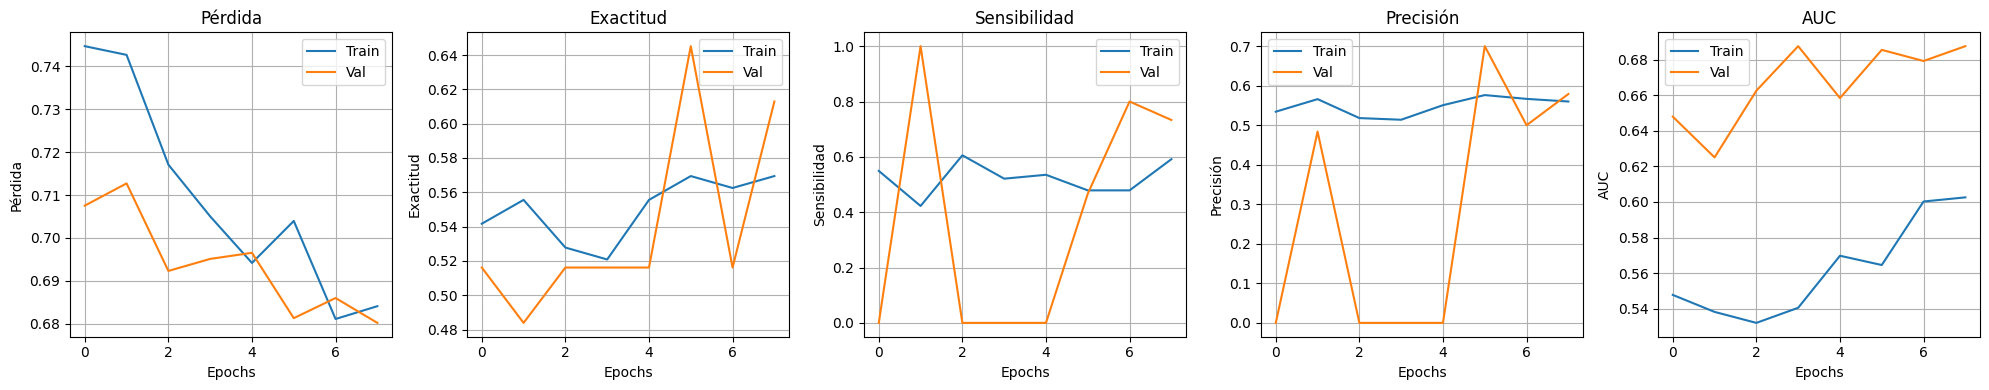

[codecarbon INFO @ 18:01:22] Energy consumed for RAM : 0.036906 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:01:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:01:22] Energy consumed for All CPU : 0.041284 kWh
[codecarbon INFO @ 18:01:22] Energy consumed for all GPUs : 0.082920 kWh. Total GPU Power : 54.166603956260765 W
[codecarbon INFO @ 18:01:22] 0.161111 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:01:37] Energy consumed for RAM : 0.037064 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:01:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:01:37] Energy consumed for All CPU : 0.041461 kWh
[codecarbon INFO @ 18:01:37] Energy consumed for all GPUs : 0.083145 kWh. Total GPU Power : 54.045002042993204 W
[codecarbon INFO @ 18:01:37] 0.161671 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:01:52] Energy consumed for RAM : 0.037223 kWh. RAM Power :

 6/16 ━━━━━━━━━━━━━━━━━━━━ 5s 525ms/step

[codecarbon INFO @ 18:05:07] Energy consumed for RAM : 0.039278 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:05:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:05:07] Energy consumed for All CPU : 0.043938 kWh
[codecarbon INFO @ 18:05:07] Energy consumed for all GPUs : 0.086346 kWh. Total GPU Power : 70.07338634516142 W
[codecarbon INFO @ 18:05:07] 0.169562 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:05:07] 0.017111 g.CO2eq/s mean an estimation of 539.6039672992327 kg.CO2eq/year


16/16 ━━━━━━━━━━━━━━━━━━━━ 232s 524ms/step

Métricas de evaluación:
Exactitud:     0.4375
Precisión:     0.0000
Sensibilidad:  0.0000
Especificidad: 0.8750
F1-score:      0.0000
AUC:           0.3945


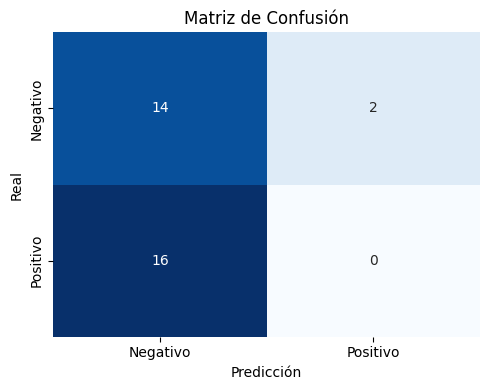

In [ ]:
p.plot_training(resnet50_gru_model_history)
model_metrics_dataset(resnet50_gru_model, test_ds)

In [ ]:
models_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models"

resnet50_gru_model.save_weights('/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models/RESNET50_GRU.weights.h5')

with open(os.path.join(models_dir, "RESNET50_GRU_history.pkl"), "wb") as f:
    pickle.dump(resnet50_gru_model_history.history, f)

[codecarbon INFO @ 18:07:52] Energy consumed for RAM : 0.041019 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:07:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:07:52] Energy consumed for All CPU : 0.045885 kWh
[codecarbon INFO @ 18:07:52] Energy consumed for all GPUs : 0.088918 kWh. Total GPU Power : 53.5256726463674 W
[codecarbon INFO @ 18:07:52] 0.175823 kWh of electricity used since the beginning.


#### 4.2.3.2 - Modelo preentrenado con MovileNetV2.

In [ ]:
@register_keras_serializable()
class MOBILENETV2_GRU(tf.keras.Model):
    """
    Modelo híbrido basado en MobileNetV2 y GRU para la clasificación binaria de secuencias fMRI 2D.

    Esta arquitectura utiliza MobileNetV2 preentrenado sobre ImageNet como extractor de características espaciales,
    aplicándolo a cada paso temporal mediante `TimeDistributed`. Posteriormente, una capa GRU modela la dinámica
    temporal de la secuencia. El modelo incluye además una capa densa y una capa dropout para mejorar la
    generalización.

    MobileNetV2 ha sido seleccionado por su bajo número de parámetros en comparación con otras arquitecturas
    como VGG o ResNet, lo cual resulta útil en entornos con restricciones computacionales y conjuntos de datos reducidos.

    Parameters
    ----------
    input_shape : tuple, optional
        Forma esperada del tensor de entrada sin incluir el batch. Por defecto (95, 224, 224, 3), donde:
            - 95 representa el número de pasos temporales,
            - 224x224 el tamaño de las imágenes redimensionadas,
            - 3 canales RGB necesarios para compatibilidad con MobileNetV2.
    num_classes : int, optional
        Número de clases. Por defecto 1 (clasificación binaria con activación sigmoide).
    gru_units : int, optional
        Número de unidades de la capa GRU. Por defecto 64.
    dropout_rate : float, optional
        Tasa de dropout aplicada después de la capa densa. Por defecto 0.5.

    Returns
    -------
    tf.Tensor
        Tensor con la probabilidad predicha por clase. En clasificación binaria, la forma es (batch_size, 1).
    """
    def __init__(self, input_shape=(95, 224, 224, 3), num_classes=1, gru_units=64, dropout_rate=0.5):
        super(MOBILENETV2_GRU, self).__init__()
        l2 = regularizers.l2(1e-4)

        base_cnn = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_cnn.trainable = False

        self.feature_extractor = tf.keras.Sequential([
            base_cnn,
            layers.GlobalAveragePooling2D()
        ])

        self.td_extractor = layers.TimeDistributed(self.feature_extractor)

        self.gru = layers.GRU(gru_units, return_sequences=False)

        self.dense = layers.Dense(64, activation='relu', kernel_regularizer=l2)
        self.dropout = layers.Dropout(dropout_rate)
        self.out = layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')

    def call(self, inputs, training=False):
        x = self.td_extractor(inputs)
        x = self.gru(x)
        x = self.dense(x)
        if training:
            x = self.dropout(x, training=training)
        return self.out(x)

In [ ]:
mobilenetv2_gru_model = MOBILENETV2_GRU(input_shape=X_train.shape[1:])

mobilenetv2_gru_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
tracker = EmissionsTracker()
tracker.start()
start = time.time()

mobilenetv2_gru_model_history = mobilenetv2_gru_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)

end = time.time()
emissions = tracker.stop()
print(f"\nTiempo de entrenamiento: {(end - start):.2f} segundos")
print(f"\nEmisiones estimadas: {emissions:.4f} kg de CO2")

[codecarbon WARNING @ 07:48:44] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 07:48:44] [setup] RAM Tracking...
[codecarbon INFO @ 07:48:44] [setup] CPU Tracking...
[codecarbon WARNING @ 07:48:45] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 07:48:45] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 07:48:45] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 07:48:45] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 07:48:45] [setup] GPU Tracking...
[codecarbon INFO @ 07:48:45] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 07:48:45] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/30


[codecarbon INFO @ 07:49:01] Energy consumed for RAM : 0.000158 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 07:49:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 07:49:01] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 07:49:01] Energy consumed for all GPUs : 0.000222 kWh. Total GPU Power : 53.27884922400227 W
[codecarbon INFO @ 07:49:01] 0.000558 kWh of electricity used since the beginning.
[codecarbon INFO @ 07:49:16] Energy consumed for RAM : 0.000316 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 07:49:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 07:49:16] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 07:49:16] Energy consumed for all GPUs : 0.000443 kWh. Total GPU Power : 52.937265755330834 W
[codecarbon INFO @ 07:49:16] 0.001113 kWh of electricity used since the beginning.
[codecarbon INFO @ 07:49:31] Energy consumed for RAM : 0.000475 kWh. RAM Power : 

18/72 ━━━━━━━━━━━━━━━━━━━━ 18s 343ms/step - accuracy: 0.4004 - auc: 0.4788 - loss: 0.9413 - precision: 0.3488 - recall: 0.8295

[codecarbon INFO @ 07:56:02] Energy consumed for RAM : 0.004600 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 07:56:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 07:56:02] Energy consumed for All CPU : 0.005147 kWh
[codecarbon INFO @ 07:56:02] Energy consumed for all GPUs : 0.006512 kWh. Total GPU Power : 73.42820916670897 W
[codecarbon INFO @ 07:56:02] 0.016258 kWh of electricity used since the beginning.


62/72 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.3884 - auc: 0.4275 - loss: 0.8587 - precision: 0.3569 - recall: 0.5439

[codecarbon INFO @ 07:56:17] Energy consumed for RAM : 0.004758 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 07:56:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 07:56:17] Energy consumed for All CPU : 0.005324 kWh
[codecarbon INFO @ 07:56:17] Energy consumed for all GPUs : 0.006935 kWh. Total GPU Power : 101.63372278290699 W
[codecarbon INFO @ 07:56:17] 0.017017 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.3964 - auc: 0.4304 - loss: 0.8482 - precision: 0.3693 - recall: 0.5403

[codecarbon INFO @ 07:56:32] Energy consumed for RAM : 0.004916 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 07:56:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 07:56:32] Energy consumed for All CPU : 0.005501 kWh
[codecarbon INFO @ 07:56:32] Energy consumed for all GPUs : 0.007213 kWh. Total GPU Power : 66.60111032968724 W
[codecarbon INFO @ 07:56:32] 0.017630 kWh of electricity used since the beginning.
[codecarbon INFO @ 07:56:47] Energy consumed for RAM : 0.005074 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 07:56:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 07:56:47] Energy consumed for All CPU : 0.005678 kWh
[codecarbon INFO @ 07:56:47] Energy consumed for all GPUs : 0.007434 kWh. Total GPU Power : 53.1939280588485 W
[codecarbon INFO @ 07:56:47] 0.018186 kWh of electricity used since the beginning.
[codecarbon INFO @ 07:56:47] 0.018080 g.CO2eq/s mean an estimation of 570.179228013

72/72 ━━━━━━━━━━━━━━━━━━━━ 588s 2s/step - accuracy: 0.3972 - auc: 0.4309 - loss: 0.8472 - precision: 0.3705 - recall: 0.5404 - val_accuracy: 0.7419 - val_auc: 0.7396 - val_loss: 0.6875 - val_precision: 0.7333 - val_recall: 0.7333
Epoch 2/30
42/72 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.4062 - auc: 0.4463 - loss: 0.7427 - precision: 0.4539 - recall: 0.4285

[codecarbon INFO @ 07:58:48] Energy consumed for RAM : 0.006349 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 07:58:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 07:58:48] Energy consumed for All CPU : 0.007104 kWh
[codecarbon INFO @ 07:58:48] Energy consumed for all GPUs : 0.009478 kWh. Total GPU Power : 100.72709938981943 W
[codecarbon INFO @ 07:58:48] 0.022931 kWh of electricity used since the beginning.
[codecarbon INFO @ 07:58:48] 0.017770 g.CO2eq/s mean an estimation of 560.3790878664131 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.4544 - auc: 0.4923 - loss: 0.7267 - precision: 0.4852 - recall: 0.4918

[codecarbon INFO @ 07:59:03] Energy consumed for RAM : 0.006507 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 07:59:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 07:59:03] Energy consumed for All CPU : 0.007281 kWh
[codecarbon INFO @ 07:59:03] Energy consumed for all GPUs : 0.009906 kWh. Total GPU Power : 102.64847660331765 W
[codecarbon INFO @ 07:59:03] 0.023694 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 418ms/step - accuracy: 0.4556 - auc: 0.4933 - loss: 0.7263 - precision: 0.4858 - recall: 0.4935 - val_accuracy: 0.4516 - val_auc: 0.6479 - val_loss: 0.7021 - val_precision: 0.3333 - val_recall: 0.1333
Epoch 3/30
42/72 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.6717 - auc: 0.6879 - loss: 0.6444 - precision: 0.7095 - recall: 0.5059

[codecarbon INFO @ 07:59:18] Energy consumed for RAM : 0.006666 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 07:59:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 07:59:18] Energy consumed for All CPU : 0.007458 kWh
[codecarbon INFO @ 07:59:18] Energy consumed for all GPUs : 0.010331 kWh. Total GPU Power : 102.00499737344184 W
[codecarbon INFO @ 07:59:18] 0.024454 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6530 - auc: 0.6772 - loss: 0.6490 - precision: 0.6885 - recall: 0.4993

[codecarbon INFO @ 07:59:33] Energy consumed for RAM : 0.006824 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 07:59:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 07:59:33] Energy consumed for All CPU : 0.007635 kWh
[codecarbon INFO @ 07:59:33] Energy consumed for all GPUs : 0.010760 kWh. Total GPU Power : 103.07771757344054 W
[codecarbon INFO @ 07:59:33] 0.025219 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 417ms/step - accuracy: 0.6525 - auc: 0.6769 - loss: 0.6491 - precision: 0.6876 - recall: 0.5002 - val_accuracy: 0.5161 - val_auc: 0.4771 - val_loss: 0.7662 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/30
42/72 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.6599 - auc: 0.6945 - loss: 0.6237 - precision: 0.6635 - recall: 0.7633

[codecarbon INFO @ 07:59:48] Energy consumed for RAM : 0.006982 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 07:59:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 07:59:48] Energy consumed for All CPU : 0.007812 kWh
[codecarbon INFO @ 07:59:48] Energy consumed for all GPUs : 0.011186 kWh. Total GPU Power : 102.27118341835028 W
[codecarbon INFO @ 07:59:48] 0.025980 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6481 - auc: 0.6929 - loss: 0.6309 - precision: 0.6502 - recall: 0.7127

[codecarbon INFO @ 08:00:03] Energy consumed for RAM : 0.007140 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:00:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:00:03] Energy consumed for All CPU : 0.007989 kWh
[codecarbon INFO @ 08:00:03] Energy consumed for all GPUs : 0.011615 kWh. Total GPU Power : 102.75984830453909 W
[codecarbon INFO @ 08:00:03] 0.026744 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 418ms/step - accuracy: 0.6478 - auc: 0.6927 - loss: 0.6311 - precision: 0.6498 - recall: 0.7116 - val_accuracy: 0.5484 - val_auc: 0.5000 - val_loss: 0.7249 - val_precision: 0.5263 - val_recall: 0.6667
Epoch 5/30
42/72 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.6968 - auc: 0.6080 - loss: 0.6392 - precision: 0.6611 - recall: 0.3149

[codecarbon INFO @ 08:00:18] Energy consumed for RAM : 0.007299 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:00:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:00:18] Energy consumed for All CPU : 0.008166 kWh
[codecarbon INFO @ 08:00:18] Energy consumed for all GPUs : 0.012044 kWh. Total GPU Power : 102.99557408603602 W
[codecarbon INFO @ 08:00:18] 0.027508 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6998 - auc: 0.6507 - loss: 0.6324 - precision: 0.6894 - recall: 0.4062

[codecarbon INFO @ 08:00:33] Energy consumed for RAM : 0.007457 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:00:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:00:33] Energy consumed for All CPU : 0.008343 kWh
[codecarbon INFO @ 08:00:33] Energy consumed for all GPUs : 0.012472 kWh. Total GPU Power : 102.76893318008351 W
[codecarbon INFO @ 08:00:33] 0.028271 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 417ms/step - accuracy: 0.7001 - auc: 0.6520 - loss: 0.6321 - precision: 0.6905 - recall: 0.4092 - val_accuracy: 0.5161 - val_auc: 0.5396 - val_loss: 0.7434 - val_precision: 0.5000 - val_recall: 0.9333
Epoch 6/30
42/72 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.6963 - auc: 0.8143 - loss: 0.5713 - precision: 0.6015 - recall: 0.8980

[codecarbon INFO @ 08:00:48] Energy consumed for RAM : 0.007615 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:00:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:00:48] Energy consumed for All CPU : 0.008520 kWh
[codecarbon INFO @ 08:00:48] Energy consumed for all GPUs : 0.012899 kWh. Total GPU Power : 102.51028958144197 W
[codecarbon INFO @ 08:00:48] 0.029034 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:00:48] 0.023018 g.CO2eq/s mean an estimation of 725.9040501830203 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7144 - auc: 0.8110 - loss: 0.5713 - precision: 0.6427 - recall: 0.8693

[codecarbon INFO @ 08:01:03] Energy consumed for RAM : 0.007774 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:01:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:01:03] Energy consumed for All CPU : 0.008697 kWh
[codecarbon INFO @ 08:01:03] Energy consumed for all GPUs : 0.013332 kWh. Total GPU Power : 103.92346829701923 W
[codecarbon INFO @ 08:01:03] 0.029802 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 418ms/step - accuracy: 0.7149 - auc: 0.8110 - loss: 0.5712 - precision: 0.6438 - recall: 0.8682 - val_accuracy: 0.5806 - val_auc: 0.5708 - val_loss: 0.6916 - val_precision: 0.5500 - val_recall: 0.7333
Epoch 7/30
42/72 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - accuracy: 0.7072 - auc: 0.7973 - loss: 0.5466 - precision: 0.7552 - recall: 0.7731

[codecarbon INFO @ 08:01:18] Energy consumed for RAM : 0.007932 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:01:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:01:18] Energy consumed for All CPU : 0.008874 kWh
[codecarbon INFO @ 08:01:18] Energy consumed for all GPUs : 0.013757 kWh. Total GPU Power : 102.19343175597363 W
[codecarbon INFO @ 08:01:18] 0.030563 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6922 - auc: 0.7885 - loss: 0.5594 - precision: 0.7179 - recall: 0.7101

[codecarbon INFO @ 08:01:33] Energy consumed for RAM : 0.008090 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:01:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:01:33] Energy consumed for All CPU : 0.009051 kWh
[codecarbon INFO @ 08:01:33] Energy consumed for all GPUs : 0.014186 kWh. Total GPU Power : 102.9061174685481 W
[codecarbon INFO @ 08:01:33] 0.031327 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 418ms/step - accuracy: 0.6921 - auc: 0.7884 - loss: 0.5595 - precision: 0.7175 - recall: 0.7090 - val_accuracy: 0.5806 - val_auc: 0.5958 - val_loss: 0.6874 - val_precision: 0.5500 - val_recall: 0.7333
Epoch 8/30
42/72 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - accuracy: 0.8167 - auc: 0.8715 - loss: 0.4922 - precision: 0.8066 - recall: 0.8380

[codecarbon INFO @ 08:01:48] Energy consumed for RAM : 0.008248 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:01:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:01:48] Energy consumed for All CPU : 0.009228 kWh
[codecarbon INFO @ 08:01:48] Energy consumed for all GPUs : 0.014615 kWh. Total GPU Power : 103.07277314852024 W
[codecarbon INFO @ 08:01:48] 0.032092 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8027 - auc: 0.8594 - loss: 0.4987 - precision: 0.7945 - recall: 0.8225

[codecarbon INFO @ 08:02:03] Energy consumed for RAM : 0.008407 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:02:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:02:03] Energy consumed for All CPU : 0.009405 kWh
[codecarbon INFO @ 08:02:03] Energy consumed for all GPUs : 0.015044 kWh. Total GPU Power : 102.81376125918278 W
[codecarbon INFO @ 08:02:03] 0.032855 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 418ms/step - accuracy: 0.8019 - auc: 0.8586 - loss: 0.4992 - precision: 0.7940 - recall: 0.8211 - val_accuracy: 0.5484 - val_auc: 0.6292 - val_loss: 0.6906 - val_precision: 0.5714 - val_recall: 0.2667
Epoch 9/30
42/72 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.7069 - auc: 0.7842 - loss: 0.5833 - precision: 0.6962 - recall: 0.7054

[codecarbon INFO @ 08:02:18] Energy consumed for RAM : 0.008565 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:02:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:02:18] Energy consumed for All CPU : 0.009582 kWh
[codecarbon INFO @ 08:02:18] Energy consumed for all GPUs : 0.015471 kWh. Total GPU Power : 102.66679118185596 W
[codecarbon INFO @ 08:02:18] 0.033618 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7302 - auc: 0.7919 - loss: 0.5711 - precision: 0.7131 - recall: 0.7258

[codecarbon INFO @ 08:02:33] Energy consumed for RAM : 0.008723 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:02:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:02:33] Energy consumed for All CPU : 0.009759 kWh
[codecarbon INFO @ 08:02:33] Energy consumed for all GPUs : 0.015903 kWh. Total GPU Power : 103.49228747373692 W
[codecarbon INFO @ 08:02:33] 0.034385 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 420ms/step - accuracy: 0.7308 - auc: 0.7923 - loss: 0.5707 - precision: 0.7138 - recall: 0.7268 - val_accuracy: 0.6129 - val_auc: 0.6375 - val_loss: 0.7201 - val_precision: 0.5600 - val_recall: 0.9333
Epoch 10/30
41/72 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - accuracy: 0.7433 - auc: 0.8843 - loss: 0.4583 - precision: 0.7015 - recall: 0.8359

[codecarbon INFO @ 08:02:48] Energy consumed for RAM : 0.008881 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:02:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:02:48] Energy consumed for All CPU : 0.009936 kWh
[codecarbon INFO @ 08:02:48] Energy consumed for all GPUs : 0.016328 kWh. Total GPU Power : 102.11614470654656 W
[codecarbon INFO @ 08:02:48] 0.035146 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:02:48] 0.023052 g.CO2eq/s mean an estimation of 726.9788176571856 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.7606 - auc: 0.8899 - loss: 0.4562 - precision: 0.7285 - recall: 0.8311

[codecarbon INFO @ 08:03:03] Energy consumed for RAM : 0.009040 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:03:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:03:03] Energy consumed for All CPU : 0.010113 kWh
[codecarbon INFO @ 08:03:03] Energy consumed for all GPUs : 0.016755 kWh. Total GPU Power : 102.40815838313907 W
[codecarbon INFO @ 08:03:03] 0.035908 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 424ms/step - accuracy: 0.7608 - auc: 0.8897 - loss: 0.4564 - precision: 0.7287 - recall: 0.8313 - val_accuracy: 0.5806 - val_auc: 0.6438 - val_loss: 0.6652 - val_precision: 0.6000 - val_recall: 0.4000
Epoch 11/30
40/72 ━━━━━━━━━━━━━━━━━━━━ 11s 346ms/step - accuracy: 0.7728 - auc: 0.7786 - loss: 0.5273 - precision: 0.8079 - recall: 0.6938

[codecarbon INFO @ 08:03:18] Energy consumed for RAM : 0.009198 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:03:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:03:18] Energy consumed for All CPU : 0.010290 kWh
[codecarbon INFO @ 08:03:18] Energy consumed for all GPUs : 0.017185 kWh. Total GPU Power : 103.20796911551491 W
[codecarbon INFO @ 08:03:18] 0.036673 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.7851 - auc: 0.8168 - loss: 0.5072 - precision: 0.8065 - recall: 0.7205

[codecarbon INFO @ 08:03:33] Energy consumed for RAM : 0.009356 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:03:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:03:33] Energy consumed for All CPU : 0.010467 kWh
[codecarbon INFO @ 08:03:33] Energy consumed for all GPUs : 0.017613 kWh. Total GPU Power : 102.76164718106345 W
[codecarbon INFO @ 08:03:33] 0.037436 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 421ms/step - accuracy: 0.7855 - auc: 0.8177 - loss: 0.5066 - precision: 0.8066 - recall: 0.7218 - val_accuracy: 0.5806 - val_auc: 0.7146 - val_loss: 0.6269 - val_precision: 0.5833 - val_recall: 0.4667
Epoch 12/30
39/72 ━━━━━━━━━━━━━━━━━━━━ 11s 344ms/step - accuracy: 0.8624 - auc: 0.9297 - loss: 0.4087 - precision: 0.8756 - recall: 0.8459

[codecarbon INFO @ 08:03:48] Energy consumed for RAM : 0.009515 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:03:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:03:48] Energy consumed for All CPU : 0.010644 kWh
[codecarbon INFO @ 08:03:48] Energy consumed for all GPUs : 0.018040 kWh. Total GPU Power : 102.54905316211337 W
[codecarbon INFO @ 08:03:48] 0.038199 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8433 - auc: 0.9202 - loss: 0.4177 - precision: 0.8422 - recall: 0.8326

[codecarbon INFO @ 08:04:03] Energy consumed for RAM : 0.009673 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:04:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:04:03] Energy consumed for All CPU : 0.010821 kWh
[codecarbon INFO @ 08:04:03] Energy consumed for all GPUs : 0.018471 kWh. Total GPU Power : 103.54293076882753 W
[codecarbon INFO @ 08:04:03] 0.038965 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 420ms/step - accuracy: 0.8428 - auc: 0.9197 - loss: 0.4181 - precision: 0.8414 - recall: 0.8326 - val_accuracy: 0.6774 - val_auc: 0.7146 - val_loss: 0.6834 - val_precision: 0.6087 - val_recall: 0.9333
Epoch 13/30
38/72 ━━━━━━━━━━━━━━━━━━━━ 11s 345ms/step - accuracy: 0.8699 - auc: 0.9603 - loss: 0.3520 - precision: 0.8862 - recall: 0.8560

[codecarbon INFO @ 08:04:18] Energy consumed for RAM : 0.009831 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:04:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:04:18] Energy consumed for All CPU : 0.010998 kWh
[codecarbon INFO @ 08:04:18] Energy consumed for all GPUs : 0.018899 kWh. Total GPU Power : 102.67888939797307 W
[codecarbon INFO @ 08:04:18] 0.039728 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8609 - auc: 0.9526 - loss: 0.3689 - precision: 0.8703 - recall: 0.8432

[codecarbon INFO @ 08:04:33] Energy consumed for RAM : 0.009989 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:04:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:04:33] Energy consumed for All CPU : 0.011175 kWh
[codecarbon INFO @ 08:04:33] Energy consumed for all GPUs : 0.019329 kWh. Total GPU Power : 103.15133507964262 W
[codecarbon INFO @ 08:04:33] 0.040493 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 423ms/step - accuracy: 0.8603 - auc: 0.9520 - loss: 0.3697 - precision: 0.8698 - recall: 0.8422 - val_accuracy: 0.6774 - val_auc: 0.7333 - val_loss: 0.6008 - val_precision: 0.6471 - val_recall: 0.7333
Epoch 14/30
38/72 ━━━━━━━━━━━━━━━━━━━━ 11s 342ms/step - accuracy: 0.8333 - auc: 0.8470 - loss: 0.4143 - precision: 0.7422 - recall: 0.7913

[codecarbon INFO @ 08:04:48] Energy consumed for RAM : 0.010148 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:04:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:04:48] Energy consumed for All CPU : 0.011352 kWh
[codecarbon INFO @ 08:04:48] Energy consumed for all GPUs : 0.019757 kWh. Total GPU Power : 102.71099455134724 W
[codecarbon INFO @ 08:04:48] 0.041257 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:04:48] 0.023050 g.CO2eq/s mean an estimation of 726.8895828151636 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8277 - auc: 0.8786 - loss: 0.4158 - precision: 0.7733 - recall: 0.8181

[codecarbon INFO @ 08:05:03] Energy consumed for RAM : 0.010306 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:05:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:05:03] Energy consumed for All CPU : 0.011529 kWh
[codecarbon INFO @ 08:05:03] Energy consumed for all GPUs : 0.020186 kWh. Total GPU Power : 103.01760672246365 W
[codecarbon INFO @ 08:05:03] 0.042021 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 419ms/step - accuracy: 0.8277 - auc: 0.8791 - loss: 0.4158 - precision: 0.7739 - recall: 0.8187 - val_accuracy: 0.6774 - val_auc: 0.7437 - val_loss: 0.6025 - val_precision: 0.6667 - val_recall: 0.6667
Epoch 15/30
37/72 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step - accuracy: 0.7783 - auc: 0.8205 - loss: 0.4631 - precision: 0.8065 - recall: 0.8303

[codecarbon INFO @ 08:05:18] Energy consumed for RAM : 0.010464 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:05:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:05:18] Energy consumed for All CPU : 0.011706 kWh
[codecarbon INFO @ 08:05:18] Energy consumed for all GPUs : 0.020616 kWh. Total GPU Power : 103.30629527873586 W
[codecarbon INFO @ 08:05:18] 0.042787 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8098 - auc: 0.8697 - loss: 0.4324 - precision: 0.8196 - recall: 0.8517

[codecarbon INFO @ 08:05:33] Energy consumed for RAM : 0.010623 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:05:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:05:33] Energy consumed for All CPU : 0.011884 kWh
[codecarbon INFO @ 08:05:33] Energy consumed for all GPUs : 0.021045 kWh. Total GPU Power : 102.9879702242411 W
[codecarbon INFO @ 08:05:33] 0.043551 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 420ms/step - accuracy: 0.8103 - auc: 0.8705 - loss: 0.4318 - precision: 0.8197 - recall: 0.8520 - val_accuracy: 0.6774 - val_auc: 0.7396 - val_loss: 0.6403 - val_precision: 0.7778 - val_recall: 0.4667
Epoch 16/30
37/72 ━━━━━━━━━━━━━━━━━━━━ 12s 343ms/step - accuracy: 0.7980 - auc: 0.8947 - loss: 0.4002 - precision: 0.8279 - recall: 0.6579

[codecarbon INFO @ 08:05:48] Energy consumed for RAM : 0.010781 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:05:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:05:48] Energy consumed for All CPU : 0.012061 kWh
[codecarbon INFO @ 08:05:48] Energy consumed for all GPUs : 0.021472 kWh. Total GPU Power : 102.3612738791936 W
[codecarbon INFO @ 08:05:48] 0.044313 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8107 - auc: 0.9090 - loss: 0.3956 - precision: 0.8185 - recall: 0.7582

[codecarbon INFO @ 08:06:03] Energy consumed for RAM : 0.010939 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:06:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:06:03] Energy consumed for All CPU : 0.012238 kWh
[codecarbon INFO @ 08:06:03] Energy consumed for all GPUs : 0.021903 kWh. Total GPU Power : 103.51605837004453 W
[codecarbon INFO @ 08:06:03] 0.045080 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 419ms/step - accuracy: 0.8113 - auc: 0.9095 - loss: 0.3952 - precision: 0.8188 - recall: 0.7598 - val_accuracy: 0.6774 - val_auc: 0.7563 - val_loss: 0.6138 - val_precision: 0.7273 - val_recall: 0.5333
Epoch 17/30
37/72 ━━━━━━━━━━━━━━━━━━━━ 12s 343ms/step - accuracy: 0.8493 - auc: 0.9360 - loss: 0.3724 - precision: 0.8899 - recall: 0.8217

[codecarbon INFO @ 08:06:18] Energy consumed for RAM : 0.011097 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:06:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:06:18] Energy consumed for All CPU : 0.012415 kWh
[codecarbon INFO @ 08:06:18] Energy consumed for all GPUs : 0.022331 kWh. Total GPU Power : 102.66507831413507 W
[codecarbon INFO @ 08:06:18] 0.045843 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8446 - auc: 0.9364 - loss: 0.3660 - precision: 0.8652 - recall: 0.8320

[codecarbon INFO @ 08:06:33] Energy consumed for RAM : 0.011256 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:06:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:06:33] Energy consumed for All CPU : 0.012592 kWh
[codecarbon INFO @ 08:06:33] Energy consumed for all GPUs : 0.022759 kWh. Total GPU Power : 102.81637174733807 W
[codecarbon INFO @ 08:06:33] 0.046606 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 419ms/step - accuracy: 0.8445 - auc: 0.9364 - loss: 0.3658 - precision: 0.8649 - recall: 0.8320 - val_accuracy: 0.7097 - val_auc: 0.8208 - val_loss: 0.5325 - val_precision: 0.6875 - val_recall: 0.7333
Epoch 18/30
37/72 ━━━━━━━━━━━━━━━━━━━━ 11s 342ms/step - accuracy: 0.9093 - auc: 0.9435 - loss: 0.3219 - precision: 0.8516 - recall: 0.9171

[codecarbon INFO @ 08:06:48] Energy consumed for RAM : 0.011414 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:06:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:06:48] Energy consumed for All CPU : 0.012769 kWh
[codecarbon INFO @ 08:06:48] Energy consumed for all GPUs : 0.023190 kWh. Total GPU Power : 103.5670540800334 W
[codecarbon INFO @ 08:06:48] 0.047373 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:06:48] 0.023069 g.CO2eq/s mean an estimation of 727.5008793993172 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9031 - auc: 0.9589 - loss: 0.3174 - precision: 0.8617 - recall: 0.9221

[codecarbon INFO @ 08:07:03] Energy consumed for RAM : 0.011572 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:07:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:07:03] Energy consumed for All CPU : 0.012946 kWh
[codecarbon INFO @ 08:07:03] Energy consumed for all GPUs : 0.023619 kWh. Total GPU Power : 102.80539871074598 W
[codecarbon INFO @ 08:07:03] 0.048137 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 420ms/step - accuracy: 0.9028 - auc: 0.9590 - loss: 0.3173 - precision: 0.8618 - recall: 0.9218 - val_accuracy: 0.7419 - val_auc: 0.8208 - val_loss: 0.5369 - val_precision: 0.6842 - val_recall: 0.8667
Epoch 19/30
36/72 ━━━━━━━━━━━━━━━━━━━━ 12s 343ms/step - accuracy: 0.9634 - auc: 0.9608 - loss: 0.2249 - precision: 0.9511 - recall: 0.9891

[codecarbon INFO @ 08:07:18] Energy consumed for RAM : 0.011731 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:07:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:07:18] Energy consumed for All CPU : 0.013123 kWh
[codecarbon INFO @ 08:07:18] Energy consumed for all GPUs : 0.024048 kWh. Total GPU Power : 103.0578216918978 W
[codecarbon INFO @ 08:07:18] 0.048901 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9341 - auc: 0.9656 - loss: 0.2589 - precision: 0.9212 - recall: 0.9545

[codecarbon INFO @ 08:07:33] Energy consumed for RAM : 0.011889 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:07:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:07:33] Energy consumed for All CPU : 0.013300 kWh
[codecarbon INFO @ 08:07:33] Energy consumed for all GPUs : 0.024477 kWh. Total GPU Power : 102.99548896583678 W
[codecarbon INFO @ 08:07:33] 0.049666 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 420ms/step - accuracy: 0.9338 - auc: 0.9657 - loss: 0.2592 - precision: 0.9210 - recall: 0.9542 - val_accuracy: 0.7419 - val_auc: 0.8229 - val_loss: 0.5567 - val_precision: 0.6842 - val_recall: 0.8667
Epoch 20/30
36/72 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step - accuracy: 0.9696 - auc: 0.9984 - loss: 0.1457 - precision: 0.9778 - recall: 0.9667

[codecarbon INFO @ 08:07:48] Energy consumed for RAM : 0.012047 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:07:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:07:48] Energy consumed for All CPU : 0.013477 kWh
[codecarbon INFO @ 08:07:48] Energy consumed for all GPUs : 0.024905 kWh. Total GPU Power : 102.70064833078578 W
[codecarbon INFO @ 08:07:48] 0.050429 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9476 - auc: 0.9874 - loss: 0.1889 - precision: 0.9517 - recall: 0.9499

[codecarbon INFO @ 08:08:03] Energy consumed for RAM : 0.012205 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:08:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:08:03] Energy consumed for All CPU : 0.013654 kWh
[codecarbon INFO @ 08:08:03] Energy consumed for all GPUs : 0.025337 kWh. Total GPU Power : 103.79328207362884 W
[codecarbon INFO @ 08:08:03] 0.051196 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 418ms/step - accuracy: 0.9472 - auc: 0.9871 - loss: 0.1899 - precision: 0.9512 - recall: 0.9494 - val_accuracy: 0.7742 - val_auc: 0.8813 - val_loss: 0.4726 - val_precision: 0.7222 - val_recall: 0.8667
Epoch 21/30
36/72 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step - accuracy: 0.9809 - auc: 0.9720 - loss: 0.1986 - precision: 0.9722 - recall: 0.9255

[codecarbon INFO @ 08:08:18] Energy consumed for RAM : 0.012364 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:08:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:08:18] Energy consumed for All CPU : 0.013831 kWh
[codecarbon INFO @ 08:08:18] Energy consumed for all GPUs : 0.025765 kWh. Total GPU Power : 102.79681334689025 W
[codecarbon INFO @ 08:08:18] 0.051960 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9764 - auc: 0.9831 - loss: 0.1935 - precision: 0.9782 - recall: 0.9409

[codecarbon INFO @ 08:08:33] Energy consumed for RAM : 0.012522 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:08:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:08:33] Energy consumed for All CPU : 0.014008 kWh
[codecarbon INFO @ 08:08:33] Energy consumed for all GPUs : 0.026194 kWh. Total GPU Power : 102.95550301585149 W
[codecarbon INFO @ 08:08:33] 0.052724 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 419ms/step - accuracy: 0.9762 - auc: 0.9833 - loss: 0.1936 - precision: 0.9781 - recall: 0.9412 - val_accuracy: 0.8065 - val_auc: 0.8729 - val_loss: 0.4677 - val_precision: 0.7647 - val_recall: 0.8667
Epoch 22/30
35/72 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step - accuracy: 0.9209 - auc: 0.8664 - loss: 0.2192 - precision: 0.8419 - recall: 0.7366

[codecarbon INFO @ 08:08:48] Energy consumed for RAM : 0.012680 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:08:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:08:48] Energy consumed for All CPU : 0.014185 kWh
[codecarbon INFO @ 08:08:48] Energy consumed for all GPUs : 0.026625 kWh. Total GPU Power : 103.38241680856602 W
[codecarbon INFO @ 08:08:48] 0.053490 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:08:48] 0.023073 g.CO2eq/s mean an estimation of 727.6257059631085 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9269 - auc: 0.9266 - loss: 0.2087 - precision: 0.9026 - recall: 0.8235

[codecarbon INFO @ 08:09:03] Energy consumed for RAM : 0.012838 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:09:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:09:03] Energy consumed for All CPU : 0.014362 kWh
[codecarbon INFO @ 08:09:03] Energy consumed for all GPUs : 0.027052 kWh. Total GPU Power : 102.59686815738588 W
[codecarbon INFO @ 08:09:03] 0.054253 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 421ms/step - accuracy: 0.9272 - auc: 0.9274 - loss: 0.2085 - precision: 0.9035 - recall: 0.8248 - val_accuracy: 0.6774 - val_auc: 0.8917 - val_loss: 0.6306 - val_precision: 0.6087 - val_recall: 0.9333
Epoch 23/30
34/72 ━━━━━━━━━━━━━━━━━━━━ 13s 348ms/step - accuracy: 0.9620 - auc: 0.9956 - loss: 0.1437 - precision: 0.9421 - recall: 1.0000

[codecarbon INFO @ 08:09:18] Energy consumed for RAM : 0.012997 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:09:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:09:18] Energy consumed for All CPU : 0.014539 kWh
[codecarbon INFO @ 08:09:18] Energy consumed for all GPUs : 0.027478 kWh. Total GPU Power : 102.17563926080288 W
[codecarbon INFO @ 08:09:18] 0.055014 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9658 - auc: 0.9962 - loss: 0.1447 - precision: 0.9531 - recall: 0.9883

[codecarbon INFO @ 08:09:33] Energy consumed for RAM : 0.013155 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:09:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:09:33] Energy consumed for All CPU : 0.014716 kWh
[codecarbon INFO @ 08:09:33] Energy consumed for all GPUs : 0.027909 kWh. Total GPU Power : 103.4885959128103 W
[codecarbon INFO @ 08:09:33] 0.055780 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 424ms/step - accuracy: 0.9659 - auc: 0.9962 - loss: 0.1448 - precision: 0.9534 - recall: 0.9881 - val_accuracy: 0.8065 - val_auc: 0.8937 - val_loss: 0.4421 - val_precision: 0.7647 - val_recall: 0.8667
Epoch 24/30
33/72 ━━━━━━━━━━━━━━━━━━━━ 13s 343ms/step - accuracy: 0.9970 - auc: 1.0000 - loss: 0.1083 - precision: 1.0000 - recall: 0.9950

[codecarbon INFO @ 08:09:48] Energy consumed for RAM : 0.013313 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:09:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:09:48] Energy consumed for All CPU : 0.014893 kWh
[codecarbon INFO @ 08:09:48] Energy consumed for all GPUs : 0.028335 kWh. Total GPU Power : 102.19029562716972 W
[codecarbon INFO @ 08:09:48] 0.056541 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9900 - auc: 0.9999 - loss: 0.1176 - precision: 1.0000 - recall: 0.9810

[codecarbon INFO @ 08:10:03] Energy consumed for RAM : 0.013472 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:10:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:10:03] Energy consumed for All CPU : 0.015070 kWh
[codecarbon INFO @ 08:10:03] Energy consumed for all GPUs : 0.028764 kWh. Total GPU Power : 103.09346740330648 W
[codecarbon INFO @ 08:10:03] 0.057306 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 418ms/step - accuracy: 0.9900 - auc: 0.9999 - loss: 0.1177 - precision: 1.0000 - recall: 0.9809 - val_accuracy: 0.8065 - val_auc: 0.9146 - val_loss: 0.4167 - val_precision: 0.7647 - val_recall: 0.8667
Epoch 25/30
33/72 ━━━━━━━━━━━━━━━━━━━━ 13s 345ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0995 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 08:10:18] Energy consumed for RAM : 0.013630 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:10:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:10:18] Energy consumed for All CPU : 0.015247 kWh
[codecarbon INFO @ 08:10:18] Energy consumed for all GPUs : 0.029195 kWh. Total GPU Power : 103.32556317905134 W
[codecarbon INFO @ 08:10:18] 0.058072 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9978 - auc: 0.9994 - loss: 0.1014 - precision: 0.9963 - recall: 0.9992

[codecarbon INFO @ 08:10:33] Energy consumed for RAM : 0.013788 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:10:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:10:33] Energy consumed for All CPU : 0.015424 kWh
[codecarbon INFO @ 08:10:33] Energy consumed for all GPUs : 0.029622 kWh. Total GPU Power : 102.60928676315268 W
[codecarbon INFO @ 08:10:33] 0.058835 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 424ms/step - accuracy: 0.9976 - auc: 0.9994 - loss: 0.1016 - precision: 0.9962 - recall: 0.9990 - val_accuracy: 0.8387 - val_auc: 0.9042 - val_loss: 0.4043 - val_precision: 0.8125 - val_recall: 0.8667
Epoch 26/30
32/72 ━━━━━━━━━━━━━━━━━━━━ 13s 346ms/step - accuracy: 0.9340 - auc: 0.9336 - loss: 0.1239 - precision: 0.8360 - recall: 0.8803

[codecarbon INFO @ 08:10:48] Energy consumed for RAM : 0.013946 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:10:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:10:48] Energy consumed for All CPU : 0.015601 kWh
[codecarbon INFO @ 08:10:48] Energy consumed for all GPUs : 0.030048 kWh. Total GPU Power : 102.26186931055157 W
[codecarbon INFO @ 08:10:48] 0.059596 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:10:48] 0.023029 g.CO2eq/s mean an estimation of 726.2407335447735 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9365 - auc: 0.9659 - loss: 0.1398 - precision: 0.8891 - recall: 0.9143

[codecarbon INFO @ 08:11:03] Energy consumed for RAM : 0.014105 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:11:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:11:03] Energy consumed for All CPU : 0.015778 kWh
[codecarbon INFO @ 08:11:03] Energy consumed for all GPUs : 0.030478 kWh. Total GPU Power : 103.21431564276843 W
[codecarbon INFO @ 08:11:03] 0.060361 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 422ms/step - accuracy: 0.9365 - auc: 0.9663 - loss: 0.1399 - precision: 0.8897 - recall: 0.9147 - val_accuracy: 0.7419 - val_auc: 0.9188 - val_loss: 0.5583 - val_precision: 0.6667 - val_recall: 0.9333
Epoch 27/30
31/72 ━━━━━━━━━━━━━━━━━━━━ 14s 347ms/step - accuracy: 1.0000 - auc: 0.9677 - loss: 0.0748 - precision: 0.9677 - recall: 0.9677

[codecarbon INFO @ 08:11:18] Energy consumed for RAM : 0.014263 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:11:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:11:18] Energy consumed for All CPU : 0.015955 kWh
[codecarbon INFO @ 08:11:18] Energy consumed for all GPUs : 0.030905 kWh. Total GPU Power : 102.4699105018906 W
[codecarbon INFO @ 08:11:18] 0.061123 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9982 - auc: 0.9861 - loss: 0.0746 - precision: 0.9838 - recall: 0.9847

[codecarbon INFO @ 08:11:33] Energy consumed for RAM : 0.014421 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:11:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:11:33] Energy consumed for All CPU : 0.016132 kWh
[codecarbon INFO @ 08:11:33] Energy consumed for all GPUs : 0.031333 kWh. Total GPU Power : 102.63429962010348 W
[codecarbon INFO @ 08:11:33] 0.061886 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 421ms/step - accuracy: 0.9980 - auc: 0.9863 - loss: 0.0747 - precision: 0.9838 - recall: 0.9847 - val_accuracy: 0.8387 - val_auc: 0.9271 - val_loss: 0.3475 - val_precision: 0.8125 - val_recall: 0.8667
Epoch 28/30
31/72 ━━━━━━━━━━━━━━━━━━━━ 13s 340ms/step - accuracy: 0.9966 - auc: 0.9677 - loss: 0.0505 - precision: 0.9677 - recall: 0.9605

[codecarbon INFO @ 08:11:48] Energy consumed for RAM : 0.014580 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:11:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:11:48] Energy consumed for All CPU : 0.016309 kWh
[codecarbon INFO @ 08:11:48] Energy consumed for all GPUs : 0.031764 kWh. Total GPU Power : 103.44072504128316 W
[codecarbon INFO @ 08:11:48] 0.062652 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9814 - auc: 0.9846 - loss: 0.0733 - precision: 0.9735 - recall: 0.9625

[codecarbon INFO @ 08:12:03] Energy consumed for RAM : 0.014738 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:12:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:12:03] Energy consumed for All CPU : 0.016486 kWh
[codecarbon INFO @ 08:12:03] Energy consumed for all GPUs : 0.032187 kWh. Total GPU Power : 101.63112785840725 W
[codecarbon INFO @ 08:12:03] 0.063411 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 424ms/step - accuracy: 0.9811 - auc: 0.9846 - loss: 0.0741 - precision: 0.9735 - recall: 0.9623 - val_accuracy: 0.8710 - val_auc: 0.9333 - val_loss: 0.3845 - val_precision: 0.8235 - val_recall: 0.9333
Epoch 29/30
29/72 ━━━━━━━━━━━━━━━━━━━━ 14s 348ms/step - accuracy: 0.9576 - auc: 0.9310 - loss: 0.1059 - precision: 0.9292 - recall: 1.0000

[codecarbon INFO @ 08:12:18] Energy consumed for RAM : 0.014896 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:12:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:12:18] Energy consumed for All CPU : 0.016663 kWh
[codecarbon INFO @ 08:12:18] Energy consumed for all GPUs : 0.032616 kWh. Total GPU Power : 102.9250579338576 W
[codecarbon INFO @ 08:12:18] 0.064175 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9709 - auc: 0.9720 - loss: 0.0858 - precision: 0.9576 - recall: 0.9872

[codecarbon INFO @ 08:12:33] Energy consumed for RAM : 0.015054 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:12:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:12:33] Energy consumed for All CPU : 0.016841 kWh
[codecarbon INFO @ 08:12:33] Energy consumed for all GPUs : 0.033042 kWh. Total GPU Power : 102.21208539710064 W
[codecarbon INFO @ 08:12:33] 0.064936 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 424ms/step - accuracy: 0.9711 - auc: 0.9724 - loss: 0.0855 - precision: 0.9580 - recall: 0.9872 - val_accuracy: 0.8065 - val_auc: 0.9312 - val_loss: 0.5044 - val_precision: 0.7368 - val_recall: 0.9333
Epoch 30/30
28/72 ━━━━━━━━━━━━━━━━━━━━ 15s 345ms/step - accuracy: 0.9867 - auc: 1.0000 - loss: 0.0796 - precision: 0.9761 - recall: 1.0000

[codecarbon INFO @ 08:12:48] Energy consumed for RAM : 0.015213 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:12:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:12:48] Energy consumed for All CPU : 0.017018 kWh
[codecarbon INFO @ 08:12:48] Energy consumed for all GPUs : 0.033468 kWh. Total GPU Power : 102.4472416667653 W
[codecarbon INFO @ 08:12:48] 0.065698 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:12:48] 0.023017 g.CO2eq/s mean an estimation of 725.8736482055486 kg.CO2eq/year


71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9874 - auc: 1.0000 - loss: 0.0660 - precision: 0.9776 - recall: 0.9983

[codecarbon INFO @ 08:13:03] Energy consumed for RAM : 0.015371 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:13:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:13:03] Energy consumed for All CPU : 0.017195 kWh
[codecarbon INFO @ 08:13:03] Energy consumed for all GPUs : 0.033898 kWh. Total GPU Power : 103.23995636753983 W
[codecarbon INFO @ 08:13:03] 0.066464 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 420ms/step - accuracy: 0.9874 - auc: 0.9999 - loss: 0.0657 - precision: 0.9778 - recall: 0.9979 - val_accuracy: 0.6129 - val_auc: 0.9375 - val_loss: 0.8566 - val_precision: 0.5600 - val_recall: 0.9333


[codecarbon INFO @ 08:13:08] Energy consumed for RAM : 0.015430 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:13:08] Delta energy consumed for CPU with constant : 0.000066 kWh, power : 42.5 W
[codecarbon INFO @ 08:13:08] Energy consumed for All CPU : 0.017260 kWh
[codecarbon INFO @ 08:13:08] Energy consumed for all GPUs : 0.034055 kWh. Total GPU Power : 101.51638425430338 W
[codecarbon INFO @ 08:13:08] 0.066745 kWh of electricity used since the beginning.



Tiempo de entrenamiento: 1462.86 segundos

Emisiones estimadas: 0.0302 kg de CO2


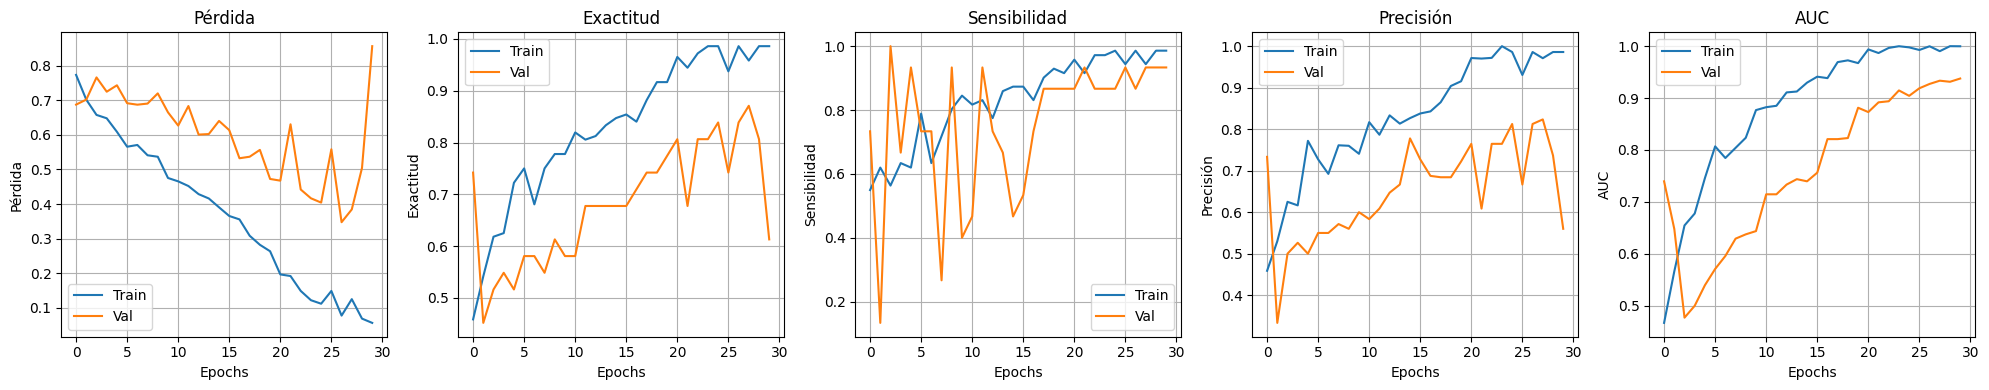

16/16 ━━━━━━━━━━━━━━━━━━━━ 136s 342ms/step

Métricas de evaluación:
Exactitud:     0.8438
Precisión:     0.8667
Sensibilidad:  0.8125
Especificidad: 0.8750
F1-score:      0.8387
AUC:           0.9023


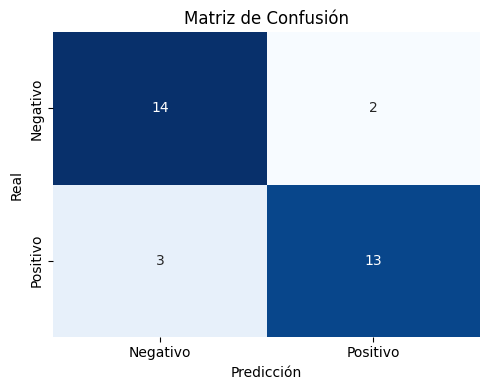

In [ ]:
p.plot_training(mobilenetv2_gru_model_history)
model_metrics_dataset(mobilenetv2_gru_model, test_ds)

In [ ]:
models_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models"

mobilenetv2_gru_model.save_weights('/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models/MOBILENETV2_GRU.weights.h5')

with open(os.path.join(models_dir, "MOBILENETV2_GRU_history.pkl"), "wb") as f:
    pickle.dump(mobilenetv2_gru_model_history.history, f)

## 4.3 - Modelado con *transfer learning* y modificaciones estructurales.

A pesar de que el modelo MobileNetV2-GRU ha mostrado el mejor rendimiento entre todos los modelos desarrollados, dado que el proyecto presenta una serie de restricciones temporales y computacionales se procede a explorar diferentes mejoras estructurales sobre la arquitectura VGG16-GRU. El objetivo es intentar desarrollar una arquitectura VGG16-GRU que ofrezca unos resultados similares obtenidos con el modelo MobileNetV2-GRU pero con un tiempo de entrenamiento significativamente inferior. Las técnicas que se implementarán son *slice stacking*, mecanismo de atención, y congelación de capas convolucionales.

### 4.3.1 - Modelo preentrenado con VGG-16 y *slice stacking*.

#### 4.3.1.1 - Preparación de los datos.

In [ ]:
base_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)"
data_dir = os.path.join(base_dir, "data/raw")
mask_dir = os.path.join(base_dir, "data/preprocessed/masks")
metadata_path = os.path.join(base_dir, "data/participants.tsv")
output_dir = os.path.join(base_dir, "data/splits")
output_X_path = os.path.join(output_dir, "X_stacked.npy")
output_y_path = os.path.join(output_dir, "y_stacked.npy")
output_ids_path = os.path.join(base_dir, "data/splits/subject_ids_stacked.npy")

In [ ]:
def apply_augmentations_2d(slice_2d, rotation=15, shift=0.05, flip=True):
    """
    Aplica transformaciones de data augmentation a una imagen 2D de resonancia magnética.

    Esta función realiza una rotación aleatoria, un desplazamiento aleatorio en ambos ejes y, opcionalmente,
    inversiones horizontales y/o verticales. Está pensada para introducir variabilidad espacial en cortes 2D
    individuales durante el preprocesado de datos fMRI.

    Parameters
    ----------
    slice_2d : np.ndarray
        Imagen 2D de entrada con forma (H, W), representando un único corte de resonancia magnética.
    rotation : float, optional
        Ángulo máximo de rotación en grados. El ángulo se elige aleatoriamente entre [-rotation, +rotation].
        Por defecto 15.
    shift : float, optional
        Porcentaje máximo de desplazamiento relativo al tamaño de la imagen. Se aplica en ambas direcciones (X, Y).
        Por defecto 0.05 (5%).
    flip : bool, optional
        Si es True, se aplican aleatoriamente inversiones vertical y/o horizontal. Por defecto True.

    Returns
    -------
    shifted : np.ndarray
        Imagen transformada con las mismas dimensiones que la imagen original.
    """
    import cv2
    import numpy as np

    X, Y = slice_2d.shape
    center = (Y // 2, X // 2)

    angle = np.random.uniform(-rotation, rotation)
    M_rot = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(slice_2d, M_rot, (Y, X), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

    dx = int(X * np.random.uniform(-shift, shift))
    dy = int(Y * np.random.uniform(-shift, shift))
    M_shift = np.float32([[1, 0, dx], [0, 1, dy]])
    shifted = cv2.warpAffine(rotated, M_shift, (Y, X), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

    if flip:
        if np.random.rand() > 0.5:
            shifted = cv2.flip(shifted, 0)
        if np.random.rand() > 0.5:
            shifted = cv2.flip(shifted, 1)

    return shifted

In [ ]:
def stack_as_channels(slices_2d):
    """
    Apila una secuencia de imágenes 2D en una única imagen multicanal.

    Esta función toma una lista o array de imágenes 2D y las apila a lo largo del eje de canales,
    generando un tensor 3D donde cada imagen 2D ocupa un canal distinto. Es útil para representar
    múltiples cortes como una única entrada multicanal para modelos de aprendizaje profundo.

    Parameters
    ----------
    slices_2d : list or np.ndarray
        Lista o array de imágenes 2D con forma (H, W), todas del mismo tamaño.

    Returns
    -------
    stacked : np.ndarray
        Imagen multicanal con forma (H, W, N), donde N es el número de cortes apilados.
    """
    return np.stack(slices_2d, axis=-1)

In [ ]:
def prepare_transfer_learning_slice_stacking(
    data_dir,
    mask_dir,
    metadata_path,
    output_X_path,
    output_y_path,
    output_ids_path,
    discard_volumes=5,
    target_size=(224, 224),
    control_aug=5,
    depressed_aug=2
):
    """
    Preprocesa volúmenes fMRI aplicando data augmentation y apilamiento de cortes adyacentes como canales RGB.

    Esta función selecciona el corte axial con mayor varianza de cada volumen fMRI, y utiliza ese corte junto con
    sus vecinos superior e inferior (z-1 y z+1) para formar imágenes de 3 canales. A cada imagen 2D se le aplican
    transformaciones de data augmentation, normalización y redimensionado. Se generan secuencias temporales de
    imágenes 3-canal para su uso en modelos preentrenados compatibles con entrada RGB (e.g., VGG, ResNet...).

    Parameters
    ----------
    data_dir : str
        Ruta al directorio con los archivos fMRI en formato `.nii.gz`.
    mask_dir : str
        Ruta al directorio con las máscaras cerebrales en formato `.npy`.
    metadata_path : str
        Ruta al archivo `.tsv` que contiene los metadatos y etiquetas por sujeto.
    output_X_path : str
        Ruta para guardar el array `X_stacked` con las secuencias generadas.
    output_y_path : str
        Ruta para guardar el array `y_stacked` con las etiquetas.
    output_ids_path : str
        Ruta para guardar la lista `subject_ids_stacked` con los IDs de los sujetos.
    discard_volumes : int, optional
        Número de primeros volúmenes a eliminar por ruido (por defecto 5).
    target_size : tuple, optional
        Tamaño objetivo para redimensionar cada imagen 2D (por defecto (224, 224)).
    control_aug : int, optional
        Número de secuencias aumentadas por sujeto control (por defecto 5).
    depressed_aug : int, optional
        Número de secuencias aumentadas por sujeto deprimido (por defecto 2).

    Returns
    -------
    X_stacked : np.ndarray
        Array de datos con forma (N, T, H, W, 3), donde cada frame tiene 3 canales (stacking).
    y_stacked : np.ndarray
        Array con las etiquetas correspondientes (0 = control, 1 = deprimido).
    subject_ids_stacked : list of str
        Lista con los IDs de sujeto asociados a cada muestra generada.

    Notes
    -----
    - Se descartan los sujetos cuyo corte óptimo esté en el borde (z=0 o z=Z-1), para asegurar que los vecinos existen.
    - Cada frame de la secuencia temporal representa el mismo plano axial en tres cortes consecutivos.
    """
    import os
    import numpy as np
    import pandas as pd
    import nibabel as nib
    from tqdm import tqdm

    X_stacked = []
    y_stacked = []
    subject_ids_stacked = []

    df_meta = pd.read_csv(metadata_path, sep='\t', index_col='participant_id')

    for file in tqdm(sorted(os.listdir(data_dir))):
        if not file.endswith(".nii.gz"):
            continue

        subject_id = file.split("_")[0]
        nii_path = os.path.join(data_dir, file)
        mask_path = os.path.join(mask_dir, f"{subject_id}_mask.npy")

        if subject_id not in df_meta.index or not os.path.exists(mask_path):
            continue

        label_str = df_meta.loc[subject_id, 'group']
        label = 0 if label_str == 'control' else 1
        n_aug = control_aug if label == 0 else depressed_aug

        img = nib.load(nii_path)
        data = img.get_fdata()
        if data.shape[3] <= discard_volumes:
            continue
        data_cut = data[..., discard_volumes:]

        mask = np.load(mask_path)
        masked_data = data_cut[mask].T
        volume_4d = p.reconstruct_volume(masked_data, mask)

        best_z = p.select_high_variance_slice(volume_4d)
        if best_z - 1 < 0 or best_z + 1 >= volume_4d.shape[2]:
            continue

        for _ in range(n_aug):
            sequence_slices = []

            for t in range(volume_4d.shape[3]):
                stack = []
                for z in [best_z - 1, best_z, best_z + 1]:
                    slice_2d = volume_4d[:, :, z, t]
                    augmented_slice = apply_augmentations_2d(slice_2d)
                    norm = p.normalize_zscore_2d(augmented_slice)
                    resized = resize_slice(norm, target_size)
                    stack.append(resized)

                slice_3channel = stack_as_channels(stack)
                sequence_slices.append(slice_3channel)

            sequence_array = np.stack(sequence_slices, axis=0)
            X_stacked.append(sequence_array)
            y_stacked.append(label)
            subject_ids_stacked.append(subject_id)

    X_stacked = np.array(X_stacked, dtype=np.float32)
    y_stacked = np.array(y_stacked, dtype=np.float32)

    np.save(output_X_path, X_stacked)
    np.save(output_y_path, y_stacked)
    np.save(output_ids_path, subject_ids_stacked)

    return X_stacked, y_stacked, subject_ids_stacked

In [ ]:
X_stacked, y_stacked, ids_stacked = prepare_transfer_learning_slice_stacking(
    data_dir=data_dir,
    mask_dir=mask_dir,
    metadata_path=metadata_path,
    output_X_path=output_X_path,
    output_y_path=output_y_path,
    output_ids_path=output_ids_path,
    discard_volumes=5,
    control_aug=5,
    depressed_aug=2
)

100%|██████████| 72/72 [02:35<00:00,  2.16s/it]


In [ ]:
X = np.load(os.path.join(base_dir, "data/splits/X_stacked.npy"))
y = np.load(os.path.join(base_dir, "data/splits/y_stacked.npy"))

In [ ]:
print(f"X shape: {X.shape}, dtype: {X.dtype}")
print(f"y shape: {y.shape}, dtype: {y.dtype}")

X shape: (207, 95, 224, 224, 3), dtype: float32
y shape: (207,), dtype: float32


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

In [ ]:
np.save(os.path.join(output_dir, "X_train_stacked.npy"), X_train)
np.save(os.path.join(output_dir, "y_train_stacked.npy"), y_train)
np.save(os.path.join(output_dir, "X_val_stacked.npy"), X_val)
np.save(os.path.join(output_dir, "y_val_stacked.npy"), y_val)
np.save(os.path.join(output_dir, "X_test_stacked.npy"), X_test)
np.save(os.path.join(output_dir, "y_test_stacked.npy"), y_test)

In [ ]:
input_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/data/splits/"

X_train = np.load(os.path.join(input_dir, "X_train_stacked.npy"))
y_train = np.load(os.path.join(input_dir, "y_train_stacked.npy"))
X_val = np.load(os.path.join(input_dir, "X_val_stacked.npy"))
y_val = np.load(os.path.join(input_dir, "y_val_stacked.npy"))
X_test = np.load(os.path.join(input_dir, "X_test_stacked.npy"))
y_test = np.load(os.path.join(input_dir, "y_test_stacked.npy"))

In [ ]:
print(f"Train: X={X_train.shape}, y={y_train.shape}, Controles={(y_train==0).sum()}, Deprimidos={(y_train==1).sum()}")
print(f"Val: X={X_val.shape}, y={y_val.shape}, Controles={(y_val==0).sum()}, Deprimidos={(y_val==1).sum()}")
print(f"Test: X={X_test.shape}, y={y_test.shape}, Controles={(y_test==0).sum()}, Deprimidos={(y_test==1).sum()}")

Train: X=(144, 95, 224, 224, 3), y=(144,), Controles=73, Deprimidos=71
Val: X=(31, 95, 224, 224, 3), y=(31,), Controles=16, Deprimidos=15
Test: X=(32, 95, 224, 224, 3), y=(32,), Controles=16, Deprimidos=16


In [ ]:
train_ds = p.create_dataset(X_train, y_train, batch_size=2, shuffle=True)
val_ds = p.create_dataset(X_val, y_val, batch_size=2)
test_ds = p.create_dataset(X_test, y_test, batch_size=2)

#### 4.3.1.2 - Generación e implementación de modelos con *slice stacking*

In [ ]:
vgg16_gru_stacked_model = VGG16_GRU(input_shape=X_train.shape[1:])

vgg16_gru_stacked_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
tracker = EmissionsTracker()
tracker.start()
start = time.time()

vgg16_gru_stacked_model_history = vgg16_gru_stacked_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)

end = time.time()
emissions = tracker.stop()
print(f"\nTiempo de entrenamiento: {(end - start):.2f} segundos")
print(f"\nEmisiones estimadas: {emissions:.4f} kg de CO2")

[codecarbon WARNING @ 09:48:42] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 09:48:42] [setup] RAM Tracking...
[codecarbon INFO @ 09:48:42] [setup] CPU Tracking...
[codecarbon WARNING @ 09:48:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 09:48:43] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 09:48:43] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 09:48:43] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 09:48:43] [setup] GPU Tracking...
[codecarbon INFO @ 09:48:43] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:48:43] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/30


[codecarbon INFO @ 09:48:59] Energy consumed for RAM : 0.000158 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:48:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:48:59] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 09:48:59] Energy consumed for all GPUs : 0.000246 kWh. Total GPU Power : 58.932572509335266 W
[codecarbon INFO @ 09:48:59] 0.000581 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:49:14] Energy consumed for RAM : 0.000316 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:49:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:49:14] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 09:49:14] Energy consumed for all GPUs : 0.000490 kWh. Total GPU Power : 58.654254950640656 W
[codecarbon INFO @ 09:49:14] 0.001161 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:49:29] Energy consumed for RAM : 0.000475 kWh. RAM Power :

59/72 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.4549 - auc: 0.4631 - loss: 0.7569 - precision: 0.4277 - recall: 0.7951

[codecarbon INFO @ 09:49:59] Energy consumed for RAM : 0.000791 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:49:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:49:59] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 09:49:59] Energy consumed for all GPUs : 0.001871 kWh. Total GPU Power : 213.87049749508805 W
[codecarbon INFO @ 09:49:59] 0.003548 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.4569 - auc: 0.4624 - loss: 0.7527 - precision: 0.4355 - recall: 0.7741

[codecarbon INFO @ 09:50:14] Energy consumed for RAM : 0.000949 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:50:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:50:14] Energy consumed for All CPU : 0.001062 kWh
[codecarbon INFO @ 09:50:14] Energy consumed for all GPUs : 0.002279 kWh. Total GPU Power : 97.91762928313065 W
[codecarbon INFO @ 09:50:14] 0.004291 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 97s 480ms/step - accuracy: 0.4570 - auc: 0.4623 - loss: 0.7525 - precision: 0.4360 - recall: 0.7726 - val_accuracy: 0.4839 - val_auc: 0.4750 - val_loss: 0.7024 - val_precision: 0.4839 - val_recall: 1.0000
Epoch 2/30
38/72 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.5905 - auc: 0.5855 - loss: 0.6875 - precision: 0.6131 - recall: 0.5546

[codecarbon INFO @ 09:50:29] Energy consumed for RAM : 0.001108 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:50:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:50:29] Energy consumed for All CPU : 0.001239 kWh
[codecarbon INFO @ 09:50:29] Energy consumed for all GPUs : 0.003108 kWh. Total GPU Power : 198.8475372806137 W
[codecarbon INFO @ 09:50:29] 0.005454 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step - accuracy: 0.5119 - auc: 0.5159 - loss: 0.7101 - precision: 0.5293 - recall: 0.5005 - val_accuracy: 0.4839 - val_auc: 0.5271 - val_loss: 0.6986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
24/72 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.6194 - auc: 0.5468 - loss: 0.7006 - precision: 0.6213 - recall: 0.5966

[codecarbon INFO @ 09:50:44] Energy consumed for RAM : 0.001266 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:50:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:50:44] Energy consumed for All CPU : 0.001416 kWh
[codecarbon INFO @ 09:50:44] Energy consumed for all GPUs : 0.004198 kWh. Total GPU Power : 261.8149917637588 W
[codecarbon INFO @ 09:50:44] 0.006880 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:50:44] 0.025949 g.CO2eq/s mean an estimation of 818.3369053504713 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step - accuracy: 0.5601 - auc: 0.5122 - loss: 0.7137 - precision: 0.5467 - recall: 0.5112 - val_accuracy: 0.4516 - val_auc: 0.4146 - val_loss: 0.7007 - val_precision: 0.4167 - val_recall: 0.3333
Epoch 4/30
11/72 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.5776 - auc: 0.4364 - loss: 0.7003 - precision: 0.6427 - recall: 0.4817

[codecarbon INFO @ 09:50:59] Energy consumed for RAM : 0.001424 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:50:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:50:59] Energy consumed for All CPU : 0.001593 kWh
[codecarbon INFO @ 09:50:59] Energy consumed for all GPUs : 0.005291 kWh. Total GPU Power : 262.3546908606314 W
[codecarbon INFO @ 09:50:59] 0.008309 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.5173 - auc: 0.4652 - loss: 0.7146 - precision: 0.5340 - recall: 0.5113

[codecarbon INFO @ 09:51:14] Energy consumed for RAM : 0.001583 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:51:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:51:14] Energy consumed for All CPU : 0.001770 kWh
[codecarbon INFO @ 09:51:14] Energy consumed for all GPUs : 0.006391 kWh. Total GPU Power : 263.9981604046372 W
[codecarbon INFO @ 09:51:14] 0.009744 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step - accuracy: 0.5169 - auc: 0.4653 - loss: 0.7146 - precision: 0.5333 - recall: 0.5107 - val_accuracy: 0.5161 - val_auc: 0.4792 - val_loss: 0.6990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.5311 - auc: 0.4936 - loss: 0.6891 - precision: 0.3787 - recall: 0.2869

[codecarbon INFO @ 09:51:29] Energy consumed for RAM : 0.001741 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:51:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:51:29] Energy consumed for All CPU : 0.001947 kWh
[codecarbon INFO @ 09:51:29] Energy consumed for all GPUs : 0.007486 kWh. Total GPU Power : 262.72509449041144 W
[codecarbon INFO @ 09:51:29] 0.011174 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step - accuracy: 0.5306 - auc: 0.4946 - loss: 0.6894 - precision: 0.3824 - recall: 0.2875 - val_accuracy: 0.4839 - val_auc: 0.4250 - val_loss: 0.7029 - val_precision: 0.4839 - val_recall: 1.0000
Epoch 6/30
57/72 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.4382 - auc: 0.4919 - loss: 0.7136 - precision: 0.4225 - recall: 0.5683

[codecarbon INFO @ 09:51:44] Energy consumed for RAM : 0.001899 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:51:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:51:44] Energy consumed for All CPU : 0.002124 kWh
[codecarbon INFO @ 09:51:44] Energy consumed for all GPUs : 0.008590 kWh. Total GPU Power : 265.13260081518627 W
[codecarbon INFO @ 09:51:44] 0.012613 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 248ms/step - accuracy: 0.4411 - auc: 0.4895 - loss: 0.7141 - precision: 0.4304 - recall: 0.5788 - val_accuracy: 0.5161 - val_auc: 0.5229 - val_loss: 0.6983 - val_precision: 0.5000 - val_recall: 0.5333


[codecarbon INFO @ 09:51:50] Energy consumed for RAM : 0.001962 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:51:50] Delta energy consumed for CPU with constant : 0.000071 kWh, power : 42.5 W
[codecarbon INFO @ 09:51:50] Energy consumed for All CPU : 0.002195 kWh
[codecarbon INFO @ 09:51:50] Energy consumed for all GPUs : 0.009029 kWh. Total GPU Power : 262.6701073146039 W
[codecarbon INFO @ 09:51:50] 0.013186 kWh of electricity used since the beginning.



Tiempo de entrenamiento: 186.02 segundos

Emisiones estimadas: 0.0060 kg de CO2


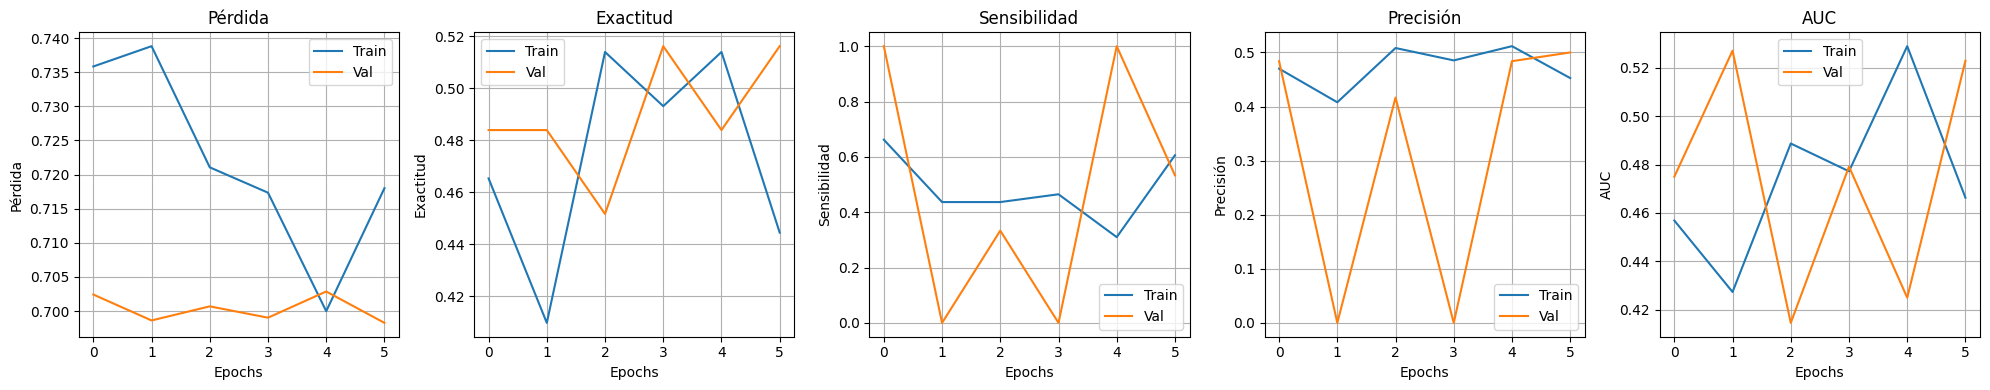

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step

Métricas de evaluación:
Exactitud:     0.5312
Precisión:     0.5161
Sensibilidad:  1.0000
Especificidad: 0.0625
F1-score:      0.6809
AUC:           0.4531


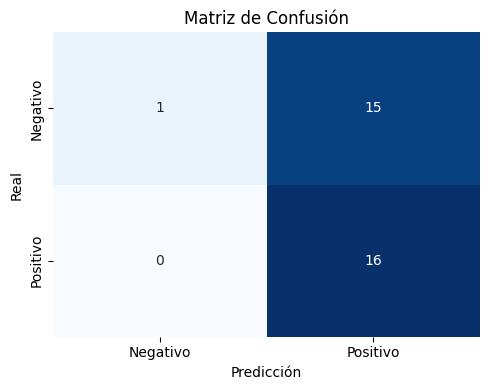

In [ ]:
p.plot_training(vgg16_gru_stacked_model_history)
model_metrics_dataset(vgg16_gru_stacked_model, test_ds)

In [ ]:
models_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models"

vgg16_gru_stacked_model.save_weights('/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models/VGG16_GRU_STACKED.weights.h5')

with open(os.path.join(models_dir, "VGG16_GRU_STACKED_history.pkl"), "wb") as f:
    pickle.dump(vgg16_gru_stacked_model_history.history, f)

### 4.3.2 -  Modelo preentrenado con VGG-16 y mecanismo de atención

In [ ]:
@tf.keras.utils.register_keras_serializable()
class VGG16_GRU_ATTENTION(tf.keras.Model):
    """
    Modelo híbrido basado en VGG16, GRU y mecanismo de atención para clasificación binaria de secuencias fMRI 2D.

    Esta arquitectura combina un backbone VGG16 preentrenado como extractor de características espaciales,
    una capa GRU para capturar la dinámica temporal y un mecanismo de atención que permite ponderar
    automáticamente la importancia de cada paso temporal en la predicción final. El uso de atención mejora
    la interpretabilidad del modelo, permitiendo identificar qué momentos dentro de la secuencia han sido más relevantes.

    Parameters
    ----------
    input_shape : tuple, optional
        Forma esperada de entrada sin incluir el batch. Por defecto (95, 224, 224, 3), donde:
            - 95 es el número de pasos temporales,
            - 224x224 el tamaño de las imágenes 2D,
            - 3 canales (RGB) para compatibilidad con VGG16 preentrenado.
    num_classes : int, optional
        Número de clases de salida. Por defecto 1 (clasificación binaria).
    gru_units : int, optional
        Número de unidades en la capa GRU. Por defecto 64.
    dropout_rate : float, optional
        Tasa de dropout aplicada tras la capa densa. Por defecto 0.5.

    Returns
    -------
    tf.Tensor
        Tensor con la probabilidad por clase. En clasificación binaria, tiene forma (batch_size, 1).

    Notes
    -----
    - La salida de la GRU se pasa por una capa densa (activación tanh) y luego por una capa softmax para obtener
      los pesos de atención por paso temporal.
    - El contexto se calcula como la suma ponderada de las salidas GRU, que luego se pasa por una capa densa y dropout.
    """
    def __init__(self, input_shape=(95, 224, 224, 3), num_classes=1, gru_units=64, dropout_rate=0.5):
        super(VGG16_GRU_ATTENTION, self).__init__()
        l2 = tf.keras.regularizers.l2(1e-4)

        base_cnn = tf.keras.applications.VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )
        base_cnn.trainable = False

        self.feature_extractor = tf.keras.Sequential([
            base_cnn,
            tf.keras.layers.GlobalAveragePooling2D()
        ])

        self.td_extractor = tf.keras.layers.TimeDistributed(self.feature_extractor)

        self.gru = tf.keras.layers.GRU(gru_units, return_sequences=True)

        self.attention_dense = tf.keras.layers.Dense(1, activation='tanh')
        self.attention_softmax = tf.keras.layers.Softmax(axis=1)

        self.dense = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.out = tf.keras.layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')

    def call(self, inputs, training=False):
        x = self.td_extractor(inputs)
        gru_out = self.gru(x)

        score = self.attention_dense(gru_out)
        weights = self.attention_softmax(score)
        context = tf.reduce_sum(gru_out * weights, axis=1)

        x = self.dense(context)
        if training:
            x = self.dropout(x, training=training)
        return self.out(x)

In [ ]:
vgg16_gru_attention_model = VGG16_GRU_ATTENTION(input_shape=X_train.shape[1:])

vgg16_gru_attention_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [ ]:
tracker = EmissionsTracker()
tracker.start()
start = time.time()

vgg16_gru_attention_model_history = vgg16_gru_attention_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)

end = time.time()
emissions = tracker.stop()
print(f"\nTiempo de entrenamiento: {(end - start):.2f} segundos")
print(f"\nEmisiones estimadas: {emissions:.4f} kg de CO2")

[codecarbon WARNING @ 10:07:01] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:07:01] [setup] RAM Tracking...
[codecarbon INFO @ 10:07:01] [setup] CPU Tracking...
[codecarbon WARNING @ 10:07:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:07:02] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 10:07:02] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 10:07:02] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:07:02] [setup] GPU Tracking...
[codecarbon INFO @ 10:07:02] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:07:02] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/30


[codecarbon INFO @ 10:07:17] Energy consumed for RAM : 0.000158 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:07:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:07:17] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 10:07:17] Energy consumed for all GPUs : 0.000245 kWh. Total GPU Power : 58.61495385149003 W
[codecarbon INFO @ 10:07:17] 0.000580 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:07:32] Energy consumed for RAM : 0.000317 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:07:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:07:32] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 10:07:32] Energy consumed for all GPUs : 0.000487 kWh. Total GPU Power : 58.28298378352857 W
[codecarbon INFO @ 10:07:32] 0.001158 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:07:47] Energy consumed for RAM : 0.000475 kWh. RAM Power : 3

12/72 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.4756 - auc: 0.4356 - loss: 0.7989 - precision: 0.3136 - recall: 0.4354

[codecarbon INFO @ 10:08:02] Energy consumed for RAM : 0.000633 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:08:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:08:02] Energy consumed for All CPU : 0.000708 kWh
[codecarbon INFO @ 10:08:02] Energy consumed for all GPUs : 0.001096 kWh. Total GPU Power : 87.61758984298199 W
[codecarbon INFO @ 10:08:02] 0.002437 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.5056 - auc: 0.5104 - loss: 0.7350 - precision: 0.4396 - recall: 0.4671

[codecarbon INFO @ 10:08:17] Energy consumed for RAM : 0.000791 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:08:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:08:17] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 10:08:17] Energy consumed for all GPUs : 0.002014 kWh. Total GPU Power : 220.19779447414373 W
[codecarbon INFO @ 10:08:17] 0.003690 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:08:32] Energy consumed for RAM : 0.000949 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:08:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:08:32] Energy consumed for All CPU : 0.001062 kWh
[codecarbon INFO @ 10:08:32] Energy consumed for all GPUs : 0.002375 kWh. Total GPU Power : 86.5953399103749 W
[codecarbon INFO @ 10:08:32] 0.004386 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 91s 468ms/step - accuracy: 0.5054 - auc: 0.5102 - loss: 0.7349 - precision: 0.4403 - recall: 0.4676 - val_accuracy: 0.5161 - val_auc: 0.6000 - val_loss: 0.6982 - val_precision: 0.5000 - val_recall: 0.8667
Epoch 2/30
68/72 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.4346 - auc: 0.4201 - loss: 0.7368 - precision: 0.4709 - recall: 0.5129

[codecarbon INFO @ 10:08:47] Energy consumed for RAM : 0.001107 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:08:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:08:47] Energy consumed for All CPU : 0.001239 kWh
[codecarbon INFO @ 10:08:47] Energy consumed for all GPUs : 0.003426 kWh. Total GPU Power : 252.42535241376595 W
[codecarbon INFO @ 10:08:47] 0.005772 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 249ms/step - accuracy: 0.4362 - auc: 0.4230 - loss: 0.7362 - precision: 0.4700 - recall: 0.5119 - val_accuracy: 0.5484 - val_auc: 0.5604 - val_loss: 0.6953 - val_precision: 0.5455 - val_recall: 0.4000
Epoch 3/30
54/72 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - accuracy: 0.5646 - auc: 0.5417 - loss: 0.7076 - precision: 0.5578 - recall: 0.4553

[codecarbon INFO @ 10:09:02] Energy consumed for RAM : 0.001266 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:09:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:09:02] Energy consumed for All CPU : 0.001416 kWh
[codecarbon INFO @ 10:09:02] Energy consumed for all GPUs : 0.004519 kWh. Total GPU Power : 262.31979032805157 W
[codecarbon INFO @ 10:09:02] 0.007201 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:09:02] 0.027157 g.CO2eq/s mean an estimation of 856.4131654792415 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 250ms/step - accuracy: 0.5550 - auc: 0.5462 - loss: 0.7063 - precision: 0.5500 - recall: 0.4540 - val_accuracy: 0.5161 - val_auc: 0.5917 - val_loss: 0.6956 - val_precision: 0.5000 - val_recall: 0.9333
Epoch 4/30
40/72 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - accuracy: 0.5109 - auc: 0.4477 - loss: 0.7355 - precision: 0.5432 - recall: 0.5402

[codecarbon INFO @ 10:09:17] Energy consumed for RAM : 0.001424 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:09:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:09:17] Energy consumed for All CPU : 0.001593 kWh
[codecarbon INFO @ 10:09:17] Energy consumed for all GPUs : 0.005626 kWh. Total GPU Power : 265.61853065793736 W
[codecarbon INFO @ 10:09:17] 0.008642 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 250ms/step - accuracy: 0.4806 - auc: 0.4334 - loss: 0.7361 - precision: 0.5034 - recall: 0.5442 - val_accuracy: 0.5484 - val_auc: 0.5708 - val_loss: 0.6933 - val_precision: 0.5263 - val_recall: 0.6667
Epoch 5/30
25/72 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.5975 - auc: 0.5184 - loss: 0.6710 - precision: 0.3903 - recall: 0.4496

[codecarbon INFO @ 10:09:32] Energy consumed for RAM : 0.001582 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:09:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:09:32] Energy consumed for All CPU : 0.001770 kWh
[codecarbon INFO @ 10:09:32] Energy consumed for all GPUs : 0.006733 kWh. Total GPU Power : 265.80595568852976 W
[codecarbon INFO @ 10:09:32] 0.010085 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 249ms/step - accuracy: 0.5645 - auc: 0.5201 - loss: 0.6905 - precision: 0.4435 - recall: 0.3870 - val_accuracy: 0.5161 - val_auc: 0.5604 - val_loss: 0.6956 - val_precision: 0.5000 - val_recall: 0.8000
Epoch 6/30
11/72 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 0.3105 - auc: 0.4071 - loss: 0.6986 - precision: 0.2639 - recall: 0.4599

[codecarbon INFO @ 10:09:47] Energy consumed for RAM : 0.001741 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:09:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:09:47] Energy consumed for All CPU : 0.001947 kWh
[codecarbon INFO @ 10:09:47] Energy consumed for all GPUs : 0.007849 kWh. Total GPU Power : 267.8082843628746 W
[codecarbon INFO @ 10:09:47] 0.011536 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.4754 - auc: 0.5375 - loss: 0.6893 - precision: 0.4638 - recall: 0.7001

[codecarbon INFO @ 10:10:02] Energy consumed for RAM : 0.001899 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:10:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:10:02] Energy consumed for All CPU : 0.002124 kWh
[codecarbon INFO @ 10:10:02] Energy consumed for all GPUs : 0.008963 kWh. Total GPU Power : 267.54526217998233 W
[codecarbon INFO @ 10:10:02] 0.012986 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 250ms/step - accuracy: 0.4759 - auc: 0.5377 - loss: 0.6894 - precision: 0.4644 - recall: 0.6994 - val_accuracy: 0.5806 - val_auc: 0.5771 - val_loss: 0.6915 - val_precision: 0.6250 - val_recall: 0.3333
Epoch 7/30
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5023 - auc: 0.5494 - loss: 0.7031 - precision: 0.5523 - recall: 0.4784

[codecarbon INFO @ 10:10:17] Energy consumed for RAM : 0.002057 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:10:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:10:17] Energy consumed for All CPU : 0.002301 kWh
[codecarbon INFO @ 10:10:17] Energy consumed for all GPUs : 0.010070 kWh. Total GPU Power : 265.6458082198838 W
[codecarbon INFO @ 10:10:17] 0.014428 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 249ms/step - accuracy: 0.5019 - auc: 0.5480 - loss: 0.7035 - precision: 0.5494 - recall: 0.4749 - val_accuracy: 0.5161 - val_auc: 0.5583 - val_loss: 0.6960 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 8/30
56/72 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - accuracy: 0.4605 - auc: 0.5796 - loss: 0.6903 - precision: 0.4215 - recall: 0.3330

[codecarbon INFO @ 10:10:32] Energy consumed for RAM : 0.002215 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:10:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:10:32] Energy consumed for All CPU : 0.002478 kWh
[codecarbon INFO @ 10:10:32] Energy consumed for all GPUs : 0.011183 kWh. Total GPU Power : 267.2834210555547 W
[codecarbon INFO @ 10:10:32] 0.015876 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 249ms/step - accuracy: 0.4757 - auc: 0.5792 - loss: 0.6896 - precision: 0.4427 - recall: 0.3776 - val_accuracy: 0.6452 - val_auc: 0.5792 - val_loss: 0.6905 - val_precision: 1.0000 - val_recall: 0.2667
Epoch 9/30
42/72 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - accuracy: 0.5779 - auc: 0.5432 - loss: 0.6939 - precision: 0.5634 - recall: 0.4091

[codecarbon INFO @ 10:10:47] Energy consumed for RAM : 0.002374 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:10:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:10:47] Energy consumed for All CPU : 0.002655 kWh
[codecarbon INFO @ 10:10:47] Energy consumed for all GPUs : 0.012290 kWh. Total GPU Power : 265.57301566290175 W
[codecarbon INFO @ 10:10:47] 0.017318 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 250ms/step - accuracy: 0.5388 - auc: 0.5159 - loss: 0.6996 - precision: 0.5022 - recall: 0.3601 - val_accuracy: 0.5161 - val_auc: 0.5750 - val_loss: 0.6917 - val_precision: 0.5000 - val_recall: 0.6000
Epoch 10/30
27/72 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.5956 - auc: 0.5528 - loss: 0.6945 - precision: 0.5654 - recall: 0.7827

[codecarbon INFO @ 10:11:02] Energy consumed for RAM : 0.002532 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:11:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:11:02] Energy consumed for All CPU : 0.002832 kWh
[codecarbon INFO @ 10:11:02] Energy consumed for all GPUs : 0.013403 kWh. Total GPU Power : 267.33392058382964 W
[codecarbon INFO @ 10:11:02] 0.018767 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:11:02] 0.043626 g.CO2eq/s mean an estimation of 1,375.805110168761 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 249ms/step - accuracy: 0.5756 - auc: 0.5552 - loss: 0.6935 - precision: 0.5578 - recall: 0.7685 - val_accuracy: 0.5806 - val_auc: 0.5792 - val_loss: 0.6887 - val_precision: 0.6250 - val_recall: 0.3333
Epoch 11/30
13/72 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step - accuracy: 0.7423 - auc: 0.6568 - loss: 0.6460 - precision: 0.8607 - recall: 0.6514

[codecarbon INFO @ 10:11:17] Energy consumed for RAM : 0.002690 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:11:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:11:17] Energy consumed for All CPU : 0.003009 kWh
[codecarbon INFO @ 10:11:17] Energy consumed for all GPUs : 0.014516 kWh. Total GPU Power : 267.089211206493 W
[codecarbon INFO @ 10:11:17] 0.020215 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5931 - auc: 0.5748 - loss: 0.6823 - precision: 0.5772 - recall: 0.4419

[codecarbon INFO @ 10:11:32] Energy consumed for RAM : 0.002848 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:11:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:11:32] Energy consumed for All CPU : 0.003186 kWh
[codecarbon INFO @ 10:11:32] Energy consumed for all GPUs : 0.015629 kWh. Total GPU Power : 267.30806975097687 W
[codecarbon INFO @ 10:11:32] 0.021664 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 248ms/step - accuracy: 0.5922 - auc: 0.5741 - loss: 0.6826 - precision: 0.5766 - recall: 0.4409 - val_accuracy: 0.4516 - val_auc: 0.5375 - val_loss: 0.6931 - val_precision: 0.4444 - val_recall: 0.5333
Epoch 12/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5921 - auc: 0.5861 - loss: 0.6895 - precision: 0.5657 - recall: 0.6636

[codecarbon INFO @ 10:11:47] Energy consumed for RAM : 0.003007 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:11:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:11:47] Energy consumed for All CPU : 0.003363 kWh
[codecarbon INFO @ 10:11:47] Energy consumed for all GPUs : 0.016733 kWh. Total GPU Power : 265.00996648910586 W
[codecarbon INFO @ 10:11:47] 0.023103 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 250ms/step - accuracy: 0.5914 - auc: 0.5854 - loss: 0.6896 - precision: 0.5653 - recall: 0.6615 - val_accuracy: 0.4516 - val_auc: 0.5354 - val_loss: 0.6924 - val_precision: 0.4500 - val_recall: 0.6000
Epoch 13/30
58/72 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.6317 - auc: 0.6579 - loss: 0.6737 - precision: 0.6143 - recall: 0.8199

[codecarbon INFO @ 10:12:02] Energy consumed for RAM : 0.003165 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:12:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:12:02] Energy consumed for All CPU : 0.003540 kWh
[codecarbon INFO @ 10:12:02] Energy consumed for all GPUs : 0.017842 kWh. Total GPU Power : 266.22201141599936 W
[codecarbon INFO @ 10:12:02] 0.024548 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 249ms/step - accuracy: 0.6153 - auc: 0.6351 - loss: 0.6786 - precision: 0.5958 - recall: 0.7992 - val_accuracy: 0.5484 - val_auc: 0.5396 - val_loss: 0.6903 - val_precision: 0.5556 - val_recall: 0.3333
Epoch 14/30
43/72 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.5820 - auc: 0.6364 - loss: 0.6669 - precision: 0.5408 - recall: 0.6357

[codecarbon INFO @ 10:12:17] Energy consumed for RAM : 0.003323 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:12:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:12:17] Energy consumed for All CPU : 0.003717 kWh
[codecarbon INFO @ 10:12:17] Energy consumed for all GPUs : 0.018949 kWh. Total GPU Power : 265.6804543387869 W
[codecarbon INFO @ 10:12:17] 0.025990 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 250ms/step - accuracy: 0.5800 - auc: 0.6456 - loss: 0.6699 - precision: 0.5508 - recall: 0.6743 - val_accuracy: 0.4839 - val_auc: 0.5333 - val_loss: 0.6907 - val_precision: 0.4545 - val_recall: 0.3333
Epoch 15/30
29/72 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.7059 - auc: 0.6388 - loss: 0.6562 - precision: 0.7712 - recall: 0.6985

[codecarbon INFO @ 10:12:32] Energy consumed for RAM : 0.003482 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:12:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:12:32] Energy consumed for All CPU : 0.003894 kWh
[codecarbon INFO @ 10:12:32] Energy consumed for all GPUs : 0.020054 kWh. Total GPU Power : 265.14257054640956 W
[codecarbon INFO @ 10:12:32] 0.027430 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 250ms/step - accuracy: 0.6354 - auc: 0.6028 - loss: 0.6759 - precision: 0.6821 - recall: 0.6037 - val_accuracy: 0.6129 - val_auc: 0.5188 - val_loss: 0.6910 - val_precision: 0.7143 - val_recall: 0.3333


[codecarbon INFO @ 10:12:44] Energy consumed for RAM : 0.003608 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:12:44] Delta energy consumed for CPU with constant : 0.000141 kWh, power : 42.5 W
[codecarbon INFO @ 10:12:44] Energy consumed for All CPU : 0.004035 kWh
[codecarbon INFO @ 10:12:44] Energy consumed for all GPUs : 0.020940 kWh. Total GPU Power : 267.2431451316249 W
[codecarbon INFO @ 10:12:44] 0.028583 kWh of electricity used since the beginning.



Tiempo de entrenamiento: 341.95 segundos

Emisiones estimadas: 0.0129 kg de CO2


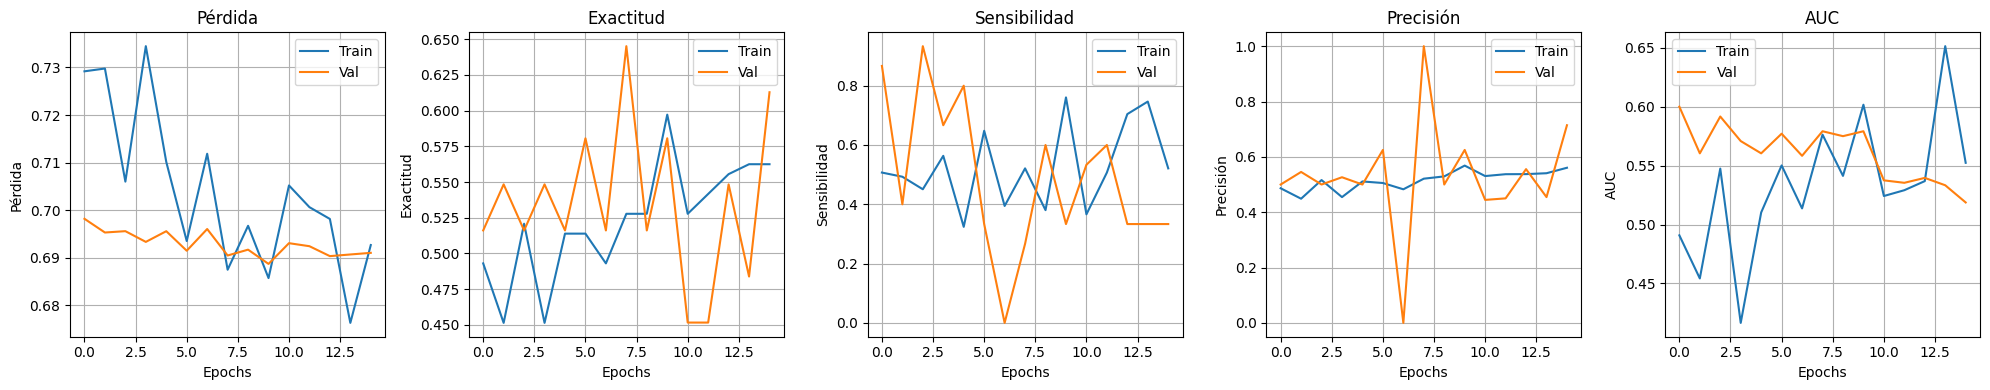

16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step

Métricas de evaluación:
Exactitud:     0.6562
Precisión:     0.7273
Sensibilidad:  0.5000
Especificidad: 0.8125
F1-score:      0.5926
AUC:           0.6562


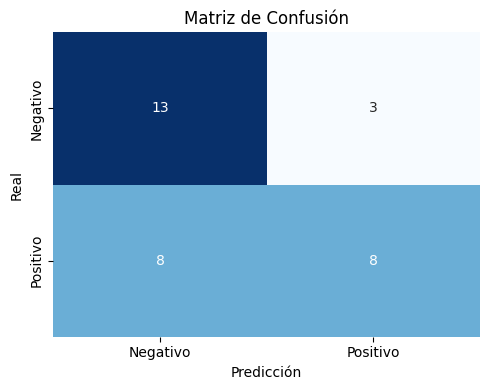

In [ ]:
p.plot_training(vgg16_gru_attention_model_history)
model_metrics_dataset(vgg16_gru_attention_model, test_ds)

In [ ]:
models_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models"

vgg16_gru_attention_model.save_weights('/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models/VGG16_GRU_ATTENTION.weights.h5')

with open(os.path.join(models_dir, "VGG16_GRU_ATTENTION_history.pkl"), "wb") as f:
    pickle.dump(vgg16_gru_attention_model_history.history, f)

### 4.3.3 -  Modelo preentrenado con VGG-16 y capas convolucionales descongeladas.

Dado que los resultados del modelo preentrenado con VGG-16 con todas las capas convolucionales congeladas no han sido óptimos, se procede implementar una nueva

In [ ]:
@tf.keras.utils.register_keras_serializable()
class VGG16_GRU_THAWED(tf.keras.Model):
    """
    Modelo híbrido VGG16-GRU con fine-tuning parcial para la clasificación binaria de secuencias fMRI 2D.

    Esta arquitectura combina VGG16 preentrenado sobre ImageNet como extractor espacial, una capa GRU para
    capturar información temporal, y una capa densa final para clasificación. A diferencia del modelo congelado,
    en esta variante se liberan los bloques convolucionales 4 y 5 de VGG16, permitiendo su ajuste durante
    el entrenamiento (fine-tuning) para una mejor adaptación al dominio de fMRI.

    Parameters
    ----------
    input_shape : tuple, optional
        Forma de entrada sin incluir el batch. Por defecto (95, 224, 224, 3), donde:
            - 95 es el número de pasos temporales,
            - 224x224 el tamaño de las imágenes 2D,
            - 3 canales (RGB) para compatibilidad con VGG16.
    num_classes : int, optional
        Número de clases. Por defecto 1 (clasificación binaria con activación sigmoide).
    gru_units : int, optional
        Número de unidades en la capa GRU. Por defecto 64.
    dropout_rate : float, optional
        Tasa de dropout aplicada tras la capa densa. Por defecto 0.5.

    Returns
    -------
    tf.Tensor
        Tensor con las probabilidades por clase. En clasificación binaria, su forma es (batch_size, 1).
    """
    def __init__(self, input_shape=(95, 224, 224, 3), num_classes=1, gru_units=64, dropout_rate=0.5):
        super(VGG16_GRU_THAWED, self).__init__()
        l2 = regularizers.l2(1e-4)

        base_cnn = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        set_trainable = False
        for layer in base_cnn.layers:
            if layer.name.startswith('block4') or layer.name.startswith('block5'):
                set_trainable = True
            layer.trainable = set_trainable

        self.feature_extractor = tf.keras.Sequential([
            base_cnn,
            layers.GlobalAveragePooling2D()
        ])

        self.td_extractor = layers.TimeDistributed(self.feature_extractor)

        self.gru = layers.GRU(gru_units, return_sequences=False)

        self.dense = layers.Dense(64, activation='relu', kernel_regularizer=l2)
        self.dropout = layers.Dropout(dropout_rate)
        self.out = layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')

    def call(self, inputs, training=False):
        x = self.td_extractor(inputs)
        x = self.gru(x)
        x = self.dense(x)
        if training:
            x = self.dropout(x, training=training)
        return self.out(x)

In [ ]:
vgg16_gru_thawed_model = VGG16_GRU_THAWED(input_shape=X_train.shape[1:])

vgg16_gru_thawed_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [ ]:
tracker = EmissionsTracker()
tracker.start()
start = time.time()

vgg16_gru_thawed_model_history = vgg16_gru_thawed_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)

end = time.time()
emissions = tracker.stop()
print(f"\nTiempo de entrenamiento: {(end - start):.2f} segundos")
print(f"\nEmisiones estimadas: {emissions:.4f} kg de CO2")

[codecarbon WARNING @ 10:15:03] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:15:03] [setup] RAM Tracking...
[codecarbon INFO @ 10:15:03] [setup] CPU Tracking...
[codecarbon WARNING @ 10:15:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:15:04] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 10:15:04] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 10:15:04] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:15:04] [setup] GPU Tracking...
[codecarbon INFO @ 10:15:04] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:15:04] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/30


[codecarbon INFO @ 10:15:20] Energy consumed for RAM : 0.000158 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:15:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:15:20] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 10:15:20] Energy consumed for all GPUs : 0.000249 kWh. Total GPU Power : 59.7242090086974 W
[codecarbon INFO @ 10:15:20] 0.000585 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:15:35] Energy consumed for RAM : 0.000316 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:15:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:15:35] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 10:15:35] Energy consumed for all GPUs : 0.000496 kWh. Total GPU Power : 59.37102114958317 W
[codecarbon INFO @ 10:15:35] 0.001167 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:15:50] Energy consumed for RAM : 0.000475 kWh. RAM Power : 38

37/72 ━━━━━━━━━━━━━━━━━━━━ 11s 329ms/step - accuracy: 0.4885 - auc: 0.4846 - loss: 0.7283 - precision: 0.4169 - recall: 0.2788

[codecarbon INFO @ 10:16:20] Energy consumed for RAM : 0.000791 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:16:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:16:20] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 10:16:20] Energy consumed for all GPUs : 0.001875 kWh. Total GPU Power : 212.17937795850776 W
[codecarbon INFO @ 10:16:20] 0.003551 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.4866 - auc: 0.4926 - loss: 0.7227 - precision: 0.4575 - recall: 0.3807

[codecarbon INFO @ 10:16:35] Energy consumed for RAM : 0.000949 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:16:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:16:35] Energy consumed for All CPU : 0.001062 kWh
[codecarbon INFO @ 10:16:35] Energy consumed for all GPUs : 0.002752 kWh. Total GPU Power : 210.4202597315184 W
[codecarbon INFO @ 10:16:35] 0.004764 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 104s 583ms/step - accuracy: 0.4862 - auc: 0.4927 - loss: 0.7226 - precision: 0.4574 - recall: 0.3819 - val_accuracy: 0.5161 - val_auc: 0.3458 - val_loss: 0.7058 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
 1/72 ━━━━━━━━━━━━━━━━━━━━ 23s 331ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.7931 - precision: 0.0000e+00 - recall: 0.0000e+00

[codecarbon INFO @ 10:16:50] Energy consumed for RAM : 0.001107 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:16:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:16:50] Energy consumed for All CPU : 0.001239 kWh
[codecarbon INFO @ 10:16:50] Energy consumed for all GPUs : 0.003188 kWh. Total GPU Power : 104.73560177502694 W
[codecarbon INFO @ 10:16:50] 0.005534 kWh of electricity used since the beginning.


47/72 ━━━━━━━━━━━━━━━━━━━━ 8s 330ms/step - accuracy: 0.4469 - auc: 0.4841 - loss: 0.7300 - precision: 0.4620 - recall: 0.3388

[codecarbon INFO @ 10:17:05] Energy consumed for RAM : 0.001266 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:17:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:17:05] Energy consumed for All CPU : 0.001416 kWh
[codecarbon INFO @ 10:17:05] Energy consumed for all GPUs : 0.004237 kWh. Total GPU Power : 251.83665709959087 W
[codecarbon INFO @ 10:17:05] 0.006919 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:17:05] 0.026094 g.CO2eq/s mean an estimation of 822.8871362025438 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 373ms/step - accuracy: 0.4510 - auc: 0.4830 - loss: 0.7264 - precision: 0.4569 - recall: 0.3386 - val_accuracy: 0.5161 - val_auc: 0.5000 - val_loss: 0.6988 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
11/72 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step - accuracy: 0.6464 - auc: 0.5482 - loss: 0.6700 - precision: 0.4706 - recall: 0.3480

[codecarbon INFO @ 10:17:20] Energy consumed for RAM : 0.001424 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:17:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:17:20] Energy consumed for All CPU : 0.001593 kWh
[codecarbon INFO @ 10:17:20] Energy consumed for all GPUs : 0.005299 kWh. Total GPU Power : 254.79278222374685 W
[codecarbon INFO @ 10:17:20] 0.008316 kWh of electricity used since the beginning.


56/72 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.5310 - auc: 0.5110 - loss: 0.7010 - precision: 0.4947 - recall: 0.3071

[codecarbon INFO @ 10:17:35] Energy consumed for RAM : 0.001582 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:17:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:17:35] Energy consumed for All CPU : 0.001770 kWh
[codecarbon INFO @ 10:17:35] Energy consumed for all GPUs : 0.006352 kWh. Total GPU Power : 252.88048958058766 W
[codecarbon INFO @ 10:17:35] 0.009704 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 373ms/step - accuracy: 0.5208 - auc: 0.4982 - loss: 0.7033 - precision: 0.4870 - recall: 0.3119 - val_accuracy: 0.5161 - val_auc: 0.4167 - val_loss: 0.6991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
20/72 ━━━━━━━━━━━━━━━━━━━━ 17s 330ms/step - accuracy: 0.3945 - auc: 0.5279 - loss: 0.7009 - precision: 0.5442 - recall: 0.3116

[codecarbon INFO @ 10:17:50] Energy consumed for RAM : 0.001741 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:17:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:17:50] Energy consumed for All CPU : 0.001947 kWh
[codecarbon INFO @ 10:17:50] Energy consumed for all GPUs : 0.007409 kWh. Total GPU Power : 253.58214631731596 W
[codecarbon INFO @ 10:17:50] 0.011096 kWh of electricity used since the beginning.


66/72 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step - accuracy: 0.4598 - auc: 0.5358 - loss: 0.6991 - precision: 0.5221 - recall: 0.3752

[codecarbon INFO @ 10:18:05] Energy consumed for RAM : 0.001899 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:18:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:18:05] Energy consumed for All CPU : 0.002124 kWh
[codecarbon INFO @ 10:18:05] Energy consumed for all GPUs : 0.008461 kWh. Total GPU Power : 252.63092202720472 W
[codecarbon INFO @ 10:18:05] 0.012484 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 373ms/step - accuracy: 0.4639 - auc: 0.5350 - loss: 0.6990 - precision: 0.5193 - recall: 0.3802 - val_accuracy: 0.5161 - val_auc: 0.5000 - val_loss: 0.6989 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
30/72 ━━━━━━━━━━━━━━━━━━━━ 13s 330ms/step - accuracy: 0.5080 - auc: 0.5926 - loss: 0.6940 - precision: 0.4915 - recall: 0.4540

[codecarbon INFO @ 10:18:20] Energy consumed for RAM : 0.002057 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:18:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:18:20] Energy consumed for All CPU : 0.002301 kWh
[codecarbon INFO @ 10:18:20] Energy consumed for all GPUs : 0.009520 kWh. Total GPU Power : 254.28380913477488 W
[codecarbon INFO @ 10:18:20] 0.013878 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.4867 - auc: 0.5269 - loss: 0.6979 - precision: 0.5001 - recall: 0.4624

[codecarbon INFO @ 10:18:35] Energy consumed for RAM : 0.002215 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:18:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:18:35] Energy consumed for All CPU : 0.002478 kWh
[codecarbon INFO @ 10:18:35] Energy consumed for all GPUs : 0.010571 kWh. Total GPU Power : 252.15735782408748 W
[codecarbon INFO @ 10:18:35] 0.015264 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 374ms/step - accuracy: 0.4867 - auc: 0.5261 - loss: 0.6979 - precision: 0.4998 - recall: 0.4631 - val_accuracy: 0.5484 - val_auc: 0.5000 - val_loss: 0.6988 - val_precision: 0.5185 - val_recall: 0.9333
Epoch 6/30
39/72 ━━━━━━━━━━━━━━━━━━━━ 10s 330ms/step - accuracy: 0.4995 - auc: 0.5540 - loss: 0.6963 - precision: 0.4299 - recall: 0.6051

[codecarbon INFO @ 10:18:50] Energy consumed for RAM : 0.002374 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:18:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:18:50] Energy consumed for All CPU : 0.002655 kWh
[codecarbon INFO @ 10:18:50] Energy consumed for all GPUs : 0.011645 kWh. Total GPU Power : 257.9529442278077 W
[codecarbon INFO @ 10:18:50] 0.016674 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 374ms/step - accuracy: 0.4959 - auc: 0.5245 - loss: 0.6981 - precision: 0.4483 - recall: 0.5524 - val_accuracy: 0.5161 - val_auc: 0.5000 - val_loss: 0.6987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/30
 3/72 ━━━━━━━━━━━━━━━━━━━━ 22s 328ms/step - accuracy: 0.5000 - auc: 0.0000e+00 - loss: 0.7028 - precision: 0.0000e+00 - recall: 0.0000e+00

[codecarbon INFO @ 10:19:05] Energy consumed for RAM : 0.002532 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:19:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:19:05] Energy consumed for All CPU : 0.002832 kWh
[codecarbon INFO @ 10:19:05] Energy consumed for all GPUs : 0.012724 kWh. Total GPU Power : 258.98709145153344 W
[codecarbon INFO @ 10:19:05] 0.018088 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:19:05] 0.042129 g.CO2eq/s mean an estimation of 1,328.5788363064332 kg.CO2eq/year


49/72 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step - accuracy: 0.3953 - auc: 0.3805 - loss: 0.7006 - precision: 0.2309 - recall: 0.1579

[codecarbon INFO @ 10:19:20] Energy consumed for RAM : 0.002690 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:19:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:19:20] Energy consumed for All CPU : 0.003009 kWh
[codecarbon INFO @ 10:19:20] Energy consumed for all GPUs : 0.013789 kWh. Total GPU Power : 255.63400289938127 W
[codecarbon INFO @ 10:19:20] 0.019489 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 373ms/step - accuracy: 0.4032 - auc: 0.4062 - loss: 0.7005 - precision: 0.2867 - recall: 0.2205 - val_accuracy: 0.5161 - val_auc: 0.5000 - val_loss: 0.6986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 8/30
13/72 ━━━━━━━━━━━━━━━━━━━━ 19s 328ms/step - accuracy: 0.2662 - auc: 0.3335 - loss: 0.7005 - precision: 0.0000e+00 - recall: 0.0000e+00

[codecarbon INFO @ 10:19:35] Energy consumed for RAM : 0.002849 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:19:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:19:35] Energy consumed for All CPU : 0.003186 kWh
[codecarbon INFO @ 10:19:35] Energy consumed for all GPUs : 0.014868 kWh. Total GPU Power : 258.93799855375266 W
[codecarbon INFO @ 10:19:35] 0.020903 kWh of electricity used since the beginning.


58/72 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step - accuracy: 0.3313 - auc: 0.4378 - loss: 0.6996 - precision: 0.2537 - recall: 0.1770

[codecarbon INFO @ 10:19:50] Energy consumed for RAM : 0.003007 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:19:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:19:50] Energy consumed for All CPU : 0.003363 kWh
[codecarbon INFO @ 10:19:50] Energy consumed for all GPUs : 0.015925 kWh. Total GPU Power : 253.79043756910403 W
[codecarbon INFO @ 10:19:50] 0.022295 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 373ms/step - accuracy: 0.3545 - auc: 0.4462 - loss: 0.6995 - precision: 0.2889 - recall: 0.2127 - val_accuracy: 0.5161 - val_auc: 0.5000 - val_loss: 0.6985 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 9/30
22/72 ━━━━━━━━━━━━━━━━━━━━ 16s 329ms/step - accuracy: 0.4692 - auc: 0.4656 - loss: 0.6996 - precision: 0.9638 - recall: 0.2666

[codecarbon INFO @ 10:20:05] Energy consumed for RAM : 0.003165 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:20:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:20:05] Energy consumed for All CPU : 0.003540 kWh
[codecarbon INFO @ 10:20:05] Energy consumed for all GPUs : 0.016989 kWh. Total GPU Power : 255.45289922201525 W
[codecarbon INFO @ 10:20:05] 0.023695 kWh of electricity used since the beginning.


68/72 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step - accuracy: 0.5111 - auc: 0.4849 - loss: 0.6989 - precision: 0.7175 - recall: 0.3777

[codecarbon INFO @ 10:20:20] Energy consumed for RAM : 0.003323 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:20:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:20:20] Energy consumed for All CPU : 0.003717 kWh
[codecarbon INFO @ 10:20:20] Energy consumed for all GPUs : 0.018037 kWh. Total GPU Power : 251.4527828522673 W
[codecarbon INFO @ 10:20:20] 0.025078 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 373ms/step - accuracy: 0.5129 - auc: 0.4861 - loss: 0.6989 - precision: 0.7051 - recall: 0.3804 - val_accuracy: 0.5161 - val_auc: 0.5000 - val_loss: 0.6985 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 10/30
32/72 ━━━━━━━━━━━━━━━━━━━━ 13s 329ms/step - accuracy: 0.4916 - auc: 0.5030 - loss: 0.6980 - precision: 0.1242 - recall: 0.0391

[codecarbon INFO @ 10:20:35] Energy consumed for RAM : 0.003482 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:20:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:20:35] Energy consumed for All CPU : 0.003894 kWh
[codecarbon INFO @ 10:20:35] Energy consumed for all GPUs : 0.019107 kWh. Total GPU Power : 256.7918460510035 W
[codecarbon INFO @ 10:20:35] 0.026483 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.5000 - auc: 0.4903 - loss: 0.6983 - precision: 0.3262 - recall: 0.1118

[codecarbon INFO @ 10:20:50] Energy consumed for RAM : 0.003640 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:20:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:20:50] Energy consumed for All CPU : 0.004071 kWh
[codecarbon INFO @ 10:20:50] Energy consumed for all GPUs : 0.020161 kWh. Total GPU Power : 253.13431060844593 W
[codecarbon INFO @ 10:20:50] 0.027873 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 373ms/step - accuracy: 0.5004 - auc: 0.4906 - loss: 0.6983 - precision: 0.3292 - recall: 0.1133 - val_accuracy: 0.5161 - val_auc: 0.5000 - val_loss: 0.6984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


[codecarbon INFO @ 10:20:51] Energy consumed for RAM : 0.003652 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:20:51] Delta energy consumed for CPU with constant : 0.000014 kWh, power : 42.5 W
[codecarbon INFO @ 10:20:51] Energy consumed for All CPU : 0.004085 kWh
[codecarbon INFO @ 10:20:51] Energy consumed for all GPUs : 0.020248 kWh. Total GPU Power : 265.54737952748195 W
[codecarbon INFO @ 10:20:51] 0.027986 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:20:51] 0.042189 g.CO2eq/s mean an estimation of 1,330.4794602256309 kg.CO2eq/year



Tiempo de entrenamiento: 346.19 segundos

Emisiones estimadas: 0.0127 kg de CO2


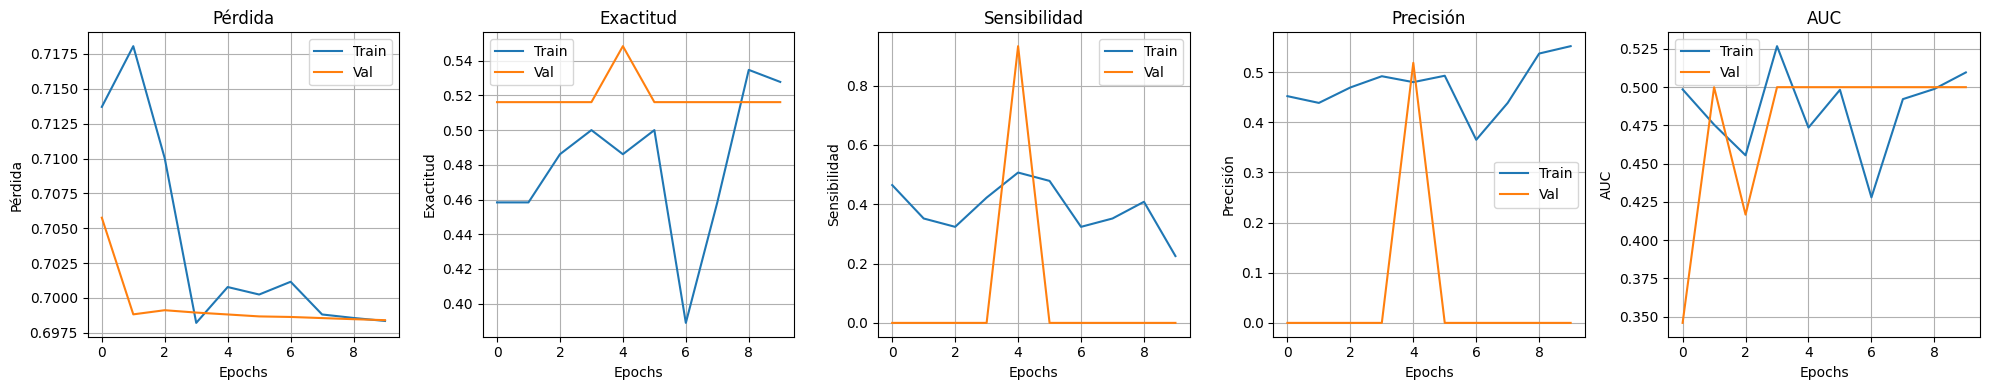

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step

Métricas de evaluación:
Exactitud:     0.6562
Precisión:     0.6000
Sensibilidad:  0.9375
Especificidad: 0.3750
F1-score:      0.7317
AUC:           0.6328


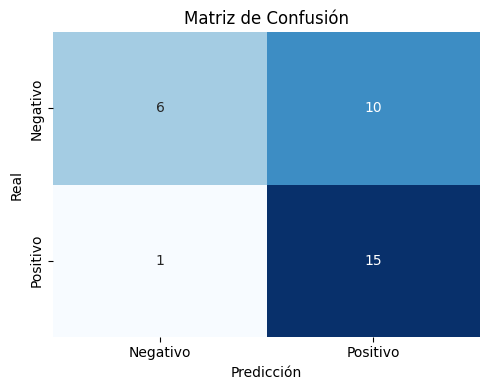

In [ ]:
p.plot_training(vgg16_gru_thawed_model_history)
model_metrics_dataset(vgg16_gru_thawed_model, test_ds)

In [ ]:
models_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models"

vgg16_gru_thawed_model.save_weights('/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models/VGG16_GRU_THAWED.weights.h5')

with open(os.path.join(models_dir, "VGG16_GRU_THAWED_history.pkl"), "wb") as f:
    pickle.dump(vgg16_gru_thawed_model_history.history, f)

## 4.4 - Modelado con manejo de *noisy labels*.
En esta sección se aborda la posible presencia de etiquetas erróneas en los datos mediante la implementación de distintas funciones de pérdida robustas, de acuerdo con las recomendaciones de Karimi et al., (2020).

### 4.4.1 - Modelo preentrenado con MobileNetV2 con *focal loss*.

In [ ]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    """
    Devuelve una función de pérdida focal binaria personalizada.

    La focal loss penaliza con mayor intensidad los errores en ejemplos difíciles y reduce la contribución
    de los ejemplos correctamente clasificados con alta confianza. Esto la hace especialmente útil en contextos
    con clases desbalanceadas o donde se desea mejorar la sensibilidad del modelo.

    Parameters
    ----------
    gamma : float, optional
        Factor de modulación que controla la importancia de los ejemplos fáciles. Valores mayores a 1
        penalizan más los errores en ejemplos difíciles. Por defecto 2.0.
    alpha : float, optional
        Factor de ponderación para la clase positiva. Por defecto 0.25.

    Returns
    -------
    loss_fn : function
        Función de pérdida que puede ser usada al compilar un modelo Keras.

    Notes
    -----
    - Se aplica `clip_by_value` para evitar logaritmos de 0.
    - La implementación está pensada para clasificación binaria con activación sigmoide en la salida.
    """
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1. - 1e-7)

        cross_entropy = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        weight = alpha * tf.pow(1 - y_pred, gamma) * y_true + \
                 (1 - alpha) * tf.pow(y_pred, gamma) * (1 - y_true)

        return tf.reduce_mean(weight * cross_entropy)
    return loss

In [ ]:
mobilenetv2_gru_focal_loss_model = MOBILENETV2_GRU(input_shape=X_train.shape[1:])

mobilenetv2_gru_focal_loss_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=binary_focal_loss(gamma=2.0, alpha=0.25),
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
tracker = EmissionsTracker()
tracker.start()
start = time.time()

mobilenetv2_gru_focal_loss_model_history = mobilenetv2_gru_focal_loss_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)

end = time.time()
emissions = tracker.stop()
print(f"\nTiempo de entrenamiento: {(end - start):.2f} segundos")
print(f"\nEmisiones estimadas: {emissions:.4f} kg de CO2")

[codecarbon WARNING @ 10:42:54] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:42:54] [setup] RAM Tracking...
[codecarbon INFO @ 10:42:54] [setup] CPU Tracking...
[codecarbon WARNING @ 10:42:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:42:55] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 10:42:55] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 10:42:55] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:42:55] [setup] GPU Tracking...
[codecarbon INFO @ 10:42:55] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:42:55] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/30


[codecarbon INFO @ 10:43:11] Energy consumed for RAM : 0.000158 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:43:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:43:11] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 10:43:11] Energy consumed for all GPUs : 0.000246 kWh. Total GPU Power : 58.89359591494981 W
[codecarbon INFO @ 10:43:11] 0.000581 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:43:26] Energy consumed for RAM : 0.000316 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:43:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:43:26] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 10:43:26] Energy consumed for all GPUs : 0.000493 kWh. Total GPU Power : 59.37975236945948 W
[codecarbon INFO @ 10:43:26] 0.001163 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:43:41] Energy consumed for RAM : 0.000475 kWh. RAM Power : 3

41/72 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.4898 - auc: 0.3723 - loss: 0.1965 - precision: 0.3912 - recall: 0.4575

[codecarbon INFO @ 10:50:26] Energy consumed for RAM : 0.004746 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:50:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:50:26] Energy consumed for All CPU : 0.005311 kWh
[codecarbon INFO @ 10:50:26] Energy consumed for all GPUs : 0.007594 kWh. Total GPU Power : 104.90011193984814 W
[codecarbon INFO @ 10:50:26] 0.017651 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.4739 - auc: 0.3848 - loss: 0.1705 - precision: 0.3945 - recall: 0.3600

[codecarbon INFO @ 10:50:41] Energy consumed for RAM : 0.004904 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:50:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:50:41] Energy consumed for All CPU : 0.005488 kWh
[codecarbon INFO @ 10:50:41] Energy consumed for all GPUs : 0.008000 kWh. Total GPU Power : 97.33534934153163 W
[codecarbon INFO @ 10:50:41] 0.018392 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:50:56] Energy consumed for RAM : 0.005062 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:50:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:50:56] Energy consumed for All CPU : 0.005665 kWh
[codecarbon INFO @ 10:50:56] Energy consumed for all GPUs : 0.008248 kWh. Total GPU Power : 59.65238050670223 W
[codecarbon INFO @ 10:50:56] 0.018975 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:50:56] 0.018888 g.CO2eq/s mean an estimation of 595.64975248

72/72 ━━━━━━━━━━━━━━━━━━━━ 594s 2s/step - accuracy: 0.4739 - auc: 0.3855 - loss: 0.1698 - precision: 0.3950 - recall: 0.3584 - val_accuracy: 0.5161 - val_auc: 0.6042 - val_loss: 0.0756 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
18/72 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - accuracy: 0.5792 - auc: 0.5820 - loss: 0.0788 - precision: 0.7951 - recall: 0.2528

[codecarbon INFO @ 10:52:56] Energy consumed for RAM : 0.006327 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:52:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:52:56] Energy consumed for All CPU : 0.007080 kWh
[codecarbon INFO @ 10:52:56] Energy consumed for all GPUs : 0.010386 kWh. Total GPU Power : 97.46281597541457 W
[codecarbon INFO @ 10:52:56] 0.023793 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:52:56] 0.018167 g.CO2eq/s mean an estimation of 572.9066584650077 kg.CO2eq/year


58/72 ━━━━━━━━━━━━━━━━━━━━ 5s 369ms/step - accuracy: 0.5785 - auc: 0.6011 - loss: 0.0827 - precision: 0.7607 - recall: 0.2837

[codecarbon INFO @ 10:53:11] Energy consumed for RAM : 0.006486 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:53:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:53:11] Energy consumed for All CPU : 0.007257 kWh
[codecarbon INFO @ 10:53:11] Energy consumed for all GPUs : 0.010832 kWh. Total GPU Power : 107.13571143531021 W
[codecarbon INFO @ 10:53:11] 0.024575 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 450ms/step - accuracy: 0.5744 - auc: 0.5942 - loss: 0.0840 - precision: 0.7463 - recall: 0.2738 - val_accuracy: 0.5161 - val_auc: 0.6250 - val_loss: 0.0755 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
12/72 ━━━━━━━━━━━━━━━━━━━━ 21s 355ms/step - accuracy: 0.4696 - auc: 0.6940 - loss: 0.0794 - precision: 0.1944 - recall: 0.0713

[codecarbon INFO @ 10:53:26] Energy consumed for RAM : 0.006644 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:53:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:53:26] Energy consumed for All CPU : 0.007434 kWh
[codecarbon INFO @ 10:53:26] Energy consumed for all GPUs : 0.011275 kWh. Total GPU Power : 106.28783660487541 W
[codecarbon INFO @ 10:53:26] 0.025353 kWh of electricity used since the beginning.


53/72 ━━━━━━━━━━━━━━━━━━━━ 6s 363ms/step - accuracy: 0.5293 - auc: 0.5966 - loss: 0.0822 - precision: 0.5052 - recall: 0.1188

[codecarbon INFO @ 10:53:41] Energy consumed for RAM : 0.006802 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:53:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:53:41] Energy consumed for All CPU : 0.007611 kWh
[codecarbon INFO @ 10:53:41] Energy consumed for all GPUs : 0.011712 kWh. Total GPU Power : 104.868681286359 W
[codecarbon INFO @ 10:53:41] 0.026125 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 440ms/step - accuracy: 0.5353 - auc: 0.6004 - loss: 0.0822 - precision: 0.5599 - recall: 0.1304 - val_accuracy: 0.5484 - val_auc: 0.6125 - val_loss: 0.0819 - val_precision: 1.0000 - val_recall: 0.0667
Epoch 4/30
 8/72 ━━━━━━━━━━━━━━━━━━━━ 23s 362ms/step - accuracy: 0.4771 - auc: 0.3600 - loss: 0.1006 - precision: 0.7500 - recall: 0.2326

[codecarbon INFO @ 10:53:56] Energy consumed for RAM : 0.006960 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:53:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:53:56] Energy consumed for All CPU : 0.007788 kWh
[codecarbon INFO @ 10:53:56] Energy consumed for all GPUs : 0.012155 kWh. Total GPU Power : 106.3444958472206 W
[codecarbon INFO @ 10:53:56] 0.026904 kWh of electricity used since the beginning.


49/72 ━━━━━━━━━━━━━━━━━━━━ 8s 364ms/step - accuracy: 0.4906 - auc: 0.4976 - loss: 0.0903 - precision: 0.5371 - recall: 0.1763

[codecarbon INFO @ 10:54:11] Energy consumed for RAM : 0.007119 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:54:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:54:11] Energy consumed for All CPU : 0.007965 kWh
[codecarbon INFO @ 10:54:11] Energy consumed for all GPUs : 0.012592 kWh. Total GPU Power : 104.92330699321212 W
[codecarbon INFO @ 10:54:11] 0.027676 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 444ms/step - accuracy: 0.5059 - auc: 0.5348 - loss: 0.0869 - precision: 0.5677 - recall: 0.1863 - val_accuracy: 0.5161 - val_auc: 0.7271 - val_loss: 0.0723 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
 2/72 ━━━━━━━━━━━━━━━━━━━━ 25s 367ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 0.0633 - precision: 0.0000e+00 - recall: 0.0000e+00

[codecarbon INFO @ 10:54:26] Energy consumed for RAM : 0.007277 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:54:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:54:26] Energy consumed for All CPU : 0.008142 kWh
[codecarbon INFO @ 10:54:26] Energy consumed for all GPUs : 0.013031 kWh. Total GPU Power : 105.2668749715455 W
[codecarbon INFO @ 10:54:26] 0.028450 kWh of electricity used since the beginning.


44/72 ━━━━━━━━━━━━━━━━━━━━ 10s 358ms/step - accuracy: 0.6574 - auc: 0.6560 - loss: 0.0680 - precision: 0.3704 - recall: 0.0543

[codecarbon INFO @ 10:54:41] Energy consumed for RAM : 0.007435 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:54:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:54:41] Energy consumed for All CPU : 0.008319 kWh
[codecarbon INFO @ 10:54:41] Energy consumed for all GPUs : 0.013474 kWh. Total GPU Power : 106.32408714512651 W
[codecarbon INFO @ 10:54:41] 0.029228 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6393 - auc: 0.6891 - loss: 0.0677 - precision: 0.5269 - recall: 0.1087

[codecarbon INFO @ 10:54:56] Energy consumed for RAM : 0.007594 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:54:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:54:56] Energy consumed for All CPU : 0.008496 kWh
[codecarbon INFO @ 10:54:56] Energy consumed for all GPUs : 0.013912 kWh. Total GPU Power : 105.2780691085602 W
[codecarbon INFO @ 10:54:56] 0.030002 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:54:56] 0.023418 g.CO2eq/s mean an estimation of 738.494527975867 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 440ms/step - accuracy: 0.6385 - auc: 0.6900 - loss: 0.0677 - precision: 0.5305 - recall: 0.1101 - val_accuracy: 0.6774 - val_auc: 0.6854 - val_loss: 0.0811 - val_precision: 0.7778 - val_recall: 0.4667
Epoch 6/30
40/72 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.6929 - auc: 0.7550 - loss: 0.0680 - precision: 0.7811 - recall: 0.4406

[codecarbon INFO @ 10:55:11] Energy consumed for RAM : 0.007752 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:55:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:55:11] Energy consumed for All CPU : 0.008673 kWh
[codecarbon INFO @ 10:55:11] Energy consumed for all GPUs : 0.014351 kWh. Total GPU Power : 105.33842411386581 W
[codecarbon INFO @ 10:55:11] 0.030776 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.6501 - auc: 0.7496 - loss: 0.0680 - precision: 0.7560 - recall: 0.3776

[codecarbon INFO @ 10:55:26] Energy consumed for RAM : 0.007910 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:55:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:55:26] Energy consumed for All CPU : 0.008850 kWh
[codecarbon INFO @ 10:55:26] Energy consumed for all GPUs : 0.014794 kWh. Total GPU Power : 106.38212220736911 W
[codecarbon INFO @ 10:55:26] 0.031555 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 440ms/step - accuracy: 0.6494 - auc: 0.7498 - loss: 0.0680 - precision: 0.7558 - recall: 0.3762 - val_accuracy: 0.5806 - val_auc: 0.6271 - val_loss: 0.0788 - val_precision: 1.0000 - val_recall: 0.1333
Epoch 7/30
35/72 ━━━━━━━━━━━━━━━━━━━━ 13s 358ms/step - accuracy: 0.7020 - auc: 0.8358 - loss: 0.0608 - precision: 0.8695 - recall: 0.6133

[codecarbon INFO @ 10:55:41] Energy consumed for RAM : 0.008068 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:55:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:55:41] Energy consumed for All CPU : 0.009028 kWh
[codecarbon INFO @ 10:55:41] Energy consumed for all GPUs : 0.015232 kWh. Total GPU Power : 105.20380469327579 W
[codecarbon INFO @ 10:55:41] 0.032328 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6713 - auc: 0.7973 - loss: 0.0645 - precision: 0.7968 - recall: 0.5091

[codecarbon INFO @ 10:55:56] Energy consumed for RAM : 0.008227 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:55:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:55:56] Energy consumed for All CPU : 0.009205 kWh
[codecarbon INFO @ 10:55:56] Energy consumed for all GPUs : 0.015672 kWh. Total GPU Power : 105.52064757673165 W
[codecarbon INFO @ 10:55:56] 0.033103 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 438ms/step - accuracy: 0.6710 - auc: 0.7970 - loss: 0.0645 - precision: 0.7963 - recall: 0.5077 - val_accuracy: 0.6452 - val_auc: 0.7042 - val_loss: 0.0757 - val_precision: 1.0000 - val_recall: 0.2667
Epoch 8/30
31/72 ━━━━━━━━━━━━━━━━━━━━ 14s 364ms/step - accuracy: 0.7404 - auc: 0.8725 - loss: 0.0577 - precision: 0.8227 - recall: 0.5166

[codecarbon INFO @ 10:56:11] Energy consumed for RAM : 0.008385 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:56:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:56:11] Energy consumed for All CPU : 0.009382 kWh
[codecarbon INFO @ 10:56:11] Energy consumed for all GPUs : 0.016114 kWh. Total GPU Power : 106.14159828802681 W
[codecarbon INFO @ 10:56:11] 0.033881 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.6993 - auc: 0.8445 - loss: 0.0597 - precision: 0.8282 - recall: 0.4780

[codecarbon INFO @ 10:56:26] Energy consumed for RAM : 0.008543 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:56:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:56:26] Energy consumed for All CPU : 0.009559 kWh
[codecarbon INFO @ 10:56:26] Energy consumed for all GPUs : 0.016553 kWh. Total GPU Power : 105.26175289455014 W
[codecarbon INFO @ 10:56:26] 0.034654 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 443ms/step - accuracy: 0.6986 - auc: 0.8440 - loss: 0.0598 - precision: 0.8281 - recall: 0.4767 - val_accuracy: 0.5161 - val_auc: 0.7667 - val_loss: 0.0711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 9/30
26/72 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.5969 - auc: 0.8551 - loss: 0.0618 - precision: 0.8365 - recall: 0.2295

[codecarbon INFO @ 10:56:41] Energy consumed for RAM : 0.008701 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:56:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:56:41] Energy consumed for All CPU : 0.009736 kWh
[codecarbon INFO @ 10:56:41] Energy consumed for all GPUs : 0.016992 kWh. Total GPU Power : 105.37355641915507 W
[codecarbon INFO @ 10:56:41] 0.035429 kWh of electricity used since the beginning.


67/72 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step - accuracy: 0.6206 - auc: 0.8192 - loss: 0.0620 - precision: 0.8549 - recall: 0.2123

[codecarbon INFO @ 10:56:56] Energy consumed for RAM : 0.008860 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:56:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:56:56] Energy consumed for All CPU : 0.009913 kWh
[codecarbon INFO @ 10:56:56] Energy consumed for all GPUs : 0.017433 kWh. Total GPU Power : 105.89151858443398 W
[codecarbon INFO @ 10:56:56] 0.036205 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:56:56] 0.023397 g.CO2eq/s mean an estimation of 737.8403300624542 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 444ms/step - accuracy: 0.6221 - auc: 0.8208 - loss: 0.0618 - precision: 0.8593 - recall: 0.2189 - val_accuracy: 0.8387 - val_auc: 0.8042 - val_loss: 0.0716 - val_precision: 0.9167 - val_recall: 0.7333
Epoch 10/30
21/72 ━━━━━━━━━━━━━━━━━━━━ 18s 364ms/step - accuracy: 0.7984 - auc: 0.8409 - loss: 0.0583 - precision: 0.8324 - recall: 0.6608

[codecarbon INFO @ 10:57:11] Energy consumed for RAM : 0.009018 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:57:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:57:11] Energy consumed for All CPU : 0.010090 kWh
[codecarbon INFO @ 10:57:11] Energy consumed for all GPUs : 0.017873 kWh. Total GPU Power : 105.5875587946617 W
[codecarbon INFO @ 10:57:11] 0.036980 kWh of electricity used since the beginning.


62/72 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 0.7462 - auc: 0.8326 - loss: 0.0596 - precision: 0.8721 - recall: 0.5666

[codecarbon INFO @ 10:57:26] Energy consumed for RAM : 0.009176 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:57:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:57:26] Energy consumed for All CPU : 0.010267 kWh
[codecarbon INFO @ 10:57:26] Energy consumed for all GPUs : 0.018311 kWh. Total GPU Power : 105.18628464803767 W
[codecarbon INFO @ 10:57:26] 0.037754 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 444ms/step - accuracy: 0.7416 - auc: 0.8294 - loss: 0.0600 - precision: 0.8752 - recall: 0.5549 - val_accuracy: 0.6452 - val_auc: 0.8604 - val_loss: 0.0621 - val_precision: 1.0000 - val_recall: 0.2667
Epoch 11/30
15/72 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.4219 - auc: 0.6758 - loss: 0.0719 - precision: 0.3833 - recall: 0.0938

[codecarbon INFO @ 10:57:41] Energy consumed for RAM : 0.009335 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:57:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:57:41] Energy consumed for All CPU : 0.010444 kWh
[codecarbon INFO @ 10:57:41] Energy consumed for all GPUs : 0.018753 kWh. Total GPU Power : 106.04836520780678 W
[codecarbon INFO @ 10:57:41] 0.038531 kWh of electricity used since the beginning.


57/72 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - accuracy: 0.5493 - auc: 0.7507 - loss: 0.0660 - precision: 0.5760 - recall: 0.1579

[codecarbon INFO @ 10:57:56] Energy consumed for RAM : 0.009493 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:57:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:57:56] Energy consumed for All CPU : 0.010621 kWh
[codecarbon INFO @ 10:57:56] Energy consumed for all GPUs : 0.019191 kWh. Total GPU Power : 105.15481067663539 W
[codecarbon INFO @ 10:57:56] 0.039304 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 442ms/step - accuracy: 0.5770 - auc: 0.7697 - loss: 0.0644 - precision: 0.6374 - recall: 0.2078 - val_accuracy: 0.7419 - val_auc: 0.7292 - val_loss: 0.0726 - val_precision: 1.0000 - val_recall: 0.4667
Epoch 12/30
11/72 ━━━━━━━━━━━━━━━━━━━━ 22s 362ms/step - accuracy: 0.8469 - auc: 0.9972 - loss: 0.0388 - precision: 0.9924 - recall: 0.6776

[codecarbon INFO @ 10:58:11] Energy consumed for RAM : 0.009651 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:58:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:58:11] Energy consumed for All CPU : 0.010798 kWh
[codecarbon INFO @ 10:58:11] Energy consumed for all GPUs : 0.019630 kWh. Total GPU Power : 105.5485174640602 W
[codecarbon INFO @ 10:58:11] 0.040079 kWh of electricity used since the beginning.


51/72 ━━━━━━━━━━━━━━━━━━━━ 7s 374ms/step - accuracy: 0.8297 - auc: 0.9449 - loss: 0.0459 - precision: 0.9015 - recall: 0.7167

[codecarbon INFO @ 10:58:26] Energy consumed for RAM : 0.009809 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:58:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:58:26] Energy consumed for All CPU : 0.010975 kWh
[codecarbon INFO @ 10:58:26] Energy consumed for all GPUs : 0.020069 kWh. Total GPU Power : 105.32499383109347 W
[codecarbon INFO @ 10:58:26] 0.040853 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 451ms/step - accuracy: 0.8102 - auc: 0.9294 - loss: 0.0475 - precision: 0.8968 - recall: 0.6785 - val_accuracy: 0.8387 - val_auc: 0.8542 - val_loss: 0.0686 - val_precision: 0.9167 - val_recall: 0.7333
Epoch 13/30
 4/72 ━━━━━━━━━━━━━━━━━━━━ 24s 358ms/step - accuracy: 0.8958 - auc: 1.0000 - loss: 0.0387 - precision: 1.0000 - recall: 0.8167

[codecarbon INFO @ 10:58:41] Energy consumed for RAM : 0.009968 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:58:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:58:41] Energy consumed for All CPU : 0.011152 kWh
[codecarbon INFO @ 10:58:41] Energy consumed for all GPUs : 0.020506 kWh. Total GPU Power : 104.96389584172627 W
[codecarbon INFO @ 10:58:41] 0.041626 kWh of electricity used since the beginning.


45/72 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step - accuracy: 0.8144 - auc: 0.9446 - loss: 0.0449 - precision: 0.9554 - recall: 0.6635 

[codecarbon INFO @ 10:58:56] Energy consumed for RAM : 0.010126 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:58:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:58:56] Energy consumed for All CPU : 0.011329 kWh
[codecarbon INFO @ 10:58:56] Energy consumed for all GPUs : 0.020945 kWh. Total GPU Power : 105.3072776828955 W
[codecarbon INFO @ 10:58:56] 0.042400 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:58:56] 0.023365 g.CO2eq/s mean an estimation of 736.8539641848391 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 439ms/step - accuracy: 0.7868 - auc: 0.9303 - loss: 0.0468 - precision: 0.9517 - recall: 0.5978 - val_accuracy: 0.7742 - val_auc: 0.7958 - val_loss: 0.0651 - val_precision: 1.0000 - val_recall: 0.5333
Epoch 14/30


[codecarbon INFO @ 10:59:11] Energy consumed for RAM : 0.010284 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:59:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:59:11] Energy consumed for All CPU : 0.011506 kWh
[codecarbon INFO @ 10:59:11] Energy consumed for all GPUs : 0.021389 kWh. Total GPU Power : 106.45290570495166 W
[codecarbon INFO @ 10:59:11] 0.043179 kWh of electricity used since the beginning.


42/72 ━━━━━━━━━━━━━━━━━━━━ 10s 358ms/step - accuracy: 0.7702 - auc: 0.8868 - loss: 0.0463 - precision: 0.9075 - recall: 0.4771

[codecarbon INFO @ 10:59:26] Energy consumed for RAM : 0.010443 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:59:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:59:26] Energy consumed for All CPU : 0.011683 kWh
[codecarbon INFO @ 10:59:26] Energy consumed for all GPUs : 0.021829 kWh. Total GPU Power : 105.80076647480323 W
[codecarbon INFO @ 10:59:26] 0.043955 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.7810 - auc: 0.9150 - loss: 0.0456 - precision: 0.9296 - recall: 0.5384

[codecarbon INFO @ 10:59:41] Energy consumed for RAM : 0.010601 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:59:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:59:41] Energy consumed for All CPU : 0.011860 kWh
[codecarbon INFO @ 10:59:41] Energy consumed for all GPUs : 0.022273 kWh. Total GPU Power : 106.467542495519 W
[codecarbon INFO @ 10:59:41] 0.044734 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 432ms/step - accuracy: 0.7814 - auc: 0.9156 - loss: 0.0456 - precision: 0.9300 - recall: 0.5399 - val_accuracy: 0.7742 - val_auc: 0.8562 - val_loss: 0.0600 - val_precision: 1.0000 - val_recall: 0.5333
Epoch 15/30
38/72 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8373 - auc: 0.9200 - loss: 0.0392 - precision: 0.9837 - recall: 0.7400

[codecarbon INFO @ 10:59:56] Energy consumed for RAM : 0.010759 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:59:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:59:56] Energy consumed for All CPU : 0.012037 kWh
[codecarbon INFO @ 10:59:56] Energy consumed for all GPUs : 0.022712 kWh. Total GPU Power : 105.50243271143744 W
[codecarbon INFO @ 10:59:56] 0.045509 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8219 - auc: 0.9361 - loss: 0.0405 - precision: 0.9752 - recall: 0.6970

[codecarbon INFO @ 11:00:11] Energy consumed for RAM : 0.010917 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:00:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:00:11] Energy consumed for All CPU : 0.012214 kWh
[codecarbon INFO @ 11:00:11] Energy consumed for all GPUs : 0.023153 kWh. Total GPU Power : 105.83069386223637 W
[codecarbon INFO @ 11:00:11] 0.046285 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 443ms/step - accuracy: 0.8217 - auc: 0.9363 - loss: 0.0405 - precision: 0.9747 - recall: 0.6964 - val_accuracy: 0.6774 - val_auc: 0.7292 - val_loss: 0.0683 - val_precision: 1.0000 - val_recall: 0.3333
Epoch 16/30
34/72 ━━━━━━━━━━━━━━━━━━━━ 13s 357ms/step - accuracy: 0.7001 - auc: 0.9175 - loss: 0.0443 - precision: 0.9118 - recall: 0.3236

[codecarbon INFO @ 11:00:26] Energy consumed for RAM : 0.011076 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:00:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:00:26] Energy consumed for All CPU : 0.012391 kWh
[codecarbon INFO @ 11:00:26] Energy consumed for all GPUs : 0.023593 kWh. Total GPU Power : 105.65838082362013 W
[codecarbon INFO @ 11:00:26] 0.047060 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7430 - auc: 0.9302 - loss: 0.0443 - precision: 0.9439 - recall: 0.4662

[codecarbon INFO @ 11:00:41] Energy consumed for RAM : 0.011234 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:00:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:00:41] Energy consumed for All CPU : 0.012568 kWh
[codecarbon INFO @ 11:00:41] Energy consumed for all GPUs : 0.024036 kWh. Total GPU Power : 106.1415351317556 W
[codecarbon INFO @ 11:00:41] 0.047838 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 440ms/step - accuracy: 0.7436 - auc: 0.9305 - loss: 0.0442 - precision: 0.9444 - recall: 0.4679 - val_accuracy: 0.7742 - val_auc: 0.8375 - val_loss: 0.0619 - val_precision: 1.0000 - val_recall: 0.5333
Epoch 17/30
30/72 ━━━━━━━━━━━━━━━━━━━━ 15s 358ms/step - accuracy: 0.7696 - auc: 0.9446 - loss: 0.0443 - precision: 0.8994 - recall: 0.6409

[codecarbon INFO @ 11:00:56] Energy consumed for RAM : 0.011392 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:00:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:00:56] Energy consumed for All CPU : 0.012745 kWh
[codecarbon INFO @ 11:00:56] Energy consumed for all GPUs : 0.024476 kWh. Total GPU Power : 105.67920450283026 W
[codecarbon INFO @ 11:00:56] 0.048613 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:00:56] 0.023435 g.CO2eq/s mean an estimation of 739.0447801058012 kg.CO2eq/year


71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.7694 - auc: 0.9329 - loss: 0.0451 - precision: 0.9000 - recall: 0.6243

[codecarbon INFO @ 11:01:11] Energy consumed for RAM : 0.011551 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:01:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:01:11] Energy consumed for All CPU : 0.012922 kWh
[codecarbon INFO @ 11:01:11] Energy consumed for all GPUs : 0.024915 kWh. Total GPU Power : 105.31987332288946 W
[codecarbon INFO @ 11:01:11] 0.049387 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 436ms/step - accuracy: 0.7702 - auc: 0.9329 - loss: 0.0451 - precision: 0.9006 - recall: 0.6250 - val_accuracy: 0.8387 - val_auc: 0.8625 - val_loss: 0.0574 - val_precision: 1.0000 - val_recall: 0.6667
Epoch 18/30
25/72 ━━━━━━━━━━━━━━━━━━━━ 16s 360ms/step - accuracy: 0.7352 - auc: 0.9087 - loss: 0.0383 - precision: 0.8178 - recall: 0.4357

[codecarbon INFO @ 11:01:26] Energy consumed for RAM : 0.011709 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:01:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:01:26] Energy consumed for All CPU : 0.013099 kWh
[codecarbon INFO @ 11:01:26] Energy consumed for all GPUs : 0.025358 kWh. Total GPU Power : 106.52234520233625 W
[codecarbon INFO @ 11:01:26] 0.050166 kWh of electricity used since the beginning.


68/72 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step - accuracy: 0.7869 - auc: 0.9476 - loss: 0.0370 - precision: 0.9119 - recall: 0.5791

[codecarbon INFO @ 11:01:41] Energy consumed for RAM : 0.011867 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:01:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:01:41] Energy consumed for All CPU : 0.013276 kWh
[codecarbon INFO @ 11:01:41] Energy consumed for all GPUs : 0.025799 kWh. Total GPU Power : 105.91917960704922 W
[codecarbon INFO @ 11:01:41] 0.050943 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 435ms/step - accuracy: 0.7897 - auc: 0.9494 - loss: 0.0369 - precision: 0.9165 - recall: 0.5849 - val_accuracy: 0.8387 - val_auc: 0.8438 - val_loss: 0.0610 - val_precision: 0.9167 - val_recall: 0.7333
Epoch 19/30
23/72 ━━━━━━━━━━━━━━━━━━━━ 17s 350ms/step - accuracy: 0.9176 - auc: 0.9475 - loss: 0.0293 - precision: 0.9741 - recall: 0.9018

[codecarbon INFO @ 11:01:56] Energy consumed for RAM : 0.012025 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:01:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:01:56] Energy consumed for All CPU : 0.013453 kWh
[codecarbon INFO @ 11:01:56] Energy consumed for all GPUs : 0.026240 kWh. Total GPU Power : 105.8440258426724 W
[codecarbon INFO @ 11:01:56] 0.051719 kWh of electricity used since the beginning.


63/72 ━━━━━━━━━━━━━━━━━━━━ 3s 361ms/step - accuracy: 0.8637 - auc: 0.9642 - loss: 0.0336 - precision: 0.9522 - recall: 0.7875

[codecarbon INFO @ 11:02:11] Energy consumed for RAM : 0.012184 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:02:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:02:11] Energy consumed for All CPU : 0.013630 kWh
[codecarbon INFO @ 11:02:11] Energy consumed for all GPUs : 0.026682 kWh. Total GPU Power : 105.90274260352358 W
[codecarbon INFO @ 11:02:11] 0.052496 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 444ms/step - accuracy: 0.8609 - auc: 0.9659 - loss: 0.0337 - precision: 0.9533 - recall: 0.7772 - val_accuracy: 0.7742 - val_auc: 0.8438 - val_loss: 0.0731 - val_precision: 0.7222 - val_recall: 0.8667
Epoch 20/30
17/72 ━━━━━━━━━━━━━━━━━━━━ 19s 361ms/step - accuracy: 0.9697 - auc: 0.9951 - loss: 0.0262 - precision: 1.0000 - recall: 0.9329

[codecarbon INFO @ 11:02:26] Energy consumed for RAM : 0.012342 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:02:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:02:26] Energy consumed for All CPU : 0.013808 kWh
[codecarbon INFO @ 11:02:26] Energy consumed for all GPUs : 0.027119 kWh. Total GPU Power : 105.07583650571681 W
[codecarbon INFO @ 11:02:26] 0.053269 kWh of electricity used since the beginning.


58/72 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - accuracy: 0.9405 - auc: 0.9945 - loss: 0.0284 - precision: 1.0000 - recall: 0.8893

[codecarbon INFO @ 11:02:41] Energy consumed for RAM : 0.012500 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:02:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:02:41] Energy consumed for All CPU : 0.013985 kWh
[codecarbon INFO @ 11:02:41] Energy consumed for all GPUs : 0.027560 kWh. Total GPU Power : 105.76271128601441 W
[codecarbon INFO @ 11:02:41] 0.054045 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 441ms/step - accuracy: 0.9307 - auc: 0.9919 - loss: 0.0293 - precision: 1.0000 - recall: 0.8683 - val_accuracy: 0.8387 - val_auc: 0.8542 - val_loss: 0.0572 - val_precision: 1.0000 - val_recall: 0.6667
Epoch 21/30
12/72 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 1.0000 - auc: 0.9167 - loss: 0.0281 - precision: 0.9167 - recall: 0.9167

[codecarbon INFO @ 11:02:56] Energy consumed for RAM : 0.012658 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:02:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:02:56] Energy consumed for All CPU : 0.014162 kWh
[codecarbon INFO @ 11:02:56] Energy consumed for all GPUs : 0.028001 kWh. Total GPU Power : 105.89552164425936 W
[codecarbon INFO @ 11:02:56] 0.054821 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:02:56] 0.023415 g.CO2eq/s mean an estimation of 738.4015065790574 kg.CO2eq/year


55/72 ━━━━━━━━━━━━━━━━━━━━ 6s 356ms/step - accuracy: 0.9624 - auc: 0.9806 - loss: 0.0255 - precision: 0.9799 - recall: 0.8965

[codecarbon INFO @ 11:03:11] Energy consumed for RAM : 0.012817 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:03:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:03:11] Energy consumed for All CPU : 0.014339 kWh
[codecarbon INFO @ 11:03:11] Energy consumed for all GPUs : 0.028442 kWh. Total GPU Power : 105.8947877823237 W
[codecarbon INFO @ 11:03:11] 0.055598 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 441ms/step - accuracy: 0.9500 - auc: 0.9821 - loss: 0.0262 - precision: 0.9760 - recall: 0.8857 - val_accuracy: 0.8065 - val_auc: 0.8542 - val_loss: 0.0585 - val_precision: 1.0000 - val_recall: 0.6000
Epoch 22/30
 8/72 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - accuracy: 0.9833 - auc: 0.4680 - loss: 0.0260 - precision: 0.5000 - recall: 0.4271

[codecarbon INFO @ 11:03:26] Energy consumed for RAM : 0.012975 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:03:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:03:26] Energy consumed for All CPU : 0.014516 kWh
[codecarbon INFO @ 11:03:26] Energy consumed for all GPUs : 0.028882 kWh. Total GPU Power : 105.62064294912123 W
[codecarbon INFO @ 11:03:26] 0.056373 kWh of electricity used since the beginning.


49/72 ━━━━━━━━━━━━━━━━━━━━ 8s 362ms/step - accuracy: 0.9440 - auc: 0.8810 - loss: 0.0328 - precision: 0.9184 - recall: 0.7878

[codecarbon INFO @ 11:03:41] Energy consumed for RAM : 0.013133 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:03:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:03:41] Energy consumed for All CPU : 0.014693 kWh
[codecarbon INFO @ 11:03:41] Energy consumed for all GPUs : 0.029320 kWh. Total GPU Power : 105.14967208687032 W
[codecarbon INFO @ 11:03:41] 0.057146 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 449ms/step - accuracy: 0.9432 - auc: 0.9152 - loss: 0.0317 - precision: 0.9452 - recall: 0.8187 - val_accuracy: 0.8387 - val_auc: 0.8958 - val_loss: 0.0488 - val_precision: 1.0000 - val_recall: 0.6667
Epoch 23/30
 1/72 ━━━━━━━━━━━━━━━━━━━━ 25s 363ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0425 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 11:03:56] Energy consumed for RAM : 0.013292 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:03:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:03:56] Energy consumed for All CPU : 0.014870 kWh


 2/72 ━━━━━━━━━━━━━━━━━━━━ 24s 346ms/step - accuracy: 0.8750 - auc: 1.0000 - loss: 0.0446 - precision: 1.0000 - recall: 0.8333

[codecarbon INFO @ 11:03:56] Energy consumed for all GPUs : 0.029757 kWh. Total GPU Power : 104.74858475074373 W
[codecarbon INFO @ 11:03:56] 0.057918 kWh of electricity used since the beginning.


44/72 ━━━━━━━━━━━━━━━━━━━━ 9s 353ms/step - accuracy: 0.9617 - auc: 0.9981 - loss: 0.0236 - precision: 1.0000 - recall: 0.9387 

[codecarbon INFO @ 11:04:11] Energy consumed for RAM : 0.013450 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:04:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:04:11] Energy consumed for All CPU : 0.015047 kWh
[codecarbon INFO @ 11:04:11] Energy consumed for all GPUs : 0.030200 kWh. Total GPU Power : 106.49393834080499 W
[codecarbon INFO @ 11:04:11] 0.058697 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9612 - auc: 0.9978 - loss: 0.0232 - precision: 1.0000 - recall: 0.9320

[codecarbon INFO @ 11:04:26] Energy consumed for RAM : 0.013608 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:04:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:04:26] Energy consumed for All CPU : 0.015224 kWh
[codecarbon INFO @ 11:04:26] Energy consumed for all GPUs : 0.030644 kWh. Total GPU Power : 106.43846313057128 W
[codecarbon INFO @ 11:04:26] 0.059476 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 431ms/step - accuracy: 0.9610 - auc: 0.9978 - loss: 0.0232 - precision: 1.0000 - recall: 0.9314 - val_accuracy: 0.9032 - val_auc: 0.9062 - val_loss: 0.0477 - val_precision: 1.0000 - val_recall: 0.8000
Epoch 24/30
41/72 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.9765 - auc: 0.9996 - loss: 0.0214 - precision: 0.9711 - recall: 0.9929

[codecarbon INFO @ 11:04:41] Energy consumed for RAM : 0.013766 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:04:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:04:41] Energy consumed for All CPU : 0.015401 kWh
[codecarbon INFO @ 11:04:41] Energy consumed for all GPUs : 0.031083 kWh. Total GPU Power : 105.45079089897493 W
[codecarbon INFO @ 11:04:41] 0.060250 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9677 - auc: 0.9983 - loss: 0.0221 - precision: 0.9753 - recall: 0.9658

[codecarbon INFO @ 11:04:56] Energy consumed for RAM : 0.013925 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:04:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:04:56] Energy consumed for All CPU : 0.015578 kWh
[codecarbon INFO @ 11:04:56] Energy consumed for all GPUs : 0.031526 kWh. Total GPU Power : 106.33917373397347 W
[codecarbon INFO @ 11:04:56] 0.061029 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:04:56] 0.023413 g.CO2eq/s mean an estimation of 738.3487709027524 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 436ms/step - accuracy: 0.9669 - auc: 0.9982 - loss: 0.0221 - precision: 0.9752 - recall: 0.9640 - val_accuracy: 0.7742 - val_auc: 0.8833 - val_loss: 0.0727 - val_precision: 0.7222 - val_recall: 0.8667
Epoch 25/30
37/72 ━━━━━━━━━━━━━━━━━━━━ 12s 356ms/step - accuracy: 0.9216 - auc: 0.9942 - loss: 0.0305 - precision: 0.9958 - recall: 0.8182

[codecarbon INFO @ 11:05:11] Energy consumed for RAM : 0.014083 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:05:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:05:11] Energy consumed for All CPU : 0.015755 kWh
[codecarbon INFO @ 11:05:11] Energy consumed for all GPUs : 0.031968 kWh. Total GPU Power : 106.02746829759336 W
[codecarbon INFO @ 11:05:11] 0.061806 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9079 - auc: 0.9910 - loss: 0.0294 - precision: 0.9825 - recall: 0.8152

[codecarbon INFO @ 11:05:26] Energy consumed for RAM : 0.014241 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:05:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:05:26] Energy consumed for All CPU : 0.015932 kWh
[codecarbon INFO @ 11:05:26] Energy consumed for all GPUs : 0.032407 kWh. Total GPU Power : 105.35061433961924 W
[codecarbon INFO @ 11:05:26] 0.062580 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 439ms/step - accuracy: 0.9079 - auc: 0.9909 - loss: 0.0294 - precision: 0.9823 - recall: 0.8156 - val_accuracy: 0.8387 - val_auc: 0.8563 - val_loss: 0.0535 - val_precision: 1.0000 - val_recall: 0.6667
Epoch 26/30
33/72 ━━━━━━━━━━━━━━━━━━━━ 14s 359ms/step - accuracy: 0.9418 - auc: 0.9382 - loss: 0.0218 - precision: 0.9394 - recall: 0.8027

[codecarbon INFO @ 11:05:41] Energy consumed for RAM : 0.014400 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:05:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:05:41] Energy consumed for All CPU : 0.016109 kWh
[codecarbon INFO @ 11:05:41] Energy consumed for all GPUs : 0.032848 kWh. Total GPU Power : 106.04947114587459 W
[codecarbon INFO @ 11:05:41] 0.063357 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9490 - auc: 0.9706 - loss: 0.0212 - precision: 0.9722 - recall: 0.8591

[codecarbon INFO @ 11:05:56] Energy consumed for RAM : 0.014558 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:05:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:05:56] Energy consumed for All CPU : 0.016286 kWh
[codecarbon INFO @ 11:05:56] Energy consumed for all GPUs : 0.033288 kWh. Total GPU Power : 105.5398101412745 W
[codecarbon INFO @ 11:05:56] 0.064132 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 440ms/step - accuracy: 0.9491 - auc: 0.9710 - loss: 0.0212 - precision: 0.9726 - recall: 0.8599 - val_accuracy: 0.8065 - val_auc: 0.8813 - val_loss: 0.0667 - val_precision: 0.7647 - val_recall: 0.8667
Epoch 27/30
28/72 ━━━━━━━━━━━━━━━━━━━━ 16s 364ms/step - accuracy: 0.8917 - auc: 0.9640 - loss: 0.0234 - precision: 0.9643 - recall: 0.7506

[codecarbon INFO @ 11:06:11] Energy consumed for RAM : 0.014716 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:06:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:06:11] Energy consumed for All CPU : 0.016463 kWh
[codecarbon INFO @ 11:06:11] Energy consumed for all GPUs : 0.033727 kWh. Total GPU Power : 105.33378184152792 W
[codecarbon INFO @ 11:06:11] 0.064906 kWh of electricity used since the beginning.


70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9193 - auc: 0.9835 - loss: 0.0220 - precision: 0.9857 - recall: 0.8208

[codecarbon INFO @ 11:06:26] Energy consumed for RAM : 0.014874 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:06:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:06:26] Energy consumed for All CPU : 0.016640 kWh
[codecarbon INFO @ 11:06:26] Energy consumed for all GPUs : 0.034171 kWh. Total GPU Power : 106.67403152403195 W
[codecarbon INFO @ 11:06:26] 0.065686 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 438ms/step - accuracy: 0.9209 - auc: 0.9841 - loss: 0.0220 - precision: 0.9863 - recall: 0.8247 - val_accuracy: 0.8065 - val_auc: 0.8667 - val_loss: 0.0537 - val_precision: 0.8462 - val_recall: 0.7333
Epoch 28/30
24/72 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.9963 - auc: 0.9583 - loss: 0.0120 - precision: 0.9583 - recall: 0.9506

[codecarbon INFO @ 11:06:41] Energy consumed for RAM : 0.015033 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:06:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:06:41] Energy consumed for All CPU : 0.016817 kWh
[codecarbon INFO @ 11:06:41] Energy consumed for all GPUs : 0.034610 kWh. Total GPU Power : 105.2971342359572 W
[codecarbon INFO @ 11:06:41] 0.066460 kWh of electricity used since the beginning.


66/72 ━━━━━━━━━━━━━━━━━━━━ 2s 361ms/step - accuracy: 0.9864 - auc: 0.9847 - loss: 0.0145 - precision: 0.9848 - recall: 0.9584

[codecarbon INFO @ 11:06:56] Energy consumed for RAM : 0.015191 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:06:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:06:56] Energy consumed for All CPU : 0.016994 kWh
[codecarbon INFO @ 11:06:56] Energy consumed for all GPUs : 0.035051 kWh. Total GPU Power : 105.79284993372896 W
[codecarbon INFO @ 11:06:56] 0.067236 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:06:56] 0.023412 g.CO2eq/s mean an estimation of 738.3190019444214 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 440ms/step - accuracy: 0.9850 - auc: 0.9860 - loss: 0.0148 - precision: 0.9863 - recall: 0.9569 - val_accuracy: 0.8065 - val_auc: 0.8479 - val_loss: 0.0631 - val_precision: 1.0000 - val_recall: 0.6000
Epoch 29/30
20/72 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.9101 - auc: 0.9000 - loss: 0.0259 - precision: 1.0000 - recall: 0.8699

[codecarbon INFO @ 11:07:11] Energy consumed for RAM : 0.015349 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:07:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:07:11] Energy consumed for All CPU : 0.017171 kWh
[codecarbon INFO @ 11:07:11] Energy consumed for all GPUs : 0.035492 kWh. Total GPU Power : 105.98044862166647 W
[codecarbon INFO @ 11:07:11] 0.068012 kWh of electricity used since the beginning.


62/72 ━━━━━━━━━━━━━━━━━━━━ 3s 358ms/step - accuracy: 0.9518 - auc: 0.9671 - loss: 0.0194 - precision: 1.0000 - recall: 0.9152

[codecarbon INFO @ 11:07:26] Energy consumed for RAM : 0.015508 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:07:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:07:26] Energy consumed for All CPU : 0.017348 kWh
[codecarbon INFO @ 11:07:26] Energy consumed for all GPUs : 0.035932 kWh. Total GPU Power : 105.63451826341036 W
[codecarbon INFO @ 11:07:26] 0.068788 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 436ms/step - accuracy: 0.9535 - auc: 0.9716 - loss: 0.0191 - precision: 1.0000 - recall: 0.9162 - val_accuracy: 0.6774 - val_auc: 0.8792 - val_loss: 0.0975 - val_precision: 0.6190 - val_recall: 0.8667
Epoch 30/30
16/72 ━━━━━━━━━━━━━━━━━━━━ 19s 356ms/step - accuracy: 0.9980 - auc: 0.9990 - loss: 0.0209 - precision: 1.0000 - recall: 0.9965

[codecarbon INFO @ 11:07:41] Energy consumed for RAM : 0.015666 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:07:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:07:41] Energy consumed for All CPU : 0.017525 kWh
[codecarbon INFO @ 11:07:41] Energy consumed for all GPUs : 0.036373 kWh. Total GPU Power : 105.85447340612242 W
[codecarbon INFO @ 11:07:41] 0.069564 kWh of electricity used since the beginning.


59/72 ━━━━━━━━━━━━━━━━━━━━ 4s 353ms/step - accuracy: 0.9770 - auc: 0.9953 - loss: 0.0200 - precision: 0.9984 - recall: 0.9561

[codecarbon INFO @ 11:07:56] Energy consumed for RAM : 0.015824 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:07:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:07:56] Energy consumed for All CPU : 0.017702 kWh
[codecarbon INFO @ 11:07:56] Energy consumed for all GPUs : 0.036819 kWh. Total GPU Power : 107.05885285833442 W
[codecarbon INFO @ 11:07:56] 0.070345 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 434ms/step - accuracy: 0.9741 - auc: 0.9952 - loss: 0.0197 - precision: 0.9955 - recall: 0.9522 - val_accuracy: 0.7742 - val_auc: 0.8708 - val_loss: 0.0857 - val_precision: 0.7222 - val_recall: 0.8667


[codecarbon INFO @ 11:08:06] Energy consumed for RAM : 0.015932 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:08:06] Delta energy consumed for CPU with constant : 0.000121 kWh, power : 42.5 W
[codecarbon INFO @ 11:08:06] Energy consumed for All CPU : 0.017823 kWh
[codecarbon INFO @ 11:08:06] Energy consumed for all GPUs : 0.037119 kWh. Total GPU Power : 105.47569540887413 W
[codecarbon INFO @ 11:08:06] 0.070874 kWh of electricity used since the beginning.



Tiempo de entrenamiento: 1510.75 segundos

Emisiones estimadas: 0.0321 kg de CO2


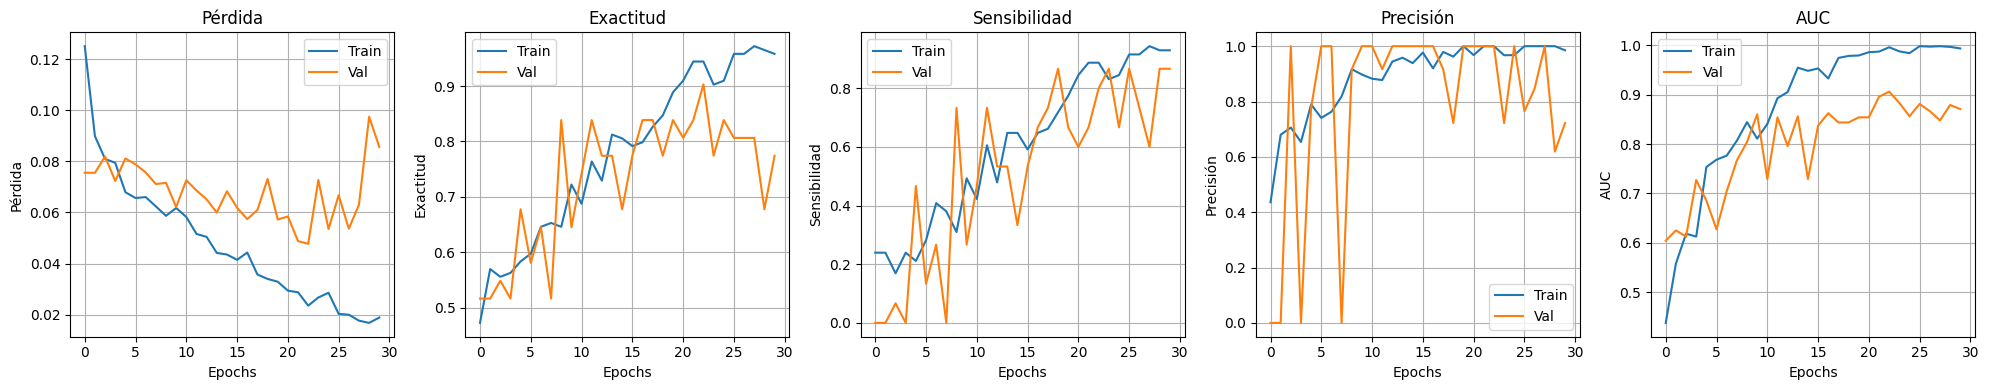

16/16 ━━━━━━━━━━━━━━━━━━━━ 139s 347ms/step

Métricas de evaluación:
Exactitud:     0.7812
Precisión:     1.0000
Sensibilidad:  0.5625
Especificidad: 1.0000
F1-score:      0.7200
AUC:           0.9141


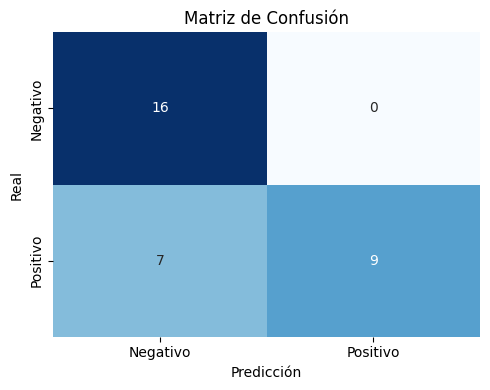

In [ ]:
p.plot_training(mobilenetv2_gru_focal_loss_model_history)
model_metrics_dataset(mobilenetv2_gru_focal_loss_model, test_ds)

In [ ]:
models_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models"

mobilenetv2_gru_focal_loss_model.save_weights('/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models/MOBILENETV2_GRU_FOCAL_LOSS.weights.h5')

with open(os.path.join(models_dir, "MOBILENETV2_GRU_FOCAL_LOSS_history.pkl"), "wb") as f:
    pickle.dump(mobilenetv2_gru_focal_loss_model_history.history, f)

### 4.4.2 - Modelo preentrenado con MobileNetV2 con *label smoothing*.

In [ ]:
mobilenetv2_gru_label_smoothing_model = MOBILENETV2_GRU(input_shape=X_train.shape[1:])

mobilenetv2_gru_label_smoothing_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [ ]:
tracker = EmissionsTracker()
tracker.start()
start = time.time()

mobilenetv2_gru_label_smoothing_model_history = mobilenetv2_gru_label_smoothing_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)

end = time.time()
emissions = tracker.stop()
print(f"\nTiempo de entrenamiento: {(end - start):.2f} segundos")
print(f"\nEmisiones estimadas: {emissions:.4f} kg de CO2")

[codecarbon WARNING @ 11:55:56] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 11:55:56] [setup] RAM Tracking...
[codecarbon INFO @ 11:55:56] [setup] CPU Tracking...
[codecarbon WARNING @ 11:55:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:55:57] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:55:57] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:55:57] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:55:57] [setup] GPU Tracking...
[codecarbon INFO @ 11:55:57] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 11:55:57] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/30


[codecarbon INFO @ 11:56:12] Energy consumed for RAM : 0.000158 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:56:12] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:56:12] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 11:56:12] Energy consumed for all GPUs : 0.000246 kWh. Total GPU Power : 59.080087018650595 W
[codecarbon INFO @ 11:56:12] 0.000582 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:56:27] Energy consumed for RAM : 0.000316 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:56:27] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:56:27] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 11:56:27] Energy consumed for all GPUs : 0.000493 kWh. Total GPU Power : 59.20349921038097 W
[codecarbon INFO @ 11:56:27] 0.001164 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:56:42] Energy consumed for RAM : 0.000475 kWh. RAM Power : 

16/72 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.6002 - auc: 0.6243 - loss: 0.6584 - precision: 0.6919 - recall: 0.4508

[codecarbon INFO @ 12:03:16] Energy consumed for RAM : 0.004619 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:03:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:03:16] Energy consumed for All CPU : 0.005169 kWh
[codecarbon INFO @ 12:03:16] Energy consumed for all GPUs : 0.007291 kWh. Total GPU Power : 76.51009454906823 W
[codecarbon INFO @ 12:03:16] 0.017079 kWh of electricity used since the beginning.


58/72 ━━━━━━━━━━━━━━━━━━━━ 4s 355ms/step - accuracy: 0.5506 - auc: 0.5725 - loss: 0.7026 - precision: 0.5365 - recall: 0.4271

[codecarbon INFO @ 12:03:31] Energy consumed for RAM : 0.004777 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:03:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:03:31] Energy consumed for All CPU : 0.005346 kWh
[codecarbon INFO @ 12:03:31] Energy consumed for all GPUs : 0.007740 kWh. Total GPU Power : 107.74688574330938 W
[codecarbon INFO @ 12:03:31] 0.017863 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.5488 - auc: 0.5657 - loss: 0.7093 - precision: 0.5386 - recall: 0.4339

[codecarbon INFO @ 12:03:46] Energy consumed for RAM : 0.004936 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:03:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:03:46] Energy consumed for All CPU : 0.005523 kWh
[codecarbon INFO @ 12:03:46] Energy consumed for all GPUs : 0.008063 kWh. Total GPU Power : 77.33000634578838 W
[codecarbon INFO @ 12:03:46] 0.018521 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:04:01] Energy consumed for RAM : 0.005094 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:04:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:04:01] Energy consumed for All CPU : 0.005700 kWh
[codecarbon INFO @ 12:04:01] Energy consumed for all GPUs : 0.008311 kWh. Total GPU Power : 59.561215426645305 W
[codecarbon INFO @ 12:04:01] 0.019104 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:04:01] 0.018887 g.CO2eq/s mean an estimation of 595.6162856

72/72 ━━━━━━━━━━━━━━━━━━━━ 596s 2s/step - accuracy: 0.5485 - auc: 0.5651 - loss: 0.7098 - precision: 0.5382 - recall: 0.4342 - val_accuracy: 0.4839 - val_auc: 0.6438 - val_loss: 0.7030 - val_precision: 0.4828 - val_recall: 0.9333
Epoch 2/30
21/72 ━━━━━━━━━━━━━━━━━━━━ 18s 361ms/step - accuracy: 0.4516 - auc: 0.3900 - loss: 0.7554 - precision: 0.3659 - recall: 0.3834

[codecarbon INFO @ 12:06:01] Energy consumed for RAM : 0.006359 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:06:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:06:01] Energy consumed for All CPU : 0.007116 kWh
[codecarbon INFO @ 12:06:01] Energy consumed for all GPUs : 0.010466 kWh. Total GPU Power : 101.05208115003636 W
[codecarbon INFO @ 12:06:01] 0.023941 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:06:01] 0.018228 g.CO2eq/s mean an estimation of 574.8514579949043 kg.CO2eq/year


63/72 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 0.5150 - auc: 0.5089 - loss: 0.7203 - precision: 0.4898 - recall: 0.4388

[codecarbon INFO @ 12:06:16] Energy consumed for RAM : 0.006518 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:06:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:06:16] Energy consumed for All CPU : 0.007293 kWh
[codecarbon INFO @ 12:06:16] Energy consumed for all GPUs : 0.010914 kWh. Total GPU Power : 107.50060415045387 W
[codecarbon INFO @ 12:06:16] 0.024724 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 438ms/step - accuracy: 0.5175 - auc: 0.5122 - loss: 0.7198 - precision: 0.4962 - recall: 0.4437 - val_accuracy: 0.6129 - val_auc: 0.6208 - val_loss: 0.6884 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 3/30
18/72 ━━━━━━━━━━━━━━━━━━━━ 19s 353ms/step - accuracy: 0.7826 - auc: 0.7518 - loss: 0.6033 - precision: 0.8179 - recall: 0.5897

[codecarbon INFO @ 12:06:31] Energy consumed for RAM : 0.006676 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:06:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:06:31] Energy consumed for All CPU : 0.007470 kWh
[codecarbon INFO @ 12:06:31] Energy consumed for all GPUs : 0.011359 kWh. Total GPU Power : 106.81296453169493 W
[codecarbon INFO @ 12:06:31] 0.025504 kWh of electricity used since the beginning.


60/72 ━━━━━━━━━━━━━━━━━━━━ 4s 358ms/step - accuracy: 0.7265 - auc: 0.7387 - loss: 0.6236 - precision: 0.7744 - recall: 0.5301

[codecarbon INFO @ 12:06:46] Energy consumed for RAM : 0.006834 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:06:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:06:46] Energy consumed for All CPU : 0.007647 kWh
[codecarbon INFO @ 12:06:46] Energy consumed for all GPUs : 0.011798 kWh. Total GPU Power : 105.47209797086852 W
[codecarbon INFO @ 12:06:46] 0.026279 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 436ms/step - accuracy: 0.7118 - auc: 0.7263 - loss: 0.6304 - precision: 0.7563 - recall: 0.5264 - val_accuracy: 0.5484 - val_auc: 0.5771 - val_loss: 0.7019 - val_precision: 0.5172 - val_recall: 1.0000
Epoch 4/30
14/72 ━━━━━━━━━━━━━━━━━━━━ 21s 362ms/step - accuracy: 0.4794 - auc: 0.4415 - loss: 0.6790 - precision: 0.5726 - recall: 0.5229

[codecarbon INFO @ 12:07:01] Energy consumed for RAM : 0.006992 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:07:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:07:01] Energy consumed for All CPU : 0.007824 kWh
[codecarbon INFO @ 12:07:01] Energy consumed for all GPUs : 0.012237 kWh. Total GPU Power : 105.50182055744827 W
[codecarbon INFO @ 12:07:01] 0.027054 kWh of electricity used since the beginning.


56/72 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step - accuracy: 0.5124 - auc: 0.5485 - loss: 0.6826 - precision: 0.5180 - recall: 0.4439

[codecarbon INFO @ 12:07:16] Energy consumed for RAM : 0.007151 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:07:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:07:16] Energy consumed for All CPU : 0.008001 kWh
[codecarbon INFO @ 12:07:16] Energy consumed for all GPUs : 0.012680 kWh. Total GPU Power : 106.32722063549215 W
[codecarbon INFO @ 12:07:16] 0.027832 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 438ms/step - accuracy: 0.5269 - auc: 0.5695 - loss: 0.6797 - precision: 0.5335 - recall: 0.4482 - val_accuracy: 0.4194 - val_auc: 0.5437 - val_loss: 0.6901 - val_precision: 0.3846 - val_recall: 0.3333
Epoch 5/30
10/72 ━━━━━━━━━━━━━━━━━━━━ 22s 363ms/step - accuracy: 0.6607 - auc: 0.7438 - loss: 0.6178 - precision: 0.5493 - recall: 0.6005

[codecarbon INFO @ 12:07:31] Energy consumed for RAM : 0.007309 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:07:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:07:31] Energy consumed for All CPU : 0.008178 kWh
[codecarbon INFO @ 12:07:31] Energy consumed for all GPUs : 0.013120 kWh. Total GPU Power : 105.61544372902874 W
[codecarbon INFO @ 12:07:31] 0.028607 kWh of electricity used since the beginning.


51/72 ━━━━━━━━━━━━━━━━━━━━ 7s 363ms/step - accuracy: 0.6753 - auc: 0.7382 - loss: 0.6209 - precision: 0.6275 - recall: 0.6646

[codecarbon INFO @ 12:07:46] Energy consumed for RAM : 0.007467 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:07:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:07:46] Energy consumed for All CPU : 0.008355 kWh
[codecarbon INFO @ 12:07:46] Energy consumed for all GPUs : 0.013559 kWh. Total GPU Power : 105.34524845817135 W
[codecarbon INFO @ 12:07:46] 0.029381 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 440ms/step - accuracy: 0.6796 - auc: 0.7435 - loss: 0.6196 - precision: 0.6405 - recall: 0.6876 - val_accuracy: 0.5161 - val_auc: 0.5229 - val_loss: 0.6846 - val_precision: 0.5000 - val_recall: 0.6000
Epoch 6/30
 6/72 ━━━━━━━━━━━━━━━━━━━━ 23s 361ms/step - accuracy: 0.3361 - auc: 0.5241 - loss: 0.6588 - precision: 0.3405 - recall: 0.4806

[codecarbon INFO @ 12:08:01] Energy consumed for RAM : 0.007626 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:08:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:08:01] Energy consumed for All CPU : 0.008532 kWh
[codecarbon INFO @ 12:08:01] Energy consumed for all GPUs : 0.014003 kWh. Total GPU Power : 106.62437373994007 W
[codecarbon INFO @ 12:08:01] 0.030161 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:08:01] 0.023461 g.CO2eq/s mean an estimation of 739.8710909059139 kg.CO2eq/year


47/72 ━━━━━━━━━━━━━━━━━━━━ 9s 361ms/step - accuracy: 0.5165 - auc: 0.6320 - loss: 0.6655 - precision: 0.4961 - recall: 0.5675

[codecarbon INFO @ 12:08:16] Energy consumed for RAM : 0.007784 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:08:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:08:16] Energy consumed for All CPU : 0.008709 kWh
[codecarbon INFO @ 12:08:16] Energy consumed for all GPUs : 0.014443 kWh. Total GPU Power : 105.43442264434573 W
[codecarbon INFO @ 12:08:16] 0.030936 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 438ms/step - accuracy: 0.5468 - auc: 0.6515 - loss: 0.6590 - precision: 0.5268 - recall: 0.5930 - val_accuracy: 0.5806 - val_auc: 0.5312 - val_loss: 0.6955 - val_precision: 0.5500 - val_recall: 0.7333
Epoch 7/30
 1/72 ━━━━━━━━━━━━━━━━━━━━ 28s 406ms/step - accuracy: 0.5000 - auc: 0.0000e+00 - loss: 0.6178 - precision: 1.0000 - recall: 0.5000

[codecarbon INFO @ 12:08:31] Energy consumed for RAM : 0.007942 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:08:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:08:31] Energy consumed for All CPU : 0.008886 kWh
[codecarbon INFO @ 12:08:31] Energy consumed for all GPUs : 0.014887 kWh. Total GPU Power : 106.73297032933294 W
[codecarbon INFO @ 12:08:31] 0.031716 kWh of electricity used since the beginning.


43/72 ━━━━━━━━━━━━━━━━━━━━ 10s 362ms/step - accuracy: 0.6792 - auc: 0.6939 - loss: 0.6274 - precision: 0.7065 - recall: 0.7733

[codecarbon INFO @ 12:08:46] Energy consumed for RAM : 0.008100 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:08:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:08:46] Energy consumed for All CPU : 0.009063 kWh
[codecarbon INFO @ 12:08:46] Energy consumed for all GPUs : 0.015327 kWh. Total GPU Power : 105.54548453912608 W
[codecarbon INFO @ 12:08:46] 0.032490 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.6884 - auc: 0.7169 - loss: 0.6263 - precision: 0.6976 - recall: 0.7418

[codecarbon INFO @ 12:09:01] Energy consumed for RAM : 0.008259 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:09:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:09:01] Energy consumed for All CPU : 0.009240 kWh
[codecarbon INFO @ 12:09:01] Energy consumed for all GPUs : 0.015768 kWh. Total GPU Power : 105.94839453533896 W
[codecarbon INFO @ 12:09:01] 0.033267 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 437ms/step - accuracy: 0.6888 - auc: 0.7176 - loss: 0.6262 - precision: 0.6979 - recall: 0.7411 - val_accuracy: 0.6129 - val_auc: 0.5375 - val_loss: 0.6985 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 8/30
39/72 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - accuracy: 0.7308 - auc: 0.8402 - loss: 0.5597 - precision: 0.6539 - recall: 0.7588

[codecarbon INFO @ 12:09:16] Energy consumed for RAM : 0.008417 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:09:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:09:16] Energy consumed for All CPU : 0.009417 kWh
[codecarbon INFO @ 12:09:16] Energy consumed for all GPUs : 0.016211 kWh. Total GPU Power : 106.32152279323562 W
[codecarbon INFO @ 12:09:16] 0.034045 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7179 - auc: 0.8093 - loss: 0.5783 - precision: 0.6673 - recall: 0.7233

[codecarbon INFO @ 12:09:31] Energy consumed for RAM : 0.008575 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:09:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:09:31] Energy consumed for All CPU : 0.009594 kWh
[codecarbon INFO @ 12:09:31] Energy consumed for all GPUs : 0.016651 kWh. Total GPU Power : 105.68512104364152 W
[codecarbon INFO @ 12:09:31] 0.034821 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 441ms/step - accuracy: 0.7179 - auc: 0.8090 - loss: 0.5785 - precision: 0.6680 - recall: 0.7228 - val_accuracy: 0.6129 - val_auc: 0.5813 - val_loss: 0.6973 - val_precision: 0.5600 - val_recall: 0.9333
Epoch 9/30
35/72 ━━━━━━━━━━━━━━━━━━━━ 13s 352ms/step - accuracy: 0.8181 - auc: 0.8785 - loss: 0.5224 - precision: 0.8078 - recall: 0.8839

[codecarbon INFO @ 12:09:46] Energy consumed for RAM : 0.008734 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:09:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:09:46] Energy consumed for All CPU : 0.009771 kWh
[codecarbon INFO @ 12:09:46] Energy consumed for all GPUs : 0.017093 kWh. Total GPU Power : 105.9385625541845 W
[codecarbon INFO @ 12:09:46] 0.035598 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.7923 - auc: 0.8646 - loss: 0.5329 - precision: 0.7757 - recall: 0.8380

[codecarbon INFO @ 12:10:01] Energy consumed for RAM : 0.008892 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:10:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:10:01] Energy consumed for All CPU : 0.009948 kWh
[codecarbon INFO @ 12:10:01] Energy consumed for all GPUs : 0.017539 kWh. Total GPU Power : 107.02704018447218 W
[codecarbon INFO @ 12:10:01] 0.036379 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:10:01] 0.023452 g.CO2eq/s mean an estimation of 739.5817010154284 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 434ms/step - accuracy: 0.7919 - auc: 0.8643 - loss: 0.5331 - precision: 0.7752 - recall: 0.8375 - val_accuracy: 0.6129 - val_auc: 0.6250 - val_loss: 0.7032 - val_precision: 0.5600 - val_recall: 0.9333
Epoch 10/30
31/72 ━━━━━━━━━━━━━━━━━━━━ 14s 356ms/step - accuracy: 0.7971 - auc: 0.9358 - loss: 0.5054 - precision: 0.7632 - recall: 0.9574

[codecarbon INFO @ 12:10:16] Energy consumed for RAM : 0.009050 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:10:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:10:16] Energy consumed for All CPU : 0.010125 kWh
[codecarbon INFO @ 12:10:16] Energy consumed for all GPUs : 0.017979 kWh. Total GPU Power : 105.77318323337111 W
[codecarbon INFO @ 12:10:16] 0.037155 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.7978 - auc: 0.9069 - loss: 0.5132 - precision: 0.7717 - recall: 0.8895

[codecarbon INFO @ 12:10:31] Energy consumed for RAM : 0.009208 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:10:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:10:31] Energy consumed for All CPU : 0.010302 kWh
[codecarbon INFO @ 12:10:31] Energy consumed for all GPUs : 0.018420 kWh. Total GPU Power : 105.8735174528151 W
[codecarbon INFO @ 12:10:31] 0.037931 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 440ms/step - accuracy: 0.7977 - auc: 0.9064 - loss: 0.5134 - precision: 0.7717 - recall: 0.8885 - val_accuracy: 0.5161 - val_auc: 0.6250 - val_loss: 0.6627 - val_precision: 0.5000 - val_recall: 0.4667
Epoch 11/30
26/72 ━━━━━━━━━━━━━━━━━━━━ 17s 370ms/step - accuracy: 0.8743 - auc: 0.9266 - loss: 0.4488 - precision: 0.8802 - recall: 0.7841

[codecarbon INFO @ 12:10:46] Energy consumed for RAM : 0.009367 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:10:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:10:46] Energy consumed for All CPU : 0.010479 kWh
[codecarbon INFO @ 12:10:46] Energy consumed for all GPUs : 0.018860 kWh. Total GPU Power : 105.49293617184702 W
[codecarbon INFO @ 12:10:46] 0.038706 kWh of electricity used since the beginning.


68/72 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step - accuracy: 0.8121 - auc: 0.8938 - loss: 0.4938 - precision: 0.8122 - recall: 0.7716

[codecarbon INFO @ 12:11:01] Energy consumed for RAM : 0.009525 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:11:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:11:01] Energy consumed for All CPU : 0.010656 kWh
[codecarbon INFO @ 12:11:01] Energy consumed for all GPUs : 0.019300 kWh. Total GPU Power : 105.72094321648459 W
[codecarbon INFO @ 12:11:01] 0.039482 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 441ms/step - accuracy: 0.8102 - auc: 0.8926 - loss: 0.4954 - precision: 0.8105 - recall: 0.7720 - val_accuracy: 0.6452 - val_auc: 0.6958 - val_loss: 0.6491 - val_precision: 0.5833 - val_recall: 0.9333
Epoch 12/30
22/72 ━━━━━━━━━━━━━━━━━━━━ 18s 366ms/step - accuracy: 0.8116 - auc: 0.9285 - loss: 0.4765 - precision: 0.8397 - recall: 0.8408

[codecarbon INFO @ 12:11:16] Energy consumed for RAM : 0.009683 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:11:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:11:16] Energy consumed for All CPU : 0.010834 kWh
[codecarbon INFO @ 12:11:16] Energy consumed for all GPUs : 0.019741 kWh. Total GPU Power : 105.8210071299402 W
[codecarbon INFO @ 12:11:16] 0.040258 kWh of electricity used since the beginning.


63/72 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - accuracy: 0.8155 - auc: 0.9150 - loss: 0.4843 - precision: 0.8153 - recall: 0.8500

[codecarbon INFO @ 12:11:31] Energy consumed for RAM : 0.009842 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:11:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:11:31] Energy consumed for All CPU : 0.011011 kWh
[codecarbon INFO @ 12:11:31] Energy consumed for all GPUs : 0.020185 kWh. Total GPU Power : 106.46553997035971 W
[codecarbon INFO @ 12:11:31] 0.041037 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 440ms/step - accuracy: 0.8119 - auc: 0.9110 - loss: 0.4870 - precision: 0.8086 - recall: 0.8473 - val_accuracy: 0.6452 - val_auc: 0.7417 - val_loss: 0.6217 - val_precision: 0.6250 - val_recall: 0.6667
Epoch 13/30
18/72 ━━━━━━━━━━━━━━━━━━━━ 19s 356ms/step - accuracy: 0.8366 - auc: 0.9574 - loss: 0.3918 - precision: 0.8378 - recall: 0.8406

[codecarbon INFO @ 12:11:46] Energy consumed for RAM : 0.010000 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:11:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:11:46] Energy consumed for All CPU : 0.011188 kWh
[codecarbon INFO @ 12:11:46] Energy consumed for all GPUs : 0.020626 kWh. Total GPU Power : 105.90779699247092 W
[codecarbon INFO @ 12:11:46] 0.041813 kWh of electricity used since the beginning.


60/72 ━━━━━━━━━━━━━━━━━━━━ 4s 357ms/step - accuracy: 0.8159 - auc: 0.9334 - loss: 0.4405 - precision: 0.8222 - recall: 0.8005

[codecarbon INFO @ 12:12:01] Energy consumed for RAM : 0.010158 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:12:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:12:01] Energy consumed for All CPU : 0.011365 kWh
[codecarbon INFO @ 12:12:01] Energy consumed for all GPUs : 0.021068 kWh. Total GPU Power : 106.09835696204044 W
[codecarbon INFO @ 12:12:01] 0.042590 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:12:01] 0.023429 g.CO2eq/s mean an estimation of 738.8536416514754 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 436ms/step - accuracy: 0.8123 - auc: 0.9276 - loss: 0.4485 - precision: 0.8173 - recall: 0.7966 - val_accuracy: 0.7097 - val_auc: 0.7750 - val_loss: 0.6202 - val_precision: 0.6364 - val_recall: 0.9333
Epoch 14/30
14/72 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.8837 - auc: 0.9112 - loss: 0.4646 - precision: 0.8510 - recall: 1.0000

[codecarbon INFO @ 12:12:16] Energy consumed for RAM : 0.010316 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:12:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:12:16] Energy consumed for All CPU : 0.011542 kWh
[codecarbon INFO @ 12:12:16] Energy consumed for all GPUs : 0.021512 kWh. Total GPU Power : 106.68726960278806 W
[codecarbon INFO @ 12:12:16] 0.043370 kWh of electricity used since the beginning.


57/72 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.8503 - auc: 0.9062 - loss: 0.4857 - precision: 0.8102 - recall: 0.9484

[codecarbon INFO @ 12:12:31] Energy consumed for RAM : 0.010475 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:12:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:12:31] Energy consumed for All CPU : 0.011719 kWh
[codecarbon INFO @ 12:12:31] Energy consumed for all GPUs : 0.021955 kWh. Total GPU Power : 106.27114065129204 W
[codecarbon INFO @ 12:12:31] 0.044148 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 438ms/step - accuracy: 0.8426 - auc: 0.9055 - loss: 0.4871 - precision: 0.8049 - recall: 0.9251 - val_accuracy: 0.6452 - val_auc: 0.7792 - val_loss: 0.6169 - val_precision: 0.6000 - val_recall: 0.8000
Epoch 15/30
10/72 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy: 0.9438 - auc: 0.9750 - loss: 0.3950 - precision: 0.9189 - recall: 1.0000

[codecarbon INFO @ 12:12:46] Energy consumed for RAM : 0.010633 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:12:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:12:46] Energy consumed for All CPU : 0.011896 kWh
[codecarbon INFO @ 12:12:46] Energy consumed for all GPUs : 0.022394 kWh. Total GPU Power : 105.5077463326875 W
[codecarbon INFO @ 12:12:46] 0.044923 kWh of electricity used since the beginning.


52/72 ━━━━━━━━━━━━━━━━━━━━ 7s 356ms/step - accuracy: 0.8692 - auc: 0.9410 - loss: 0.4387 - precision: 0.8309 - recall: 0.9289

[codecarbon INFO @ 12:13:01] Energy consumed for RAM : 0.010791 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:13:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:13:01] Energy consumed for All CPU : 0.012073 kWh
[codecarbon INFO @ 12:13:01] Energy consumed for all GPUs : 0.022839 kWh. Total GPU Power : 106.78564480711334 W
[codecarbon INFO @ 12:13:01] 0.045703 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 435ms/step - accuracy: 0.8677 - auc: 0.9407 - loss: 0.4398 - precision: 0.8316 - recall: 0.9221 - val_accuracy: 0.6452 - val_auc: 0.8083 - val_loss: 0.6012 - val_precision: 0.6000 - val_recall: 0.8000
Epoch 16/30
 7/72 ━━━━━━━━━━━━━━━━━━━━ 23s 356ms/step - accuracy: 0.8872 - auc: 0.6575 - loss: 0.4708 - precision: 0.6071 - recall: 0.5167

[codecarbon INFO @ 12:13:16] Energy consumed for RAM : 0.010949 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:13:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:13:16] Energy consumed for All CPU : 0.012250 kWh
[codecarbon INFO @ 12:13:16] Energy consumed for all GPUs : 0.023280 kWh. Total GPU Power : 105.89407538643121 W
[codecarbon INFO @ 12:13:16] 0.046480 kWh of electricity used since the beginning.


49/72 ━━━━━━━━━━━━━━━━━━━━ 8s 356ms/step - accuracy: 0.8915 - auc: 0.9107 - loss: 0.4431 - precision: 0.8525 - recall: 0.8270

[codecarbon INFO @ 12:13:31] Energy consumed for RAM : 0.011108 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:13:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:13:31] Energy consumed for All CPU : 0.012427 kWh
[codecarbon INFO @ 12:13:31] Energy consumed for all GPUs : 0.023722 kWh. Total GPU Power : 105.9540251239528 W
[codecarbon INFO @ 12:13:31] 0.047256 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 435ms/step - accuracy: 0.8895 - auc: 0.9220 - loss: 0.4380 - precision: 0.8584 - recall: 0.8479 - val_accuracy: 0.6774 - val_auc: 0.8250 - val_loss: 0.5812 - val_precision: 0.6316 - val_recall: 0.8000
Epoch 17/30
 3/72 ━━━━━━━━━━━━━━━━━━━━ 24s 353ms/step - accuracy: 0.6389 - auc: 0.6667 - loss: 0.5244 - precision: 0.3333 - recall: 0.6667

[codecarbon INFO @ 12:13:46] Energy consumed for RAM : 0.011266 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:13:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:13:46] Energy consumed for All CPU : 0.012604 kWh
[codecarbon INFO @ 12:13:46] Energy consumed for all GPUs : 0.024167 kWh. Total GPU Power : 106.75535386004918 W
[codecarbon INFO @ 12:13:46] 0.048037 kWh of electricity used since the beginning.


45/72 ━━━━━━━━━━━━━━━━━━━━ 9s 358ms/step - accuracy: 0.8451 - auc: 0.9476 - loss: 0.4110 - precision: 0.7598 - recall: 0.9529 

[codecarbon INFO @ 12:14:01] Energy consumed for RAM : 0.011424 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:14:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:14:01] Energy consumed for All CPU : 0.012781 kWh
[codecarbon INFO @ 12:14:01] Energy consumed for all GPUs : 0.024607 kWh. Total GPU Power : 105.82351467968823 W
[codecarbon INFO @ 12:14:01] 0.048813 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:14:01] 0.023469 g.CO2eq/s mean an estimation of 740.1045041315687 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.8629 - auc: 0.9550 - loss: 0.4021 - precision: 0.7972 - recall: 0.9459

[codecarbon INFO @ 12:14:16] Energy consumed for RAM : 0.011583 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:14:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:14:16] Energy consumed for All CPU : 0.012958 kWh
[codecarbon INFO @ 12:14:16] Energy consumed for all GPUs : 0.025050 kWh. Total GPU Power : 106.20224367507463 W
[codecarbon INFO @ 12:14:16] 0.049590 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 439ms/step - accuracy: 0.8633 - auc: 0.9552 - loss: 0.4019 - precision: 0.7981 - recall: 0.9457 - val_accuracy: 0.6129 - val_auc: 0.8833 - val_loss: 0.6291 - val_precision: 0.5600 - val_recall: 0.9333
Epoch 18/30
41/72 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.9437 - auc: 0.9218 - loss: 0.3570 - precision: 0.9654 - recall: 0.9218

[codecarbon INFO @ 12:14:31] Energy consumed for RAM : 0.011741 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:14:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:14:31] Energy consumed for All CPU : 0.013135 kWh
[codecarbon INFO @ 12:14:31] Energy consumed for all GPUs : 0.025494 kWh. Total GPU Power : 106.71015856602142 W
[codecarbon INFO @ 12:14:31] 0.050370 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9280 - auc: 0.9377 - loss: 0.3726 - precision: 0.9530 - recall: 0.9008

[codecarbon INFO @ 12:14:46] Energy consumed for RAM : 0.011899 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:14:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:14:46] Energy consumed for All CPU : 0.013312 kWh
[codecarbon INFO @ 12:14:46] Energy consumed for all GPUs : 0.025934 kWh. Total GPU Power : 105.52487829566755 W
[codecarbon INFO @ 12:14:46] 0.051145 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 437ms/step - accuracy: 0.9275 - auc: 0.9379 - loss: 0.3730 - precision: 0.9524 - recall: 0.9004 - val_accuracy: 0.6129 - val_auc: 0.8188 - val_loss: 0.6774 - val_precision: 0.5600 - val_recall: 0.9333
Epoch 19/30
38/72 ━━━━━━━━━━━━━━━━━━━━ 12s 353ms/step - accuracy: 0.9084 - auc: 0.9862 - loss: 0.3616 - precision: 0.8921 - recall: 0.9674

[codecarbon INFO @ 12:15:01] Energy consumed for RAM : 0.012057 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:15:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:15:01] Energy consumed for All CPU : 0.013489 kWh
[codecarbon INFO @ 12:15:01] Energy consumed for all GPUs : 0.026376 kWh. Total GPU Power : 106.19922093860907 W
[codecarbon INFO @ 12:15:01] 0.051923 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9265 - auc: 0.9869 - loss: 0.3554 - precision: 0.9163 - recall: 0.9602

[codecarbon INFO @ 12:15:16] Energy consumed for RAM : 0.012216 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:15:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:15:16] Energy consumed for All CPU : 0.013666 kWh
[codecarbon INFO @ 12:15:16] Energy consumed for all GPUs : 0.026821 kWh. Total GPU Power : 106.65881735632163 W
[codecarbon INFO @ 12:15:16] 0.052703 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 434ms/step - accuracy: 0.9268 - auc: 0.9869 - loss: 0.3554 - precision: 0.9167 - recall: 0.9599 - val_accuracy: 0.7419 - val_auc: 0.8375 - val_loss: 0.5533 - val_precision: 0.6842 - val_recall: 0.8667
Epoch 20/30
34/72 ━━━━━━━━━━━━━━━━━━━━ 13s 353ms/step - accuracy: 0.9048 - auc: 0.9351 - loss: 0.3423 - precision: 0.9427 - recall: 0.8828

[codecarbon INFO @ 12:15:31] Energy consumed for RAM : 0.012374 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:15:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:15:31] Energy consumed for All CPU : 0.013843 kWh
[codecarbon INFO @ 12:15:31] Energy consumed for all GPUs : 0.027261 kWh. Total GPU Power : 105.76171877134026 W
[codecarbon INFO @ 12:15:31] 0.053478 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9199 - auc: 0.9636 - loss: 0.3376 - precision: 0.9361 - recall: 0.9007

[codecarbon INFO @ 12:15:46] Energy consumed for RAM : 0.012532 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:15:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:15:46] Energy consumed for All CPU : 0.014020 kWh
[codecarbon INFO @ 12:15:46] Energy consumed for all GPUs : 0.027703 kWh. Total GPU Power : 106.02512198712355 W
[codecarbon INFO @ 12:15:46] 0.054256 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 437ms/step - accuracy: 0.9201 - auc: 0.9639 - loss: 0.3375 - precision: 0.9360 - recall: 0.9013 - val_accuracy: 0.7097 - val_auc: 0.8646 - val_loss: 0.5790 - val_precision: 0.6364 - val_recall: 0.9333
Epoch 21/30
30/72 ━━━━━━━━━━━━━━━━━━━━ 15s 362ms/step - accuracy: 0.8800 - auc: 0.9412 - loss: 0.3575 - precision: 0.7955 - recall: 0.8635

[codecarbon INFO @ 12:16:01] Energy consumed for RAM : 0.012691 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:16:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:16:01] Energy consumed for All CPU : 0.014197 kWh
[codecarbon INFO @ 12:16:01] Energy consumed for all GPUs : 0.028146 kWh. Total GPU Power : 106.34481621952571 W
[codecarbon INFO @ 12:16:01] 0.055034 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:16:01] 0.023465 g.CO2eq/s mean an estimation of 739.9868298436484 kg.CO2eq/year


71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9001 - auc: 0.9641 - loss: 0.3594 - precision: 0.8592 - recall: 0.8849

[codecarbon INFO @ 12:16:16] Energy consumed for RAM : 0.012849 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:16:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:16:16] Energy consumed for All CPU : 0.014374 kWh
[codecarbon INFO @ 12:16:16] Energy consumed for all GPUs : 0.028585 kWh. Total GPU Power : 105.47117055791624 W
[codecarbon INFO @ 12:16:16] 0.055809 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 443ms/step - accuracy: 0.9006 - auc: 0.9645 - loss: 0.3594 - precision: 0.8608 - recall: 0.8857 - val_accuracy: 0.7097 - val_auc: 0.8708 - val_loss: 0.6082 - val_precision: 0.6364 - val_recall: 0.9333
Epoch 22/30
25/72 ━━━━━━━━━━━━━━━━━━━━ 16s 353ms/step - accuracy: 0.9618 - auc: 0.9595 - loss: 0.2858 - precision: 0.9417 - recall: 1.0000

[codecarbon INFO @ 12:16:31] Energy consumed for RAM : 0.013007 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:16:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:16:31] Energy consumed for All CPU : 0.014551 kWh
[codecarbon INFO @ 12:16:31] Energy consumed for all GPUs : 0.029026 kWh. Total GPU Power : 105.87918677039805 W
[codecarbon INFO @ 12:16:31] 0.056585 kWh of electricity used since the beginning.


67/72 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step - accuracy: 0.9527 - auc: 0.9785 - loss: 0.3050 - precision: 0.9224 - recall: 0.9950

[codecarbon INFO @ 12:16:46] Energy consumed for RAM : 0.013165 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:16:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:16:46] Energy consumed for All CPU : 0.014728 kWh
[codecarbon INFO @ 12:16:46] Energy consumed for all GPUs : 0.029470 kWh. Total GPU Power : 106.49640091708616 W
[codecarbon INFO @ 12:16:46] 0.057364 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 437ms/step - accuracy: 0.9516 - auc: 0.9791 - loss: 0.3067 - precision: 0.9211 - recall: 0.9934 - val_accuracy: 0.7097 - val_auc: 0.8833 - val_loss: 0.5366 - val_precision: 0.6500 - val_recall: 0.8667
Epoch 23/30
21/72 ━━━━━━━━━━━━━━━━━━━━ 18s 356ms/step - accuracy: 0.9749 - auc: 0.9488 - loss: 0.2853 - precision: 0.9611 - recall: 1.0000

[codecarbon INFO @ 12:17:01] Energy consumed for RAM : 0.013324 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:17:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:17:01] Energy consumed for All CPU : 0.014905 kWh
[codecarbon INFO @ 12:17:01] Energy consumed for all GPUs : 0.029911 kWh. Total GPU Power : 105.74508427406788 W
[codecarbon INFO @ 12:17:01] 0.058140 kWh of electricity used since the beginning.


63/72 ━━━━━━━━━━━━━━━━━━━━ 3s 358ms/step - accuracy: 0.9831 - auc: 0.9824 - loss: 0.2786 - precision: 0.9712 - recall: 1.0000

[codecarbon INFO @ 12:17:16] Energy consumed for RAM : 0.013482 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:17:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:17:16] Energy consumed for All CPU : 0.015082 kWh
[codecarbon INFO @ 12:17:16] Energy consumed for all GPUs : 0.030351 kWh. Total GPU Power : 105.77921300785786 W
[codecarbon INFO @ 12:17:16] 0.058916 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 439ms/step - accuracy: 0.9844 - auc: 0.9848 - loss: 0.2783 - precision: 0.9732 - recall: 1.0000 - val_accuracy: 0.7419 - val_auc: 0.8875 - val_loss: 0.5024 - val_precision: 0.7059 - val_recall: 0.8000
Epoch 24/30
17/72 ━━━━━━━━━━━━━━━━━━━━ 20s 365ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.2221 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 12:17:31] Energy consumed for RAM : 0.013640 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:17:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:17:31] Energy consumed for All CPU : 0.015259 kWh
[codecarbon INFO @ 12:17:31] Energy consumed for all GPUs : 0.030794 kWh. Total GPU Power : 106.22725477105938 W
[codecarbon INFO @ 12:17:31] 0.059693 kWh of electricity used since the beginning.


58/72 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 0.9821 - auc: 0.9945 - loss: 0.2641 - precision: 0.9742 - recall: 0.9902

[codecarbon INFO @ 12:17:46] Energy consumed for RAM : 0.013799 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:17:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:17:46] Energy consumed for All CPU : 0.015436 kWh
[codecarbon INFO @ 12:17:46] Energy consumed for all GPUs : 0.031233 kWh. Total GPU Power : 105.42092864229541 W
[codecarbon INFO @ 12:17:46] 0.060468 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 442ms/step - accuracy: 0.9811 - auc: 0.9941 - loss: 0.2687 - precision: 0.9732 - recall: 0.9890 - val_accuracy: 0.8065 - val_auc: 0.9083 - val_loss: 0.4878 - val_precision: 0.7368 - val_recall: 0.9333
Epoch 25/30
12/72 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.2579 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 12:18:01] Energy consumed for RAM : 0.013957 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:18:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:18:01] Energy consumed for All CPU : 0.015614 kWh
[codecarbon INFO @ 12:18:01] Energy consumed for all GPUs : 0.031673 kWh. Total GPU Power : 105.63443035973758 W
[codecarbon INFO @ 12:18:01] 0.061243 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:18:01] 0.023421 g.CO2eq/s mean an estimation of 738.6052233055028 kg.CO2eq/year


54/72 ━━━━━━━━━━━━━━━━━━━━ 6s 356ms/step - accuracy: 0.9993 - auc: 1.0000 - loss: 0.2703 - precision: 1.0000 - recall: 0.9986

[codecarbon INFO @ 12:18:16] Energy consumed for RAM : 0.014115 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:18:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:18:16] Energy consumed for All CPU : 0.015791 kWh
[codecarbon INFO @ 12:18:16] Energy consumed for all GPUs : 0.032117 kWh. Total GPU Power : 106.60101237459962 W
[codecarbon INFO @ 12:18:16] 0.062023 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 435ms/step - accuracy: 0.9932 - auc: 0.9987 - loss: 0.2760 - precision: 0.9944 - recall: 0.9920 - val_accuracy: 0.7742 - val_auc: 0.9500 - val_loss: 0.4838 - val_precision: 1.0000 - val_recall: 0.5333
Epoch 26/30
 9/72 ━━━━━━━━━━━━━━━━━━━━ 22s 354ms/step - accuracy: 0.9375 - auc: 0.8889 - loss: 0.2859 - precision: 0.7829 - recall: 0.8889

[codecarbon INFO @ 12:18:31] Energy consumed for RAM : 0.014273 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:18:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:18:31] Energy consumed for All CPU : 0.015968 kWh
[codecarbon INFO @ 12:18:31] Energy consumed for all GPUs : 0.032559 kWh. Total GPU Power : 106.09490346006223 W
[codecarbon INFO @ 12:18:31] 0.062800 kWh of electricity used since the beginning.


50/72 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - accuracy: 0.9448 - auc: 0.9765 - loss: 0.2968 - precision: 0.8943 - recall: 0.9569

[codecarbon INFO @ 12:18:46] Energy consumed for RAM : 0.014432 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:18:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:18:46] Energy consumed for All CPU : 0.016145 kWh
[codecarbon INFO @ 12:18:46] Energy consumed for all GPUs : 0.033004 kWh. Total GPU Power : 106.78723785599128 W
[codecarbon INFO @ 12:18:46] 0.063580 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 439ms/step - accuracy: 0.9540 - auc: 0.9831 - loss: 0.2906 - precision: 0.9161 - recall: 0.9652 - val_accuracy: 0.7419 - val_auc: 0.9500 - val_loss: 0.4741 - val_precision: 0.6667 - val_recall: 0.9333
Epoch 27/30
 4/72 ━━━━━━━━━━━━━━━━━━━━ 24s 355ms/step - accuracy: 1.0000 - auc: 0.7500 - loss: 0.2275 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 12:19:01] Energy consumed for RAM : 0.014590 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:19:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:19:01] Energy consumed for All CPU : 0.016322 kWh
[codecarbon INFO @ 12:19:01] Energy consumed for all GPUs : 0.033449 kWh. Total GPU Power : 106.8759887042034 W
[codecarbon INFO @ 12:19:01] 0.064361 kWh of electricity used since the beginning.


47/72 ━━━━━━━━━━━━━━━━━━━━ 8s 356ms/step - accuracy: 1.0000 - auc: 0.9787 - loss: 0.2414 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 12:19:16] Energy consumed for RAM : 0.014748 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:19:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:19:16] Energy consumed for All CPU : 0.016499 kWh
[codecarbon INFO @ 12:19:16] Energy consumed for all GPUs : 0.033900 kWh. Total GPU Power : 108.31568764710285 W
[codecarbon INFO @ 12:19:16] 0.065147 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 438ms/step - accuracy: 0.9978 - auc: 0.9861 - loss: 0.2440 - precision: 0.9994 - recall: 0.9962 - val_accuracy: 0.8387 - val_auc: 0.9208 - val_loss: 0.4746 - val_precision: 0.7778 - val_recall: 0.9333
Epoch 28/30


[codecarbon INFO @ 12:19:31] Energy consumed for RAM : 0.014907 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:19:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:19:31] Energy consumed for All CPU : 0.016676 kWh
[codecarbon INFO @ 12:19:31] Energy consumed for all GPUs : 0.034356 kWh. Total GPU Power : 109.25453298851424 W
[codecarbon INFO @ 12:19:31] 0.065938 kWh of electricity used since the beginning.


42/72 ━━━━━━━━━━━━━━━━━━━━ 10s 360ms/step - accuracy: 0.9889 - auc: 1.0000 - loss: 0.2436 - precision: 0.9770 - recall: 0.9988

[codecarbon INFO @ 12:19:46] Energy consumed for RAM : 0.015065 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:19:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:19:46] Energy consumed for All CPU : 0.016853 kWh
[codecarbon INFO @ 12:19:46] Energy consumed for all GPUs : 0.034811 kWh. Total GPU Power : 109.26536202773477 W
[codecarbon INFO @ 12:19:46] 0.066728 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9861 - auc: 0.9998 - loss: 0.2497 - precision: 0.9789 - recall: 0.9916

[codecarbon INFO @ 12:20:01] Energy consumed for RAM : 0.015223 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:20:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:20:01] Energy consumed for All CPU : 0.017030 kWh
[codecarbon INFO @ 12:20:01] Energy consumed for all GPUs : 0.035266 kWh. Total GPU Power : 109.33350119581694 W
[codecarbon INFO @ 12:20:01] 0.067519 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:20:01] 0.023670 g.CO2eq/s mean an estimation of 746.4719685129949 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 447ms/step - accuracy: 0.9861 - auc: 0.9998 - loss: 0.2498 - precision: 0.9790 - recall: 0.9915 - val_accuracy: 0.8710 - val_auc: 0.9375 - val_loss: 0.4253 - val_precision: 0.8667 - val_recall: 0.8667


[codecarbon INFO @ 12:20:03] Energy consumed for RAM : 0.015243 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:20:03] Delta energy consumed for CPU with constant : 0.000023 kWh, power : 42.5 W
[codecarbon INFO @ 12:20:03] Energy consumed for All CPU : 0.017052 kWh
[codecarbon INFO @ 12:20:03] Energy consumed for all GPUs : 0.035324 kWh. Total GPU Power : 108.56394687001696 W
[codecarbon INFO @ 12:20:03] 0.067620 kWh of electricity used since the beginning.



Tiempo de entrenamiento: 1445.36 segundos

Emisiones estimadas: 0.0306 kg de CO2


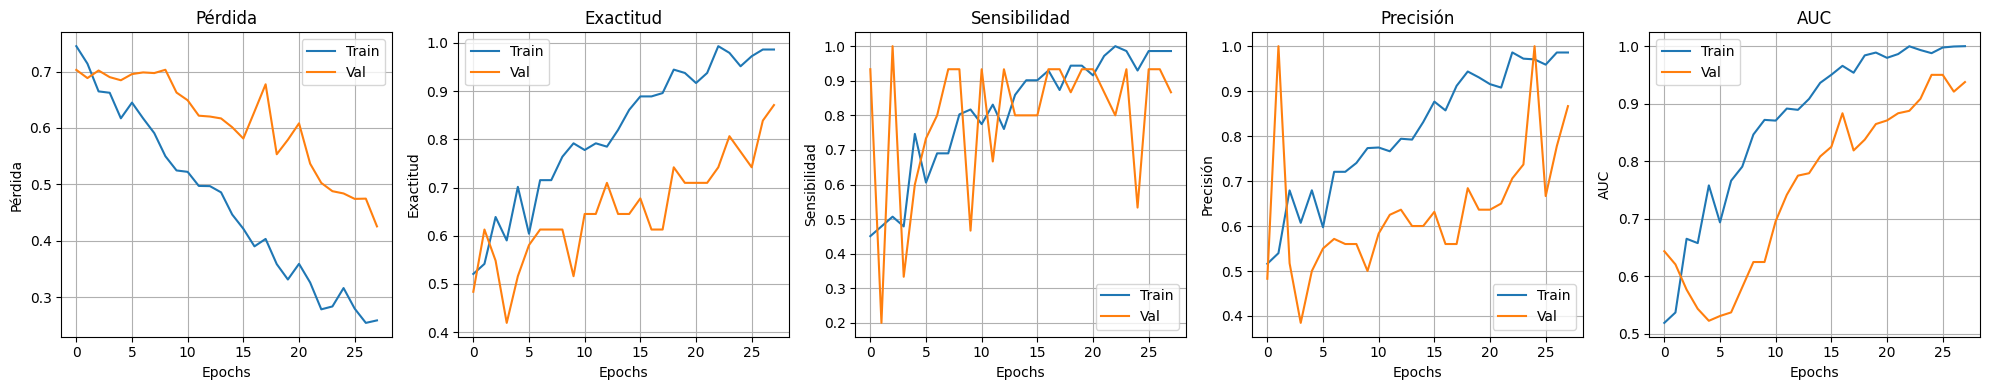

16/16 ━━━━━━━━━━━━━━━━━━━━ 143s 358ms/step

Métricas de evaluación:
Exactitud:     0.8438
Precisión:     0.9231
Sensibilidad:  0.7500
Especificidad: 0.9375
F1-score:      0.8276
AUC:           0.8789


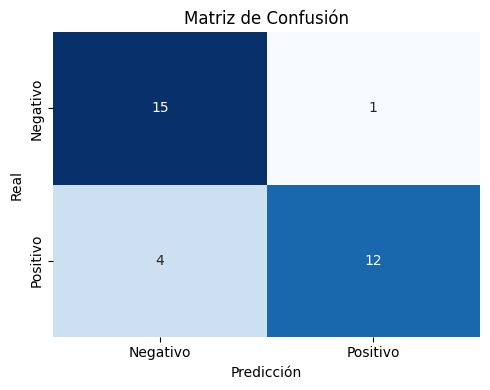

In [ ]:
p.plot_training(mobilenetv2_gru_label_smoothing_model_history)
model_metrics_dataset(mobilenetv2_gru_label_smoothing_model, test_ds)

In [ ]:
models_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models"

mobilenetv2_gru_label_smoothing_model.save_weights('/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models/MOBILENETV2_GRU_LABEL_SMOOTHING.weights.h5')

with open(os.path.join(models_dir, "MOBILENETV2_GRU_LABEL_SMOOTHING_history.pkl"), "wb") as f:
    pickle.dump(mobilenetv2_gru_label_smoothing_model_history.history, f)

### 4.4.3 - Modelo preentrenado con MobileNetV2 con *imae*.

In [ ]:
def iMAE_loss():
    """
    Devuelve una función de pérdida basada en el error absoluto medio (MAE) para clasificación binaria.

    Esta función calcula la media de los errores absolutos entre las predicciones y las etiquetas verdaderas.
    Aunque aquí se denomina iMAE, la implementación actual corresponde al MAE clásico. Su uso puede ser útil
    cuando se quiere evitar penalizaciones cuadráticas como en MSE, y mantener una medida más robusta ante outliers.

    Returns
    -------
    loss_fn : function
        Función de pérdida que puede ser utilizada en la compilación de un modelo Keras.

    Notes
    -----
    - Las etiquetas verdaderas (`y_true`) se convierten a `float32`.
    - La pérdida resultante es el promedio de las diferencias absolutas entre `y_true` y `y_pred`.
    - Para que esta pérdida funcione correctamente, se espera que las salidas estén en [0, 1].
    """
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        return tf.reduce_mean(tf.abs(y_true - y_pred))
    return loss

In [ ]:
mobilenetv2_gru_imae_model = MOBILENETV2_GRU(input_shape=X_train.shape[1:])

mobilenetv2_gru_imae_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=iMAE_loss(),
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [ ]:
tracker = EmissionsTracker()
tracker.start()
start = time.time()

mobilenetv2_gru_imae_model_history = mobilenetv2_gru_imae_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)

end = time.time()
emissions = tracker.stop()
print(f"\nTiempo de entrenamiento: {(end - start):.2f} segundos")
print(f"\nEmisiones estimadas: {emissions:.4f} kg de CO2")

[codecarbon WARNING @ 12:28:07] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 12:28:07] [setup] RAM Tracking...
[codecarbon INFO @ 12:28:07] [setup] CPU Tracking...
[codecarbon WARNING @ 12:28:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:28:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:28:08] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:28:08] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:28:08] [setup] GPU Tracking...
[codecarbon INFO @ 12:28:08] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:28:08] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/30


[codecarbon INFO @ 12:28:23] Energy consumed for RAM : 0.000158 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:28:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:28:23] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 12:28:23] Energy consumed for all GPUs : 0.000249 kWh. Total GPU Power : 59.619133604450596 W
[codecarbon INFO @ 12:28:23] 0.000584 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:28:38] Energy consumed for RAM : 0.000317 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:28:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:28:38] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 12:28:38] Energy consumed for all GPUs : 0.000495 kWh. Total GPU Power : 59.22526723347344 W
[codecarbon INFO @ 12:28:38] 0.001166 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:28:53] Energy consumed for RAM : 0.000475 kWh. RAM Power : 

33/72 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.4601 - auc: 0.4692 - loss: 0.5209 - precision: 0.4580 - recall: 0.2149

[codecarbon INFO @ 12:35:40] Energy consumed for RAM : 0.004761 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:35:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:35:40] Energy consumed for All CPU : 0.005327 kWh
[codecarbon INFO @ 12:35:40] Energy consumed for all GPUs : 0.007771 kWh. Total GPU Power : 99.84494886057651 W
[codecarbon INFO @ 12:35:40] 0.017859 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.4754 - auc: 0.4706 - loss: 0.5158 - precision: 0.4556 - recall: 0.2346

[codecarbon INFO @ 12:35:55] Energy consumed for RAM : 0.004919 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:35:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:35:55] Energy consumed for All CPU : 0.005505 kWh
[codecarbon INFO @ 12:35:55] Energy consumed for all GPUs : 0.008226 kWh. Total GPU Power : 109.11249316378611 W
[codecarbon INFO @ 12:35:55] 0.018650 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:36:10] Energy consumed for RAM : 0.005077 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:36:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:36:10] Energy consumed for All CPU : 0.005681 kWh
[codecarbon INFO @ 12:36:10] Energy consumed for all GPUs : 0.008489 kWh. Total GPU Power : 63.248905249861295 W
[codecarbon INFO @ 12:36:10] 0.019248 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:36:10] 0.019279 g.CO2eq/s mean an estimation of 607.967866

72/72 ━━━━━━━━━━━━━━━━━━━━ 612s 2s/step - accuracy: 0.4753 - auc: 0.4705 - loss: 0.5158 - precision: 0.4552 - recall: 0.2341 - val_accuracy: 0.4839 - val_auc: 0.4667 - val_loss: 0.5149 - val_precision: 0.3333 - val_recall: 0.0667
Epoch 2/30
15/72 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - accuracy: 0.3879 - auc: 0.4514 - loss: 0.5640 - precision: 0.6722 - recall: 0.1422

[codecarbon INFO @ 12:38:25] Energy consumed for RAM : 0.006507 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:38:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:25] Energy consumed for All CPU : 0.007281 kWh
[codecarbon INFO @ 12:38:25] Energy consumed for all GPUs : 0.010973 kWh. Total GPU Power : 96.61117853312436 W
[codecarbon INFO @ 12:38:25] 0.024761 kWh of electricity used since the beginning.


56/72 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 0.5447 - auc: 0.5696 - loss: 0.4897 - precision: 0.7471 - recall: 0.2735

[codecarbon INFO @ 12:38:40] Energy consumed for RAM : 0.006665 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:38:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:40] Energy consumed for All CPU : 0.007458 kWh
[codecarbon INFO @ 12:38:40] Energy consumed for all GPUs : 0.011436 kWh. Total GPU Power : 111.1920735091148 W
[codecarbon INFO @ 12:38:40] 0.025559 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 445ms/step - accuracy: 0.5527 - auc: 0.5758 - loss: 0.4849 - precision: 0.7301 - recall: 0.2783 - val_accuracy: 0.4516 - val_auc: 0.4958 - val_loss: 0.5257 - val_precision: 0.3750 - val_recall: 0.2000
Epoch 3/30
 9/72 ━━━━━━━━━━━━━━━━━━━━ 22s 365ms/step - accuracy: 0.7302 - auc: 0.8029 - loss: 0.3439 - precision: 0.8339 - recall: 0.6203

[codecarbon INFO @ 12:38:55] Energy consumed for RAM : 0.006823 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:38:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:55] Energy consumed for All CPU : 0.007635 kWh
[codecarbon INFO @ 12:38:55] Energy consumed for all GPUs : 0.011897 kWh. Total GPU Power : 110.74821640942253 W
[codecarbon INFO @ 12:38:55] 0.026356 kWh of electricity used since the beginning.


50/72 ━━━━━━━━━━━━━━━━━━━━ 8s 366ms/step - accuracy: 0.5590 - auc: 0.6040 - loss: 0.4504 - precision: 0.5445 - recall: 0.4055

[codecarbon INFO @ 12:39:10] Energy consumed for RAM : 0.006982 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:39:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:10] Energy consumed for All CPU : 0.007812 kWh
[codecarbon INFO @ 12:39:10] Energy consumed for all GPUs : 0.012361 kWh. Total GPU Power : 111.34184718175234 W
[codecarbon INFO @ 12:39:10] 0.027155 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 447ms/step - accuracy: 0.5487 - auc: 0.6010 - loss: 0.4553 - precision: 0.5430 - recall: 0.4071 - val_accuracy: 0.5484 - val_auc: 0.4813 - val_loss: 0.5184 - val_precision: 0.5185 - val_recall: 0.9333
Epoch 4/30
 3/72 ━━━━━━━━━━━━━━━━━━━━ 26s 384ms/step - accuracy: 0.5556 - auc: 0.0000e+00 - loss: 0.5814 - precision: 0.8222 - recall: 0.6556

[codecarbon INFO @ 12:39:25] Energy consumed for RAM : 0.007140 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:39:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:25] Energy consumed for All CPU : 0.007989 kWh
[codecarbon INFO @ 12:39:25] Energy consumed for all GPUs : 0.012829 kWh. Total GPU Power : 112.34989884205787 W
[codecarbon INFO @ 12:39:25] 0.027958 kWh of electricity used since the beginning.


44/72 ━━━━━━━━━━━━━━━━━━━━ 10s 370ms/step - accuracy: 0.6037 - auc: 0.4915 - loss: 0.4770 - precision: 0.6278 - recall: 0.8189

[codecarbon INFO @ 12:39:40] Energy consumed for RAM : 0.007298 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:39:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:40] Energy consumed for All CPU : 0.008166 kWh
[codecarbon INFO @ 12:39:40] Energy consumed for all GPUs : 0.013292 kWh. Total GPU Power : 111.0626386288426 W
[codecarbon INFO @ 12:39:40] 0.028756 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6109 - auc: 0.5509 - loss: 0.4626 - precision: 0.6180 - recall: 0.7635

[codecarbon INFO @ 12:39:55] Energy consumed for RAM : 0.007457 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:39:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:55] Energy consumed for All CPU : 0.008343 kWh
[codecarbon INFO @ 12:39:55] Energy consumed for all GPUs : 0.013760 kWh. Total GPU Power : 112.4591552675031 W
[codecarbon INFO @ 12:39:55] 0.029560 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 447ms/step - accuracy: 0.6109 - auc: 0.5520 - loss: 0.4623 - precision: 0.6178 - recall: 0.7614 - val_accuracy: 0.4516 - val_auc: 0.5188 - val_loss: 0.5125 - val_precision: 0.4000 - val_recall: 0.2667
Epoch 5/30
39/72 ━━━━━━━━━━━━━━━━━━━━ 12s 364ms/step - accuracy: 0.6918 - auc: 0.7489 - loss: 0.3737 - precision: 0.6719 - recall: 0.6813

[codecarbon INFO @ 12:40:10] Energy consumed for RAM : 0.007615 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:40:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:10] Energy consumed for All CPU : 0.008520 kWh
[codecarbon INFO @ 12:40:10] Energy consumed for all GPUs : 0.014228 kWh. Total GPU Power : 112.29334734313004 W
[codecarbon INFO @ 12:40:10] 0.030363 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:40:10] 0.023915 g.CO2eq/s mean an estimation of 754.1693491837344 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.6899 - auc: 0.7480 - loss: 0.3802 - precision: 0.6865 - recall: 0.6592

[codecarbon INFO @ 12:40:25] Energy consumed for RAM : 0.007773 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:40:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:25] Energy consumed for All CPU : 0.008697 kWh
[codecarbon INFO @ 12:40:25] Energy consumed for all GPUs : 0.014696 kWh. Total GPU Power : 112.30307851739056 W
[codecarbon INFO @ 12:40:25] 0.031166 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 445ms/step - accuracy: 0.6899 - auc: 0.7480 - loss: 0.3802 - precision: 0.6866 - recall: 0.6590 - val_accuracy: 0.6452 - val_auc: 0.5458 - val_loss: 0.4899 - val_precision: 0.5909 - val_recall: 0.8667
Epoch 6/30
34/72 ━━━━━━━━━━━━━━━━━━━━ 13s 363ms/step - accuracy: 0.8592 - auc: 0.8845 - loss: 0.3049 - precision: 0.8559 - recall: 0.7645

[codecarbon INFO @ 12:40:40] Energy consumed for RAM : 0.007931 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:40:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:40] Energy consumed for All CPU : 0.008874 kWh
[codecarbon INFO @ 12:40:40] Energy consumed for all GPUs : 0.015162 kWh. Total GPU Power : 111.78166010554898 W
[codecarbon INFO @ 12:40:40] 0.031967 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8324 - auc: 0.8626 - loss: 0.3158 - precision: 0.8426 - recall: 0.7743

[codecarbon INFO @ 12:40:55] Energy consumed for RAM : 0.008090 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:40:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:55] Energy consumed for All CPU : 0.009051 kWh
[codecarbon INFO @ 12:40:55] Energy consumed for all GPUs : 0.015631 kWh. Total GPU Power : 112.61946076416474 W
[codecarbon INFO @ 12:40:55] 0.032772 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 445ms/step - accuracy: 0.8314 - auc: 0.8616 - loss: 0.3163 - precision: 0.8414 - recall: 0.7739 - val_accuracy: 0.4839 - val_auc: 0.5688 - val_loss: 0.4917 - val_precision: 0.4615 - val_recall: 0.4000
Epoch 7/30
28/72 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.6933 - auc: 0.7390 - loss: 0.3363 - precision: 0.7039 - recall: 0.6921

[codecarbon INFO @ 12:41:10] Energy consumed for RAM : 0.008248 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:41:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:10] Energy consumed for All CPU : 0.009228 kWh
[codecarbon INFO @ 12:41:10] Energy consumed for all GPUs : 0.016097 kWh. Total GPU Power : 111.82887820528836 W
[codecarbon INFO @ 12:41:10] 0.033573 kWh of electricity used since the beginning.


69/72 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.6964 - auc: 0.7602 - loss: 0.3442 - precision: 0.6808 - recall: 0.7156

[codecarbon INFO @ 12:41:25] Energy consumed for RAM : 0.008406 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:41:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:25] Energy consumed for All CPU : 0.009405 kWh
[codecarbon INFO @ 12:41:25] Energy consumed for all GPUs : 0.016563 kWh. Total GPU Power : 112.0007222111576 W
[codecarbon INFO @ 12:41:25] 0.034375 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 446ms/step - accuracy: 0.6974 - auc: 0.7612 - loss: 0.3444 - precision: 0.6816 - recall: 0.7175 - val_accuracy: 0.6452 - val_auc: 0.5688 - val_loss: 0.4611 - val_precision: 0.5909 - val_recall: 0.8667
Epoch 8/30
23/72 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7068 - auc: 0.8292 - loss: 0.3132 - precision: 0.7095 - recall: 0.8059

[codecarbon INFO @ 12:41:40] Energy consumed for RAM : 0.008565 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:41:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:40] Energy consumed for All CPU : 0.009583 kWh
[codecarbon INFO @ 12:41:40] Energy consumed for all GPUs : 0.017034 kWh. Total GPU Power : 113.02754342322524 W
[codecarbon INFO @ 12:41:40] 0.035181 kWh of electricity used since the beginning.


64/72 ━━━━━━━━━━━━━━━━━━━━ 2s 366ms/step - accuracy: 0.7395 - auc: 0.8394 - loss: 0.3042 - precision: 0.7179 - recall: 0.8200

[codecarbon INFO @ 12:41:55] Energy consumed for RAM : 0.008723 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:41:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:55] Energy consumed for All CPU : 0.009760 kWh
[codecarbon INFO @ 12:41:55] Energy consumed for all GPUs : 0.017502 kWh. Total GPU Power : 112.23922130902339 W
[codecarbon INFO @ 12:41:55] 0.035984 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 450ms/step - accuracy: 0.7432 - auc: 0.8384 - loss: 0.3038 - precision: 0.7246 - recall: 0.8132 - val_accuracy: 0.5484 - val_auc: 0.5667 - val_loss: 0.4696 - val_precision: 0.5263 - val_recall: 0.6667
Epoch 9/30
16/72 ━━━━━━━━━━━━━━━━━━━━ 20s 365ms/step - accuracy: 0.8905 - auc: 0.9473 - loss: 0.1907 - precision: 0.9397 - recall: 0.8635

[codecarbon INFO @ 12:42:10] Energy consumed for RAM : 0.008881 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:42:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:10] Energy consumed for All CPU : 0.009937 kWh
[codecarbon INFO @ 12:42:10] Energy consumed for all GPUs : 0.017970 kWh. Total GPU Power : 112.41761974776632 W
[codecarbon INFO @ 12:42:10] 0.036788 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:10] 0.024231 g.CO2eq/s mean an estimation of 764.1468687733116 kg.CO2eq/year


58/72 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 0.8103 - auc: 0.8643 - loss: 0.2688 - precision: 0.8067 - recall: 0.8308

[codecarbon INFO @ 12:42:25] Energy consumed for RAM : 0.009039 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:42:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:25] Energy consumed for All CPU : 0.010114 kWh
[codecarbon INFO @ 12:42:25] Energy consumed for all GPUs : 0.018437 kWh. Total GPU Power : 112.05756281742757 W
[codecarbon INFO @ 12:42:25] 0.037590 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 447ms/step - accuracy: 0.8010 - auc: 0.8560 - loss: 0.2754 - precision: 0.7901 - recall: 0.8276 - val_accuracy: 0.6129 - val_auc: 0.5708 - val_loss: 0.4521 - val_precision: 0.5789 - val_recall: 0.7333
Epoch 10/30
11/72 ━━━━━━━━━━━━━━━━━━━━ 22s 362ms/step - accuracy: 0.8728 - auc: 0.8082 - loss: 0.2107 - precision: 0.9930 - recall: 0.8330

[codecarbon INFO @ 12:42:40] Energy consumed for RAM : 0.009198 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:42:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:40] Energy consumed for All CPU : 0.010291 kWh
[codecarbon INFO @ 12:42:40] Energy consumed for all GPUs : 0.018903 kWh. Total GPU Power : 111.8838159940086 W
[codecarbon INFO @ 12:42:40] 0.038391 kWh of electricity used since the beginning.


52/72 ━━━━━━━━━━━━━━━━━━━━ 7s 362ms/step - accuracy: 0.8363 - auc: 0.8727 - loss: 0.2421 - precision: 0.8633 - recall: 0.8593

[codecarbon INFO @ 12:42:55] Energy consumed for RAM : 0.009356 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:42:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:55] Energy consumed for All CPU : 0.010468 kWh
[codecarbon INFO @ 12:42:55] Energy consumed for all GPUs : 0.019372 kWh. Total GPU Power : 112.71463490862786 W
[codecarbon INFO @ 12:42:55] 0.039196 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 441ms/step - accuracy: 0.8220 - auc: 0.8617 - loss: 0.2516 - precision: 0.8314 - recall: 0.8612 - val_accuracy: 0.4194 - val_auc: 0.5854 - val_loss: 0.4963 - val_precision: 0.3636 - val_recall: 0.2667
Epoch 11/30
 6/72 ━━━━━━━━━━━━━━━━━━━━ 24s 369ms/step - accuracy: 0.7972 - auc: 0.7922 - loss: 0.3487 - precision: 1.0000 - recall: 0.6675

[codecarbon INFO @ 12:43:10] Energy consumed for RAM : 0.009514 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:43:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:10] Energy consumed for All CPU : 0.010645 kWh
[codecarbon INFO @ 12:43:10] Energy consumed for all GPUs : 0.019841 kWh. Total GPU Power : 112.52728157636929 W
[codecarbon INFO @ 12:43:10] 0.040000 kWh of electricity used since the beginning.


48/72 ━━━━━━━━━━━━━━━━━━━━ 8s 362ms/step - accuracy: 0.7590 - auc: 0.8221 - loss: 0.3066 - precision: 0.8491 - recall: 0.6827

[codecarbon INFO @ 12:43:25] Energy consumed for RAM : 0.009672 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:43:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:25] Energy consumed for All CPU : 0.010822 kWh
[codecarbon INFO @ 12:43:25] Energy consumed for all GPUs : 0.020311 kWh. Total GPU Power : 112.76444731267691 W
[codecarbon INFO @ 12:43:25] 0.040805 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 441ms/step - accuracy: 0.7672 - auc: 0.8230 - loss: 0.2989 - precision: 0.8204 - recall: 0.7205 - val_accuracy: 0.6452 - val_auc: 0.6083 - val_loss: 0.4315 - val_precision: 0.6111 - val_recall: 0.7333
Epoch 12/30
 2/72 ━━━━━━━━━━━━━━━━━━━━ 24s 352ms/step - accuracy: 0.8750 - auc: 1.0000 - loss: 0.1056 - precision: 1.0000 - recall: 0.8333

[codecarbon INFO @ 12:43:40] Energy consumed for RAM : 0.009831 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:43:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:40] Energy consumed for All CPU : 0.010999 kWh
[codecarbon INFO @ 12:43:40] Energy consumed for all GPUs : 0.020779 kWh. Total GPU Power : 112.45280934482525 W
[codecarbon INFO @ 12:43:40] 0.041609 kWh of electricity used since the beginning.


43/72 ━━━━━━━━━━━━━━━━━━━━ 10s 361ms/step - accuracy: 0.7454 - auc: 0.8761 - loss: 0.2684 - precision: 0.8076 - recall: 0.7769

[codecarbon INFO @ 12:43:55] Energy consumed for RAM : 0.009989 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:43:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:55] Energy consumed for All CPU : 0.011176 kWh
[codecarbon INFO @ 12:43:55] Energy consumed for all GPUs : 0.021250 kWh. Total GPU Power : 112.93277438493352 W
[codecarbon INFO @ 12:43:55] 0.042415 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7538 - auc: 0.8667 - loss: 0.2714 - precision: 0.7786 - recall: 0.8026

[codecarbon INFO @ 12:44:10] Energy consumed for RAM : 0.010147 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:44:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:44:10] Energy consumed for All CPU : 0.011353 kWh
[codecarbon INFO @ 12:44:10] Energy consumed for all GPUs : 0.021720 kWh. Total GPU Power : 112.81799688194349 W
[codecarbon INFO @ 12:44:10] 0.043220 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:44:10] 0.024261 g.CO2eq/s mean an estimation of 765.1039842858 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 441ms/step - accuracy: 0.7541 - auc: 0.8666 - loss: 0.2714 - precision: 0.7780 - recall: 0.8034 - val_accuracy: 0.6774 - val_auc: 0.6313 - val_loss: 0.4129 - val_precision: 0.6316 - val_recall: 0.8000
Epoch 13/30
39/72 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.7815 - auc: 0.8603 - loss: 0.2807 - precision: 0.7499 - recall: 0.7868

[codecarbon INFO @ 12:44:25] Energy consumed for RAM : 0.010306 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:44:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:44:25] Energy consumed for All CPU : 0.011530 kWh
[codecarbon INFO @ 12:44:25] Energy consumed for all GPUs : 0.022189 kWh. Total GPU Power : 112.6366928075616 W
[codecarbon INFO @ 12:44:25] 0.044024 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7777 - auc: 0.8491 - loss: 0.2790 - precision: 0.7511 - recall: 0.8057

[codecarbon INFO @ 12:44:40] Energy consumed for RAM : 0.010464 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:44:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:44:40] Energy consumed for All CPU : 0.011707 kWh
[codecarbon INFO @ 12:44:40] Energy consumed for all GPUs : 0.022660 kWh. Total GPU Power : 112.98729937008261 W
[codecarbon INFO @ 12:44:40] 0.044831 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 440ms/step - accuracy: 0.7775 - auc: 0.8490 - loss: 0.2790 - precision: 0.7509 - recall: 0.8058 - val_accuracy: 0.7097 - val_auc: 0.6271 - val_loss: 0.3899 - val_precision: 0.6500 - val_recall: 0.8667
Epoch 14/30
34/72 ━━━━━━━━━━━━━━━━━━━━ 13s 362ms/step - accuracy: 0.8241 - auc: 0.8512 - loss: 0.2230 - precision: 0.7364 - recall: 0.8722

[codecarbon INFO @ 12:44:55] Energy consumed for RAM : 0.010622 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:44:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:44:55] Energy consumed for All CPU : 0.011884 kWh
[codecarbon INFO @ 12:44:55] Energy consumed for all GPUs : 0.023128 kWh. Total GPU Power : 112.48553754083437 W
[codecarbon INFO @ 12:44:55] 0.045634 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8032 - auc: 0.8526 - loss: 0.2428 - precision: 0.7371 - recall: 0.8649

[codecarbon INFO @ 12:45:10] Energy consumed for RAM : 0.010780 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:45:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:45:10] Energy consumed for All CPU : 0.012061 kWh
[codecarbon INFO @ 12:45:10] Energy consumed for all GPUs : 0.023599 kWh. Total GPU Power : 112.96793704752695 W
[codecarbon INFO @ 12:45:10] 0.046440 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 445ms/step - accuracy: 0.8028 - auc: 0.8526 - loss: 0.2430 - precision: 0.7370 - recall: 0.8649 - val_accuracy: 0.5806 - val_auc: 0.6625 - val_loss: 0.4091 - val_precision: 0.5625 - val_recall: 0.6000
Epoch 15/30
29/72 ━━━━━━━━━━━━━━━━━━━━ 15s 361ms/step - accuracy: 0.8156 - auc: 0.8442 - loss: 0.2579 - precision: 0.7986 - recall: 0.8679

[codecarbon INFO @ 12:45:25] Energy consumed for RAM : 0.010939 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:45:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:45:25] Energy consumed for All CPU : 0.012238 kWh
[codecarbon INFO @ 12:45:25] Energy consumed for all GPUs : 0.024068 kWh. Total GPU Power : 112.56155168302627 W
[codecarbon INFO @ 12:45:25] 0.047245 kWh of electricity used since the beginning.


70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8161 - auc: 0.8611 - loss: 0.2455 - precision: 0.7818 - recall: 0.8821

[codecarbon INFO @ 12:45:40] Energy consumed for RAM : 0.011097 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:45:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:45:40] Energy consumed for All CPU : 0.012415 kWh
[codecarbon INFO @ 12:45:40] Energy consumed for all GPUs : 0.024535 kWh. Total GPU Power : 112.22073436229857 W
[codecarbon INFO @ 12:45:40] 0.048047 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 446ms/step - accuracy: 0.8165 - auc: 0.8612 - loss: 0.2449 - precision: 0.7816 - recall: 0.8828 - val_accuracy: 0.6774 - val_auc: 0.7042 - val_loss: 0.3592 - val_precision: 0.6190 - val_recall: 0.8667
Epoch 16/30
23/72 ━━━━━━━━━━━━━━━━━━━━ 17s 358ms/step - accuracy: 0.8178 - auc: 0.9078 - loss: 0.1969 - precision: 0.7302 - recall: 0.9750

[codecarbon INFO @ 12:45:55] Energy consumed for RAM : 0.011255 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:45:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:45:55] Energy consumed for All CPU : 0.012592 kWh
[codecarbon INFO @ 12:45:55] Energy consumed for all GPUs : 0.025004 kWh. Total GPU Power : 112.54978207556735 W
[codecarbon INFO @ 12:45:55] 0.048852 kWh of electricity used since the beginning.


65/72 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.8083 - auc: 0.8921 - loss: 0.2145 - precision: 0.7249 - recall: 0.9234

[codecarbon INFO @ 12:46:10] Energy consumed for RAM : 0.011414 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:46:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:46:10] Energy consumed for All CPU : 0.012769 kWh
[codecarbon INFO @ 12:46:10] Energy consumed for all GPUs : 0.025473 kWh. Total GPU Power : 112.66463451585808 W
[codecarbon INFO @ 12:46:10] 0.049656 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:46:10] 0.024276 g.CO2eq/s mean an estimation of 765.5597648685568 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 441ms/step - accuracy: 0.8093 - auc: 0.8923 - loss: 0.2143 - precision: 0.7319 - recall: 0.9158 - val_accuracy: 0.6129 - val_auc: 0.7188 - val_loss: 0.3793 - val_precision: 0.5600 - val_recall: 0.9333
Epoch 17/30
18/72 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.9608 - auc: 0.9248 - loss: 0.1001 - precision: 0.9416 - recall: 1.0000

[codecarbon INFO @ 12:46:25] Energy consumed for RAM : 0.011572 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:46:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:46:25] Energy consumed for All CPU : 0.012946 kWh
[codecarbon INFO @ 12:46:25] Energy consumed for all GPUs : 0.025939 kWh. Total GPU Power : 111.85117697674285 W
[codecarbon INFO @ 12:46:25] 0.050457 kWh of electricity used since the beginning.


59/72 ━━━━━━━━━━━━━━━━━━━━ 4s 370ms/step - accuracy: 0.8912 - auc: 0.9229 - loss: 0.1581 - precision: 0.8637 - recall: 0.9522

[codecarbon INFO @ 12:46:40] Energy consumed for RAM : 0.011730 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:46:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:46:40] Energy consumed for All CPU : 0.013123 kWh
[codecarbon INFO @ 12:46:40] Energy consumed for all GPUs : 0.026409 kWh. Total GPU Power : 112.62682799546718 W
[codecarbon INFO @ 12:46:40] 0.051262 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 448ms/step - accuracy: 0.8830 - auc: 0.9194 - loss: 0.1659 - precision: 0.8522 - recall: 0.9465 - val_accuracy: 0.6774 - val_auc: 0.7208 - val_loss: 0.3630 - val_precision: 0.6667 - val_recall: 0.6667
Epoch 18/30
12/72 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.8230 - auc: 0.7736 - loss: 0.2689 - precision: 0.8680 - recall: 0.8387

[codecarbon INFO @ 12:46:55] Energy consumed for RAM : 0.011888 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:46:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:46:55] Energy consumed for All CPU : 0.013300 kWh
[codecarbon INFO @ 12:46:55] Energy consumed for all GPUs : 0.026875 kWh. Total GPU Power : 111.97730687454398 W
[codecarbon INFO @ 12:46:55] 0.052064 kWh of electricity used since the beginning.


53/72 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.8000 - auc: 0.8216 - loss: 0.2578 - precision: 0.8441 - recall: 0.8033

[codecarbon INFO @ 12:47:10] Energy consumed for RAM : 0.012047 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:47:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:47:10] Energy consumed for All CPU : 0.013477 kWh
[codecarbon INFO @ 12:47:10] Energy consumed for all GPUs : 0.027343 kWh. Total GPU Power : 112.23148994350014 W
[codecarbon INFO @ 12:47:10] 0.052866 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 443ms/step - accuracy: 0.8140 - auc: 0.8336 - loss: 0.2453 - precision: 0.8423 - recall: 0.8227 - val_accuracy: 0.7097 - val_auc: 0.7125 - val_loss: 0.3252 - val_precision: 0.6500 - val_recall: 0.8667
Epoch 19/30
 7/72 ━━━━━━━━━━━━━━━━━━━━ 23s 356ms/step - accuracy: 0.7759 - auc: 0.8126 - loss: 0.2167 - precision: 0.8288 - recall: 0.8201

[codecarbon INFO @ 12:47:25] Energy consumed for RAM : 0.012205 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:47:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:47:25] Energy consumed for All CPU : 0.013654 kWh
[codecarbon INFO @ 12:47:25] Energy consumed for all GPUs : 0.027816 kWh. Total GPU Power : 113.68905330274171 W
[codecarbon INFO @ 12:47:25] 0.053675 kWh of electricity used since the beginning.


49/72 ━━━━━━━━━━━━━━━━━━━━ 8s 361ms/step - accuracy: 0.8367 - auc: 0.8432 - loss: 0.1890 - precision: 0.8208 - recall: 0.8991

[codecarbon INFO @ 12:47:40] Energy consumed for RAM : 0.012363 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:47:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:47:40] Energy consumed for All CPU : 0.013831 kWh
[codecarbon INFO @ 12:47:40] Energy consumed for all GPUs : 0.028284 kWh. Total GPU Power : 112.29849367506826 W
[codecarbon INFO @ 12:47:40] 0.054478 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 440ms/step - accuracy: 0.8382 - auc: 0.8557 - loss: 0.1861 - precision: 0.8202 - recall: 0.8877 - val_accuracy: 0.7097 - val_auc: 0.7458 - val_loss: 0.3297 - val_precision: 0.6364 - val_recall: 0.9333
Epoch 20/30
 3/72 ━━━━━━━━━━━━━━━━━━━━ 24s 355ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0415 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 12:47:55] Energy consumed for RAM : 0.012521 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:47:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:47:55] Energy consumed for All CPU : 0.014008 kWh
[codecarbon INFO @ 12:47:55] Energy consumed for all GPUs : 0.028752 kWh. Total GPU Power : 112.45446718535412 W
[codecarbon INFO @ 12:47:55] 0.055282 kWh of electricity used since the beginning.


44/72 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.9509 - auc: 0.9517 - loss: 0.0827 - precision: 0.9594 - recall: 0.9387

[codecarbon INFO @ 12:48:10] Energy consumed for RAM : 0.012680 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:48:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:48:10] Energy consumed for All CPU : 0.014185 kWh
[codecarbon INFO @ 12:48:10] Energy consumed for all GPUs : 0.029220 kWh. Total GPU Power : 112.23273449961619 W
[codecarbon INFO @ 12:48:10] 0.056085 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:48:10] 0.024248 g.CO2eq/s mean an estimation of 764.6978098906366 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9218 - auc: 0.9363 - loss: 0.1061 - precision: 0.9162 - recall: 0.9268

[codecarbon INFO @ 12:48:25] Energy consumed for RAM : 0.012838 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:48:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:48:25] Energy consumed for All CPU : 0.014362 kWh
[codecarbon INFO @ 12:48:25] Energy consumed for all GPUs : 0.029693 kWh. Total GPU Power : 113.43962096857939 W
[codecarbon INFO @ 12:48:25] 0.056893 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 443ms/step - accuracy: 0.9208 - auc: 0.9358 - loss: 0.1069 - precision: 0.9148 - recall: 0.9264 - val_accuracy: 0.7742 - val_auc: 0.7417 - val_loss: 0.3008 - val_precision: 0.7500 - val_recall: 0.8000
Epoch 21/30
39/72 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - accuracy: 0.7408 - auc: 0.8425 - loss: 0.2747 - precision: 0.7020 - recall: 0.6352

[codecarbon INFO @ 12:48:40] Energy consumed for RAM : 0.012996 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:48:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:48:40] Energy consumed for All CPU : 0.014539 kWh
[codecarbon INFO @ 12:48:40] Energy consumed for all GPUs : 0.030161 kWh. Total GPU Power : 112.37513053384318 W
[codecarbon INFO @ 12:48:40] 0.057696 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.7715 - auc: 0.8630 - loss: 0.2488 - precision: 0.7442 - recall: 0.7319

[codecarbon INFO @ 12:48:55] Energy consumed for RAM : 0.013155 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:48:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:48:55] Energy consumed for All CPU : 0.014716 kWh
[codecarbon INFO @ 12:48:55] Energy consumed for all GPUs : 0.030629 kWh. Total GPU Power : 112.30288720143308 W
[codecarbon INFO @ 12:48:55] 0.058500 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 446ms/step - accuracy: 0.7721 - auc: 0.8635 - loss: 0.2482 - precision: 0.7449 - recall: 0.7336 - val_accuracy: 0.7097 - val_auc: 0.7583 - val_loss: 0.3265 - val_precision: 0.7143 - val_recall: 0.6667
Epoch 22/30
34/72 ━━━━━━━━━━━━━━━━━━━━ 13s 365ms/step - accuracy: 0.8401 - auc: 0.8302 - loss: 0.2063 - precision: 0.8350 - recall: 0.8670

[codecarbon INFO @ 12:49:10] Energy consumed for RAM : 0.013313 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:49:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:49:10] Energy consumed for All CPU : 0.014894 kWh
[codecarbon INFO @ 12:49:10] Energy consumed for all GPUs : 0.031098 kWh. Total GPU Power : 112.67248878731601 W
[codecarbon INFO @ 12:49:10] 0.059304 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8591 - auc: 0.8594 - loss: 0.1844 - precision: 0.8515 - recall: 0.8778

[codecarbon INFO @ 12:49:25] Energy consumed for RAM : 0.013471 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:49:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:49:25] Energy consumed for All CPU : 0.015071 kWh
[codecarbon INFO @ 12:49:25] Energy consumed for all GPUs : 0.031566 kWh. Total GPU Power : 112.3633711637714 W
[codecarbon INFO @ 12:49:25] 0.060108 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 444ms/step - accuracy: 0.8595 - auc: 0.8600 - loss: 0.1840 - precision: 0.8515 - recall: 0.8783 - val_accuracy: 0.5806 - val_auc: 0.6604 - val_loss: 0.4260 - val_precision: 0.6000 - val_recall: 0.4000


[codecarbon INFO @ 12:49:30] Energy consumed for RAM : 0.013519 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:49:30] Delta energy consumed for CPU with constant : 0.000054 kWh, power : 42.5 W
[codecarbon INFO @ 12:49:30] Energy consumed for All CPU : 0.015124 kWh
[codecarbon INFO @ 12:49:30] Energy consumed for all GPUs : 0.031707 kWh. Total GPU Power : 111.5098479092372 W
[codecarbon INFO @ 12:49:30] 0.060350 kWh of electricity used since the beginning.



Tiempo de entrenamiento: 1281.90 segundos

Emisiones estimadas: 0.0273 kg de CO2


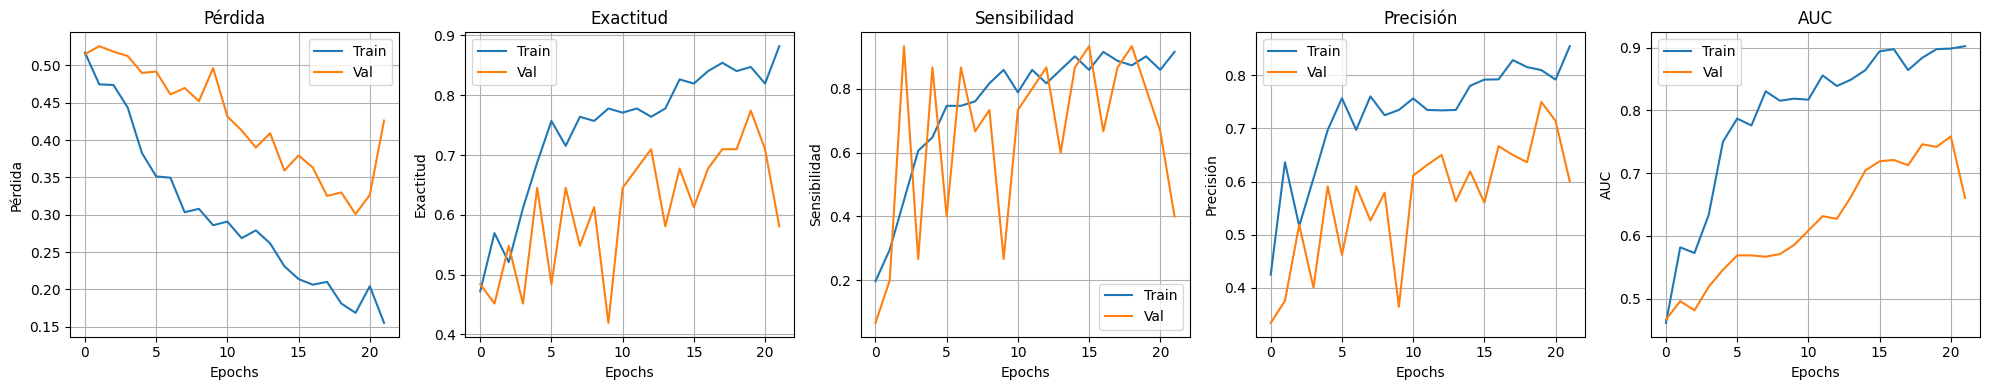

16/16 ━━━━━━━━━━━━━━━━━━━━ 143s 377ms/step

Métricas de evaluación:
Exactitud:     0.5312
Precisión:     0.5294
Sensibilidad:  0.5625
Especificidad: 0.5000
F1-score:      0.5455
AUC:           0.6289


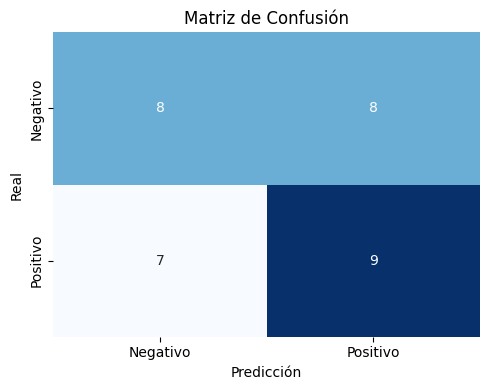

In [ ]:
p.plot_training(mobilenetv2_gru_imae_model_history)
model_metrics_dataset(mobilenetv2_gru_imae_model, test_ds)

In [ ]:
models_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models"

mobilenetv2_gru_imae_model.save_weights('/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models/MOBILENETV2_GRU_IMAE.weights.h5')

with open(os.path.join(models_dir, "MOBILENETV2_GRU_IMAE_history.pkl"), "wb") as f:
    pickle.dump(mobilenetv2_gru_imae_model_history.history, f)

## 4.5 - Búsqueda de hiperparámetros.
Con el objetivo de optimizar el rendimiento del modelo preentrenado con MobileNetV2, el cual ha obtenido los mejores resultados, se lleva a cabo una búsqueda de hiperparámetros mediante la librería *Optuna*.

In [ ]:
def objective(trial):
    """
    Modelo híbrido VGG16-GRU con fine-tuning parcial para la clasificación binaria de secuencias fMRI 2D.

    Esta arquitectura combina VGG16 preentrenado sobre ImageNet como extractor espacial, una capa GRU para
    capturar información temporal, y una capa densa final para clasificación. A diferencia del modelo congelado,
    en esta variante se liberan los bloques convolucionales 4 y 5 de VGG16, permitiendo su ajuste durante
    el entrenamiento (fine-tuning) para una mejor adaptación al dominio de fMRI.

    Parameters
    ----------
    input_shape : tuple, optional
        Forma de entrada sin incluir el batch. Por defecto (95, 224, 224, 3), donde:
            - 95 es el número de pasos temporales,
            - 224x224 el tamaño de las imágenes 2D,
            - 3 canales (RGB) para compatibilidad con VGG16.
    num_classes : int, optional
        Número de clases. Por defecto 1 (clasificación binaria con activación sigmoide).
    gru_units : int, optional
        Número de unidades en la capa GRU. Por defecto 64.
    dropout_rate : float, optional
        Tasa de dropout aplicada tras la capa densa. Por defecto 0.5.

    Returns
    -------
    tf.Tensor
        Tensor con las probabilidades por clase. En clasificación binaria, su forma es (batch_size, 1).
    """
    print(f"\nIniciando trial {trial.number}:")
    start_time = time.time()

    l2_lambda = trial.suggest_loguniform('l2', 1e-6, 1e-3)
    gru_units = trial.suggest_categorical('gru_units', [32, 64, 128])
    dense_units = trial.suggest_categorical('dense_units', [32, 64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)
    learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-3)

    model = MOBILENETV2_GRU(
        input_shape=X_train.shape[1:],
        num_classes=1,
        gru_units=gru_units,
        dropout_rate=dropout_rate
    )

    model.dense = tf.keras.layers.Dense(
        dense_units,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_recall',
        mode='max',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[early_stop],
        verbose=1
    )

    scores = model.evaluate(val_ds, verbose=0)
    recall = scores[2]

    duration = time.time() - start_time
    print(f"Trial {trial.number} completado en {duration:.1f} s - Recall: {recall:.4f}")

    return recall

In [ ]:
study = optuna.create_study(
    direction='maximize',
    study_name='mobilenetv2_gru_tuning',
    storage='sqlite:///mobilenetv2_gru_optuna.db',
    load_if_exists=True
)

study.optimize(objective, n_trials=10)

[I 2025-05-11 16:23:00,020] Using an existing study with name 'mobilenetv2_gru_tuning' instead of creating a new one.
<ipython-input-4-4f57b524d502>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_lambda = trial.suggest_loguniform('l2', 1e-6, 1e-3)
<ipython-input-4-4f57b524d502>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-3)



Iniciando trial 1:
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'mobilenetv2_gru', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 594s 2s/step - accuracy: 0.5816 - auc: 0.4912 - loss: 0.7668 - precision: 0.4864 - recall: 0.3053 - val_accuracy: 0.5484 - val_auc: 0.4104 - val_loss: 0.7141 - val_precision: 1.0000 - val_recall: 0.0667
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 428ms/step - accuracy: 0.5229 - auc: 0.4479 - loss: 0.7474 - precision: 0.5455 - recall: 0.5423 - val_accuracy: 0.5161 - val_auc: 0.4667 - val_loss: 0.7361 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 428ms/step - accuracy: 0.5637 - auc: 0.6424 - loss: 0.6872 - precision: 0.5404 - recall: 0.4113 - val_accuracy: 0.5484 - val_auc: 0.5312 - val_loss: 0.7195 - val_precision: 0.5200 - val_recall: 0.8667
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 428ms/step - accuracy: 0.6014 - auc: 0.6516 - loss: 0.6475 - precision: 0.6117 - recall: 0.5842 - val_accuracy: 0.5484 - val_auc: 0.4917 - val_loss: 0.7598 - val_precision: 1.0000 - val_recall: 0.0667
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━

[I 2025-05-11 16:37:39,432] Trial 1 finished with value: 1.0 and parameters: {'l2': 4.936478250921105e-05, 'gru_units': 64, 'dense_units': 64, 'dropout_rate': 0.28940034296816874, 'lr': 0.0009943735271862515}. Best is trial 1 with value: 1.0.


Trial 1 completado en 879.4 s - Recall: 1.0000

Iniciando trial 2:
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'mobilenetv2_gru_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 597s 2s/step - accuracy: 0.4315 - auc: 0.4045 - loss: 0.7953 - precision: 0.4082 - recall: 0.3671 - val_accuracy: 0.4839 - val_auc: 0.5688 - val_loss: 0.6807 - val_precision: 0.4706 - val_recall: 0.5333
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 435ms/step - accuracy: 0.5159 - auc: 0.5323 - loss: 0.7042 - precision: 0.4933 - recall: 0.5194 - val_accuracy: 0.5484 - val_auc: 0.5375 - val_loss: 0.6993 - val_precision: 0.5172 - val_recall: 1.0000
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 433ms/step - accuracy: 0.6279 - auc: 0.6880 - loss: 0.6351 - precision: 0.6053 - recall: 0.7615 - val_accuracy: 0.5806 - val_auc: 0.4979 - val_loss: 0.7236 - val_precision: 0.5500 - val_recall: 0.7333
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 430ms/step - accuracy: 0.5718 - auc: 0.6273 - loss: 0.6557 - precision: 0.5432 - recall: 0.6033 - val_accuracy: 0.4839 - val_auc: 0.5833 - val_loss: 0.6807 - val_precision: 0.4667 - val_recall: 0.4667
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s

[I 2025-05-11 16:50:49,193] Trial 2 finished with value: 1.0 and parameters: {'l2': 7.630515260482593e-06, 'gru_units': 64, 'dense_units': 32, 'dropout_rate': 0.48993733492917635, 'lr': 0.00026859519495107525}. Best is trial 1 with value: 1.0.


Trial 2 completado en 789.7 s - Recall: 1.0000

Iniciando trial 3:
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'mobilenetv2_gru_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 607s 2s/step - accuracy: 0.5728 - auc: 0.5165 - loss: 0.7579 - precision: 0.5260 - recall: 0.4892 - val_accuracy: 0.4839 - val_auc: 0.4958 - val_loss: 0.6890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 430ms/step - accuracy: 0.5679 - auc: 0.5854 - loss: 0.6793 - precision: 0.6390 - recall: 0.6160 - val_accuracy: 0.5484 - val_auc: 0.5500 - val_loss: 0.6804 - val_precision: 1.0000 - val_recall: 0.0667
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 429ms/step - accuracy: 0.7038 - auc: 0.7197 - loss: 0.6353 - precision: 0.7336 - recall: 0.7201 - val_accuracy: 0.4839 - val_auc: 0.5417 - val_loss: 0.7048 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 431ms/step - accuracy: 0.7185 - auc: 0.8364 - loss: 0.5703 - precision: 0.8056 - recall: 0.4616 - val_accuracy: 0.5161 - val_auc: 0.5229 - val_loss: 0.7055 - val_precision: 0.5000 - val_recall: 0.8000
Epoch 5/10
72/72 ━━━━━━━━

[I 2025-05-11 17:05:40,116] Trial 3 finished with value: 0.9333333373069763 and parameters: {'l2': 6.920550820749753e-06, 'gru_units': 128, 'dense_units': 32, 'dropout_rate': 0.26168417244212333, 'lr': 0.00030019722050917937}. Best is trial 1 with value: 1.0.


Trial 3 completado en 890.9 s - Recall: 0.9333

Iniciando trial 4:
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'mobilenetv2_gru_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 596s 2s/step - accuracy: 0.5277 - auc: 0.5245 - loss: 0.7074 - precision: 0.5076 - recall: 0.4938 - val_accuracy: 0.5161 - val_auc: 0.5167 - val_loss: 0.8033 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 429ms/step - accuracy: 0.5943 - auc: 0.6378 - loss: 0.7097 - precision: 0.6979 - recall: 0.2863 - val_accuracy: 0.5161 - val_auc: 0.6354 - val_loss: 0.6487 - val_precision: 0.5000 - val_recall: 0.5333
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 429ms/step - accuracy: 0.6268 - auc: 0.7453 - loss: 0.5976 - precision: 0.6140 - recall: 0.7098 - val_accuracy: 0.6452 - val_auc: 0.6229 - val_loss: 0.6726 - val_precision: 0.5833 - val_recall: 0.9333
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 430ms/step - accuracy: 0.6870 - auc: 0.7452 - loss: 0.5976 - precision: 0.6389 - recall: 0.7742 - val_accuracy: 0.4839 - val_auc: 0.6271 - val_loss: 0.6468 - val_precision: 0.4667 - val_recall: 0.4667
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━

[I 2025-05-11 17:19:18,576] Trial 4 finished with value: 0.9333333373069763 and parameters: {'l2': 6.4152845424618086e-06, 'gru_units': 128, 'dense_units': 128, 'dropout_rate': 0.24126401031921768, 'lr': 0.0001715557545108121}. Best is trial 1 with value: 1.0.


Trial 4 completado en 818.4 s - Recall: 0.9333

Iniciando trial 5:
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'mobilenetv2_gru_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 609s 2s/step - accuracy: 0.3886 - auc: 0.3636 - loss: 0.7641 - precision: 0.3912 - recall: 0.4687 - val_accuracy: 0.5484 - val_auc: 0.5750 - val_loss: 0.6898 - val_precision: 0.5238 - val_recall: 0.7333
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 430ms/step - accuracy: 0.4667 - auc: 0.4753 - loss: 0.7104 - precision: 0.5056 - recall: 0.4678 - val_accuracy: 0.5161 - val_auc: 0.5812 - val_loss: 0.6886 - val_precision: 0.5000 - val_recall: 0.5333
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 432ms/step - accuracy: 0.4677 - auc: 0.4939 - loss: 0.7136 - precision: 0.4328 - recall: 0.4823 - val_accuracy: 0.5161 - val_auc: 0.6250 - val_loss: 0.6847 - val_precision: 0.5000 - val_recall: 0.5333
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 434ms/step - accuracy: 0.5182 - auc: 0.5069 - loss: 0.7055 - precision: 0.5420 - recall: 0.5135 - val_accuracy: 0.4839 - val_auc: 0.6146 - val_loss: 0.6819 - val_precision: 0.4737 - val_recall: 0.6000
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s

[I 2025-05-11 17:34:14,357] Trial 5 finished with value: 0.8666666746139526 and parameters: {'l2': 4.7626690521019355e-06, 'gru_units': 32, 'dense_units': 128, 'dropout_rate': 0.446079571018721, 'lr': 3.6112361487263736e-05}. Best is trial 1 with value: 1.0.


Trial 5 completado en 895.7 s - Recall: 0.8667

Iniciando trial 6:
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'mobilenetv2_gru_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 600s 2s/step - accuracy: 0.5286 - auc: 0.4872 - loss: 0.7130 - precision: 0.5044 - recall: 0.3054 - val_accuracy: 0.4839 - val_auc: 0.4417 - val_loss: 0.6969 - val_precision: 0.4545 - val_recall: 0.3333
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 431ms/step - accuracy: 0.6906 - auc: 0.7166 - loss: 0.6357 - precision: 0.6358 - recall: 0.7954 - val_accuracy: 0.5484 - val_auc: 0.5208 - val_loss: 0.6929 - val_precision: 1.0000 - val_recall: 0.0667
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 432ms/step - accuracy: 0.6086 - auc: 0.6547 - loss: 0.6492 - precision: 0.6286 - recall: 0.6040 - val_accuracy: 0.6129 - val_auc: 0.5917 - val_loss: 0.6821 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 432ms/step - accuracy: 0.6653 - auc: 0.7135 - loss: 0.6434 - precision: 0.7089 - recall: 0.6570 - val_accuracy: 0.5484 - val_auc: 0.5271 - val_loss: 0.6874 - val_precision: 0.5455 - val_recall: 0.4000
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s

[I 2025-05-11 17:48:59,517] Trial 6 finished with value: 1.0 and parameters: {'l2': 5.962342268430154e-06, 'gru_units': 64, 'dense_units': 128, 'dropout_rate': 0.3433671052515875, 'lr': 5.2343694572121176e-05}. Best is trial 1 with value: 1.0.


Trial 6 completado en 885.1 s - Recall: 1.0000

Iniciando trial 7:
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'mobilenetv2_gru_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 604s 2s/step - accuracy: 0.5022 - auc: 0.5265 - loss: 0.7168 - precision: 0.4692 - recall: 0.4299 - val_accuracy: 0.5161 - val_auc: 0.4187 - val_loss: 0.7234 - val_precision: 0.5000 - val_recall: 0.9333
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 433ms/step - accuracy: 0.5178 - auc: 0.5871 - loss: 0.6895 - precision: 0.5386 - recall: 0.6331 - val_accuracy: 0.4194 - val_auc: 0.5104 - val_loss: 0.7113 - val_precision: 0.2857 - val_recall: 0.1333
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 436ms/step - accuracy: 0.6955 - auc: 0.7447 - loss: 0.6272 - precision: 0.7556 - recall: 0.5149 - val_accuracy: 0.5806 - val_auc: 0.5375 - val_loss: 0.6953 - val_precision: 0.5500 - val_recall: 0.7333
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 431ms/step - accuracy: 0.5844 - auc: 0.6739 - loss: 0.6398 - precision: 0.5742 - recall: 0.7354 - val_accuracy: 0.5806 - val_auc: 0.5583 - val_loss: 0.7047 - val_precision: 0.5556 - val_recall: 0.6667
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s

[I 2025-05-11 18:01:45,546] Trial 7 finished with value: 0.9333333373069763 and parameters: {'l2': 7.40509317445486e-05, 'gru_units': 64, 'dense_units': 64, 'dropout_rate': 0.31735960774072086, 'lr': 0.00016086535592833414}. Best is trial 1 with value: 1.0.


Trial 7 completado en 766.0 s - Recall: 0.9333

Iniciando trial 8:
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'mobilenetv2_gru_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 613s 2s/step - accuracy: 0.4963 - auc: 0.5200 - loss: 0.7048 - precision: 0.5459 - recall: 0.5646 - val_accuracy: 0.6774 - val_auc: 0.7208 - val_loss: 0.6518 - val_precision: 0.8571 - val_recall: 0.4000
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 433ms/step - accuracy: 0.5768 - auc: 0.6110 - loss: 0.6722 - precision: 0.5758 - recall: 0.4872 - val_accuracy: 0.7742 - val_auc: 0.7646 - val_loss: 0.6479 - val_precision: 0.9000 - val_recall: 0.6000
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 436ms/step - accuracy: 0.6424 - auc: 0.6306 - loss: 0.6619 - precision: 0.6805 - recall: 0.5030 - val_accuracy: 0.6774 - val_auc: 0.7417 - val_loss: 0.6553 - val_precision: 0.7273 - val_recall: 0.5333
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 437ms/step - accuracy: 0.5994 - auc: 0.6504 - loss: 0.6626 - precision: 0.6100 - recall: 0.5262 - val_accuracy: 0.6452 - val_auc: 0.7271 - val_loss: 0.6555 - val_precision: 0.6667 - val_recall: 0.5333
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 32s

[I 2025-05-11 18:16:46,356] Trial 8 finished with value: 0.800000011920929 and parameters: {'l2': 1.1310397779075065e-06, 'gru_units': 32, 'dense_units': 64, 'dropout_rate': 0.2711398805731217, 'lr': 3.30496845841756e-05}. Best is trial 1 with value: 1.0.


Trial 8 completado en 900.8 s - Recall: 0.8000

Iniciando trial 9:
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'mobilenetv2_gru_8', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 613s 2s/step - accuracy: 0.5684 - auc: 0.4933 - loss: 0.7315 - precision: 0.5294 - recall: 0.4664 - val_accuracy: 0.4839 - val_auc: 0.5958 - val_loss: 0.7638 - val_precision: 0.4839 - val_recall: 1.0000
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 432ms/step - accuracy: 0.5570 - auc: 0.6641 - loss: 0.6425 - precision: 0.5552 - recall: 0.6731 - val_accuracy: 0.6129 - val_auc: 0.5562 - val_loss: 0.7034 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 431ms/step - accuracy: 0.6305 - auc: 0.6812 - loss: 0.6377 - precision: 0.5932 - recall: 0.6163 - val_accuracy: 0.4839 - val_auc: 0.5312 - val_loss: 0.9216 - val_precision: 0.4839 - val_recall: 1.0000
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 433ms/step - accuracy: 0.7419 - auc: 0.8488 - loss: 0.4912 - precision: 0.7284 - recall: 0.8401 - val_accuracy: 0.5161 - val_auc: 0.6396 - val_loss: 0.6868 - val_precision: 0.5000 - val_recall: 0.3333
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s

[I 2025-05-11 18:29:40,902] Trial 9 finished with value: 1.0 and parameters: {'l2': 5.6823821769771395e-06, 'gru_units': 128, 'dense_units': 128, 'dropout_rate': 0.2427677454840128, 'lr': 0.0002221395538450688}. Best is trial 1 with value: 1.0.


Trial 9 completado en 774.5 s - Recall: 1.0000

Iniciando trial 10:
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'mobilenetv2_gru_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 576s 2s/step - accuracy: 0.6212 - auc: 0.6449 - loss: 0.7344 - precision: 0.5895 - recall: 0.6674 - val_accuracy: 0.7419 - val_auc: 0.7521 - val_loss: 0.7287 - val_precision: 0.8889 - val_recall: 0.5333
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 431ms/step - accuracy: 0.5044 - auc: 0.4974 - loss: 0.7741 - precision: 0.4769 - recall: 0.5613 - val_accuracy: 0.6452 - val_auc: 0.6813 - val_loss: 0.7349 - val_precision: 0.6111 - val_recall: 0.7333
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 432ms/step - accuracy: 0.5897 - auc: 0.6716 - loss: 0.7197 - precision: 0.6152 - recall: 0.5292 - val_accuracy: 0.5484 - val_auc: 0.6458 - val_loss: 0.7337 - val_precision: 0.5385 - val_recall: 0.4667
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 432ms/step - accuracy: 0.6470 - auc: 0.7249 - loss: 0.6931 - precision: 0.6768 - recall: 0.5611 - val_accuracy: 0.5806 - val_auc: 0.6250 - val_loss: 0.7328 - val_precision: 0.5625 - val_recall: 0.6000
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s

[I 2025-05-11 18:42:28,811] Trial 10 finished with value: 0.7333333492279053 and parameters: {'l2': 0.0008061984049818173, 'gru_units': 64, 'dense_units': 128, 'dropout_rate': 0.52640200608573, 'lr': 3.4516603101612995e-05}. Best is trial 1 with value: 1.0.


Trial 10 completado en 767.9 s - Recall: 0.7333


In [ ]:
best = study.best_trial
print(f"\nMejor trial: nº {best.number}")
print(f"Recall: {best.value:.4f}")
print("Hiperparámetros:")
for k, v in best.params.items():
    print(f"{k}: {v}")


Mejor trial: nº 1
Recall: 1.0000
Hiperparámetros:
l2: 4.936478250921105e-05
gru_units: 64
dense_units: 64
dropout_rate: 0.28940034296816874
lr: 0.0009943735271862515


### 4.5.2 - Modelo preentrenado con MobileNetV2 con mejores hiperparámetros.

In [ ]:
mobilenetv2_gru_tunned_model = MOBILENETV2_GRU(
    input_shape=X_train.shape[1:],
    num_classes=1,
    gru_units=64,
    dropout_rate=0.2894
)

mobilenetv2_gru_tunned_model.dense = tf.keras.layers.Dense(
    64,
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(4.936478250921105e-05)
)

mobilenetv2_gru_tunned_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009943735271862515),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [ ]:
tracker = EmissionsTracker()
tracker.start()
start = time.time()

mobilenetv2_gru_tunned_model_history = mobilenetv2_gru_tunned_model.fit(
    train_ds,
    epochs=30,
    verbose=1
)

end = time.time()
emissions = tracker.stop()
print(f"\nTiempo de entrenamiento: {(end - start):.2f} segundos")
print(f"\nEmisiones estimadas: {emissions:.4f} kg de CO2")

[codecarbon WARNING @ 18:59:26] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 18:59:26] [setup] RAM Tracking...
[codecarbon INFO @ 18:59:26] [setup] CPU Tracking...
[codecarbon WARNING @ 18:59:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 18:59:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 18:59:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 18:59:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 18:59:27] [setup] GPU Tracking...
[codecarbon INFO @ 18:59:27] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 18:59:27] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/30


[codecarbon INFO @ 19:00:04] Energy consumed for RAM : 0.000376 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:00:05] Delta energy consumed for CPU with constant : 0.000444 kWh, power : 42.5 W
[codecarbon INFO @ 19:00:05] Energy consumed for All CPU : 0.000444 kWh
[codecarbon INFO @ 19:00:06] Energy consumed for all GPUs : 0.000491 kWh. Total GPU Power : 46.41870397846492 W
[codecarbon INFO @ 19:00:06] 0.001311 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:00:18] Energy consumed for RAM : 0.000495 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:00:18] Delta energy consumed for CPU with constant : 0.000132 kWh, power : 42.5 W
[codecarbon INFO @ 19:00:18] Energy consumed for All CPU : 0.000577 kWh
[codecarbon INFO @ 19:00:18] Energy consumed for all GPUs : 0.000654 kWh. Total GPU Power : 52.45193809040126 W
[codecarbon INFO @ 19:00:18] 0.001726 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:00:33] Energy consumed for RAM : 0.000653 kWh. RAM Power : 3

 5/72 ━━━━━━━━━━━━━━━━━━━━ 23s 347ms/step - accuracy: 0.3767 - auc: 0.6828 - loss: 0.8276 - precision: 0.3800 - recall: 0.5733

[codecarbon INFO @ 19:07:33] Energy consumed for RAM : 0.005080 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:07:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:07:33] Energy consumed for All CPU : 0.005707 kWh
[codecarbon INFO @ 19:07:33] Energy consumed for all GPUs : 0.006298 kWh. Total GPU Power : 51.53536189841152 W
[codecarbon INFO @ 19:07:33] 0.017086 kWh of electricity used since the beginning.


48/72 ━━━━━━━━━━━━━━━━━━━━ 8s 351ms/step - accuracy: 0.4424 - auc: 0.5072 - loss: 0.8214 - precision: 0.4365 - recall: 0.4545

[codecarbon INFO @ 19:07:48] Energy consumed for RAM : 0.005238 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:07:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:07:48] Energy consumed for All CPU : 0.005884 kWh
[codecarbon INFO @ 19:07:48] Energy consumed for all GPUs : 0.006680 kWh. Total GPU Power : 91.69877211864788 W
[codecarbon INFO @ 19:07:48] 0.017803 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:07:48] 0.009903 g.CO2eq/s mean an estimation of 312.3019261387922 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 509s 351ms/step - accuracy: 0.4642 - auc: 0.5126 - loss: 0.7984 - precision: 0.4610 - recall: 0.4743
Epoch 2/30
18/72 ━━━━━━━━━━━━━━━━━━━━ 18s 349ms/step - accuracy: 0.4996 - auc: 0.4341 - loss: 0.7210 - precision: 0.1606 - recall: 0.0838

[codecarbon INFO @ 19:08:03] Energy consumed for RAM : 0.005397 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:08:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:08:03] Energy consumed for All CPU : 0.006062 kWh
[codecarbon INFO @ 19:08:03] Energy consumed for all GPUs : 0.007064 kWh. Total GPU Power : 92.04058906427424 W
[codecarbon INFO @ 19:08:03] 0.018522 kWh of electricity used since the beginning.


61/72 ━━━━━━━━━━━━━━━━━━━━ 3s 350ms/step - accuracy: 0.5712 - auc: 0.5252 - loss: 0.6994 - precision: 0.4488 - recall: 0.2485

[codecarbon INFO @ 19:08:18] Energy consumed for RAM : 0.005555 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:08:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:08:18] Energy consumed for All CPU : 0.006239 kWh
[codecarbon INFO @ 19:08:18] Energy consumed for all GPUs : 0.007450 kWh. Total GPU Power : 92.7477124138663 W
[codecarbon INFO @ 19:08:18] 0.019243 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 350ms/step - accuracy: 0.5797 - auc: 0.5389 - loss: 0.6969 - precision: 0.4846 - recall: 0.2790
Epoch 3/30
32/72 ━━━━━━━━━━━━━━━━━━━━ 14s 351ms/step - accuracy: 0.6420 - auc: 0.5983 - loss: 0.6391 - precision: 0.6367 - recall: 0.8841

[codecarbon INFO @ 19:08:33] Energy consumed for RAM : 0.005713 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:08:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:08:33] Energy consumed for All CPU : 0.006416 kWh
[codecarbon INFO @ 19:08:33] Energy consumed for all GPUs : 0.007834 kWh. Total GPU Power : 92.0386885433677 W
[codecarbon INFO @ 19:08:33] 0.019962 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 350ms/step - accuracy: 0.6357 - auc: 0.6358 - loss: 0.6440 - precision: 0.6287 - recall: 0.8156
Epoch 4/30
 3/72 ━━━━━━━━━━━━━━━━━━━━ 23s 347ms/step - accuracy: 0.2778 - auc: 0.1667 - loss: 0.7904 - precision: 0.0000e+00 - recall: 0.0000e+00    

[codecarbon INFO @ 19:08:48] Energy consumed for RAM : 0.005871 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:08:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:08:48] Energy consumed for All CPU : 0.006593 kWh
[codecarbon INFO @ 19:08:48] Energy consumed for all GPUs : 0.008219 kWh. Total GPU Power : 92.5676505985168 W
[codecarbon INFO @ 19:08:48] 0.020683 kWh of electricity used since the beginning.


46/72 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step - accuracy: 0.6022 - auc: 0.6702 - loss: 0.6411 - precision: 0.5271 - recall: 0.5648

[codecarbon INFO @ 19:09:03] Energy consumed for RAM : 0.006030 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:09:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:09:03] Energy consumed for All CPU : 0.006770 kWh
[codecarbon INFO @ 19:09:03] Energy consumed for all GPUs : 0.008605 kWh. Total GPU Power : 92.6940320050297 W
[codecarbon INFO @ 19:09:03] 0.021405 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 351ms/step - accuracy: 0.6314 - auc: 0.7038 - loss: 0.6228 - precision: 0.5767 - recall: 0.6095
Epoch 5/30
16/72 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - accuracy: 0.7417 - auc: 0.7830 - loss: 0.4844 - precision: 0.6722 - recall: 0.7078

[codecarbon INFO @ 19:09:18] Energy consumed for RAM : 0.006188 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:09:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:09:18] Energy consumed for All CPU : 0.006947 kWh
[codecarbon INFO @ 19:09:18] Energy consumed for all GPUs : 0.008990 kWh. Total GPU Power : 92.2530208643754 W
[codecarbon INFO @ 19:09:18] 0.022124 kWh of electricity used since the beginning.


59/72 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step - accuracy: 0.7187 - auc: 0.8114 - loss: 0.5163 - precision: 0.6841 - recall: 0.7017

[codecarbon INFO @ 19:09:33] Energy consumed for RAM : 0.006346 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:09:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:09:33] Energy consumed for All CPU : 0.007124 kWh
[codecarbon INFO @ 19:09:33] Energy consumed for all GPUs : 0.009374 kWh. Total GPU Power : 92.16558641622038 W
[codecarbon INFO @ 19:09:33] 0.022843 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 350ms/step - accuracy: 0.7164 - auc: 0.8037 - loss: 0.5292 - precision: 0.6868 - recall: 0.7037
Epoch 6/30
30/72 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - accuracy: 0.7265 - auc: 0.8244 - loss: 0.5462 - precision: 0.6734 - recall: 0.5558

[codecarbon INFO @ 19:09:48] Energy consumed for RAM : 0.006504 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:09:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:09:48] Energy consumed for All CPU : 0.007301 kWh
[codecarbon INFO @ 19:09:48] Energy consumed for all GPUs : 0.009761 kWh. Total GPU Power : 92.96512490815039 W
[codecarbon INFO @ 19:09:48] 0.023566 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:09:48] 0.012852 g.CO2eq/s mean an estimation of 405.3151686473127 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 351ms/step - accuracy: 0.6686 - auc: 0.7471 - loss: 0.6031 - precision: 0.6319 - recall: 0.5536
Epoch 7/30
 1/72 ━━━━━━━━━━━━━━━━━━━━ 23s 333ms/step - accuracy: 0.5000 - auc: 0.0000e+00 - loss: 0.7845 - precision: 0.5000 - recall: 1.0000

[codecarbon INFO @ 19:10:03] Energy consumed for RAM : 0.006663 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:10:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:10:03] Energy consumed for All CPU : 0.007478 kWh
[codecarbon INFO @ 19:10:03] Energy consumed for all GPUs : 0.010146 kWh. Total GPU Power : 92.44420034755125 W
[codecarbon INFO @ 19:10:03] 0.024287 kWh of electricity used since the beginning.


43/72 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step - accuracy: 0.8396 - auc: 0.8789 - loss: 0.4769 - precision: 0.7905 - recall: 0.8607

[codecarbon INFO @ 19:10:18] Energy consumed for RAM : 0.006821 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:10:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:10:18] Energy consumed for All CPU : 0.007655 kWh
[codecarbon INFO @ 19:10:18] Energy consumed for all GPUs : 0.010530 kWh. Total GPU Power : 92.29392384156694 W
[codecarbon INFO @ 19:10:18] 0.025006 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 351ms/step - accuracy: 0.8175 - auc: 0.8591 - loss: 0.4918 - precision: 0.7764 - recall: 0.8450
Epoch 8/30
14/72 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.8460 - auc: 0.7005 - loss: 0.4500 - precision: 0.8373 - recall: 0.9753

[codecarbon INFO @ 19:10:33] Energy consumed for RAM : 0.006979 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:10:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:10:33] Energy consumed for All CPU : 0.007832 kWh
[codecarbon INFO @ 19:10:33] Energy consumed for all GPUs : 0.010916 kWh. Total GPU Power : 92.6267491186305 W
[codecarbon INFO @ 19:10:33] 0.025727 kWh of electricity used since the beginning.


57/72 ━━━━━━━━━━━━━━━━━━━━ 5s 350ms/step - accuracy: 0.7807 - auc: 0.7846 - loss: 0.4984 - precision: 0.7640 - recall: 0.8832

[codecarbon INFO @ 19:10:48] Energy consumed for RAM : 0.007138 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:10:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:10:48] Energy consumed for All CPU : 0.008009 kWh
[codecarbon INFO @ 19:10:48] Energy consumed for all GPUs : 0.011302 kWh. Total GPU Power : 92.52209344592146 W
[codecarbon INFO @ 19:10:48] 0.026448 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 350ms/step - accuracy: 0.7711 - auc: 0.7870 - loss: 0.5088 - precision: 0.7509 - recall: 0.8680
Epoch 9/30
28/72 ━━━━━━━━━━━━━━━━━━━━ 15s 352ms/step - accuracy: 0.8526 - auc: 0.8644 - loss: 0.4123 - precision: 0.8064 - recall: 0.9325

[codecarbon INFO @ 19:11:03] Energy consumed for RAM : 0.007296 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:11:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:11:03] Energy consumed for All CPU : 0.008186 kWh
[codecarbon INFO @ 19:11:03] Energy consumed for all GPUs : 0.011689 kWh. Total GPU Power : 92.90251350046687 W
[codecarbon INFO @ 19:11:03] 0.027171 kWh of electricity used since the beginning.


70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8363 - auc: 0.8723 - loss: 0.4241 - precision: 0.8006 - recall: 0.8899

[codecarbon INFO @ 19:11:18] Energy consumed for RAM : 0.007454 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:11:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:11:18] Energy consumed for All CPU : 0.008363 kWh
[codecarbon INFO @ 19:11:18] Energy consumed for all GPUs : 0.012073 kWh. Total GPU Power : 92.22504431716857 W
[codecarbon INFO @ 19:11:18] 0.027890 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 352ms/step - accuracy: 0.8343 - auc: 0.8711 - loss: 0.4262 - precision: 0.7987 - recall: 0.8881
Epoch 10/30
41/72 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - accuracy: 0.8539 - auc: 0.8716 - loss: 0.4082 - precision: 0.9123 - recall: 0.8423

[codecarbon INFO @ 19:11:33] Energy consumed for RAM : 0.007612 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:11:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:11:33] Energy consumed for All CPU : 0.008540 kWh
[codecarbon INFO @ 19:11:33] Energy consumed for all GPUs : 0.012457 kWh. Total GPU Power : 92.21350133598601 W
[codecarbon INFO @ 19:11:33] 0.028610 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 352ms/step - accuracy: 0.8428 - auc: 0.8843 - loss: 0.4080 - precision: 0.8716 - recall: 0.8495
Epoch 11/30
11/72 ━━━━━━━━━━━━━━━━━━━━ 21s 352ms/step - accuracy: 0.9665 - auc: 0.9485 - loss: 0.2641 - precision: 0.9466 - recall: 1.0000

[codecarbon INFO @ 19:11:48] Energy consumed for RAM : 0.007771 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:11:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:11:48] Energy consumed for All CPU : 0.008717 kWh
[codecarbon INFO @ 19:11:48] Energy consumed for all GPUs : 0.012844 kWh. Total GPU Power : 92.90951643704844 W
[codecarbon INFO @ 19:11:48] 0.029332 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:11:48] 0.012859 g.CO2eq/s mean an estimation of 405.5103845681155 kg.CO2eq/year


54/72 ━━━━━━━━━━━━━━━━━━━━ 6s 353ms/step - accuracy: 0.8874 - auc: 0.9249 - loss: 0.3439 - precision: 0.8522 - recall: 0.9286

[codecarbon INFO @ 19:12:03] Energy consumed for RAM : 0.007929 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:12:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:12:03] Energy consumed for All CPU : 0.008894 kWh
[codecarbon INFO @ 19:12:03] Energy consumed for all GPUs : 0.013227 kWh. Total GPU Power : 91.96754241357722 W
[codecarbon INFO @ 19:12:03] 0.030050 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 352ms/step - accuracy: 0.8831 - auc: 0.9238 - loss: 0.3504 - precision: 0.8525 - recall: 0.9169
Epoch 12/30
25/72 ━━━━━━━━━━━━━━━━━━━━ 16s 351ms/step - accuracy: 0.9766 - auc: 0.9460 - loss: 0.2590 - precision: 0.9804 - recall: 0.9563

[codecarbon INFO @ 19:12:18] Energy consumed for RAM : 0.008087 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:12:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:12:18] Energy consumed for All CPU : 0.009071 kWh
[codecarbon INFO @ 19:12:18] Energy consumed for all GPUs : 0.013613 kWh. Total GPU Power : 92.5382117684993 W
[codecarbon INFO @ 19:12:18] 0.030771 kWh of electricity used since the beginning.


68/72 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step - accuracy: 0.9629 - auc: 0.9605 - loss: 0.2545 - precision: 0.9575 - recall: 0.9612

[codecarbon INFO @ 19:12:33] Energy consumed for RAM : 0.008246 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:12:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:12:33] Energy consumed for All CPU : 0.009248 kWh
[codecarbon INFO @ 19:12:33] Energy consumed for all GPUs : 0.014000 kWh. Total GPU Power : 93.02726303002538 W
[codecarbon INFO @ 19:12:33] 0.031494 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 350ms/step - accuracy: 0.9606 - auc: 0.9598 - loss: 0.2561 - precision: 0.9547 - recall: 0.9600
Epoch 13/30
39/72 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step - accuracy: 0.8966 - auc: 0.9174 - loss: 0.2966 - precision: 0.8782 - recall: 0.9264

[codecarbon INFO @ 19:12:48] Energy consumed for RAM : 0.008404 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:12:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:12:48] Energy consumed for All CPU : 0.009425 kWh
[codecarbon INFO @ 19:12:48] Energy consumed for all GPUs : 0.014386 kWh. Total GPU Power : 92.46983355823927 W
[codecarbon INFO @ 19:12:48] 0.032215 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 351ms/step - accuracy: 0.8896 - auc: 0.9284 - loss: 0.3075 - precision: 0.8707 - recall: 0.9116
Epoch 14/30
 9/72 ━━━━━━━━━━━━━━━━━━━━ 22s 352ms/step - accuracy: 0.9697 - auc: 0.8889 - loss: 0.1409 - precision: 0.8889 - recall: 0.7741

[codecarbon INFO @ 19:13:03] Energy consumed for RAM : 0.008562 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:13:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:13:03] Energy consumed for All CPU : 0.009602 kWh
[codecarbon INFO @ 19:13:03] Energy consumed for all GPUs : 0.014769 kWh. Total GPU Power : 92.15433547811492 W
[codecarbon INFO @ 19:13:03] 0.032934 kWh of electricity used since the beginning.


52/72 ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step - accuracy: 0.9749 - auc: 0.9802 - loss: 0.1380 - precision: 0.9787 - recall: 0.9131

[codecarbon INFO @ 19:13:18] Energy consumed for RAM : 0.008720 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:13:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:13:18] Energy consumed for All CPU : 0.009779 kWh
[codecarbon INFO @ 19:13:18] Energy consumed for all GPUs : 0.015158 kWh. Total GPU Power : 93.3263256969698 W
[codecarbon INFO @ 19:13:18] 0.033658 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 350ms/step - accuracy: 0.9717 - auc: 0.9851 - loss: 0.1396 - precision: 0.9731 - recall: 0.9287
Epoch 15/30
23/72 ━━━━━━━━━━━━━━━━━━━━ 17s 350ms/step - accuracy: 0.8940 - auc: 0.9489 - loss: 0.2064 - precision: 0.9474 - recall: 0.8528

[codecarbon INFO @ 19:13:33] Energy consumed for RAM : 0.008879 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:13:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:13:33] Energy consumed for All CPU : 0.009956 kWh
[codecarbon INFO @ 19:13:33] Energy consumed for all GPUs : 0.015542 kWh. Total GPU Power : 92.2256532584177 W
[codecarbon INFO @ 19:13:33] 0.034377 kWh of electricity used since the beginning.


66/72 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - accuracy: 0.9384 - auc: 0.9789 - loss: 0.1615 - precision: 0.9490 - recall: 0.9329

[codecarbon INFO @ 19:13:48] Energy consumed for RAM : 0.009037 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:13:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:13:48] Energy consumed for All CPU : 0.010133 kWh
[codecarbon INFO @ 19:13:48] Energy consumed for all GPUs : 0.015927 kWh. Total GPU Power : 92.38356585945712 W
[codecarbon INFO @ 19:13:48] 0.035098 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:13:48] 0.012858 g.CO2eq/s mean an estimation of 405.4981045181843 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 351ms/step - accuracy: 0.9415 - auc: 0.9806 - loss: 0.1583 - precision: 0.9499 - recall: 0.9380
Epoch 16/30
37/72 ━━━━━━━━━━━━━━━━━━━━ 12s 350ms/step - accuracy: 0.9772 - auc: 0.9164 - loss: 0.0748 - precision: 0.9127 - recall: 0.8538

[codecarbon INFO @ 19:14:03] Energy consumed for RAM : 0.009195 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:14:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:14:03] Energy consumed for All CPU : 0.010310 kWh
[codecarbon INFO @ 19:14:03] Energy consumed for all GPUs : 0.016314 kWh. Total GPU Power : 92.94138099986709 W
[codecarbon INFO @ 19:14:03] 0.035820 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 350ms/step - accuracy: 0.9583 - auc: 0.9520 - loss: 0.1098 - precision: 0.9269 - recall: 0.8930
Epoch 17/30
 8/72 ━━━━━━━━━━━━━━━━━━━━ 22s 350ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.1518 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 19:14:18] Energy consumed for RAM : 0.009354 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:14:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:14:18] Energy consumed for All CPU : 0.010487 kWh
[codecarbon INFO @ 19:14:18] Energy consumed for all GPUs : 0.016700 kWh. Total GPU Power : 92.46711082464067 W
[codecarbon INFO @ 19:14:18] 0.036541 kWh of electricity used since the beginning.


51/72 ━━━━━━━━━━━━━━━━━━━━ 7s 349ms/step - accuracy: 0.9846 - auc: 0.9990 - loss: 0.1068 - precision: 0.9782 - recall: 0.9950

[codecarbon INFO @ 19:14:33] Energy consumed for RAM : 0.009512 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:14:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:14:33] Energy consumed for All CPU : 0.010664 kWh
[codecarbon INFO @ 19:14:33] Energy consumed for all GPUs : 0.017085 kWh. Total GPU Power : 92.54048772874413 W
[codecarbon INFO @ 19:14:33] 0.037261 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 350ms/step - accuracy: 0.9804 - auc: 0.9981 - loss: 0.1076 - precision: 0.9748 - recall: 0.9882
Epoch 18/30
21/72 ━━━━━━━━━━━━━━━━━━━━ 17s 348ms/step - accuracy: 0.9871 - auc: 0.9489 - loss: 0.1207 - precision: 0.9524 - recall: 0.9175

[codecarbon INFO @ 19:14:48] Energy consumed for RAM : 0.009670 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:14:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:14:48] Energy consumed for All CPU : 0.010842 kWh
[codecarbon INFO @ 19:14:48] Energy consumed for all GPUs : 0.017473 kWh. Total GPU Power : 93.05964915955397 W
[codecarbon INFO @ 19:14:48] 0.037984 kWh of electricity used since the beginning.


64/72 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step - accuracy: 0.9600 - auc: 0.9770 - loss: 0.1393 - precision: 0.9561 - recall: 0.9233

[codecarbon INFO @ 19:15:03] Energy consumed for RAM : 0.009828 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:15:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:15:03] Energy consumed for All CPU : 0.011019 kWh
[codecarbon INFO @ 19:15:03] Energy consumed for all GPUs : 0.017857 kWh. Total GPU Power : 92.12512581490805 W
[codecarbon INFO @ 19:15:03] 0.038704 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 351ms/step - accuracy: 0.9595 - auc: 0.9791 - loss: 0.1377 - precision: 0.9577 - recall: 0.9254
Epoch 19/30
35/72 ━━━━━━━━━━━━━━━━━━━━ 12s 350ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0367 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 19:15:18] Energy consumed for RAM : 0.009987 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:15:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:15:18] Energy consumed for All CPU : 0.011196 kWh
[codecarbon INFO @ 19:15:18] Energy consumed for all GPUs : 0.018243 kWh. Total GPU Power : 92.68988630530194 W
[codecarbon INFO @ 19:15:18] 0.039425 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 351ms/step - accuracy: 0.9977 - auc: 0.9998 - loss: 0.0399 - precision: 0.9952 - recall: 1.0000
Epoch 20/30
 6/72 ━━━━━━━━━━━━━━━━━━━━ 23s 350ms/step - accuracy: 1.0000 - auc: 0.8333 - loss: 0.0481 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 19:15:33] Energy consumed for RAM : 0.010145 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:15:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:15:33] Energy consumed for All CPU : 0.011373 kWh
[codecarbon INFO @ 19:15:33] Energy consumed for all GPUs : 0.018630 kWh. Total GPU Power : 93.06982451744418 W
[codecarbon INFO @ 19:15:33] 0.040148 kWh of electricity used since the beginning.


49/72 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - accuracy: 1.0000 - auc: 0.9796 - loss: 0.0345 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 19:15:48] Energy consumed for RAM : 0.010303 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:15:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:15:48] Energy consumed for All CPU : 0.011550 kWh
[codecarbon INFO @ 19:15:48] Energy consumed for all GPUs : 0.019016 kWh. Total GPU Power : 92.6260999323691 W
[codecarbon INFO @ 19:15:48] 0.040869 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:15:48] 0.012871 g.CO2eq/s mean an estimation of 405.9074434839661 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 350ms/step - accuracy: 1.0000 - auc: 0.9863 - loss: 0.0317 - precision: 1.0000 - recall: 1.0000
Epoch 21/30
19/72 ━━━━━━━━━━━━━━━━━━━━ 18s 351ms/step - accuracy: 1.0000 - auc: 0.8947 - loss: 0.0171 - precision: 0.8947 - recall: 0.8947

[codecarbon INFO @ 19:16:03] Energy consumed for RAM : 0.010461 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:16:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:16:03] Energy consumed for All CPU : 0.011727 kWh
[codecarbon INFO @ 19:16:03] Energy consumed for all GPUs : 0.019401 kWh. Total GPU Power : 92.28288999242494 W
[codecarbon INFO @ 19:16:03] 0.041589 kWh of electricity used since the beginning.


62/72 ━━━━━━━━━━━━━━━━━━━━ 3s 351ms/step - accuracy: 1.0000 - auc: 0.9677 - loss: 0.0165 - precision: 0.9677 - recall: 0.9677

[codecarbon INFO @ 19:16:18] Energy consumed for RAM : 0.010620 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:16:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:16:18] Energy consumed for All CPU : 0.011904 kWh
[codecarbon INFO @ 19:16:18] Energy consumed for all GPUs : 0.019789 kWh. Total GPU Power : 93.14097873269101 W
[codecarbon INFO @ 19:16:18] 0.042312 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 350ms/step - accuracy: 1.0000 - auc: 0.9726 - loss: 0.0167 - precision: 0.9726 - recall: 0.9726
Epoch 22/30
33/72 ━━━━━━━━━━━━━━━━━━━━ 13s 350ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0201 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 19:16:33] Energy consumed for RAM : 0.010778 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:16:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:16:33] Energy consumed for All CPU : 0.012081 kWh
[codecarbon INFO @ 19:16:33] Energy consumed for all GPUs : 0.020173 kWh. Total GPU Power : 92.31832226754406 W
[codecarbon INFO @ 19:16:33] 0.043032 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 350ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0207 - precision: 1.0000 - recall: 1.0000
Epoch 23/30
 4/72 ━━━━━━━━━━━━━━━━━━━━ 23s 348ms/step - accuracy: 1.0000 - auc: 0.7500 - loss: 0.0224 - precision: 0.7500 - recall: 0.7500

[codecarbon INFO @ 19:16:48] Energy consumed for RAM : 0.010936 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:16:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:16:48] Energy consumed for All CPU : 0.012258 kWh
[codecarbon INFO @ 19:16:48] Energy consumed for all GPUs : 0.020559 kWh. Total GPU Power : 92.5105638222565 W
[codecarbon INFO @ 19:16:48] 0.043753 kWh of electricity used since the beginning.


47/72 ━━━━━━━━━━━━━━━━━━━━ 8s 350ms/step - accuracy: 1.0000 - auc: 0.9787 - loss: 0.0156 - precision: 0.9787 - recall: 0.9787

[codecarbon INFO @ 19:17:03] Energy consumed for RAM : 0.011095 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:17:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:17:03] Energy consumed for All CPU : 0.012435 kWh
[codecarbon INFO @ 19:17:03] Energy consumed for all GPUs : 0.020946 kWh. Total GPU Power : 93.00755777536915 W
[codecarbon INFO @ 19:17:03] 0.044476 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 349ms/step - accuracy: 1.0000 - auc: 0.9863 - loss: 0.0150 - precision: 0.9863 - recall: 0.9863
Epoch 24/30
18/72 ━━━━━━━━━━━━━━━━━━━━ 18s 352ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0178 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 19:17:18] Energy consumed for RAM : 0.011253 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:17:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:17:18] Energy consumed for All CPU : 0.012612 kWh
[codecarbon INFO @ 19:17:18] Energy consumed for all GPUs : 0.021331 kWh. Total GPU Power : 92.38957630344035 W
[codecarbon INFO @ 19:17:18] 0.045196 kWh of electricity used since the beginning.


61/72 ━━━━━━━━━━━━━━━━━━━━ 3s 351ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0157 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 19:17:33] Energy consumed for RAM : 0.011411 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:17:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:17:33] Energy consumed for All CPU : 0.012789 kWh
[codecarbon INFO @ 19:17:33] Energy consumed for all GPUs : 0.021719 kWh. Total GPU Power : 93.11425170978087 W
[codecarbon INFO @ 19:17:33] 0.045919 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 351ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0159 - precision: 1.0000 - recall: 1.0000
Epoch 25/30


[codecarbon INFO @ 19:17:48] Energy consumed for RAM : 0.011569 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:17:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:17:48] Energy consumed for All CPU : 0.012966 kWh
[codecarbon INFO @ 19:17:48] Energy consumed for all GPUs : 0.021971 kWh. Total GPU Power : 60.51063391043952 W
[codecarbon INFO @ 19:17:48] 0.046506 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:17:48] 0.012572 g.CO2eq/s mean an estimation of 396.4666354189236 kg.CO2eq/year


30/72 ━━━━━━━━━━━━━━━━━━━━ 14s 349ms/step - accuracy: 1.0000 - auc: 0.9667 - loss: 0.0104 - precision: 0.9667 - recall: 0.9667

[codecarbon INFO @ 19:18:03] Energy consumed for RAM : 0.011728 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:18:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:18:03] Energy consumed for All CPU : 0.013143 kWh
[codecarbon INFO @ 19:18:03] Energy consumed for all GPUs : 0.022296 kWh. Total GPU Power : 78.09527765785673 W
[codecarbon INFO @ 19:18:03] 0.047167 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 349ms/step - accuracy: 1.0000 - auc: 0.9863 - loss: 0.0110 - precision: 0.9863 - recall: 0.9863
Epoch 26/30
 1/72 ━━━━━━━━━━━━━━━━━━━━ 23s 337ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 0.0069 - precision: 0.0000e+00 - recall: 0.0000e+00

[codecarbon INFO @ 19:18:18] Energy consumed for RAM : 0.011886 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:18:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:18:18] Energy consumed for All CPU : 0.013320 kWh
[codecarbon INFO @ 19:18:18] Energy consumed for all GPUs : 0.022684 kWh. Total GPU Power : 92.9521379025945 W
[codecarbon INFO @ 19:18:18] 0.047890 kWh of electricity used since the beginning.


43/72 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - accuracy: 1.0000 - auc: 0.9767 - loss: 0.0103 - precision: 0.9767 - recall: 0.9767

[codecarbon INFO @ 19:18:33] Energy consumed for RAM : 0.012044 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:18:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:18:33] Energy consumed for All CPU : 0.013497 kWh
[codecarbon INFO @ 19:18:33] Energy consumed for all GPUs : 0.023068 kWh. Total GPU Power : 92.35512934590932 W
[codecarbon INFO @ 19:18:33] 0.048610 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 349ms/step - accuracy: 1.0000 - auc: 0.9863 - loss: 0.0096 - precision: 0.9863 - recall: 0.9863
Epoch 27/30
14/72 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0047 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 19:18:48] Energy consumed for RAM : 0.012203 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:18:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:18:48] Energy consumed for All CPU : 0.013674 kWh
[codecarbon INFO @ 19:18:48] Energy consumed for all GPUs : 0.023453 kWh. Total GPU Power : 92.41932294746583 W
[codecarbon INFO @ 19:18:48] 0.049330 kWh of electricity used since the beginning.


57/72 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0061 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 19:19:03] Energy consumed for RAM : 0.012361 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:19:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:19:03] Energy consumed for All CPU : 0.013851 kWh
[codecarbon INFO @ 19:19:03] Energy consumed for all GPUs : 0.023841 kWh. Total GPU Power : 93.14755971518625 W
[codecarbon INFO @ 19:19:03] 0.050053 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 349ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0063 - precision: 1.0000 - recall: 1.0000
Epoch 28/30
28/72 ━━━━━━━━━━━━━━━━━━━━ 15s 350ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0098 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 19:19:18] Energy consumed for RAM : 0.012519 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:19:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:19:18] Energy consumed for All CPU : 0.014028 kWh
[codecarbon INFO @ 19:19:18] Energy consumed for all GPUs : 0.024226 kWh. Total GPU Power : 92.27943466379605 W
[codecarbon INFO @ 19:19:18] 0.050773 kWh of electricity used since the beginning.


71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0086 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 19:19:33] Energy consumed for RAM : 0.012677 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:19:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:19:33] Energy consumed for All CPU : 0.014205 kWh
[codecarbon INFO @ 19:19:33] Energy consumed for all GPUs : 0.024611 kWh. Total GPU Power : 92.50258035329175 W
[codecarbon INFO @ 19:19:33] 0.051494 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 349ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0086 - precision: 1.0000 - recall: 1.0000
Epoch 29/30
42/72 ━━━━━━━━━━━━━━━━━━━━ 10s 349ms/step - accuracy: 1.0000 - auc: 0.9762 - loss: 0.0064 - precision: 0.9762 - recall: 0.9762

[codecarbon INFO @ 19:19:48] Energy consumed for RAM : 0.012836 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:19:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:19:48] Energy consumed for All CPU : 0.014382 kWh
[codecarbon INFO @ 19:19:48] Energy consumed for all GPUs : 0.024999 kWh. Total GPU Power : 93.16416089612555 W
[codecarbon INFO @ 19:19:48] 0.052217 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:19:48] 0.012736 g.CO2eq/s mean an estimation of 401.6374718683193 kg.CO2eq/year


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 349ms/step - accuracy: 1.0000 - auc: 0.9863 - loss: 0.0070 - precision: 0.9863 - recall: 0.9863
Epoch 30/30
13/72 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0056 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 19:20:03] Energy consumed for RAM : 0.012994 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:20:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:20:03] Energy consumed for All CPU : 0.014559 kWh
[codecarbon INFO @ 19:20:03] Energy consumed for all GPUs : 0.025383 kWh. Total GPU Power : 92.07253219598476 W
[codecarbon INFO @ 19:20:03] 0.052936 kWh of electricity used since the beginning.


56/72 ━━━━━━━━━━━━━━━━━━━━ 5s 351ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0059 - precision: 1.0000 - recall: 1.0000

[codecarbon INFO @ 19:20:18] Energy consumed for RAM : 0.013152 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:20:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:20:18] Energy consumed for All CPU : 0.014736 kWh
[codecarbon INFO @ 19:20:18] Energy consumed for all GPUs : 0.025768 kWh. Total GPU Power : 92.33992460634843 W
[codecarbon INFO @ 19:20:18] 0.053656 kWh of electricity used since the beginning.


72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 350ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0059 - precision: 1.0000 - recall: 1.0000


[codecarbon INFO @ 19:20:23] Energy consumed for RAM : 0.013210 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:20:23] Delta energy consumed for CPU with constant : 0.000064 kWh, power : 42.5 W
[codecarbon INFO @ 19:20:23] Energy consumed for All CPU : 0.014800 kWh
[codecarbon INFO @ 19:20:23] Energy consumed for all GPUs : 0.025908 kWh. Total GPU Power : 92.87143746094287 W
[codecarbon INFO @ 19:20:23] 0.053918 kWh of electricity used since the beginning.



Tiempo de entrenamiento: 1256.22 segundos

Emisiones estimadas: 0.0144 kg de CO2


In [ ]:
def plot_training_no_val(history):
    """
    Nueva versión de la función original 'plot_training'.

    Si no se ha utilizado validación, se omiten las curvas de validación.
    """
    metric_keys = ['loss', 'accuracy', 'recall', 'precision', 'auc']
    metric_names = ['Pérdida', 'Exactitud', 'Sensibilidad', 'Precisión', 'AUC']

    plt.figure(figsize=(20, 4))

    for i, (key, name) in enumerate(zip(metric_keys, metric_names)):
        plt.subplot(1, 5, i + 1)
        plt.plot(history.history[key], label='Train')
        if f'val_{key}' in history.history:
            plt.plot(history.history[f'val_{key}'], label='Val')
        plt.title(name)
        plt.xlabel('Epochs')
        plt.ylabel(name)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

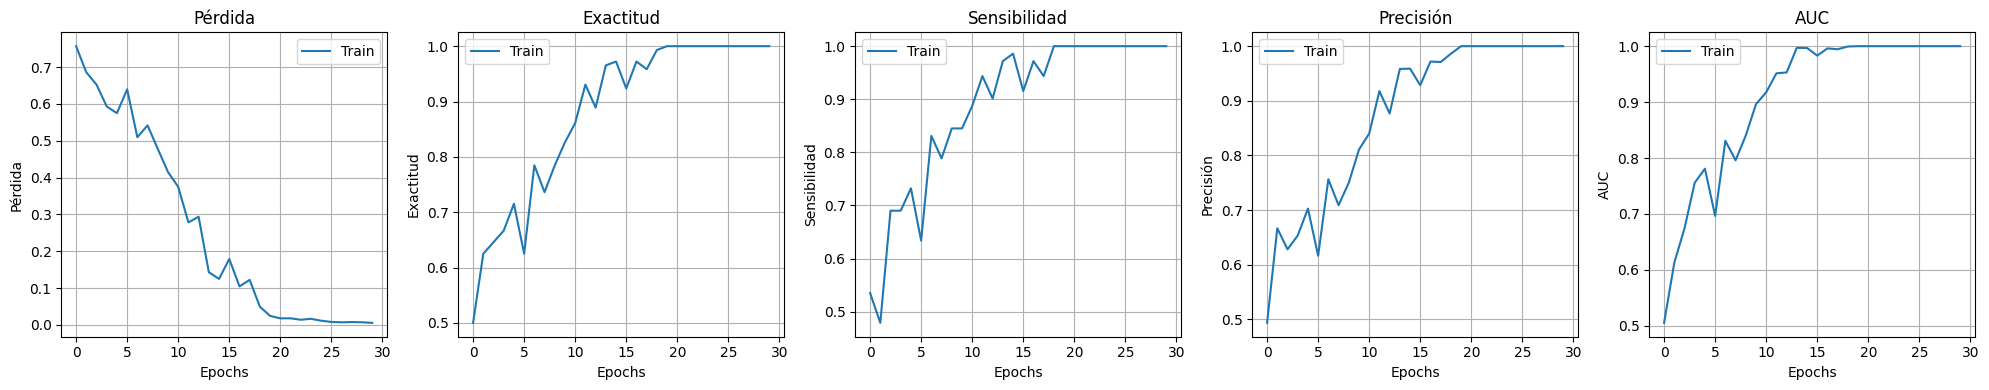

16/16 ━━━━━━━━━━━━━━━━━━━━ 144s 343ms/step

Métricas de evaluación:
Exactitud:     0.8125
Precisión:     0.8125
Sensibilidad:  0.8125
Especificidad: 0.8125
F1-score:      0.8125
AUC:           0.8906


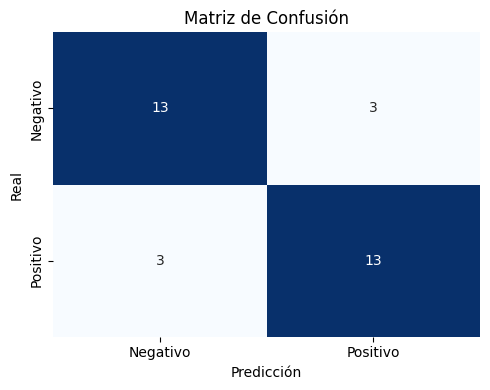

In [ ]:
plot_training_no_val(mobilenetv2_gru_tunned_model_history)
model_metrics_dataset(mobilenetv2_gru_tunned_model, test_ds)

In [ ]:
models_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models"

mobilenetv2_gru_tunned_model.save_weights('/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models/MOBILENETV2_GRU_TUNNED.weights.h5')

with open(os.path.join(models_dir, "MOBILENETV2_GRU_TUNNED_history.pkl"), "wb") as f:
    pickle.dump(mobilenetv2_gru_tunned_model_history.history, f)

## Referencias

Ardalan, Z. and Subbian, V. (2022) *Transfer learning approaches for neuroimaging analysis: a scoping review*. Frontiers in Artificial Intelligence, 5, p.780405.

Davatzikos, C. (2019). *Machine learning in neuroimaging: Progress and challenges*. Neuroimage, 197, 652-656.

Karimi, D., Dou, H., Warfield, S.K. and Gholipour, A. (2020) *Deep learning with noisy labels: Exploring techniques and remedies in medical image analysis*. Medical image analysis, 65, p.101759.

Krishnapriya, S., & Karuna, Y. (2023). *Pre-trained deep learning models for brain MRI image classification*. Frontiers in Human Neuroscience, 17, 1150120.

Janssen, R. J., Mourão-Miranda, J., & Schnack, H. G. (2018). *Making individual prognoses in psychiatry using neuroimaging and machine learning*. Biological psychiatry: Cognitive neuroscience and neuroimaging, 3(9), 798-808.